# Nest Detection Training with Disjoint Data

Train a model which detects nests but avoid data leakage

In [1]:
# assume deepforest is already installed

Cloning into 'DeepForest'...
remote: Enumerating objects: 15617, done.
remote: Counting objects: 100% (2109/2109), done.
remote: Compressing objects: 100% (512/512), done.
remote: Total 15617 (delta 1753), reused 1759 (delta 1593), pack-reused 13508 (from 1)
Receiving objects: 100% (15617/15617), 1000.33 MiB | 17.60 MiB/s, done.
Resolving deltas: 100% (10788/10788), done.


In [1]:
# load the modules
# import comet_ml
import wandb
import os
import time
import numpy as np
import pandas as pd
import torch
from deepforest import main
from deepforest import get_data
from deepforest import utilities
from deepforest import preprocess
from tqdm import tqdm
from pytorch_lightning.loggers import CometLogger, WandbLogger
import zipfile
import matplotlib.pyplot as plt
import subprocess

## Prepare training data by tiling it


In [2]:
!pip install gdown

In [11]:
import gdown

## horus
url = "https://drive.google.com/file/d/1dDnd-exQGU_4Xa0Pi3hfVKoVkiKl2PYt/view?usp=sharing"
output = "deep_forest_root/dataset_tiled_horus.zip"
gdown.cached_download(url, output, postprocess=gdown.extractall, fuzzy=True)



FileURLRetrievalError: Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1dDnd-exQGU_4Xa0Pi3hfVKoVkiKl2PYt

but Gdown can't. Please check connections and permissions.

In [15]:
!pwd

/home/jovyan


In [47]:
# !unzip deep_forest_root/crops.zip -d deep_forest_root/jerrod_crops
# !unzip deep_forest_root/horuscrops.zip -d deep_forest_root/horus_crops
# !unzip deep_forest_root/JetportNew_C.zip -d deep_forest_root/JetportNew_C
# !unzip deep_forest_root/JetportNew_C_crops.zip -d deep_forest_root/JetportNew_C_crops

Archive:  deep_forest_root/JetportNew_C.zip
  inflating: deep_forest_root/JetportNew_C/ground_truth.csv  
  inflating: deep_forest_root/JetportNew_C/__MACOSX/._ground_truth.csv  
  inflating: deep_forest_root/JetportNew_C/JetPortNew_03_029_2022_DJI_0181.JPG  
  inflating: deep_forest_root/JetportNew_C/__MACOSX/._JetPortNew_03_029_2022_DJI_0181.JPG  
  inflating: deep_forest_root/JetportNew_C/JetPortNew_03_029_2022_DJI_0177.JPG  
  inflating: deep_forest_root/JetportNew_C/__MACOSX/._JetPortNew_03_029_2022_DJI_0177.JPG  
  inflating: deep_forest_root/JetportNew_C/JetPortNew_03_029_2022_DJI_0097.JPG  
  inflating: deep_forest_root/JetportNew_C/__MACOSX/._JetPortNew_03_029_2022_DJI_0097.JPG  
  inflating: deep_forest_root/JetportNew_C/JetPortNew_03_029_2022_DJI_0098.JPG  
  inflating: deep_forest_root/JetportNew_C/__MACOSX/._JetPortNew_03_029_2022_DJI_0098.JPG  
  inflating: deep_forest_root/JetportNew_C/JetPortNew_03_029_2022_DJI_0021.JPG  
  inflating: deep_forest_root/JetportNew_C/__MAC

### Train Yolo8

In [66]:
from ultralytics import YOLO

model_yv8 = YOLO("yolov8l.pt")

# Train the model
results = model_yv8.train(data="/home/jovyan/deep_forest_root/data.yaml", epochs=500, imgsz=400, batch=30, patience=50)

New https://pypi.org/project/ultralytics/8.2.87 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.81 🚀 Python-3.11.9 torch-2.4.0+cu121 CUDA:0 (NVIDIA RTX A6000, 48577MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=/home/jovyan/deep_forest_root/data.yaml, epochs=500, time=None, patience=50, batch=30, imgsz=400, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train18, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=Non


train: Scanning /home/jovyan/deep_forest_root/jerrod_crops.cache... 1077 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1077/1077 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))




val: Scanning /home/jovyan/deep_forest_root/horus_crops.cache... 497 images, 0 backgrounds, 0 corrupt: 100%|██████████| 497/497 [00:00<?, ?it/s]


Plotting labels to runs/detect/train18/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.00046875), 103 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to runs/detect/train18
Starting training for 500 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
      1/500      11.7G      3.075      3.239      3.037         64        416:   0%|          | 0/36 [00:00<?, ?it/s]
      1/500      11.7G      3.075      3.239      3.037         64        416:   3%|▎         | 1/36 [00:00<00:07,  4.89it/s]
      1/500      11.7G      2.954       3.36      2.937         60        416:   3%|▎         | 1/36 [00:00<00:07,  4.89it/s]
      1/500      11.7G      2.954       3.36      2.937         60        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
      1/500      11.7G      2.992      3.441      2.901         64        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
      1/500      11.7G      2.992      3.441      2.901         64        416:   8%|▊         | 3/36 [00:00<00:06,  4.85it/s]
      1/500      11.7G      2.964      3.372      2.911         77        416:   8%|▊         | 3/36 [00:00<00:06,  4.85it/s]
      1/500      11.7G      2.964      3.372      2.911         77        416:  11%|█ 

                   all        497        541          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
      2/500      9.14G       2.38      3.114      2.573         61        416:   0%|          | 0/36 [00:00<?, ?it/s]
      2/500      9.14G       2.38      3.114      2.573         61        416:   3%|▎         | 1/36 [00:00<00:07,  4.97it/s]
      2/500      9.14G      2.467      3.086      2.618         71        416:   3%|▎         | 1/36 [00:00<00:07,  4.97it/s]
      2/500      9.14G      2.467      3.086      2.618         71        416:   6%|▌         | 2/36 [00:00<00:06,  4.94it/s]
      2/500      9.14G      2.562      3.109      2.617         66        416:   6%|▌         | 2/36 [00:00<00:06,  4.94it/s]
      2/500      9.14G      2.562      3.109      2.617         66        416:   8%|▊         | 3/36 [00:00<00:06,  4.94it/s]
      2/500      9.14G      2.554      3.127      2.625         65        416:   8%|▊         | 3/36 [00:00<00:06,  4.94it/s]
      2/500      9.14G      2.554      3.127      2.625         65        416:  11%|█ 

                   all        497        541          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
      3/500      9.12G      2.597      3.271      2.613         73        416:   0%|          | 0/36 [00:00<?, ?it/s]
      3/500      9.12G      2.597      3.271      2.613         73        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
      3/500      9.12G      2.531      3.251      2.607         76        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
      3/500      9.12G      2.531      3.251      2.607         76        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
      3/500      9.12G      2.553      3.243      2.602         60        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
      3/500      9.12G      2.553      3.243      2.602         60        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
      3/500      9.12G      2.513      3.217      2.591         75        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
      3/500      9.12G      2.513      3.217      2.591         75        416:  11%|█ 

                   all        497        541          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
      4/500      9.14G      2.415      3.007       2.47         68        416:   0%|          | 0/36 [00:00<?, ?it/s]
      4/500      9.14G      2.415      3.007       2.47         68        416:   3%|▎         | 1/36 [00:00<00:07,  4.60it/s]
      4/500      9.14G      2.459       2.99      2.489         77        416:   3%|▎         | 1/36 [00:00<00:07,  4.60it/s]
      4/500      9.14G      2.459       2.99      2.489         77        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
      4/500      9.14G      2.426      3.055      2.475         74        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
      4/500      9.14G      2.426      3.055      2.475         74        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
      4/500      9.14G      2.437      3.118       2.48         71        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
      4/500      9.14G      2.437      3.118       2.48         71        416:  11%|█ 

                   all        497        541     0.0134      0.061    0.00256   0.000672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
      5/500      9.13G      2.114      2.872       2.27         73        416:   0%|          | 0/36 [00:00<?, ?it/s]
      5/500      9.13G      2.114      2.872       2.27         73        416:   3%|▎         | 1/36 [00:00<00:07,  4.61it/s]
      5/500      9.13G      2.318      2.885      2.443         75        416:   3%|▎         | 1/36 [00:00<00:07,  4.61it/s]
      5/500      9.13G      2.318      2.885      2.443         75        416:   6%|▌         | 2/36 [00:00<00:07,  4.81it/s]
      5/500      9.13G      2.306      2.869      2.438         66        416:   6%|▌         | 2/36 [00:00<00:07,  4.81it/s]
      5/500      9.13G      2.306      2.869      2.438         66        416:   8%|▊         | 3/36 [00:00<00:06,  5.12it/s]
      5/500      9.13G      2.299      2.852      2.426         67        416:   8%|▊         | 3/36 [00:00<00:06,  5.12it/s]
      5/500      9.13G      2.299      2.852      2.426         67        416:  11%|█ 

                   all        497        541     0.0332     0.0203    0.00854    0.00247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
      6/500      9.13G      2.186        2.9      2.402         58        416:   0%|          | 0/36 [00:00<?, ?it/s]
      6/500      9.13G      2.186        2.9      2.402         58        416:   3%|▎         | 1/36 [00:00<00:07,  4.49it/s]
      6/500      9.13G      2.209      2.837      2.429         65        416:   3%|▎         | 1/36 [00:00<00:07,  4.49it/s]
      6/500      9.13G      2.209      2.837      2.429         65        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
      6/500      9.13G      2.186      2.815      2.422         55        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
      6/500      9.13G      2.186      2.815      2.422         55        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
      6/500      9.13G      2.257      2.816      2.457         74        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
      6/500      9.13G      2.257      2.816      2.457         74        416:  11%|█ 

                   all        497        541       0.13      0.242     0.0889     0.0182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
      7/500      9.13G      2.277      2.542      2.333         65        416:   0%|          | 0/36 [00:00<?, ?it/s]
      7/500      9.13G      2.277      2.542      2.333         65        416:   3%|▎         | 1/36 [00:00<00:07,  4.53it/s]
      7/500      9.13G      2.197      2.577      2.322         71        416:   3%|▎         | 1/36 [00:00<00:07,  4.53it/s]
      7/500      9.13G      2.197      2.577      2.322         71        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
      7/500      9.13G      2.229      2.566       2.33         63        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
      7/500      9.13G      2.229      2.566       2.33         63        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
      7/500      9.13G      2.209      2.584      2.332         61        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
      7/500      9.13G      2.209      2.584      2.332         61        416:  11%|█ 

                   all        497        541      0.203      0.285      0.112     0.0252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
      8/500      9.13G      2.224      2.582      2.244         71        416:   0%|          | 0/36 [00:00<?, ?it/s]
      8/500      9.13G      2.224      2.582      2.244         71        416:   3%|▎         | 1/36 [00:00<00:07,  4.45it/s]
      8/500      9.13G      2.176      2.523      2.261         64        416:   3%|▎         | 1/36 [00:00<00:07,  4.45it/s]
      8/500      9.13G      2.176      2.523      2.261         64        416:   6%|▌         | 2/36 [00:00<00:07,  4.69it/s]
      8/500      9.13G      2.235      2.566      2.326         54        416:   6%|▌         | 2/36 [00:00<00:07,  4.69it/s]
      8/500      9.13G      2.235      2.566      2.326         54        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
      8/500      9.13G      2.237      2.557      2.324         65        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
      8/500      9.13G      2.237      2.557      2.324         65        416:  11%|█ 

                   all        497        541      0.322      0.311       0.26     0.0918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
      9/500      9.14G      2.023       2.45      2.252         62        416:   0%|          | 0/36 [00:00<?, ?it/s]
      9/500      9.14G      2.023       2.45      2.252         62        416:   3%|▎         | 1/36 [00:00<00:07,  4.56it/s]
      9/500      9.14G       2.06       2.42      2.262         68        416:   3%|▎         | 1/36 [00:00<00:07,  4.56it/s]
      9/500      9.14G       2.06       2.42      2.262         68        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
      9/500      9.14G       2.13      2.452      2.319         70        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
      9/500      9.14G       2.13      2.452      2.319         70        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
      9/500      9.14G       2.16      2.467      2.305         67        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
      9/500      9.14G       2.16      2.467      2.305         67        416:  11%|█ 

                   all        497        541      0.346      0.387       0.28     0.0823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     10/500      9.14G       2.02      2.453      2.148         61        416:   0%|          | 0/36 [00:00<?, ?it/s]
     10/500      9.14G       2.02      2.453      2.148         61        416:   3%|▎         | 1/36 [00:00<00:07,  4.43it/s]
     10/500      9.14G      2.017       2.55      2.164         73        416:   3%|▎         | 1/36 [00:00<00:07,  4.43it/s]
     10/500      9.14G      2.017       2.55      2.164         73        416:   6%|▌         | 2/36 [00:00<00:07,  4.68it/s]
     10/500      9.14G      2.017      2.508      2.177         70        416:   6%|▌         | 2/36 [00:00<00:07,  4.68it/s]
     10/500      9.14G      2.017      2.508      2.177         70        416:   8%|▊         | 3/36 [00:00<00:06,  5.01it/s]
     10/500      9.14G       2.03      2.516      2.195         69        416:   8%|▊         | 3/36 [00:00<00:06,  5.01it/s]
     10/500      9.14G       2.03      2.516      2.195         69        416:  11%|█ 

                   all        497        541      0.261      0.359      0.186     0.0526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     11/500      9.13G      1.955      2.616      2.187         60        416:   0%|          | 0/36 [00:00<?, ?it/s]
     11/500      9.13G      1.955      2.616      2.187         60        416:   3%|▎         | 1/36 [00:00<00:07,  4.48it/s]
     11/500      9.13G      2.045      2.576      2.264         58        416:   3%|▎         | 1/36 [00:00<00:07,  4.48it/s]
     11/500      9.13G      2.045      2.576      2.264         58        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
     11/500      9.13G       2.05      2.509      2.274         78        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
     11/500      9.13G       2.05      2.509      2.274         78        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
     11/500      9.13G      2.069      2.494      2.278         70        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
     11/500      9.13G      2.069      2.494      2.278         70        416:  11%|█ 

                   all        497        541      0.425      0.351      0.309      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     12/500      9.14G      2.172      2.661      2.311         68        416:   0%|          | 0/36 [00:00<?, ?it/s]
     12/500      9.14G      2.172      2.661      2.311         68        416:   3%|▎         | 1/36 [00:00<00:07,  4.55it/s]
     12/500      9.14G      2.149      2.541      2.294         62        416:   3%|▎         | 1/36 [00:00<00:07,  4.55it/s]
     12/500      9.14G      2.149      2.541      2.294         62        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
     12/500      9.14G      2.154      2.552      2.276         70        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
     12/500      9.14G      2.154      2.552      2.276         70        416:   8%|▊         | 3/36 [00:00<00:06,  5.11it/s]
     12/500      9.14G      2.137      2.568      2.279         67        416:   8%|▊         | 3/36 [00:00<00:06,  5.11it/s]
     12/500      9.14G      2.137      2.568      2.279         67        416:  11%|█ 

                   all        497        541      0.232      0.307      0.161     0.0392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     13/500      9.13G      1.873      2.411      2.162         65        416:   0%|          | 0/36 [00:00<?, ?it/s]
     13/500      9.13G      1.873      2.411      2.162         65        416:   3%|▎         | 1/36 [00:00<00:07,  4.49it/s]
     13/500      9.13G      2.086      2.548      2.265         61        416:   3%|▎         | 1/36 [00:00<00:07,  4.49it/s]
     13/500      9.13G      2.086      2.548      2.265         61        416:   6%|▌         | 2/36 [00:00<00:07,  4.66it/s]
     13/500      9.13G      2.076       2.49      2.262         66        416:   6%|▌         | 2/36 [00:00<00:07,  4.66it/s]
     13/500      9.13G      2.076       2.49      2.262         66        416:   8%|▊         | 3/36 [00:00<00:06,  5.02it/s]
     13/500      9.13G      2.013      2.457      2.226         67        416:   8%|▊         | 3/36 [00:00<00:06,  5.02it/s]
     13/500      9.13G      2.013      2.457      2.226         67        416:  11%|█ 

                   all        497        541      0.285      0.168      0.129      0.034



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     14/500      9.13G      1.975      2.388      2.204         66        416:   0%|          | 0/36 [00:00<?, ?it/s]
     14/500      9.13G      1.975      2.388      2.204         66        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
     14/500      9.13G      1.963      2.386      2.197         73        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
     14/500      9.13G      1.963      2.386      2.197         73        416:   6%|▌         | 2/36 [00:00<00:07,  4.71it/s]
     14/500      9.13G      1.988      2.433      2.209         59        416:   6%|▌         | 2/36 [00:00<00:07,  4.71it/s]
     14/500      9.13G      1.988      2.433      2.209         59        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
     14/500      9.13G      1.965      2.422      2.209         53        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
     14/500      9.13G      1.965      2.422      2.209         53        416:  11%|█ 

                   all        497        541      0.246      0.227      0.168     0.0635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     15/500      9.13G      1.871      2.334      2.165         66        416:   0%|          | 0/36 [00:00<?, ?it/s]
     15/500      9.13G      1.871      2.334      2.165         66        416:   3%|▎         | 1/36 [00:00<00:07,  4.54it/s]
     15/500      9.13G      2.026      2.462      2.221         71        416:   3%|▎         | 1/36 [00:00<00:07,  4.54it/s]
     15/500      9.13G      2.026      2.462      2.221         71        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
     15/500      9.13G      1.989      2.482      2.197         53        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
     15/500      9.13G      1.989      2.482      2.197         53        416:   8%|▊         | 3/36 [00:00<00:06,  5.11it/s]
     15/500      9.13G      1.984      2.462      2.201         64        416:   8%|▊         | 3/36 [00:00<00:06,  5.11it/s]
     15/500      9.13G      1.984      2.462      2.201         64        416:  11%|█ 

                   all        497        541      0.378      0.287      0.246     0.0698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     16/500      9.13G      2.118      2.299      2.197         76        416:   0%|          | 0/36 [00:00<?, ?it/s]
     16/500      9.13G      2.118      2.299      2.197         76        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
     16/500      9.13G      2.005      2.346      2.158         55        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
     16/500      9.13G      2.005      2.346      2.158         55        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
     16/500      9.13G      2.011      2.322      2.162         80        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
     16/500      9.13G      2.011      2.322      2.162         80        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
     16/500      9.13G      1.993      2.362      2.184         66        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
     16/500      9.13G      1.993      2.362      2.184         66        416:  11%|█ 

                   all        497        541      0.223      0.365      0.151     0.0464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     17/500      9.13G       1.96      2.512      2.106         79        416:   0%|          | 0/36 [00:00<?, ?it/s]
     17/500      9.13G       1.96      2.512      2.106         79        416:   3%|▎         | 1/36 [00:00<00:07,  4.57it/s]
     17/500      9.13G      1.958      2.404      2.143         69        416:   3%|▎         | 1/36 [00:00<00:07,  4.57it/s]
     17/500      9.13G      1.958      2.404      2.143         69        416:   6%|▌         | 2/36 [00:00<00:07,  4.80it/s]
     17/500      9.13G      1.947      2.365      2.149         71        416:   6%|▌         | 2/36 [00:00<00:07,  4.80it/s]
     17/500      9.13G      1.947      2.365      2.149         71        416:   8%|▊         | 3/36 [00:00<00:06,  5.12it/s]
     17/500      9.13G      1.973      2.372      2.166         82        416:   8%|▊         | 3/36 [00:00<00:06,  5.12it/s]
     17/500      9.13G      1.973      2.372      2.166         82        416:  11%|█ 

                   all        497        541      0.261      0.416      0.186     0.0458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     18/500      9.13G      2.055        2.6      2.188         58        416:   0%|          | 0/36 [00:00<?, ?it/s]
     18/500      9.13G      2.055        2.6      2.188         58        416:   3%|▎         | 1/36 [00:00<00:07,  4.54it/s]
     18/500      9.13G      1.969      2.424      2.114         58        416:   3%|▎         | 1/36 [00:00<00:07,  4.54it/s]
     18/500      9.13G      1.969      2.424      2.114         58        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
     18/500      9.13G      1.937      2.382      2.106         59        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
     18/500      9.13G      1.937      2.382      2.106         59        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
     18/500      9.13G      1.994      2.419      2.148         58        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
     18/500      9.13G      1.994      2.419      2.148         58        416:  11%|█ 

                   all        497        541      0.338      0.529      0.318     0.0962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     19/500      9.13G      2.091      2.486      2.266         71        416:   0%|          | 0/36 [00:00<?, ?it/s]
     19/500      9.13G      2.091      2.486      2.266         71        416:   3%|▎         | 1/36 [00:00<00:07,  4.54it/s]
     19/500      9.13G      2.045      2.357        2.2         60        416:   3%|▎         | 1/36 [00:00<00:07,  4.54it/s]
     19/500      9.13G      2.045      2.357        2.2         60        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
     19/500      9.13G      2.032      2.388      2.193         64        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
     19/500      9.13G      2.032      2.388      2.193         64        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
     19/500      9.13G      1.992      2.368      2.175         65        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
     19/500      9.13G      1.992      2.368      2.175         65        416:  11%|█ 

                   all        497        541      0.359      0.508      0.342      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     20/500      9.12G      1.739      2.086      1.953         65        416:   0%|          | 0/36 [00:00<?, ?it/s]
     20/500      9.12G      1.739      2.086      1.953         65        416:   3%|▎         | 1/36 [00:00<00:07,  4.54it/s]
     20/500      9.12G      1.909      2.275      2.104         64        416:   3%|▎         | 1/36 [00:00<00:07,  4.54it/s]
     20/500      9.12G      1.909      2.275      2.104         64        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
     20/500      9.12G      1.873      2.317      2.076         64        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
     20/500      9.12G      1.873      2.317      2.076         64        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
     20/500      9.12G       1.85      2.308      2.076         61        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
     20/500      9.12G       1.85      2.308      2.076         61        416:  11%|█ 

                   all        497        541      0.292      0.462      0.273     0.0987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     21/500      9.13G      1.805       2.11      1.962         71        416:   0%|          | 0/36 [00:00<?, ?it/s]
     21/500      9.13G      1.805       2.11      1.962         71        416:   3%|▎         | 1/36 [00:00<00:07,  4.58it/s]
     21/500      9.13G      1.885      2.209      2.007         61        416:   3%|▎         | 1/36 [00:00<00:07,  4.58it/s]
     21/500      9.13G      1.885      2.209      2.007         61        416:   6%|▌         | 2/36 [00:00<00:07,  4.82it/s]
     21/500      9.13G      1.861      2.296      2.009         54        416:   6%|▌         | 2/36 [00:00<00:07,  4.82it/s]
     21/500      9.13G      1.861      2.296      2.009         54        416:   8%|▊         | 3/36 [00:00<00:06,  5.13it/s]
     21/500      9.13G      1.856        2.3      2.032         64        416:   8%|▊         | 3/36 [00:00<00:06,  5.13it/s]
     21/500      9.13G      1.856        2.3      2.032         64        416:  11%|█ 

                   all        497        541      0.287       0.61      0.333      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     22/500      9.14G      1.815      2.139      2.034         59        416:   0%|          | 0/36 [00:00<?, ?it/s]
     22/500      9.14G      1.815      2.139      2.034         59        416:   3%|▎         | 1/36 [00:00<00:07,  4.54it/s]
     22/500      9.14G      1.832      2.114      2.077         71        416:   3%|▎         | 1/36 [00:00<00:07,  4.54it/s]
     22/500      9.14G      1.832      2.114      2.077         71        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
     22/500      9.14G      1.882      2.165      2.085         64        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
     22/500      9.14G      1.882      2.165      2.085         64        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
     22/500      9.14G      1.886      2.194      2.078         76        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
     22/500      9.14G      1.886      2.194      2.078         76        416:  11%|█ 

                   all        497        541      0.274      0.614      0.306      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     23/500      9.12G       1.76      2.281      2.009         66        416:   0%|          | 0/36 [00:00<?, ?it/s]
     23/500      9.12G       1.76      2.281      2.009         66        416:   3%|▎         | 1/36 [00:00<00:07,  4.49it/s]
     23/500      9.12G      1.857      2.229      2.038         71        416:   3%|▎         | 1/36 [00:00<00:07,  4.49it/s]
     23/500      9.12G      1.857      2.229      2.038         71        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
     23/500      9.12G       1.81      2.179      2.014         68        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
     23/500      9.12G       1.81      2.179      2.014         68        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
     23/500      9.12G      1.853      2.192      2.034         69        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
     23/500      9.12G      1.853      2.192      2.034         69        416:  11%|█ 

                   all        497        541      0.374      0.575      0.372      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     24/500      9.12G      1.855      2.415      2.112         65        416:   0%|          | 0/36 [00:00<?, ?it/s]
     24/500      9.12G      1.855      2.415      2.112         65        416:   3%|▎         | 1/36 [00:00<00:07,  4.60it/s]
     24/500      9.12G      1.826      2.306      2.077         71        416:   3%|▎         | 1/36 [00:00<00:07,  4.60it/s]
     24/500      9.12G      1.826      2.306      2.077         71        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
     24/500      9.12G      1.813       2.28       2.06         71        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
     24/500      9.12G      1.813       2.28       2.06         71        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
     24/500      9.12G      1.818      2.269      2.047         72        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
     24/500      9.12G      1.818      2.269      2.047         72        416:  11%|█ 

                   all        497        541      0.292      0.407      0.237     0.0835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     25/500      9.13G      1.769      2.264      1.971         70        416:   0%|          | 0/36 [00:00<?, ?it/s]
     25/500      9.13G      1.769      2.264      1.971         70        416:   3%|▎         | 1/36 [00:00<00:07,  4.55it/s]
     25/500      9.13G      1.848      2.279      2.036         69        416:   3%|▎         | 1/36 [00:00<00:07,  4.55it/s]
     25/500      9.13G      1.848      2.279      2.036         69        416:   6%|▌         | 2/36 [00:00<00:07,  4.79it/s]
     25/500      9.13G      1.808       2.22      2.009         69        416:   6%|▌         | 2/36 [00:00<00:07,  4.79it/s]
     25/500      9.13G      1.808       2.22      2.009         69        416:   8%|▊         | 3/36 [00:00<00:06,  5.13it/s]
     25/500      9.13G      1.825      2.215      2.031         64        416:   8%|▊         | 3/36 [00:00<00:06,  5.13it/s]
     25/500      9.13G      1.825      2.215      2.031         64        416:  11%|█ 

                   all        497        541      0.318      0.693       0.33      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     26/500      9.13G      1.739      2.229      1.999         67        416:   0%|          | 0/36 [00:00<?, ?it/s]
     26/500      9.13G      1.739      2.229      1.999         67        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
     26/500      9.13G      1.779      2.253      2.014         52        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
     26/500      9.13G      1.779      2.253      2.014         52        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
     26/500      9.13G      1.817      2.285       2.04         67        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
     26/500      9.13G      1.817      2.285       2.04         67        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
     26/500      9.13G      1.838      2.319      2.056         78        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
     26/500      9.13G      1.838      2.319      2.056         78        416:  11%|█ 

                   all        497        541      0.396      0.433      0.308      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     27/500      9.13G      1.853      2.348      2.061         72        416:   0%|          | 0/36 [00:00<?, ?it/s]
     27/500      9.13G      1.853      2.348      2.061         72        416:   3%|▎         | 1/36 [00:00<00:07,  4.49it/s]
     27/500      9.13G      1.754      2.265      1.997         67        416:   3%|▎         | 1/36 [00:00<00:07,  4.49it/s]
     27/500      9.13G      1.754      2.265      1.997         67        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
     27/500      9.13G      1.792      2.285      2.022         62        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
     27/500      9.13G      1.792      2.285      2.022         62        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
     27/500      9.13G      1.824      2.282      2.044         71        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
     27/500      9.13G      1.824      2.282      2.044         71        416:  11%|█ 

                   all        497        541       0.32      0.577      0.306      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     28/500      9.12G      1.796      2.279      1.999         63        416:   0%|          | 0/36 [00:00<?, ?it/s]
     28/500      9.12G      1.796      2.279      1.999         63        416:   3%|▎         | 1/36 [00:00<00:07,  4.52it/s]
     28/500      9.12G      1.926      2.393      2.063         58        416:   3%|▎         | 1/36 [00:00<00:07,  4.52it/s]
     28/500      9.12G      1.926      2.393      2.063         58        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
     28/500      9.12G      1.955      2.364      2.082         74        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
     28/500      9.12G      1.955      2.364      2.082         74        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
     28/500      9.12G      1.895       2.35      2.052         67        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
     28/500      9.12G      1.895       2.35      2.052         67        416:  11%|█ 

                   all        497        541      0.394      0.505      0.372       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     29/500      9.12G      1.782      2.151      2.006         71        416:   0%|          | 0/36 [00:00<?, ?it/s]
     29/500      9.12G      1.782      2.151      2.006         71        416:   3%|▎         | 1/36 [00:00<00:07,  4.53it/s]
     29/500      9.12G      1.739      2.132      1.976         62        416:   3%|▎         | 1/36 [00:00<00:07,  4.53it/s]
     29/500      9.12G      1.739      2.132      1.976         62        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
     29/500      9.12G      1.769      2.193      2.003         71        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
     29/500      9.12G      1.769      2.193      2.003         71        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
     29/500      9.12G      1.787      2.208      2.015         57        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
     29/500      9.12G      1.787      2.208      2.015         57        416:  11%|█ 

                   all        497        541      0.396      0.486      0.292      0.071



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     30/500      9.14G      1.962      2.235       2.09         70        416:   0%|          | 0/36 [00:00<?, ?it/s]
     30/500      9.14G      1.962      2.235       2.09         70        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
     30/500      9.14G      1.857      2.273       2.03         68        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
     30/500      9.14G      1.857      2.273       2.03         68        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
     30/500      9.14G      1.796      2.249      1.995         64        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
     30/500      9.14G      1.796      2.249      1.995         64        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
     30/500      9.14G       1.78      2.247      1.992         66        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
     30/500      9.14G       1.78      2.247      1.992         66        416:  11%|█ 

                   all        497        541      0.358      0.562      0.327      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     31/500      9.13G      1.758      2.198      1.958         73        416:   0%|          | 0/36 [00:00<?, ?it/s]
     31/500      9.13G      1.758      2.198      1.958         73        416:   3%|▎         | 1/36 [00:00<00:07,  4.55it/s]
     31/500      9.13G      1.788      2.254      1.963         66        416:   3%|▎         | 1/36 [00:00<00:07,  4.55it/s]
     31/500      9.13G      1.788      2.254      1.963         66        416:   6%|▌         | 2/36 [00:00<00:07,  4.79it/s]
     31/500      9.13G      1.773      2.254      1.972         72        416:   6%|▌         | 2/36 [00:00<00:07,  4.79it/s]
     31/500      9.13G      1.773      2.254      1.972         72        416:   8%|▊         | 3/36 [00:00<00:06,  5.12it/s]
     31/500      9.13G      1.782      2.244      1.984         65        416:   8%|▊         | 3/36 [00:00<00:06,  5.12it/s]
     31/500      9.13G      1.782      2.244      1.984         65        416:  11%|█ 

                   all        497        541      0.267      0.418      0.279     0.0924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     32/500      9.13G       1.69      2.269      1.988         72        416:   0%|          | 0/36 [00:00<?, ?it/s]
     32/500      9.13G       1.69      2.269      1.988         72        416:   3%|▎         | 1/36 [00:00<00:07,  4.49it/s]
     32/500      9.13G      1.749      2.234      1.971         76        416:   3%|▎         | 1/36 [00:00<00:07,  4.49it/s]
     32/500      9.13G      1.749      2.234      1.971         76        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
     32/500      9.13G      1.729      2.309      1.965         47        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
     32/500      9.13G      1.729      2.309      1.965         47        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
     32/500      9.13G      1.724      2.269      1.941         64        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
     32/500      9.13G      1.724      2.269      1.941         64        416:  11%|█ 

                   all        497        541      0.334      0.651      0.328     0.0972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     33/500      9.13G      1.845      2.346      1.975         58        416:   0%|          | 0/36 [00:00<?, ?it/s]
     33/500      9.13G      1.845      2.346      1.975         58        416:   3%|▎         | 1/36 [00:00<00:07,  4.55it/s]
     33/500      9.13G      1.854      2.401      1.976         65        416:   3%|▎         | 1/36 [00:00<00:07,  4.55it/s]
     33/500      9.13G      1.854      2.401      1.976         65        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
     33/500      9.13G      1.821      2.336      1.954         77        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
     33/500      9.13G      1.821      2.336      1.954         77        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
     33/500      9.13G      1.777      2.285      1.953         58        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
     33/500      9.13G      1.777      2.285      1.953         58        416:  11%|█ 

                   all        497        541      0.378      0.444      0.314      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     34/500      9.13G      1.734      2.212      2.008         60        416:   0%|          | 0/36 [00:00<?, ?it/s]
     34/500      9.13G      1.734      2.212      2.008         60        416:   3%|▎         | 1/36 [00:00<00:07,  4.49it/s]
     34/500      9.13G      1.722       2.29          2         58        416:   3%|▎         | 1/36 [00:00<00:07,  4.49it/s]
     34/500      9.13G      1.722       2.29          2         58        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
     34/500      9.13G      1.739      2.279      2.014         88        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
     34/500      9.13G      1.739      2.279      2.014         88        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
     34/500      9.13G      1.736      2.296      2.008         55        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
     34/500      9.13G      1.736      2.296      2.008         55        416:  11%|█ 

                   all        497        541      0.318      0.725       0.34      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     35/500      9.13G      1.797      2.132      2.086         71        416:   0%|          | 0/36 [00:00<?, ?it/s]
     35/500      9.13G      1.797      2.132      2.086         71        416:   3%|▎         | 1/36 [00:00<00:07,  4.53it/s]
     35/500      9.13G      1.825      2.167      2.052         71        416:   3%|▎         | 1/36 [00:00<00:07,  4.53it/s]
     35/500      9.13G      1.825      2.167      2.052         71        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
     35/500      9.13G      1.804      2.225      2.024         59        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
     35/500      9.13G      1.804      2.225      2.024         59        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
     35/500      9.13G      1.811      2.245      2.025         76        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
     35/500      9.13G      1.811      2.245      2.025         76        416:  11%|█ 

                   all        497        541       0.12       0.12     0.0322    0.00632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     36/500      9.14G      1.806      2.086      1.986         76        416:   0%|          | 0/36 [00:00<?, ?it/s]
     36/500      9.14G      1.806      2.086      1.986         76        416:   3%|▎         | 1/36 [00:00<00:07,  4.55it/s]
     36/500      9.14G      1.669      2.189      1.921         66        416:   3%|▎         | 1/36 [00:00<00:07,  4.55it/s]
     36/500      9.14G      1.669      2.189      1.921         66        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
     36/500      9.14G      1.701      2.221      1.929         64        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
     36/500      9.14G      1.701      2.221      1.929         64        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
     36/500      9.14G      1.726      2.231      1.952         76        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
     36/500      9.14G      1.726      2.231      1.952         76        416:  11%|█ 

                   all        497        541      0.413      0.586      0.436      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     37/500      9.14G      1.809      2.226      1.998         69        416:   0%|          | 0/36 [00:00<?, ?it/s]
     37/500      9.14G      1.809      2.226      1.998         69        416:   3%|▎         | 1/36 [00:00<00:07,  4.41it/s]
     37/500      9.14G      1.763      2.255      1.941         57        416:   3%|▎         | 1/36 [00:00<00:07,  4.41it/s]
     37/500      9.14G      1.763      2.255      1.941         57        416:   6%|▌         | 2/36 [00:00<00:07,  4.69it/s]
     37/500      9.14G      1.729        2.2      1.905         65        416:   6%|▌         | 2/36 [00:00<00:07,  4.69it/s]
     37/500      9.14G      1.729        2.2      1.905         65        416:   8%|▊         | 3/36 [00:00<00:06,  5.04it/s]
     37/500      9.14G       1.72       2.18      1.906         56        416:   8%|▊         | 3/36 [00:00<00:06,  5.04it/s]
     37/500      9.14G       1.72       2.18      1.906         56        416:  11%|█ 

                   all        497        541      0.421      0.577      0.391      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     38/500      9.14G      1.707      2.114      1.904         61        416:   0%|          | 0/36 [00:00<?, ?it/s]
     38/500      9.14G      1.707      2.114      1.904         61        416:   3%|▎         | 1/36 [00:00<00:07,  4.54it/s]
     38/500      9.14G      1.733      2.112      1.927         73        416:   3%|▎         | 1/36 [00:00<00:07,  4.54it/s]
     38/500      9.14G      1.733      2.112      1.927         73        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
     38/500      9.14G      1.697      2.148      1.905         63        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
     38/500      9.14G      1.697      2.148      1.905         63        416:   8%|▊         | 3/36 [00:00<00:06,  5.10it/s]
     38/500      9.14G      1.666      2.155      1.892         64        416:   8%|▊         | 3/36 [00:00<00:06,  5.10it/s]
     38/500      9.14G      1.666      2.155      1.892         64        416:  11%|█ 

                   all        497        541      0.479      0.556       0.49      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     39/500      9.13G      1.643      2.041      1.832         72        416:   0%|          | 0/36 [00:00<?, ?it/s]
     39/500      9.13G      1.643      2.041      1.832         72        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
     39/500      9.13G       1.66       2.05      1.883         79        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
     39/500      9.13G       1.66       2.05      1.883         79        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
     39/500      9.13G      1.707      2.102      1.896         67        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
     39/500      9.13G      1.707      2.102      1.896         67        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
     39/500      9.13G      1.665      2.124       1.88         58        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
     39/500      9.13G      1.665      2.124       1.88         58        416:  11%|█ 

                   all        497        541      0.277      0.619      0.245     0.0998



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     40/500      9.14G      1.751      2.283      1.917         66        416:   0%|          | 0/36 [00:00<?, ?it/s]
     40/500      9.14G      1.751      2.283      1.917         66        416:   3%|▎         | 1/36 [00:00<00:07,  4.58it/s]
     40/500      9.14G      1.766      2.259      1.964         65        416:   3%|▎         | 1/36 [00:00<00:07,  4.58it/s]
     40/500      9.14G      1.766      2.259      1.964         65        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
     40/500      9.14G      1.708      2.254      1.924         60        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
     40/500      9.14G      1.708      2.254      1.924         60        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
     40/500      9.14G      1.667      2.195      1.898         53        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
     40/500      9.14G      1.667      2.195      1.898         53        416:  11%|█ 

                   all        497        541      0.284      0.688      0.297      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     41/500      9.14G      1.635      2.202        1.9         61        416:   0%|          | 0/36 [00:00<?, ?it/s]
     41/500      9.14G      1.635      2.202        1.9         61        416:   3%|▎         | 1/36 [00:00<00:07,  4.59it/s]
     41/500      9.14G      1.737      2.206       1.97         66        416:   3%|▎         | 1/36 [00:00<00:07,  4.59it/s]
     41/500      9.14G      1.737      2.206       1.97         66        416:   6%|▌         | 2/36 [00:00<00:07,  4.79it/s]
     41/500      9.14G      1.751      2.201      1.965         63        416:   6%|▌         | 2/36 [00:00<00:07,  4.79it/s]
     41/500      9.14G      1.751      2.201      1.965         63        416:   8%|▊         | 3/36 [00:00<00:06,  5.12it/s]
     41/500      9.14G      1.761      2.177      1.969         65        416:   8%|▊         | 3/36 [00:00<00:06,  5.12it/s]
     41/500      9.14G      1.761      2.177      1.969         65        416:  11%|█ 

                   all        497        541      0.447      0.329      0.287      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     42/500      9.12G      1.646      2.134      1.955         65        416:   0%|          | 0/36 [00:00<?, ?it/s]
     42/500      9.12G      1.646      2.134      1.955         65        416:   3%|▎         | 1/36 [00:00<00:07,  4.48it/s]
     42/500      9.12G      1.687      2.122      1.964         60        416:   3%|▎         | 1/36 [00:00<00:07,  4.48it/s]
     42/500      9.12G      1.687      2.122      1.964         60        416:   6%|▌         | 2/36 [00:00<00:07,  4.72it/s]
     42/500      9.12G      1.685      2.172      1.953         63        416:   6%|▌         | 2/36 [00:00<00:07,  4.72it/s]
     42/500      9.12G      1.685      2.172      1.953         63        416:   8%|▊         | 3/36 [00:00<00:06,  5.04it/s]
     42/500      9.12G      1.662      2.166      1.938         57        416:   8%|▊         | 3/36 [00:00<00:06,  5.04it/s]
     42/500      9.12G      1.662      2.166      1.938         57        416:  11%|█ 

                   all        497        541      0.398      0.527      0.364      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     43/500      9.13G       1.71      2.193        1.9         79        416:   0%|          | 0/36 [00:00<?, ?it/s]
     43/500      9.13G       1.71      2.193        1.9         79        416:   3%|▎         | 1/36 [00:00<00:07,  4.56it/s]
     43/500      9.13G      1.614      2.161      1.859         59        416:   3%|▎         | 1/36 [00:00<00:07,  4.56it/s]
     43/500      9.13G      1.614      2.161      1.859         59        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
     43/500      9.13G      1.659      2.175      1.898         78        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
     43/500      9.13G      1.659      2.175      1.898         78        416:   8%|▊         | 3/36 [00:00<00:06,  5.11it/s]
     43/500      9.13G       1.69      2.182      1.905         80        416:   8%|▊         | 3/36 [00:00<00:06,  5.11it/s]
     43/500      9.13G       1.69      2.182      1.905         80        416:  11%|█ 

                   all        497        541      0.417      0.579      0.384      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     44/500      9.14G      1.501       2.28      1.785         51        416:   0%|          | 0/36 [00:00<?, ?it/s]
     44/500      9.14G      1.501       2.28      1.785         51        416:   3%|▎         | 1/36 [00:00<00:07,  4.46it/s]
     44/500      9.14G      1.631      2.296      1.849         81        416:   3%|▎         | 1/36 [00:00<00:07,  4.46it/s]
     44/500      9.14G      1.631      2.296      1.849         81        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
     44/500      9.14G       1.64      2.254      1.863         70        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
     44/500      9.14G       1.64      2.254      1.863         70        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
     44/500      9.14G       1.64      2.281      1.884         70        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
     44/500      9.14G       1.64      2.281      1.884         70        416:  11%|█ 

                   all        497        541      0.418      0.604      0.385      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     45/500      9.12G      1.691      2.151      1.884         67        416:   0%|          | 0/36 [00:00<?, ?it/s]
     45/500      9.12G      1.691      2.151      1.884         67        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
     45/500      9.12G      1.737      2.192      1.925         67        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
     45/500      9.12G      1.737      2.192      1.925         67        416:   6%|▌         | 2/36 [00:00<00:07,  4.73it/s]
     45/500      9.12G      1.738      2.178      1.914         77        416:   6%|▌         | 2/36 [00:00<00:07,  4.73it/s]
     45/500      9.12G      1.738      2.178      1.914         77        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
     45/500      9.12G      1.729       2.14      1.913         66        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
     45/500      9.12G      1.729       2.14      1.913         66        416:  11%|█ 

                   all        497        541      0.387      0.619      0.377      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     46/500      9.12G      1.666      2.157      1.857         64        416:   0%|          | 0/36 [00:00<?, ?it/s]
     46/500      9.12G      1.666      2.157      1.857         64        416:   3%|▎         | 1/36 [00:00<00:07,  4.58it/s]
     46/500      9.12G      1.704      2.148      1.893         65        416:   3%|▎         | 1/36 [00:00<00:07,  4.58it/s]
     46/500      9.12G      1.704      2.148      1.893         65        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
     46/500      9.12G      1.708      2.173      1.911         71        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
     46/500      9.12G      1.708      2.173      1.911         71        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
     46/500      9.12G      1.711      2.156      1.901         71        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
     46/500      9.12G      1.711      2.156      1.901         71        416:  11%|█ 

                   all        497        541       0.51      0.412      0.326      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     47/500      9.13G      1.665      2.041      1.867         77        416:   0%|          | 0/36 [00:00<?, ?it/s]
     47/500      9.13G      1.665      2.041      1.867         77        416:   3%|▎         | 1/36 [00:00<00:07,  4.49it/s]
     47/500      9.13G      1.724      2.057      1.933         72        416:   3%|▎         | 1/36 [00:00<00:07,  4.49it/s]
     47/500      9.13G      1.724      2.057      1.933         72        416:   6%|▌         | 2/36 [00:00<00:07,  4.69it/s]
     47/500      9.13G      1.746      2.086      1.918         63        416:   6%|▌         | 2/36 [00:00<00:07,  4.69it/s]
     47/500      9.13G      1.746      2.086      1.918         63        416:   8%|▊         | 3/36 [00:00<00:06,  5.03it/s]
     47/500      9.13G      1.743      2.116      1.909         82        416:   8%|▊         | 3/36 [00:00<00:06,  5.03it/s]
     47/500      9.13G      1.743      2.116      1.909         82        416:  11%|█ 

                   all        497        541      0.558      0.319       0.29      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     48/500      9.13G      1.615      2.164      1.816         69        416:   0%|          | 0/36 [00:00<?, ?it/s]
     48/500      9.13G      1.615      2.164      1.816         69        416:   3%|▎         | 1/36 [00:00<00:07,  4.59it/s]
     48/500      9.13G      1.632      2.136      1.833         71        416:   3%|▎         | 1/36 [00:00<00:07,  4.59it/s]
     48/500      9.13G      1.632      2.136      1.833         71        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
     48/500      9.13G       1.64      2.127      1.833         71        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
     48/500      9.13G       1.64      2.127      1.833         71        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
     48/500      9.13G      1.621      2.125      1.821         64        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
     48/500      9.13G      1.621      2.125      1.821         64        416:  11%|█ 

                   all        497        541     0.0683      0.386     0.0648     0.0213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     49/500      9.13G      1.726      2.224      1.939         73        416:   0%|          | 0/36 [00:00<?, ?it/s]
     49/500      9.13G      1.726      2.224      1.939         73        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
     49/500      9.13G      1.643      2.172      1.887         65        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
     49/500      9.13G      1.643      2.172      1.887         65        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
     49/500      9.13G      1.611      2.147      1.863         71        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
     49/500      9.13G      1.611      2.147      1.863         71        416:   8%|▊         | 3/36 [00:00<00:06,  5.10it/s]
     49/500      9.13G      1.623      2.201      1.879         60        416:   8%|▊         | 3/36 [00:00<00:06,  5.10it/s]
     49/500      9.13G      1.623      2.201      1.879         60        416:  11%|█ 

                   all        497        541      0.412      0.545      0.369      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     50/500      9.13G      1.702      2.125      1.859         63        416:   0%|          | 0/36 [00:00<?, ?it/s]
     50/500      9.13G      1.702      2.125      1.859         63        416:   3%|▎         | 1/36 [00:00<00:07,  4.52it/s]
     50/500      9.13G      1.701      2.147      1.858         60        416:   3%|▎         | 1/36 [00:00<00:07,  4.52it/s]
     50/500      9.13G      1.701      2.147      1.858         60        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
     50/500      9.13G      1.686       2.13      1.866         66        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
     50/500      9.13G      1.686       2.13      1.866         66        416:   8%|▊         | 3/36 [00:00<00:06,  5.12it/s]
     50/500      9.13G      1.661      2.084      1.858         71        416:   8%|▊         | 3/36 [00:00<00:06,  5.12it/s]
     50/500      9.13G      1.661      2.084      1.858         71        416:  11%|█ 

                   all        497        541      0.564      0.365      0.304      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     51/500      9.13G      1.615      2.087       1.85         74        416:   0%|          | 0/36 [00:00<?, ?it/s]
     51/500      9.13G      1.615      2.087       1.85         74        416:   3%|▎         | 1/36 [00:00<00:07,  4.47it/s]
     51/500      9.13G      1.623      2.078      1.854         81        416:   3%|▎         | 1/36 [00:00<00:07,  4.47it/s]
     51/500      9.13G      1.623      2.078      1.854         81        416:   6%|▌         | 2/36 [00:00<00:07,  4.71it/s]
     51/500      9.13G       1.59      2.072      1.841         57        416:   6%|▌         | 2/36 [00:00<00:07,  4.71it/s]
     51/500      9.13G       1.59      2.072      1.841         57        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
     51/500      9.13G      1.629      2.104      1.846         67        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
     51/500      9.13G      1.629      2.104      1.846         67        416:  11%|█ 

                   all        497        541      0.371      0.684      0.369      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     52/500      9.14G      1.649      2.267      1.943         54        416:   0%|          | 0/36 [00:00<?, ?it/s]
     52/500      9.14G      1.649      2.267      1.943         54        416:   3%|▎         | 1/36 [00:00<00:07,  4.59it/s]
     52/500      9.14G      1.696      2.267      1.951         59        416:   3%|▎         | 1/36 [00:00<00:07,  4.59it/s]
     52/500      9.14G      1.696      2.267      1.951         59        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
     52/500      9.14G      1.675       2.24      1.918         67        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
     52/500      9.14G      1.675       2.24      1.918         67        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
     52/500      9.14G      1.672      2.209      1.902         54        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
     52/500      9.14G      1.672      2.209      1.902         54        416:  11%|█ 

                   all        497        541      0.355      0.597      0.328      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     53/500      9.14G      1.608      2.104      1.776         57        416:   0%|          | 0/36 [00:00<?, ?it/s]
     53/500      9.14G      1.608      2.104      1.776         57        416:   3%|▎         | 1/36 [00:00<00:07,  4.49it/s]
     53/500      9.14G      1.619      2.102      1.803         60        416:   3%|▎         | 1/36 [00:00<00:07,  4.49it/s]
     53/500      9.14G      1.619      2.102      1.803         60        416:   6%|▌         | 2/36 [00:00<00:07,  4.72it/s]
     53/500      9.14G      1.666      2.146      1.838         66        416:   6%|▌         | 2/36 [00:00<00:07,  4.72it/s]
     53/500      9.14G      1.666      2.146      1.838         66        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
     53/500      9.14G      1.682      2.164      1.847         74        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
     53/500      9.14G      1.682      2.164      1.847         74        416:  11%|█ 

                   all        497        541      0.385      0.632      0.361      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     54/500      9.14G      1.584      2.103      1.769         64        416:   0%|          | 0/36 [00:00<?, ?it/s]
     54/500      9.14G      1.584      2.103      1.769         64        416:   3%|▎         | 1/36 [00:00<00:07,  4.56it/s]
     54/500      9.14G      1.553      2.051      1.755         70        416:   3%|▎         | 1/36 [00:00<00:07,  4.56it/s]
     54/500      9.14G      1.553      2.051      1.755         70        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
     54/500      9.14G      1.588      2.059      1.799         68        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
     54/500      9.14G      1.588      2.059      1.799         68        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
     54/500      9.14G      1.616      2.081      1.831         69        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
     54/500      9.14G      1.616      2.081      1.831         69        416:  11%|█ 

                   all        497        541      0.447      0.569      0.421      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     55/500      9.14G      1.603       2.03      1.866         68        416:   0%|          | 0/36 [00:00<?, ?it/s]
     55/500      9.14G      1.603       2.03      1.866         68        416:   3%|▎         | 1/36 [00:00<00:07,  4.56it/s]
     55/500      9.14G      1.644      2.046      1.848         59        416:   3%|▎         | 1/36 [00:00<00:07,  4.56it/s]
     55/500      9.14G      1.644      2.046      1.848         59        416:   6%|▌         | 2/36 [00:00<00:07,  4.81it/s]
     55/500      9.14G      1.651      2.052      1.859         59        416:   6%|▌         | 2/36 [00:00<00:07,  4.81it/s]
     55/500      9.14G      1.651      2.052      1.859         59        416:   8%|▊         | 3/36 [00:00<00:06,  5.13it/s]
     55/500      9.14G      1.675      2.055      1.865         70        416:   8%|▊         | 3/36 [00:00<00:06,  5.13it/s]
     55/500      9.14G      1.675      2.055      1.865         70        416:  11%|█ 

                   all        497        541      0.341      0.625      0.359      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     56/500      9.14G       1.58      2.036      1.778         64        416:   0%|          | 0/36 [00:00<?, ?it/s]
     56/500      9.14G       1.58      2.036      1.778         64        416:   3%|▎         | 1/36 [00:00<00:07,  4.48it/s]
     56/500      9.14G      1.655      2.044      1.859         71        416:   3%|▎         | 1/36 [00:00<00:07,  4.48it/s]
     56/500      9.14G      1.655      2.044      1.859         71        416:   6%|▌         | 2/36 [00:00<00:07,  4.72it/s]
     56/500      9.14G      1.624      2.088      1.831         66        416:   6%|▌         | 2/36 [00:00<00:07,  4.72it/s]
     56/500      9.14G      1.624      2.088      1.831         66        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
     56/500      9.14G      1.609      2.063      1.826         63        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
     56/500      9.14G      1.609      2.063      1.826         63        416:  11%|█ 

                   all        497        541      0.313      0.739      0.367      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     57/500      9.13G       1.56      2.217      1.837         52        416:   0%|          | 0/36 [00:00<?, ?it/s]
     57/500      9.13G       1.56      2.217      1.837         52        416:   3%|▎         | 1/36 [00:00<00:07,  4.52it/s]
     57/500      9.13G      1.531        2.1      1.799         72        416:   3%|▎         | 1/36 [00:00<00:07,  4.52it/s]
     57/500      9.13G      1.531        2.1      1.799         72        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
     57/500      9.13G      1.561      2.094      1.809         69        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
     57/500      9.13G      1.561      2.094      1.809         69        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
     57/500      9.13G      1.545      2.087      1.796         54        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
     57/500      9.13G      1.545      2.087      1.796         54        416:  11%|█ 

                   all        497        541      0.386      0.634      0.402      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     58/500      9.14G      1.535      1.987      1.791         66        416:   0%|          | 0/36 [00:00<?, ?it/s]
     58/500      9.14G      1.535      1.987      1.791         66        416:   3%|▎         | 1/36 [00:00<00:07,  4.54it/s]
     58/500      9.14G      1.648      2.107      1.875         68        416:   3%|▎         | 1/36 [00:00<00:07,  4.54it/s]
     58/500      9.14G      1.648      2.107      1.875         68        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
     58/500      9.14G      1.641      2.082      1.849         67        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
     58/500      9.14G      1.641      2.082      1.849         67        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
     58/500      9.14G      1.636      2.055      1.832         73        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
     58/500      9.14G      1.636      2.055      1.832         73        416:  11%|█ 

                   all        497        541      0.498      0.649      0.527      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     59/500      9.14G      1.706       2.15       1.85         74        416:   0%|          | 0/36 [00:00<?, ?it/s]
     59/500      9.14G      1.706       2.15       1.85         74        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
     59/500      9.14G       1.68      2.146      1.851         73        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
     59/500      9.14G       1.68      2.146      1.851         73        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
     59/500      9.14G      1.702      2.117      1.871         64        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
     59/500      9.14G      1.702      2.117      1.871         64        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
     59/500      9.14G      1.675      2.078       1.85         75        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
     59/500      9.14G      1.675      2.078       1.85         75        416:  11%|█ 

                   all        497        541      0.371       0.59      0.327      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     60/500      9.14G       1.63      2.115      1.837         69        416:   0%|          | 0/36 [00:00<?, ?it/s]
     60/500      9.14G       1.63      2.115      1.837         69        416:   3%|▎         | 1/36 [00:00<00:07,  4.59it/s]
     60/500      9.14G        1.6      1.992      1.813         67        416:   3%|▎         | 1/36 [00:00<00:07,  4.59it/s]
     60/500      9.14G        1.6      1.992      1.813         67        416:   6%|▌         | 2/36 [00:00<00:07,  4.79it/s]
     60/500      9.14G      1.624      2.029      1.842         54        416:   6%|▌         | 2/36 [00:00<00:07,  4.79it/s]
     60/500      9.14G      1.624      2.029      1.842         54        416:   8%|▊         | 3/36 [00:00<00:06,  5.11it/s]
     60/500      9.14G      1.626      2.045      1.862         57        416:   8%|▊         | 3/36 [00:00<00:06,  5.11it/s]
     60/500      9.14G      1.626      2.045      1.862         57        416:  11%|█ 

                   all        497        541        0.5      0.556      0.465      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     61/500      9.13G      1.691      2.169      1.794         61        416:   0%|          | 0/36 [00:00<?, ?it/s]
     61/500      9.13G      1.691      2.169      1.794         61        416:   3%|▎         | 1/36 [00:00<00:07,  4.57it/s]
     61/500      9.13G      1.641      2.155      1.809         55        416:   3%|▎         | 1/36 [00:00<00:07,  4.57it/s]
     61/500      9.13G      1.641      2.155      1.809         55        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
     61/500      9.13G      1.602      2.112      1.821         75        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
     61/500      9.13G      1.602      2.112      1.821         75        416:   8%|▊         | 3/36 [00:00<00:06,  5.10it/s]
     61/500      9.13G      1.603      2.159      1.818         55        416:   8%|▊         | 3/36 [00:00<00:06,  5.10it/s]
     61/500      9.13G      1.603      2.159      1.818         55        416:  11%|█ 

                   all        497        541      0.428      0.301      0.254      0.088



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     62/500      9.13G      1.403      1.938      1.735         68        416:   0%|          | 0/36 [00:00<?, ?it/s]
     62/500      9.13G      1.403      1.938      1.735         68        416:   3%|▎         | 1/36 [00:00<00:07,  4.52it/s]
     62/500      9.13G      1.391      1.906      1.716         67        416:   3%|▎         | 1/36 [00:00<00:07,  4.52it/s]
     62/500      9.13G      1.391      1.906      1.716         67        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
     62/500      9.13G      1.407      1.897      1.724         66        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
     62/500      9.13G      1.407      1.897      1.724         66        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
     62/500      9.13G      1.449      1.897      1.738         80        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
     62/500      9.13G      1.449      1.897      1.738         80        416:  11%|█ 

                   all        497        541      0.495      0.628      0.489      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     63/500      9.14G      1.519      1.973      1.727         66        416:   0%|          | 0/36 [00:00<?, ?it/s]
     63/500      9.14G      1.519      1.973      1.727         66        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
     63/500      9.14G      1.597       2.03      1.773         67        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
     63/500      9.14G      1.597       2.03      1.773         67        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
     63/500      9.14G      1.579      2.002      1.795         68        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
     63/500      9.14G      1.579      2.002      1.795         68        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
     63/500      9.14G      1.572      1.974      1.796         54        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
     63/500      9.14G      1.572      1.974      1.796         54        416:  11%|█ 

                   all        497        541      0.489      0.667      0.533      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     64/500      9.14G      1.654      1.969      1.857         70        416:   0%|          | 0/36 [00:00<?, ?it/s]
     64/500      9.14G      1.654      1.969      1.857         70        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
     64/500      9.14G       1.58          2      1.806         68        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
     64/500      9.14G       1.58          2      1.806         68        416:   6%|▌         | 2/36 [00:00<00:07,  4.68it/s]
     64/500      9.14G      1.588       2.01        1.8         68        416:   6%|▌         | 2/36 [00:00<00:07,  4.68it/s]
     64/500      9.14G      1.588       2.01        1.8         68        416:   8%|▊         | 3/36 [00:00<00:06,  5.03it/s]
     64/500      9.14G      1.594      2.025      1.799         71        416:   8%|▊         | 3/36 [00:00<00:06,  5.03it/s]
     64/500      9.14G      1.594      2.025      1.799         71        416:  11%|█ 

                   all        497        541      0.289      0.647       0.28      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     65/500      9.14G      1.593      2.035      1.832         78        416:   0%|          | 0/36 [00:00<?, ?it/s]
     65/500      9.14G      1.593      2.035      1.832         78        416:   3%|▎         | 1/36 [00:00<00:07,  4.58it/s]
     65/500      9.14G      1.639      2.055      1.832         69        416:   3%|▎         | 1/36 [00:00<00:07,  4.58it/s]
     65/500      9.14G      1.639      2.055      1.832         69        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
     65/500      9.14G      1.677      2.111      1.871         61        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
     65/500      9.14G      1.677      2.111      1.871         61        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
     65/500      9.14G      1.706      2.143      1.887         65        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
     65/500      9.14G      1.706      2.143      1.887         65        416:  11%|█ 

                   all        497        541      0.421      0.575      0.404      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     66/500      9.13G      1.623      1.964      1.812         72        416:   0%|          | 0/36 [00:00<?, ?it/s]
     66/500      9.13G      1.623      1.964      1.812         72        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
     66/500      9.13G      1.584      1.967      1.777         76        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
     66/500      9.13G      1.584      1.967      1.777         76        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
     66/500      9.13G      1.597       1.96      1.787         73        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
     66/500      9.13G      1.597       1.96      1.787         73        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
     66/500      9.13G      1.601      1.986      1.782         81        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
     66/500      9.13G      1.601      1.986      1.782         81        416:  11%|█ 

                   all        497        541      0.385      0.633      0.374      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     67/500      9.14G      1.627      2.134      1.853         80        416:   0%|          | 0/36 [00:00<?, ?it/s]
     67/500      9.14G      1.627      2.134      1.853         80        416:   3%|▎         | 1/36 [00:00<00:07,  4.47it/s]
     67/500      9.14G      1.588      2.048      1.802         60        416:   3%|▎         | 1/36 [00:00<00:07,  4.47it/s]
     67/500      9.14G      1.588      2.048      1.802         60        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
     67/500      9.14G      1.587      2.053      1.805         71        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
     67/500      9.14G      1.587      2.053      1.805         71        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
     67/500      9.14G      1.562      2.021      1.807         67        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
     67/500      9.14G      1.562      2.021      1.807         67        416:  11%|█ 

                   all        497        541      0.442      0.616      0.486      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     68/500      9.14G      1.525      1.915      1.791         74        416:   0%|          | 0/36 [00:00<?, ?it/s]
     68/500      9.14G      1.525      1.915      1.791         74        416:   3%|▎         | 1/36 [00:00<00:07,  4.54it/s]
     68/500      9.14G      1.528      1.923      1.771         62        416:   3%|▎         | 1/36 [00:00<00:07,  4.54it/s]
     68/500      9.14G      1.528      1.923      1.771         62        416:   6%|▌         | 2/36 [00:00<00:07,  4.68it/s]
     68/500      9.14G       1.54      1.922      1.751         68        416:   6%|▌         | 2/36 [00:00<00:07,  4.68it/s]
     68/500      9.14G       1.54      1.922      1.751         68        416:   8%|▊         | 3/36 [00:00<00:06,  5.03it/s]
     68/500      9.14G      1.559      1.955      1.773         65        416:   8%|▊         | 3/36 [00:00<00:06,  5.03it/s]
     68/500      9.14G      1.559      1.955      1.773         65        416:  11%|█ 

                   all        497        541      0.506      0.617      0.494      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     69/500      9.13G      1.579      2.001      1.802         90        416:   0%|          | 0/36 [00:00<?, ?it/s]
     69/500      9.13G      1.579      2.001      1.802         90        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
     69/500      9.13G      1.638      1.974      1.828         61        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
     69/500      9.13G      1.638      1.974      1.828         61        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
     69/500      9.13G       1.61      1.979      1.806         61        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
     69/500      9.13G       1.61      1.979      1.806         61        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
     69/500      9.13G      1.613      1.988      1.807         65        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
     69/500      9.13G      1.613      1.988      1.807         65        416:  11%|█ 

                   all        497        541      0.607      0.579      0.576      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     70/500      9.13G      1.623      2.127      1.834         63        416:   0%|          | 0/36 [00:00<?, ?it/s]
     70/500      9.13G      1.623      2.127      1.834         63        416:   3%|▎         | 1/36 [00:00<00:07,  4.57it/s]
     70/500      9.13G      1.638      2.147      1.847         61        416:   3%|▎         | 1/36 [00:00<00:07,  4.57it/s]
     70/500      9.13G      1.638      2.147      1.847         61        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
     70/500      9.13G      1.626      2.141      1.816         62        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
     70/500      9.13G      1.626      2.141      1.816         62        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
     70/500      9.13G      1.593      2.107      1.808         60        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
     70/500      9.13G      1.593      2.107      1.808         60        416:  11%|█ 

                   all        497        541      0.364      0.268      0.191     0.0518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     71/500      9.14G      1.601      2.002      1.837         56        416:   0%|          | 0/36 [00:00<?, ?it/s]
     71/500      9.14G      1.601      2.002      1.837         56        416:   3%|▎         | 1/36 [00:00<00:07,  4.56it/s]
     71/500      9.14G       1.62      2.164      1.824         71        416:   3%|▎         | 1/36 [00:00<00:07,  4.56it/s]
     71/500      9.14G       1.62      2.164      1.824         71        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
     71/500      9.14G      1.583      2.097      1.817         57        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
     71/500      9.14G      1.583      2.097      1.817         57        416:   8%|▊         | 3/36 [00:00<00:06,  5.10it/s]
     71/500      9.14G      1.566      2.085      1.812         65        416:   8%|▊         | 3/36 [00:00<00:06,  5.10it/s]
     71/500      9.14G      1.566      2.085      1.812         65        416:  11%|█ 

                   all        497        541      0.345        0.6      0.315      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     72/500      9.13G      1.604      1.958        1.8         80        416:   0%|          | 0/36 [00:00<?, ?it/s]
     72/500      9.13G      1.604      1.958        1.8         80        416:   3%|▎         | 1/36 [00:00<00:07,  4.53it/s]
     72/500      9.13G      1.651      2.077      1.863         62        416:   3%|▎         | 1/36 [00:00<00:07,  4.53it/s]
     72/500      9.13G      1.651      2.077      1.863         62        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
     72/500      9.13G      1.602      2.047      1.836         62        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
     72/500      9.13G      1.602      2.047      1.836         62        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
     72/500      9.13G      1.578      2.037      1.825         57        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
     72/500      9.13G      1.578      2.037      1.825         57        416:  11%|█ 

                   all        497        541      0.445      0.717       0.49      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     73/500      9.12G      1.562      2.105      1.785         63        416:   0%|          | 0/36 [00:00<?, ?it/s]
     73/500      9.12G      1.562      2.105      1.785         63        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
     73/500      9.12G      1.539      2.001      1.757         79        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
     73/500      9.12G      1.539      2.001      1.757         79        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
     73/500      9.12G      1.512       1.95      1.758         74        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
     73/500      9.12G      1.512       1.95      1.758         74        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
     73/500      9.12G      1.537      1.983      1.768         71        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
     73/500      9.12G      1.537      1.983      1.768         71        416:  11%|█ 

                   all        497        541      0.451      0.688      0.495      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     74/500      9.13G      1.566      1.876      1.797         65        416:   0%|          | 0/36 [00:00<?, ?it/s]
     74/500      9.13G      1.566      1.876      1.797         65        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
     74/500      9.13G      1.569      1.995      1.812         61        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
     74/500      9.13G      1.569      1.995      1.812         61        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
     74/500      9.13G      1.537      1.973      1.785         65        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
     74/500      9.13G      1.537      1.973      1.785         65        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
     74/500      9.13G      1.555      1.981      1.788         51        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
     74/500      9.13G      1.555      1.981      1.788         51        416:  11%|█ 

                   all        497        541      0.461      0.608      0.442      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     75/500      9.14G      1.606      1.922      1.762         76        416:   0%|          | 0/36 [00:00<?, ?it/s]
     75/500      9.14G      1.606      1.922      1.762         76        416:   3%|▎         | 1/36 [00:00<00:08,  4.37it/s]
     75/500      9.14G      1.509      1.888      1.713         75        416:   3%|▎         | 1/36 [00:00<00:08,  4.37it/s]
     75/500      9.14G      1.509      1.888      1.713         75        416:   6%|▌         | 2/36 [00:00<00:07,  4.64it/s]
     75/500      9.14G      1.575      2.009      1.773         58        416:   6%|▌         | 2/36 [00:00<00:07,  4.64it/s]
     75/500      9.14G      1.575      2.009      1.773         58        416:   8%|▊         | 3/36 [00:00<00:06,  4.99it/s]
     75/500      9.14G      1.578       2.01      1.796         61        416:   8%|▊         | 3/36 [00:00<00:06,  4.99it/s]
     75/500      9.14G      1.578       2.01      1.796         61        416:  11%|█ 

                   all        497        541      0.401      0.481      0.325      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     76/500      9.13G      1.384      1.754      1.648         62        416:   0%|          | 0/36 [00:00<?, ?it/s]
     76/500      9.13G      1.384      1.754      1.648         62        416:   3%|▎         | 1/36 [00:00<00:07,  4.54it/s]
     76/500      9.13G      1.506      1.923      1.772         62        416:   3%|▎         | 1/36 [00:00<00:07,  4.54it/s]
     76/500      9.13G      1.506      1.923      1.772         62        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
     76/500      9.13G      1.536       1.96      1.767         71        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
     76/500      9.13G      1.536       1.96      1.767         71        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
     76/500      9.13G      1.555      1.954      1.781         73        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
     76/500      9.13G      1.555      1.954      1.781         73        416:  11%|█ 

                   all        497        541      0.485      0.634      0.533      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     77/500      9.14G      1.599      1.999      1.715         67        416:   0%|          | 0/36 [00:00<?, ?it/s]
     77/500      9.14G      1.599      1.999      1.715         67        416:   3%|▎         | 1/36 [00:00<00:07,  4.59it/s]
     77/500      9.14G      1.464      1.808      1.649         61        416:   3%|▎         | 1/36 [00:00<00:07,  4.59it/s]
     77/500      9.14G      1.464      1.808      1.649         61        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
     77/500      9.14G      1.515      1.871      1.695         66        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
     77/500      9.14G      1.515      1.871      1.695         66        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
     77/500      9.14G      1.532      1.877       1.71         71        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
     77/500      9.14G      1.532      1.877       1.71         71        416:  11%|█ 

                   all        497        541      0.561      0.529      0.516      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     78/500      9.13G      1.414      1.991      1.664         67        416:   0%|          | 0/36 [00:00<?, ?it/s]
     78/500      9.13G      1.414      1.991      1.664         67        416:   3%|▎         | 1/36 [00:00<00:07,  4.53it/s]
     78/500      9.13G      1.483      2.001      1.704         57        416:   3%|▎         | 1/36 [00:00<00:07,  4.53it/s]
     78/500      9.13G      1.483      2.001      1.704         57        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
     78/500      9.13G      1.518      2.008      1.724         72        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
     78/500      9.13G      1.518      2.008      1.724         72        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
     78/500      9.13G       1.51      1.999       1.73         59        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
     78/500      9.13G       1.51      1.999       1.73         59        416:  11%|█ 

                   all        497        541      0.473      0.597      0.486      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     79/500      9.14G      1.329        1.8      1.629         67        416:   0%|          | 0/36 [00:00<?, ?it/s]
     79/500      9.14G      1.329        1.8      1.629         67        416:   3%|▎         | 1/36 [00:00<00:07,  4.59it/s]
     79/500      9.14G      1.385      1.883      1.685         59        416:   3%|▎         | 1/36 [00:00<00:07,  4.59it/s]
     79/500      9.14G      1.385      1.883      1.685         59        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
     79/500      9.14G      1.445      1.966      1.708         61        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
     79/500      9.14G      1.445      1.966      1.708         61        416:   8%|▊         | 3/36 [00:00<00:06,  5.10it/s]
     79/500      9.14G      1.474      1.968      1.726         71        416:   8%|▊         | 3/36 [00:00<00:06,  5.10it/s]
     79/500      9.14G      1.474      1.968      1.726         71        416:  11%|█ 

                   all        497        541      0.465      0.532      0.394      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     80/500      9.13G      1.406      1.955      1.689         64        416:   0%|          | 0/36 [00:00<?, ?it/s]
     80/500      9.13G      1.406      1.955      1.689         64        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
     80/500      9.13G      1.495      1.975      1.738         70        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
     80/500      9.13G      1.495      1.975      1.738         70        416:   6%|▌         | 2/36 [00:00<00:07,  4.71it/s]
     80/500      9.13G      1.484      1.954      1.736         64        416:   6%|▌         | 2/36 [00:00<00:07,  4.71it/s]
     80/500      9.13G      1.484      1.954      1.736         64        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
     80/500      9.13G      1.485      1.941      1.739         79        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
     80/500      9.13G      1.485      1.941      1.739         79        416:  11%|█ 

                   all        497        541      0.484      0.677      0.516      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     81/500      9.13G      1.438      1.899       1.63         63        416:   0%|          | 0/36 [00:00<?, ?it/s]
     81/500      9.13G      1.438      1.899       1.63         63        416:   3%|▎         | 1/36 [00:00<00:07,  4.55it/s]
     81/500      9.13G      1.496      1.907      1.673         63        416:   3%|▎         | 1/36 [00:00<00:07,  4.55it/s]
     81/500      9.13G      1.496      1.907      1.673         63        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
     81/500      9.13G      1.479      1.967      1.683         51        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
     81/500      9.13G      1.479      1.967      1.683         51        416:   8%|▊         | 3/36 [00:00<00:06,  5.10it/s]
     81/500      9.13G      1.474      1.928      1.691         76        416:   8%|▊         | 3/36 [00:00<00:06,  5.10it/s]
     81/500      9.13G      1.474      1.928      1.691         76        416:  11%|█ 

                   all        497        541      0.531      0.682      0.572      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     82/500      9.13G      1.569       1.92      1.714         66        416:   0%|          | 0/36 [00:00<?, ?it/s]
     82/500      9.13G      1.569       1.92      1.714         66        416:   3%|▎         | 1/36 [00:00<00:07,  4.48it/s]
     82/500      9.13G      1.548      1.879      1.728         66        416:   3%|▎         | 1/36 [00:00<00:07,  4.48it/s]
     82/500      9.13G      1.548      1.879      1.728         66        416:   6%|▌         | 2/36 [00:00<00:07,  4.70it/s]
     82/500      9.13G      1.543      1.832      1.719         67        416:   6%|▌         | 2/36 [00:00<00:07,  4.70it/s]
     82/500      9.13G      1.543      1.832      1.719         67        416:   8%|▊         | 3/36 [00:00<00:06,  5.04it/s]
     82/500      9.13G      1.523      1.818      1.709         73        416:   8%|▊         | 3/36 [00:00<00:06,  5.04it/s]
     82/500      9.13G      1.523      1.818      1.709         73        416:  11%|█ 

                   all        497        541      0.545      0.689      0.597      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     83/500      9.13G      1.494      1.861      1.714         77        416:   0%|          | 0/36 [00:00<?, ?it/s]
     83/500      9.13G      1.494      1.861      1.714         77        416:   3%|▎         | 1/36 [00:00<00:07,  4.59it/s]
     83/500      9.13G      1.452      1.783       1.66         64        416:   3%|▎         | 1/36 [00:00<00:07,  4.59it/s]
     83/500      9.13G      1.452      1.783       1.66         64        416:   6%|▌         | 2/36 [00:00<00:07,  4.71it/s]
     83/500      9.13G      1.451      1.792       1.67         59        416:   6%|▌         | 2/36 [00:00<00:07,  4.71it/s]
     83/500      9.13G      1.451      1.792       1.67         59        416:   8%|▊         | 3/36 [00:00<00:06,  5.02it/s]
     83/500      9.13G      1.503      1.832      1.714         81        416:   8%|▊         | 3/36 [00:00<00:06,  5.02it/s]
     83/500      9.13G      1.503      1.832      1.714         81        416:  11%|█ 

                   all        497        541      0.557      0.632      0.543      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     84/500      9.12G      1.259      1.741      1.583         57        416:   0%|          | 0/36 [00:00<?, ?it/s]
     84/500      9.12G      1.259      1.741      1.583         57        416:   3%|▎         | 1/36 [00:00<00:07,  4.60it/s]
     84/500      9.12G       1.37      1.825       1.65         63        416:   3%|▎         | 1/36 [00:00<00:07,  4.60it/s]
     84/500      9.12G       1.37      1.825       1.65         63        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
     84/500      9.12G      1.425      1.843      1.691         56        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
     84/500      9.12G      1.425      1.843      1.691         56        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
     84/500      9.12G      1.426      1.802       1.68         72        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
     84/500      9.12G      1.426      1.802       1.68         72        416:  11%|█ 

                   all        497        541       0.66      0.649      0.694      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     85/500      9.14G      1.358      1.849      1.614         62        416:   0%|          | 0/36 [00:00<?, ?it/s]
     85/500      9.14G      1.358      1.849      1.614         62        416:   3%|▎         | 1/36 [00:00<00:07,  4.58it/s]
     85/500      9.14G      1.414      1.828      1.669         74        416:   3%|▎         | 1/36 [00:00<00:07,  4.58it/s]
     85/500      9.14G      1.414      1.828      1.669         74        416:   6%|▌         | 2/36 [00:00<00:07,  4.80it/s]
     85/500      9.14G       1.47      1.885      1.734         52        416:   6%|▌         | 2/36 [00:00<00:07,  4.80it/s]
     85/500      9.14G       1.47      1.885      1.734         52        416:   8%|▊         | 3/36 [00:00<00:06,  5.12it/s]
     85/500      9.14G      1.488      1.871       1.75         57        416:   8%|▊         | 3/36 [00:00<00:06,  5.12it/s]
     85/500      9.14G      1.488      1.871       1.75         57        416:  11%|█ 

                   all        497        541      0.609      0.647      0.667      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     86/500      9.13G      1.455      1.798      1.694         61        416:   0%|          | 0/36 [00:00<?, ?it/s]
     86/500      9.13G      1.455      1.798      1.694         61        416:   3%|▎         | 1/36 [00:00<00:08,  4.33it/s]
     86/500      9.13G      1.456      1.841      1.711         67        416:   3%|▎         | 1/36 [00:00<00:08,  4.33it/s]
     86/500      9.13G      1.456      1.841      1.711         67        416:   6%|▌         | 2/36 [00:00<00:07,  4.67it/s]
     86/500      9.13G      1.496       1.82      1.705         64        416:   6%|▌         | 2/36 [00:00<00:07,  4.67it/s]
     86/500      9.13G      1.496       1.82      1.705         64        416:   8%|▊         | 3/36 [00:00<00:06,  5.02it/s]
     86/500      9.13G      1.476      1.823      1.697         70        416:   8%|▊         | 3/36 [00:00<00:06,  5.02it/s]
     86/500      9.13G      1.476      1.823      1.697         70        416:  11%|█ 

                   all        497        541      0.368      0.561      0.352      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     87/500      9.14G      1.596      1.743       1.79         58        416:   0%|          | 0/36 [00:00<?, ?it/s]
     87/500      9.14G      1.596      1.743       1.79         58        416:   3%|▎         | 1/36 [00:00<00:07,  4.59it/s]
     87/500      9.14G      1.668      1.799      1.773         69        416:   3%|▎         | 1/36 [00:00<00:07,  4.59it/s]
     87/500      9.14G      1.668      1.799      1.773         69        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
     87/500      9.14G      1.576      1.775      1.711         69        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
     87/500      9.14G      1.576      1.775      1.711         69        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
     87/500      9.14G      1.572      1.819       1.71         61        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
     87/500      9.14G      1.572      1.819       1.71         61        416:  11%|█ 

                   all        497        541      0.607      0.682      0.661      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     88/500      9.13G      1.451      1.724      1.654         62        416:   0%|          | 0/36 [00:00<?, ?it/s]
     88/500      9.13G      1.451      1.724      1.654         62        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
     88/500      9.13G      1.413      1.689      1.616         61        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
     88/500      9.13G      1.413      1.689      1.616         61        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
     88/500      9.13G      1.457      1.722      1.639         60        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
     88/500      9.13G      1.457      1.722      1.639         60        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
     88/500      9.13G      1.462      1.704      1.653         69        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
     88/500      9.13G      1.462      1.704      1.653         69        416:  11%|█ 

                   all        497        541      0.365      0.525      0.338      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     89/500      9.13G       1.28      1.799      1.608         69        416:   0%|          | 0/36 [00:00<?, ?it/s]
     89/500      9.13G       1.28      1.799      1.608         69        416:   3%|▎         | 1/36 [00:00<00:07,  4.47it/s]
     89/500      9.13G      1.331      1.719      1.601         63        416:   3%|▎         | 1/36 [00:00<00:07,  4.47it/s]
     89/500      9.13G      1.331      1.719      1.601         63        416:   6%|▌         | 2/36 [00:00<00:07,  4.72it/s]
     89/500      9.13G       1.39      1.751      1.667         56        416:   6%|▌         | 2/36 [00:00<00:07,  4.72it/s]
     89/500      9.13G       1.39      1.751      1.667         56        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
     89/500      9.13G      1.392      1.748      1.662         71        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
     89/500      9.13G      1.392      1.748      1.662         71        416:  11%|█ 

                   all        497        541      0.541       0.63      0.555      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     90/500      9.13G      1.434       1.88      1.657         71        416:   0%|          | 0/36 [00:00<?, ?it/s]
     90/500      9.13G      1.434       1.88      1.657         71        416:   3%|▎         | 1/36 [00:00<00:07,  4.56it/s]
     90/500      9.13G      1.438      1.817      1.671         72        416:   3%|▎         | 1/36 [00:00<00:07,  4.56it/s]
     90/500      9.13G      1.438      1.817      1.671         72        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
     90/500      9.13G      1.524      1.849      1.742         59        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
     90/500      9.13G      1.524      1.849      1.742         59        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
     90/500      9.13G      1.507      1.831      1.718         71        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
     90/500      9.13G      1.507      1.831      1.718         71        416:  11%|█ 

                   all        497        541      0.465      0.667       0.53      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     91/500      9.14G      1.359      1.571      1.608         65        416:   0%|          | 0/36 [00:00<?, ?it/s]
     91/500      9.14G      1.359      1.571      1.608         65        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
     91/500      9.14G      1.474      1.685      1.723         64        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
     91/500      9.14G      1.474      1.685      1.723         64        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
     91/500      9.14G      1.519       1.75      1.723         69        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
     91/500      9.14G      1.519       1.75      1.723         69        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
     91/500      9.14G      1.543      1.807      1.725         57        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
     91/500      9.14G      1.543      1.807      1.725         57        416:  11%|█ 

                   all        497        541      0.515      0.777      0.624      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     92/500      9.13G      1.354      1.639      1.662         73        416:   0%|          | 0/36 [00:00<?, ?it/s]
     92/500      9.13G      1.354      1.639      1.662         73        416:   3%|▎         | 1/36 [00:00<00:07,  4.63it/s]
     92/500      9.13G      1.355      1.639      1.621         71        416:   3%|▎         | 1/36 [00:00<00:07,  4.63it/s]
     92/500      9.13G      1.355      1.639      1.621         71        416:   6%|▌         | 2/36 [00:00<00:07,  4.82it/s]
     92/500      9.13G      1.375      1.651      1.629         63        416:   6%|▌         | 2/36 [00:00<00:07,  4.82it/s]
     92/500      9.13G      1.375      1.651      1.629         63        416:   8%|▊         | 3/36 [00:00<00:06,  5.12it/s]
     92/500      9.13G      1.392      1.722      1.641         66        416:   8%|▊         | 3/36 [00:00<00:06,  5.12it/s]
     92/500      9.13G      1.392      1.722      1.641         66        416:  11%|█ 

                   all        497        541      0.508      0.682      0.562      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     93/500      9.13G      1.438      1.595      1.599         66        416:   0%|          | 0/36 [00:00<?, ?it/s]
     93/500      9.13G      1.438      1.595      1.599         66        416:   3%|▎         | 1/36 [00:00<00:07,  4.43it/s]
     93/500      9.13G      1.433      1.657      1.636         66        416:   3%|▎         | 1/36 [00:00<00:07,  4.43it/s]
     93/500      9.13G      1.433      1.657      1.636         66        416:   6%|▌         | 2/36 [00:00<00:07,  4.67it/s]
     93/500      9.13G      1.463      1.669      1.659         52        416:   6%|▌         | 2/36 [00:00<00:07,  4.67it/s]
     93/500      9.13G      1.463      1.669      1.659         52        416:   8%|▊         | 3/36 [00:00<00:06,  5.03it/s]
     93/500      9.13G      1.455      1.662       1.69         58        416:   8%|▊         | 3/36 [00:00<00:06,  5.03it/s]
     93/500      9.13G      1.455      1.662       1.69         58        416:  11%|█ 

                   all        497        541      0.437      0.585      0.442      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     94/500      9.13G      1.385      1.873      1.636         63        416:   0%|          | 0/36 [00:00<?, ?it/s]
     94/500      9.13G      1.385      1.873      1.636         63        416:   3%|▎         | 1/36 [00:00<00:07,  4.47it/s]
     94/500      9.13G      1.399      1.795      1.661         63        416:   3%|▎         | 1/36 [00:00<00:07,  4.47it/s]
     94/500      9.13G      1.399      1.795      1.661         63        416:   6%|▌         | 2/36 [00:00<00:07,  4.73it/s]
     94/500      9.13G      1.412      1.775      1.669         67        416:   6%|▌         | 2/36 [00:00<00:07,  4.73it/s]
     94/500      9.13G      1.412      1.775      1.669         67        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
     94/500      9.13G      1.437      1.801      1.683         62        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
     94/500      9.13G      1.437      1.801      1.683         62        416:  11%|█ 

                   all        497        541      0.509      0.623      0.543      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     95/500      9.13G      1.513      1.807      1.706         74        416:   0%|          | 0/36 [00:00<?, ?it/s]
     95/500      9.13G      1.513      1.807      1.706         74        416:   3%|▎         | 1/36 [00:00<00:07,  4.55it/s]
     95/500      9.13G      1.428      1.738       1.66         64        416:   3%|▎         | 1/36 [00:00<00:07,  4.55it/s]
     95/500      9.13G      1.428      1.738       1.66         64        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
     95/500      9.13G      1.413      1.782      1.659         63        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
     95/500      9.13G      1.413      1.782      1.659         63        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
     95/500      9.13G      1.406      1.786      1.652         63        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
     95/500      9.13G      1.406      1.786      1.652         63        416:  11%|█ 

                   all        497        541      0.633      0.606      0.621      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     96/500      9.14G      1.505      1.659       1.63         68        416:   0%|          | 0/36 [00:00<?, ?it/s]
     96/500      9.14G      1.505      1.659       1.63         68        416:   3%|▎         | 1/36 [00:00<00:07,  4.49it/s]
     96/500      9.14G      1.456      1.642      1.616         70        416:   3%|▎         | 1/36 [00:00<00:07,  4.49it/s]
     96/500      9.14G      1.456      1.642      1.616         70        416:   6%|▌         | 2/36 [00:00<00:07,  4.68it/s]
     96/500      9.14G      1.478      1.681      1.634         67        416:   6%|▌         | 2/36 [00:00<00:07,  4.68it/s]
     96/500      9.14G      1.478      1.681      1.634         67        416:   8%|▊         | 3/36 [00:00<00:06,  5.02it/s]
     96/500      9.14G      1.493        1.7      1.646         59        416:   8%|▊         | 3/36 [00:00<00:06,  5.02it/s]
     96/500      9.14G      1.493        1.7      1.646         59        416:  11%|█ 

                   all        497        541      0.436      0.397      0.289      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     97/500      9.14G      1.387      1.671      1.606         59        416:   0%|          | 0/36 [00:00<?, ?it/s]
     97/500      9.14G      1.387      1.671      1.606         59        416:   3%|▎         | 1/36 [00:00<00:07,  4.46it/s]
     97/500      9.14G      1.412      1.705      1.604         59        416:   3%|▎         | 1/36 [00:00<00:07,  4.46it/s]
     97/500      9.14G      1.412      1.705      1.604         59        416:   6%|▌         | 2/36 [00:00<00:07,  4.71it/s]
     97/500      9.14G      1.425       1.74        1.6         66        416:   6%|▌         | 2/36 [00:00<00:07,  4.71it/s]
     97/500      9.14G      1.425       1.74        1.6         66        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
     97/500      9.14G      1.404       1.73        1.6         66        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
     97/500      9.14G      1.404       1.73        1.6         66        416:  11%|█ 

                   all        497        541      0.529       0.68       0.56      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     98/500      9.13G      1.489      1.669      1.663         62        416:   0%|          | 0/36 [00:00<?, ?it/s]
     98/500      9.13G      1.489      1.669      1.663         62        416:   3%|▎         | 1/36 [00:00<00:07,  4.60it/s]
     98/500      9.13G      1.443      1.637      1.659         60        416:   3%|▎         | 1/36 [00:00<00:07,  4.60it/s]
     98/500      9.13G      1.443      1.637      1.659         60        416:   6%|▌         | 2/36 [00:00<00:07,  4.80it/s]
     98/500      9.13G      1.447      1.592      1.653         75        416:   6%|▌         | 2/36 [00:00<00:07,  4.80it/s]
     98/500      9.13G      1.447      1.592      1.653         75        416:   8%|▊         | 3/36 [00:00<00:06,  5.11it/s]
     98/500      9.13G      1.387      1.548      1.601         71        416:   8%|▊         | 3/36 [00:00<00:06,  5.11it/s]
     98/500      9.13G      1.387      1.548      1.601         71        416:  11%|█ 

                   all        497        541      0.708      0.725      0.741      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
     99/500      9.14G       1.33      1.618      1.581         67        416:   0%|          | 0/36 [00:00<?, ?it/s]
     99/500      9.14G       1.33      1.618      1.581         67        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
     99/500      9.14G      1.354      1.662      1.587         72        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
     99/500      9.14G      1.354      1.662      1.587         72        416:   6%|▌         | 2/36 [00:00<00:07,  4.65it/s]
     99/500      9.14G      1.366      1.691      1.614         59        416:   6%|▌         | 2/36 [00:00<00:07,  4.65it/s]
     99/500      9.14G      1.366      1.691      1.614         59        416:   8%|▊         | 3/36 [00:00<00:06,  5.01it/s]
     99/500      9.14G      1.378      1.654      1.609         62        416:   8%|▊         | 3/36 [00:00<00:06,  5.01it/s]
     99/500      9.14G      1.378      1.654      1.609         62        416:  11%|█ 

                   all        497        541      0.577      0.723      0.655      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    100/500      9.14G      1.382      1.603      1.544         75        416:   0%|          | 0/36 [00:00<?, ?it/s]
    100/500      9.14G      1.382      1.603      1.544         75        416:   3%|▎         | 1/36 [00:00<00:07,  4.47it/s]
    100/500      9.14G       1.45      1.614      1.601         74        416:   3%|▎         | 1/36 [00:00<00:07,  4.47it/s]
    100/500      9.14G       1.45      1.614      1.601         74        416:   6%|▌         | 2/36 [00:00<00:07,  4.72it/s]
    100/500      9.14G      1.442      1.603      1.621         71        416:   6%|▌         | 2/36 [00:00<00:07,  4.72it/s]
    100/500      9.14G      1.442      1.603      1.621         71        416:   8%|▊         | 3/36 [00:00<00:06,  5.04it/s]
    100/500      9.14G      1.381      1.579      1.579         68        416:   8%|▊         | 3/36 [00:00<00:06,  5.04it/s]
    100/500      9.14G      1.381      1.579      1.579         68        416:  11%|█ 

                   all        497        541      0.641      0.728      0.723       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    101/500      9.14G      1.366      1.594      1.614         69        416:   0%|          | 0/36 [00:00<?, ?it/s]
    101/500      9.14G      1.366      1.594      1.614         69        416:   3%|▎         | 1/36 [00:00<00:07,  4.54it/s]
    101/500      9.14G      1.339        1.6      1.587         60        416:   3%|▎         | 1/36 [00:00<00:07,  4.54it/s]
    101/500      9.14G      1.339        1.6      1.587         60        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    101/500      9.14G      1.349      1.609      1.601         70        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    101/500      9.14G      1.349      1.609      1.601         70        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    101/500      9.14G      1.355      1.597      1.601         69        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    101/500      9.14G      1.355      1.597      1.601         69        416:  11%|█ 

                   all        497        541      0.583      0.629      0.609      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    102/500      9.14G        1.3      1.391      1.567         76        416:   0%|          | 0/36 [00:00<?, ?it/s]
    102/500      9.14G        1.3      1.391      1.567         76        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    102/500      9.14G      1.381      1.538      1.607         67        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    102/500      9.14G      1.381      1.538      1.607         67        416:   6%|▌         | 2/36 [00:00<00:07,  4.72it/s]
    102/500      9.14G      1.414      1.629      1.622         66        416:   6%|▌         | 2/36 [00:00<00:07,  4.72it/s]
    102/500      9.14G      1.414      1.629      1.622         66        416:   8%|▊         | 3/36 [00:00<00:06,  5.04it/s]
    102/500      9.14G      1.403      1.641      1.616         60        416:   8%|▊         | 3/36 [00:00<00:06,  5.04it/s]
    102/500      9.14G      1.403      1.641      1.616         60        416:  11%|█ 

                   all        497        541      0.436       0.58      0.448      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    103/500      9.14G      1.465      1.446      1.636         79        416:   0%|          | 0/36 [00:00<?, ?it/s]
    103/500      9.14G      1.465      1.446      1.636         79        416:   3%|▎         | 1/36 [00:00<00:07,  4.58it/s]
    103/500      9.14G      1.495      1.577       1.65         70        416:   3%|▎         | 1/36 [00:00<00:07,  4.58it/s]
    103/500      9.14G      1.495      1.577       1.65         70        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
    103/500      9.14G      1.477      1.659      1.647         62        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
    103/500      9.14G      1.477      1.659      1.647         62        416:   8%|▊         | 3/36 [00:00<00:06,  5.11it/s]
    103/500      9.14G        1.5      1.674      1.662         72        416:   8%|▊         | 3/36 [00:00<00:06,  5.11it/s]
    103/500      9.14G        1.5      1.674      1.662         72        416:  11%|█ 

                   all        497        541      0.659       0.66      0.672      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    104/500      9.13G      1.321      1.435      1.614         69        416:   0%|          | 0/36 [00:00<?, ?it/s]
    104/500      9.13G      1.321      1.435      1.614         69        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    104/500      9.13G      1.368      1.513      1.625         65        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    104/500      9.13G      1.368      1.513      1.625         65        416:   6%|▌         | 2/36 [00:00<00:07,  4.69it/s]
    104/500      9.13G      1.343      1.496      1.604         58        416:   6%|▌         | 2/36 [00:00<00:07,  4.69it/s]
    104/500      9.13G      1.343      1.496      1.604         58        416:   8%|▊         | 3/36 [00:00<00:06,  5.03it/s]
    104/500      9.13G      1.371       1.53      1.616         60        416:   8%|▊         | 3/36 [00:00<00:06,  5.03it/s]
    104/500      9.13G      1.371       1.53      1.616         60        416:  11%|█ 

                   all        497        541      0.775      0.625      0.644      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    105/500      9.14G       1.47      1.572      1.651         82        416:   0%|          | 0/36 [00:00<?, ?it/s]
    105/500      9.14G       1.47      1.572      1.651         82        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    105/500      9.14G      1.414      1.541       1.62         62        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    105/500      9.14G      1.414      1.541       1.62         62        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    105/500      9.14G      1.433       1.58      1.649         71        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    105/500      9.14G      1.433       1.58      1.649         71        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
    105/500      9.14G      1.407      1.555      1.623         69        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
    105/500      9.14G      1.407      1.555      1.623         69        416:  11%|█ 

                   all        497        541      0.621       0.79      0.675      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    106/500      9.12G      1.301      1.434      1.526         63        416:   0%|          | 0/36 [00:00<?, ?it/s]
    106/500      9.12G      1.301      1.434      1.526         63        416:   3%|▎         | 1/36 [00:00<00:07,  4.59it/s]
    106/500      9.12G      1.382      1.451      1.609         62        416:   3%|▎         | 1/36 [00:00<00:07,  4.59it/s]
    106/500      9.12G      1.382      1.451      1.609         62        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    106/500      9.12G      1.349      1.466      1.581         64        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    106/500      9.12G      1.349      1.466      1.581         64        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    106/500      9.12G      1.353        1.5      1.595         78        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    106/500      9.12G      1.353        1.5      1.595         78        416:  11%|█ 

                   all        497        541      0.768      0.802       0.81      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    107/500      9.14G       1.45      1.497      1.646         65        416:   0%|          | 0/36 [00:00<?, ?it/s]
    107/500      9.14G       1.45      1.497      1.646         65        416:   3%|▎         | 1/36 [00:00<00:07,  4.53it/s]
    107/500      9.14G      1.417      1.561      1.604         66        416:   3%|▎         | 1/36 [00:00<00:07,  4.53it/s]
    107/500      9.14G      1.417      1.561      1.604         66        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    107/500      9.14G      1.383      1.495      1.578         70        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    107/500      9.14G      1.383      1.495      1.578         70        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    107/500      9.14G      1.386      1.512      1.582         78        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    107/500      9.14G      1.386      1.512      1.582         78        416:  11%|█ 

                   all        497        541      0.673      0.771      0.711      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    108/500      9.12G      1.302      1.404      1.564         64        416:   0%|          | 0/36 [00:00<?, ?it/s]
    108/500      9.12G      1.302      1.404      1.564         64        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    108/500      9.12G      1.325      1.431      1.534         79        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    108/500      9.12G      1.325      1.431      1.534         79        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    108/500      9.12G        1.3      1.392      1.519         73        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    108/500      9.12G        1.3      1.392      1.519         73        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    108/500      9.12G      1.315      1.418      1.534         59        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    108/500      9.12G      1.315      1.418      1.534         59        416:  11%|█ 

                   all        497        541      0.562      0.741      0.639      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    109/500      9.12G      1.376      1.622      1.573         64        416:   0%|          | 0/36 [00:00<?, ?it/s]
    109/500      9.12G      1.376      1.622      1.573         64        416:   3%|▎         | 1/36 [00:00<00:07,  4.54it/s]
    109/500      9.12G      1.313      1.472      1.518         72        416:   3%|▎         | 1/36 [00:00<00:07,  4.54it/s]
    109/500      9.12G      1.313      1.472      1.518         72        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    109/500      9.12G      1.314      1.508      1.529         59        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    109/500      9.12G      1.314      1.508      1.529         59        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    109/500      9.12G      1.344      1.505      1.555         72        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    109/500      9.12G      1.344      1.505      1.555         72        416:  11%|█ 

                   all        497        541       0.44      0.593      0.465       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    110/500      9.12G      1.377      1.589      1.611         62        416:   0%|          | 0/36 [00:00<?, ?it/s]
    110/500      9.12G      1.377      1.589      1.611         62        416:   3%|▎         | 1/36 [00:00<00:07,  4.53it/s]
    110/500      9.12G      1.401      1.612      1.591         74        416:   3%|▎         | 1/36 [00:00<00:07,  4.53it/s]
    110/500      9.12G      1.401      1.612      1.591         74        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    110/500      9.12G      1.396      1.607      1.598         83        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    110/500      9.12G      1.396      1.607      1.598         83        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    110/500      9.12G      1.422      1.561      1.612         65        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    110/500      9.12G      1.422      1.561      1.612         65        416:  11%|█ 

                   all        497        541      0.757      0.682      0.763      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    111/500      9.13G       1.33      1.259       1.56         72        416:   0%|          | 0/36 [00:00<?, ?it/s]
    111/500      9.13G       1.33      1.259       1.56         72        416:   3%|▎         | 1/36 [00:00<00:07,  4.58it/s]
    111/500      9.13G      1.334      1.325      1.555         74        416:   3%|▎         | 1/36 [00:00<00:07,  4.58it/s]
    111/500      9.13G      1.334      1.325      1.555         74        416:   6%|▌         | 2/36 [00:00<00:07,  4.80it/s]
    111/500      9.13G      1.315      1.344      1.537         67        416:   6%|▌         | 2/36 [00:00<00:07,  4.80it/s]
    111/500      9.13G      1.315      1.344      1.537         67        416:   8%|▊         | 3/36 [00:00<00:06,  5.11it/s]
    111/500      9.13G      1.307      1.363      1.518         53        416:   8%|▊         | 3/36 [00:00<00:06,  5.11it/s]
    111/500      9.13G      1.307      1.363      1.518         53        416:  11%|█ 

                   all        497        541       0.48      0.631      0.486      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    112/500      9.13G      1.313      1.526      1.468         66        416:   0%|          | 0/36 [00:00<?, ?it/s]
    112/500      9.13G      1.313      1.526      1.468         66        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    112/500      9.13G      1.289      1.465      1.489         65        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    112/500      9.13G      1.289      1.465      1.489         65        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    112/500      9.13G      1.306      1.457      1.519         63        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    112/500      9.13G      1.306      1.457      1.519         63        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    112/500      9.13G       1.33      1.494      1.553         65        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    112/500      9.13G       1.33      1.494      1.553         65        416:  11%|█ 

                   all        497        541      0.535      0.728      0.626      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    113/500      9.14G      1.244      1.481      1.509         71        416:   0%|          | 0/36 [00:00<?, ?it/s]
    113/500      9.14G      1.244      1.481      1.509         71        416:   3%|▎         | 1/36 [00:00<00:07,  4.62it/s]
    113/500      9.14G      1.233      1.452      1.507         67        416:   3%|▎         | 1/36 [00:00<00:07,  4.62it/s]
    113/500      9.14G      1.233      1.452      1.507         67        416:   6%|▌         | 2/36 [00:00<00:07,  4.83it/s]
    113/500      9.14G      1.228      1.395      1.509         67        416:   6%|▌         | 2/36 [00:00<00:07,  4.83it/s]
    113/500      9.14G      1.228      1.395      1.509         67        416:   8%|▊         | 3/36 [00:00<00:06,  5.15it/s]
    113/500      9.14G      1.261      1.402      1.523         59        416:   8%|▊         | 3/36 [00:00<00:06,  5.15it/s]
    113/500      9.14G      1.261      1.402      1.523         59        416:  11%|█ 

                   all        497        541      0.687       0.75      0.767      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    114/500      9.13G      1.267      1.329       1.49         83        416:   0%|          | 0/36 [00:00<?, ?it/s]
    114/500      9.13G      1.267      1.329       1.49         83        416:   3%|▎         | 1/36 [00:00<00:07,  4.40it/s]
    114/500      9.13G       1.29      1.382      1.502         68        416:   3%|▎         | 1/36 [00:00<00:07,  4.40it/s]
    114/500      9.13G       1.29      1.382      1.502         68        416:   6%|▌         | 2/36 [00:00<00:07,  4.65it/s]
    114/500      9.13G       1.28      1.379      1.504         74        416:   6%|▌         | 2/36 [00:00<00:07,  4.65it/s]
    114/500      9.13G       1.28      1.379      1.504         74        416:   8%|▊         | 3/36 [00:00<00:06,  5.00it/s]
    114/500      9.13G      1.295      1.406      1.512         72        416:   8%|▊         | 3/36 [00:00<00:06,  5.00it/s]
    114/500      9.13G      1.295      1.406      1.512         72        416:  11%|█ 

                   all        497        541      0.631      0.749      0.707      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    115/500      9.14G      1.392      1.416      1.608         75        416:   0%|          | 0/36 [00:00<?, ?it/s]
    115/500      9.14G      1.392      1.416      1.608         75        416:   3%|▎         | 1/36 [00:00<00:07,  4.60it/s]
    115/500      9.14G      1.319      1.356       1.54         71        416:   3%|▎         | 1/36 [00:00<00:07,  4.60it/s]
    115/500      9.14G      1.319      1.356       1.54         71        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    115/500      9.14G       1.31      1.392       1.54         67        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    115/500      9.14G       1.31      1.392       1.54         67        416:   8%|▊         | 3/36 [00:00<00:06,  5.10it/s]
    115/500      9.14G      1.312      1.417      1.546         51        416:   8%|▊         | 3/36 [00:00<00:06,  5.10it/s]
    115/500      9.14G      1.312      1.417      1.546         51        416:  11%|█ 

                   all        497        541      0.734      0.827      0.796      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    116/500      9.14G      1.468      1.381      1.631         83        416:   0%|          | 0/36 [00:00<?, ?it/s]
    116/500      9.14G      1.468      1.381      1.631         83        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    116/500      9.14G      1.373      1.372      1.557         79        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    116/500      9.14G      1.373      1.372      1.557         79        416:   6%|▌         | 2/36 [00:00<00:07,  4.73it/s]
    116/500      9.14G      1.364      1.463      1.534         58        416:   6%|▌         | 2/36 [00:00<00:07,  4.73it/s]
    116/500      9.14G      1.364      1.463      1.534         58        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    116/500      9.14G      1.354      1.445      1.534         62        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    116/500      9.14G      1.354      1.445      1.534         62        416:  11%|█ 

                   all        497        541      0.595      0.776      0.683      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    117/500      9.13G      1.343      1.395       1.49         72        416:   0%|          | 0/36 [00:00<?, ?it/s]
    117/500      9.13G      1.343      1.395       1.49         72        416:   3%|▎         | 1/36 [00:00<00:07,  4.64it/s]
    117/500      9.13G      1.362      1.433      1.532         71        416:   3%|▎         | 1/36 [00:00<00:07,  4.64it/s]
    117/500      9.13G      1.362      1.433      1.532         71        416:   6%|▌         | 2/36 [00:00<00:07,  4.84it/s]
    117/500      9.13G      1.373      1.389      1.541         67        416:   6%|▌         | 2/36 [00:00<00:07,  4.84it/s]
    117/500      9.13G      1.373      1.389      1.541         67        416:   8%|▊         | 3/36 [00:00<00:06,  5.16it/s]
    117/500      9.13G       1.35      1.384      1.528         66        416:   8%|▊         | 3/36 [00:00<00:06,  5.16it/s]
    117/500      9.13G       1.35      1.384      1.528         66        416:  11%|█ 

                   all        497        541      0.486      0.706      0.551        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    118/500      9.15G       1.34      1.256      1.571         69        416:   0%|          | 0/36 [00:00<?, ?it/s]
    118/500      9.15G       1.34      1.256      1.571         69        416:   3%|▎         | 1/36 [00:00<00:07,  4.57it/s]
    118/500      9.15G      1.378      1.415      1.591         56        416:   3%|▎         | 1/36 [00:00<00:07,  4.57it/s]
    118/500      9.15G      1.378      1.415      1.591         56        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
    118/500      9.15G      1.387      1.414       1.57         73        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
    118/500      9.15G      1.387      1.414       1.57         73        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    118/500      9.15G      1.354      1.388      1.556         72        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    118/500      9.15G      1.354      1.388      1.556         72        416:  11%|█ 

                   all        497        541      0.627      0.809      0.735      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    119/500      9.14G      1.325      1.337      1.523         61        416:   0%|          | 0/36 [00:00<?, ?it/s]
    119/500      9.14G      1.325      1.337      1.523         61        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    119/500      9.14G      1.317      1.388      1.515         65        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    119/500      9.14G      1.317      1.388      1.515         65        416:   6%|▌         | 2/36 [00:00<00:07,  4.72it/s]
    119/500      9.14G      1.306      1.397      1.521         75        416:   6%|▌         | 2/36 [00:00<00:07,  4.72it/s]
    119/500      9.14G      1.306      1.397      1.521         75        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    119/500      9.14G      1.275       1.37      1.506         74        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    119/500      9.14G      1.275       1.37      1.506         74        416:  11%|█ 

                   all        497        541      0.717      0.854      0.802      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    120/500      9.14G      1.471      1.521      1.603         76        416:   0%|          | 0/36 [00:00<?, ?it/s]
    120/500      9.14G      1.471      1.521      1.603         76        416:   3%|▎         | 1/36 [00:00<00:07,  4.45it/s]
    120/500      9.14G      1.406      1.488      1.556         62        416:   3%|▎         | 1/36 [00:00<00:07,  4.45it/s]
    120/500      9.14G      1.406      1.488      1.556         62        416:   6%|▌         | 2/36 [00:00<00:07,  4.71it/s]
    120/500      9.14G      1.406      1.463      1.549         71        416:   6%|▌         | 2/36 [00:00<00:07,  4.71it/s]
    120/500      9.14G      1.406      1.463      1.549         71        416:   8%|▊         | 3/36 [00:00<00:06,  5.03it/s]
    120/500      9.14G      1.406      1.407      1.551         77        416:   8%|▊         | 3/36 [00:00<00:06,  5.03it/s]
    120/500      9.14G      1.406      1.407      1.551         77        416:  11%|█ 

                   all        497        541      0.572      0.749      0.626       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    121/500      9.12G      1.257      1.327      1.472         60        416:   0%|          | 0/36 [00:00<?, ?it/s]
    121/500      9.12G      1.257      1.327      1.472         60        416:   3%|▎         | 1/36 [00:00<00:07,  4.48it/s]
    121/500      9.12G       1.25      1.241      1.465         68        416:   3%|▎         | 1/36 [00:00<00:07,  4.48it/s]
    121/500      9.12G       1.25      1.241      1.465         68        416:   6%|▌         | 2/36 [00:00<00:07,  4.70it/s]
    121/500      9.12G      1.257      1.301      1.463         65        416:   6%|▌         | 2/36 [00:00<00:07,  4.70it/s]
    121/500      9.12G      1.257      1.301      1.463         65        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    121/500      9.12G      1.275      1.306      1.475         66        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    121/500      9.12G      1.275      1.306      1.475         66        416:  11%|█ 

                   all        497        541      0.501      0.699      0.543      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    122/500      9.13G      1.281      1.287      1.453         77        416:   0%|          | 0/36 [00:00<?, ?it/s]
    122/500      9.13G      1.281      1.287      1.453         77        416:   3%|▎         | 1/36 [00:00<00:07,  4.63it/s]
    122/500      9.13G      1.269       1.33      1.484         65        416:   3%|▎         | 1/36 [00:00<00:07,  4.63it/s]
    122/500      9.13G      1.269       1.33      1.484         65        416:   6%|▌         | 2/36 [00:00<00:07,  4.82it/s]
    122/500      9.13G      1.232      1.362      1.467         72        416:   6%|▌         | 2/36 [00:00<00:07,  4.82it/s]
    122/500      9.13G      1.232      1.362      1.467         72        416:   8%|▊         | 3/36 [00:00<00:06,  5.12it/s]
    122/500      9.13G      1.245      1.421      1.502         62        416:   8%|▊         | 3/36 [00:00<00:06,  5.12it/s]
    122/500      9.13G      1.245      1.421      1.502         62        416:  11%|█ 

                   all        497        541      0.535      0.669      0.575      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    123/500      9.13G      1.217      1.303      1.414         72        416:   0%|          | 0/36 [00:00<?, ?it/s]
    123/500      9.13G      1.217      1.303      1.414         72        416:   3%|▎         | 1/36 [00:00<00:07,  4.52it/s]
    123/500      9.13G      1.327      1.307      1.469         82        416:   3%|▎         | 1/36 [00:00<00:07,  4.52it/s]
    123/500      9.13G      1.327      1.307      1.469         82        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    123/500      9.13G      1.299      1.323      1.473         63        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    123/500      9.13G      1.299      1.323      1.473         63        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
    123/500      9.13G      1.325      1.357      1.506         62        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
    123/500      9.13G      1.325      1.357      1.506         62        416:  11%|█ 

                   all        497        541      0.653      0.689      0.682      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    124/500      9.13G       1.15      1.135      1.393         65        416:   0%|          | 0/36 [00:00<?, ?it/s]
    124/500      9.13G       1.15      1.135      1.393         65        416:   3%|▎         | 1/36 [00:00<00:07,  4.55it/s]
    124/500      9.13G      1.161      1.259      1.419         70        416:   3%|▎         | 1/36 [00:00<00:07,  4.55it/s]
    124/500      9.13G      1.161      1.259      1.419         70        416:   6%|▌         | 2/36 [00:00<00:07,  4.73it/s]
    124/500      9.13G      1.194       1.34      1.442         60        416:   6%|▌         | 2/36 [00:00<00:07,  4.73it/s]
    124/500      9.13G      1.194       1.34      1.442         60        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
    124/500      9.13G       1.21      1.364      1.464         48        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
    124/500      9.13G       1.21      1.364      1.464         48        416:  11%|█ 

                   all        497        541      0.556      0.725      0.618      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    125/500      9.13G      1.291      1.375      1.487         61        416:   0%|          | 0/36 [00:00<?, ?it/s]
    125/500      9.13G      1.291      1.375      1.487         61        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    125/500      9.13G      1.317      1.407      1.474         70        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    125/500      9.13G      1.317      1.407      1.474         70        416:   6%|▌         | 2/36 [00:00<00:07,  4.66it/s]
    125/500      9.13G      1.331       1.45      1.496         58        416:   6%|▌         | 2/36 [00:00<00:07,  4.66it/s]
    125/500      9.13G      1.331       1.45      1.496         58        416:   8%|▊         | 3/36 [00:00<00:06,  5.01it/s]
    125/500      9.13G      1.318      1.385      1.486         72        416:   8%|▊         | 3/36 [00:00<00:06,  5.01it/s]
    125/500      9.13G      1.318      1.385      1.486         72        416:  11%|█ 

                   all        497        541      0.638      0.827      0.744      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    126/500      9.14G      1.214       1.17      1.441         71        416:   0%|          | 0/36 [00:00<?, ?it/s]
    126/500      9.14G      1.214       1.17      1.441         71        416:   3%|▎         | 1/36 [00:00<00:07,  4.52it/s]
    126/500      9.14G      1.268      1.297      1.497         55        416:   3%|▎         | 1/36 [00:00<00:07,  4.52it/s]
    126/500      9.14G      1.268      1.297      1.497         55        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
    126/500      9.14G      1.258      1.254      1.468         69        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
    126/500      9.14G      1.258      1.254      1.468         69        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    126/500      9.14G      1.261      1.253      1.475         70        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    126/500      9.14G      1.261      1.253      1.475         70        416:  11%|█ 

                   all        497        541      0.715      0.763      0.759      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    127/500      9.12G       1.38      1.587      1.542         60        416:   0%|          | 0/36 [00:00<?, ?it/s]
    127/500      9.12G       1.38      1.587      1.542         60        416:   3%|▎         | 1/36 [00:00<00:07,  4.61it/s]
    127/500      9.12G      1.234      1.328      1.462         73        416:   3%|▎         | 1/36 [00:00<00:07,  4.61it/s]
    127/500      9.12G      1.234      1.328      1.462         73        416:   6%|▌         | 2/36 [00:00<00:07,  4.80it/s]
    127/500      9.12G      1.186      1.229      1.422         68        416:   6%|▌         | 2/36 [00:00<00:07,  4.80it/s]
    127/500      9.12G      1.186      1.229      1.422         68        416:   8%|▊         | 3/36 [00:00<00:06,  5.10it/s]
    127/500      9.12G       1.21       1.24      1.436         52        416:   8%|▊         | 3/36 [00:00<00:06,  5.10it/s]
    127/500      9.12G       1.21       1.24      1.436         52        416:  11%|█ 

                   all        497        541      0.727      0.791      0.779      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    128/500      9.13G      1.273      1.161      1.499         76        416:   0%|          | 0/36 [00:00<?, ?it/s]
    128/500      9.13G      1.273      1.161      1.499         76        416:   3%|▎         | 1/36 [00:00<00:07,  4.62it/s]
    128/500      9.13G      1.259       1.19      1.459         59        416:   3%|▎         | 1/36 [00:00<00:07,  4.62it/s]
    128/500      9.13G      1.259       1.19      1.459         59        416:   6%|▌         | 2/36 [00:00<00:07,  4.82it/s]
    128/500      9.13G      1.276      1.248      1.488         62        416:   6%|▌         | 2/36 [00:00<00:07,  4.82it/s]
    128/500      9.13G      1.276      1.248      1.488         62        416:   8%|▊         | 3/36 [00:00<00:06,  5.11it/s]
    128/500      9.13G      1.266      1.292      1.473         60        416:   8%|▊         | 3/36 [00:00<00:06,  5.11it/s]
    128/500      9.13G      1.266      1.292      1.473         60        416:  11%|█ 

                   all        497        541      0.678      0.837      0.779      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    129/500      9.14G      1.328      1.392      1.485         66        416:   0%|          | 0/36 [00:00<?, ?it/s]
    129/500      9.14G      1.328      1.392      1.485         66        416:   3%|▎         | 1/36 [00:00<00:08,  3.90it/s]
    129/500      9.14G      1.272      1.305      1.461         68        416:   3%|▎         | 1/36 [00:00<00:08,  3.90it/s]
    129/500      9.14G      1.272      1.305      1.461         68        416:   6%|▌         | 2/36 [00:00<00:08,  4.16it/s]
    129/500      9.14G      1.296      1.322      1.486         58        416:   6%|▌         | 2/36 [00:00<00:08,  4.16it/s]
    129/500      9.14G      1.296      1.322      1.486         58        416:   8%|▊         | 3/36 [00:00<00:07,  4.62it/s]
    129/500      9.14G      1.325      1.357      1.498         61        416:   8%|▊         | 3/36 [00:00<00:07,  4.62it/s]
    129/500      9.14G      1.325      1.357      1.498         61        416:  11%|█ 

                   all        497        541      0.628      0.869      0.738      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    130/500      9.13G      1.416       1.38      1.551         63        416:   0%|          | 0/36 [00:00<?, ?it/s]
    130/500      9.13G      1.416       1.38      1.551         63        416:   3%|▎         | 1/36 [00:00<00:07,  4.47it/s]
    130/500      9.13G      1.321       1.36      1.522         66        416:   3%|▎         | 1/36 [00:00<00:07,  4.47it/s]
    130/500      9.13G      1.321       1.36      1.522         66        416:   6%|▌         | 2/36 [00:00<00:07,  4.44it/s]
    130/500      9.13G      1.345      1.415       1.54         67        416:   6%|▌         | 2/36 [00:00<00:07,  4.44it/s]
    130/500      9.13G      1.345      1.415       1.54         67        416:   8%|▊         | 3/36 [00:00<00:07,  4.54it/s]
    130/500      9.13G       1.34      1.436      1.526         56        416:   8%|▊         | 3/36 [00:00<00:07,  4.54it/s]
    130/500      9.13G       1.34      1.436      1.526         56        416:  11%|█ 

                   all        497        541      0.489      0.638      0.474      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    131/500      9.13G      1.296      1.503      1.503         64        416:   0%|          | 0/36 [00:00<?, ?it/s]
    131/500      9.13G      1.296      1.503      1.503         64        416:   3%|▎         | 1/36 [00:00<00:07,  4.45it/s]
    131/500      9.13G      1.278      1.407      1.501         72        416:   3%|▎         | 1/36 [00:00<00:07,  4.45it/s]
    131/500      9.13G      1.278      1.407      1.501         72        416:   6%|▌         | 2/36 [00:00<00:07,  4.36it/s]
    131/500      9.13G      1.282      1.347      1.479         62        416:   6%|▌         | 2/36 [00:00<00:07,  4.36it/s]
    131/500      9.13G      1.282      1.347      1.479         62        416:   8%|▊         | 3/36 [00:00<00:07,  4.63it/s]
    131/500      9.13G      1.289      1.378      1.489         60        416:   8%|▊         | 3/36 [00:00<00:07,  4.63it/s]
    131/500      9.13G      1.289      1.378      1.489         60        416:  11%|█ 

                   all        497        541      0.705      0.778       0.78      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    132/500      9.14G      1.206      1.311      1.458         63        416:   0%|          | 0/36 [00:00<?, ?it/s]
    132/500      9.14G      1.206      1.311      1.458         63        416:   3%|▎         | 1/36 [00:00<00:10,  3.36it/s]
    132/500      9.14G      1.156      1.202      1.413         69        416:   3%|▎         | 1/36 [00:00<00:10,  3.36it/s]
    132/500      9.14G      1.156      1.202      1.413         69        416:   6%|▌         | 2/36 [00:00<00:08,  4.06it/s]
    132/500      9.14G      1.216      1.257      1.456         65        416:   6%|▌         | 2/36 [00:00<00:08,  4.06it/s]
    132/500      9.14G      1.216      1.257      1.456         65        416:   8%|▊         | 3/36 [00:00<00:07,  4.37it/s]
    132/500      9.14G      1.225      1.242      1.457         70        416:   8%|▊         | 3/36 [00:00<00:07,  4.37it/s]
    132/500      9.14G      1.225      1.242      1.457         70        416:  11%|█ 

                   all        497        541      0.528      0.754      0.641      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    133/500      9.14G      1.172      1.248      1.475         83        416:   0%|          | 0/36 [00:00<?, ?it/s]
    133/500      9.14G      1.172      1.248      1.475         83        416:   3%|▎         | 1/36 [00:00<00:07,  4.63it/s]
    133/500      9.14G      1.199      1.279      1.446         68        416:   3%|▎         | 1/36 [00:00<00:07,  4.63it/s]
    133/500      9.14G      1.199      1.279      1.446         68        416:   6%|▌         | 2/36 [00:00<00:07,  4.81it/s]
    133/500      9.14G      1.197      1.297       1.45         62        416:   6%|▌         | 2/36 [00:00<00:07,  4.81it/s]
    133/500      9.14G      1.197      1.297       1.45         62        416:   8%|▊         | 3/36 [00:00<00:06,  5.11it/s]
    133/500      9.14G      1.238      1.322      1.459         73        416:   8%|▊         | 3/36 [00:00<00:06,  5.11it/s]
    133/500      9.14G      1.238      1.322      1.459         73        416:  11%|█ 

                   all        497        541      0.667        0.8      0.752      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    134/500      9.13G      1.347      1.279       1.49         72        416:   0%|          | 0/36 [00:00<?, ?it/s]
    134/500      9.13G      1.347      1.279       1.49         72        416:   3%|▎         | 1/36 [00:00<00:07,  4.52it/s]
    134/500      9.13G       1.31      1.296      1.486         64        416:   3%|▎         | 1/36 [00:00<00:07,  4.52it/s]
    134/500      9.13G       1.31      1.296      1.486         64        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
    134/500      9.13G      1.323      1.335      1.494         70        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
    134/500      9.13G      1.323      1.335      1.494         70        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
    134/500      9.13G      1.303      1.322      1.488         72        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
    134/500      9.13G      1.303      1.322      1.488         72        416:  11%|█ 

                   all        497        541      0.527      0.627      0.527      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    135/500      9.14G      1.357      1.702      1.518         66        416:   0%|          | 0/36 [00:00<?, ?it/s]
    135/500      9.14G      1.357      1.702      1.518         66        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    135/500      9.14G      1.294      1.449      1.473         62        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    135/500      9.14G      1.294      1.449      1.473         62        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    135/500      9.14G      1.327      1.496      1.499         59        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    135/500      9.14G      1.327      1.496      1.499         59        416:   8%|▊         | 3/36 [00:00<00:06,  5.11it/s]
    135/500      9.14G      1.299      1.433      1.483         61        416:   8%|▊         | 3/36 [00:00<00:06,  5.11it/s]
    135/500      9.14G      1.299      1.433      1.483         61        416:  11%|█ 

                   all        497        541       0.61       0.76      0.683      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    136/500      9.14G      1.225      1.339      1.417         61        416:   0%|          | 0/36 [00:00<?, ?it/s]
    136/500      9.14G      1.225      1.339      1.417         61        416:   3%|▎         | 1/36 [00:00<00:07,  4.60it/s]
    136/500      9.14G      1.208      1.348      1.437         66        416:   3%|▎         | 1/36 [00:00<00:07,  4.60it/s]
    136/500      9.14G      1.208      1.348      1.437         66        416:   6%|▌         | 2/36 [00:00<00:07,  4.79it/s]
    136/500      9.14G      1.187        1.3      1.416         62        416:   6%|▌         | 2/36 [00:00<00:07,  4.79it/s]
    136/500      9.14G      1.187        1.3      1.416         62        416:   8%|▊         | 3/36 [00:00<00:06,  5.10it/s]
    136/500      9.14G      1.227      1.342      1.436         71        416:   8%|▊         | 3/36 [00:00<00:06,  5.10it/s]
    136/500      9.14G      1.227      1.342      1.436         71        416:  11%|█ 

                   all        497        541      0.666      0.776      0.734      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    137/500      9.14G      1.135      1.218        1.4         67        416:   0%|          | 0/36 [00:00<?, ?it/s]
    137/500      9.14G      1.135      1.218        1.4         67        416:   3%|▎         | 1/36 [00:00<00:07,  4.55it/s]
    137/500      9.14G      1.173      1.234      1.426         72        416:   3%|▎         | 1/36 [00:00<00:07,  4.55it/s]
    137/500      9.14G      1.173      1.234      1.426         72        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    137/500      9.14G      1.209      1.214      1.429         74        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    137/500      9.14G      1.209      1.214      1.429         74        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    137/500      9.14G      1.206      1.233      1.424         52        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    137/500      9.14G      1.206      1.233      1.424         52        416:  11%|█ 

                   all        497        541      0.584      0.604      0.565      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    138/500      9.14G      1.219      1.333      1.424         73        416:   0%|          | 0/36 [00:00<?, ?it/s]
    138/500      9.14G      1.219      1.333      1.424         73        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    138/500      9.14G       1.28       1.32       1.45         62        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    138/500      9.14G       1.28       1.32       1.45         62        416:   6%|▌         | 2/36 [00:00<00:07,  4.73it/s]
    138/500      9.14G      1.258      1.275      1.443         64        416:   6%|▌         | 2/36 [00:00<00:07,  4.73it/s]
    138/500      9.14G      1.258      1.275      1.443         64        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    138/500      9.14G      1.241      1.243      1.451         70        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    138/500      9.14G      1.241      1.243      1.451         70        416:  11%|█ 

                   all        497        541      0.587      0.793      0.691      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    139/500      9.13G      1.245      1.217      1.425         80        416:   0%|          | 0/36 [00:00<?, ?it/s]
    139/500      9.13G      1.245      1.217      1.425         80        416:   3%|▎         | 1/36 [00:00<00:07,  4.61it/s]
    139/500      9.13G      1.211      1.154      1.421         78        416:   3%|▎         | 1/36 [00:00<00:07,  4.61it/s]
    139/500      9.13G      1.211      1.154      1.421         78        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
    139/500      9.13G      1.216      1.206       1.42         76        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
    139/500      9.13G      1.216      1.206       1.42         76        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
    139/500      9.13G      1.244      1.269      1.443         59        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
    139/500      9.13G      1.244      1.269      1.443         59        416:  11%|█ 

                   all        497        541      0.665      0.811      0.746      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    140/500      9.14G      1.144      1.208      1.395         62        416:   0%|          | 0/36 [00:00<?, ?it/s]
    140/500      9.14G      1.144      1.208      1.395         62        416:   3%|▎         | 1/36 [00:00<00:07,  4.45it/s]
    140/500      9.14G      1.173       1.14      1.401         73        416:   3%|▎         | 1/36 [00:00<00:07,  4.45it/s]
    140/500      9.14G      1.173       1.14      1.401         73        416:   6%|▌         | 2/36 [00:00<00:07,  4.69it/s]
    140/500      9.14G      1.173      1.154      1.411         58        416:   6%|▌         | 2/36 [00:00<00:07,  4.69it/s]
    140/500      9.14G      1.173      1.154      1.411         58        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
    140/500      9.14G      1.197      1.204       1.42         58        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
    140/500      9.14G      1.197      1.204       1.42         58        416:  11%|█ 

                   all        497        541      0.666      0.795      0.735       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    141/500      9.13G      1.206      1.287      1.489         63        416:   0%|          | 0/36 [00:00<?, ?it/s]
    141/500      9.13G      1.206      1.287      1.489         63        416:   3%|▎         | 1/36 [00:00<00:07,  4.48it/s]
    141/500      9.13G      1.272      1.283      1.458         83        416:   3%|▎         | 1/36 [00:00<00:07,  4.48it/s]
    141/500      9.13G      1.272      1.283      1.458         83        416:   6%|▌         | 2/36 [00:00<00:07,  4.72it/s]
    141/500      9.13G      1.288      1.328      1.482         64        416:   6%|▌         | 2/36 [00:00<00:07,  4.72it/s]
    141/500      9.13G      1.288      1.328      1.482         64        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    141/500      9.13G      1.276      1.372      1.496         56        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    141/500      9.13G      1.276      1.372      1.496         56        416:  11%|█ 

                   all        497        541      0.557       0.71      0.586       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    142/500      9.14G      1.151      1.315       1.37         68        416:   0%|          | 0/36 [00:00<?, ?it/s]
    142/500      9.14G      1.151      1.315       1.37         68        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    142/500      9.14G       1.14      1.275      1.398         71        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    142/500      9.14G       1.14      1.275      1.398         71        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    142/500      9.14G      1.206      1.312      1.435         70        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    142/500      9.14G      1.206      1.312      1.435         70        416:   8%|▊         | 3/36 [00:00<00:06,  5.10it/s]
    142/500      9.14G      1.231      1.307      1.457         70        416:   8%|▊         | 3/36 [00:00<00:06,  5.10it/s]
    142/500      9.14G      1.231      1.307      1.457         70        416:  11%|█ 

                   all        497        541      0.684      0.831      0.746      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    143/500      9.13G      1.328      1.349      1.469         67        416:   0%|          | 0/36 [00:00<?, ?it/s]
    143/500      9.13G      1.328      1.349      1.469         67        416:   3%|▎         | 1/36 [00:00<00:07,  4.61it/s]
    143/500      9.13G      1.326      1.339      1.498         81        416:   3%|▎         | 1/36 [00:00<00:07,  4.61it/s]
    143/500      9.13G      1.326      1.339      1.498         81        416:   6%|▌         | 2/36 [00:00<00:07,  4.80it/s]
    143/500      9.13G      1.259      1.296      1.467         74        416:   6%|▌         | 2/36 [00:00<00:07,  4.80it/s]
    143/500      9.13G      1.259      1.296      1.467         74        416:   8%|▊         | 3/36 [00:00<00:06,  5.12it/s]
    143/500      9.13G      1.262      1.285      1.458         59        416:   8%|▊         | 3/36 [00:00<00:06,  5.12it/s]
    143/500      9.13G      1.262      1.285      1.458         59        416:  11%|█ 

                   all        497        541      0.672      0.757      0.742      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    144/500      9.13G      1.199      1.191       1.46         68        416:   0%|          | 0/36 [00:00<?, ?it/s]
    144/500      9.13G      1.199      1.191       1.46         68        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    144/500      9.13G       1.21      1.298      1.482         64        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    144/500      9.13G       1.21      1.298      1.482         64        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    144/500      9.13G      1.218      1.302      1.458         65        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    144/500      9.13G      1.218      1.302      1.458         65        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
    144/500      9.13G      1.226      1.319      1.462         69        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
    144/500      9.13G      1.226      1.319      1.462         69        416:  11%|█ 

                   all        497        541      0.811      0.768      0.769      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    145/500      9.14G      1.247      1.321      1.508         61        416:   0%|          | 0/36 [00:00<?, ?it/s]
    145/500      9.14G      1.247      1.321      1.508         61        416:   3%|▎         | 1/36 [00:00<00:07,  4.49it/s]
    145/500      9.14G      1.268      1.242      1.492         73        416:   3%|▎         | 1/36 [00:00<00:07,  4.49it/s]
    145/500      9.14G      1.268      1.242      1.492         73        416:   6%|▌         | 2/36 [00:00<00:07,  4.73it/s]
    145/500      9.14G      1.249      1.274      1.465         65        416:   6%|▌         | 2/36 [00:00<00:07,  4.73it/s]
    145/500      9.14G      1.249      1.274      1.465         65        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    145/500      9.14G      1.245       1.25      1.454         85        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    145/500      9.14G      1.245       1.25      1.454         85        416:  11%|█ 

                   all        497        541      0.753       0.88      0.821      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    146/500      9.13G      1.459      1.301      1.681         55        416:   0%|          | 0/36 [00:00<?, ?it/s]
    146/500      9.13G      1.459      1.301      1.681         55        416:   3%|▎         | 1/36 [00:00<00:07,  4.57it/s]
    146/500      9.13G      1.341       1.27      1.563         67        416:   3%|▎         | 1/36 [00:00<00:07,  4.57it/s]
    146/500      9.13G      1.341       1.27      1.563         67        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    146/500      9.13G      1.299       1.22      1.523         64        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    146/500      9.13G      1.299       1.22      1.523         64        416:   8%|▊         | 3/36 [00:00<00:06,  5.04it/s]
    146/500      9.13G      1.297      1.275      1.519         65        416:   8%|▊         | 3/36 [00:00<00:06,  5.04it/s]
    146/500      9.13G      1.297      1.275      1.519         65        416:  11%|█ 

                   all        497        541      0.701      0.832       0.77      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    147/500      9.14G       1.42      1.456      1.568         57        416:   0%|          | 0/36 [00:00<?, ?it/s]
    147/500      9.14G       1.42      1.456      1.568         57        416:   3%|▎         | 1/36 [00:00<00:07,  4.54it/s]
    147/500      9.14G      1.317      1.406      1.507         51        416:   3%|▎         | 1/36 [00:00<00:07,  4.54it/s]
    147/500      9.14G      1.317      1.406      1.507         51        416:   6%|▌         | 2/36 [00:00<00:07,  4.79it/s]
    147/500      9.14G      1.291      1.424      1.495         63        416:   6%|▌         | 2/36 [00:00<00:07,  4.79it/s]
    147/500      9.14G      1.291      1.424      1.495         63        416:   8%|▊         | 3/36 [00:00<00:06,  5.12it/s]
    147/500      9.14G      1.272      1.395      1.485         72        416:   8%|▊         | 3/36 [00:00<00:06,  5.12it/s]
    147/500      9.14G      1.272      1.395      1.485         72        416:  11%|█ 

                   all        497        541      0.698      0.803      0.768      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    148/500      9.14G      1.274      1.214      1.455         71        416:   0%|          | 0/36 [00:00<?, ?it/s]
    148/500      9.14G      1.274      1.214      1.455         71        416:   3%|▎         | 1/36 [00:00<00:07,  4.58it/s]
    148/500      9.14G      1.246      1.252      1.439         62        416:   3%|▎         | 1/36 [00:00<00:07,  4.58it/s]
    148/500      9.14G      1.246      1.252      1.439         62        416:   6%|▌         | 2/36 [00:00<00:07,  4.73it/s]
    148/500      9.14G      1.272      1.326      1.474         59        416:   6%|▌         | 2/36 [00:00<00:07,  4.73it/s]
    148/500      9.14G      1.272      1.326      1.474         59        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
    148/500      9.14G       1.26      1.264      1.473         68        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
    148/500      9.14G       1.26      1.264      1.473         68        416:  11%|█ 

                   all        497        541      0.674      0.839      0.774      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    149/500      9.12G      1.235      1.197      1.557         49        416:   0%|          | 0/36 [00:00<?, ?it/s]
    149/500      9.12G      1.235      1.197      1.557         49        416:   3%|▎         | 1/36 [00:00<00:07,  4.56it/s]
    149/500      9.12G      1.225      1.249      1.474         67        416:   3%|▎         | 1/36 [00:00<00:07,  4.56it/s]
    149/500      9.12G      1.225      1.249      1.474         67        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    149/500      9.12G      1.198      1.231      1.466         62        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    149/500      9.12G      1.198      1.231      1.466         62        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
    149/500      9.12G       1.16       1.19      1.445         73        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
    149/500      9.12G       1.16       1.19      1.445         73        416:  11%|█ 

                   all        497        541      0.673      0.828       0.77      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    150/500      9.14G      1.105      1.191      1.375         74        416:   0%|          | 0/36 [00:00<?, ?it/s]
    150/500      9.14G      1.105      1.191      1.375         74        416:   3%|▎         | 1/36 [00:00<00:07,  4.47it/s]
    150/500      9.14G      1.179      1.329      1.421         58        416:   3%|▎         | 1/36 [00:00<00:07,  4.47it/s]
    150/500      9.14G      1.179      1.329      1.421         58        416:   6%|▌         | 2/36 [00:00<00:07,  4.71it/s]
    150/500      9.14G      1.185      1.274      1.416         70        416:   6%|▌         | 2/36 [00:00<00:07,  4.71it/s]
    150/500      9.14G      1.185      1.274      1.416         70        416:   8%|▊         | 3/36 [00:00<00:06,  5.03it/s]
    150/500      9.14G      1.196       1.24      1.419         68        416:   8%|▊         | 3/36 [00:00<00:06,  5.03it/s]
    150/500      9.14G      1.196       1.24      1.419         68        416:  11%|█ 

                   all        497        541      0.592      0.773      0.676      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    151/500      9.13G      1.243        1.2        1.5         55        416:   0%|          | 0/36 [00:00<?, ?it/s]
    151/500      9.13G      1.243        1.2        1.5         55        416:   3%|▎         | 1/36 [00:00<00:07,  4.63it/s]
    151/500      9.13G      1.228      1.256      1.464         68        416:   3%|▎         | 1/36 [00:00<00:07,  4.63it/s]
    151/500      9.13G      1.228      1.256      1.464         68        416:   6%|▌         | 2/36 [00:00<00:07,  4.84it/s]
    151/500      9.13G      1.197      1.221      1.452         63        416:   6%|▌         | 2/36 [00:00<00:07,  4.84it/s]
    151/500      9.13G      1.197      1.221      1.452         63        416:   8%|▊         | 3/36 [00:00<00:06,  5.16it/s]
    151/500      9.13G       1.21      1.235      1.464         61        416:   8%|▊         | 3/36 [00:00<00:06,  5.16it/s]
    151/500      9.13G       1.21      1.235      1.464         61        416:  11%|█ 

                   all        497        541      0.693      0.767      0.733      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    152/500      9.14G      1.191      1.277      1.366         71        416:   0%|          | 0/36 [00:00<?, ?it/s]
    152/500      9.14G      1.191      1.277      1.366         71        416:   3%|▎         | 1/36 [00:00<00:07,  4.59it/s]
    152/500      9.14G      1.247      1.289      1.444         61        416:   3%|▎         | 1/36 [00:00<00:07,  4.59it/s]
    152/500      9.14G      1.247      1.289      1.444         61        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
    152/500      9.14G      1.224      1.251      1.399         57        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
    152/500      9.14G      1.224      1.251      1.399         57        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    152/500      9.14G      1.203      1.212      1.401         65        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    152/500      9.14G      1.203      1.212      1.401         65        416:  11%|█ 

                   all        497        541      0.717      0.814      0.792      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    153/500      9.14G      1.274      1.215      1.495         77        416:   0%|          | 0/36 [00:00<?, ?it/s]
    153/500      9.14G      1.274      1.215      1.495         77        416:   3%|▎         | 1/36 [00:00<00:07,  4.49it/s]
    153/500      9.14G      1.199      1.196      1.424         74        416:   3%|▎         | 1/36 [00:00<00:07,  4.49it/s]
    153/500      9.14G      1.199      1.196      1.424         74        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
    153/500      9.14G      1.175      1.206      1.418         69        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
    153/500      9.14G      1.175      1.206      1.418         69        416:   8%|▊         | 3/36 [00:00<00:06,  5.11it/s]
    153/500      9.14G      1.201      1.207      1.419         70        416:   8%|▊         | 3/36 [00:00<00:06,  5.11it/s]
    153/500      9.14G      1.201      1.207      1.419         70        416:  11%|█ 

                   all        497        541      0.716      0.773      0.753      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    154/500      9.14G      1.178      1.182      1.409         70        416:   0%|          | 0/36 [00:00<?, ?it/s]
    154/500      9.14G      1.178      1.182      1.409         70        416:   3%|▎         | 1/36 [00:00<00:07,  4.49it/s]
    154/500      9.14G      1.134      1.157      1.406         69        416:   3%|▎         | 1/36 [00:00<00:07,  4.49it/s]
    154/500      9.14G      1.134      1.157      1.406         69        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
    154/500      9.14G      1.162       1.16      1.404         66        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
    154/500      9.14G      1.162       1.16      1.404         66        416:   8%|▊         | 3/36 [00:00<00:06,  5.04it/s]
    154/500      9.14G      1.147      1.155      1.394         72        416:   8%|▊         | 3/36 [00:00<00:06,  5.04it/s]
    154/500      9.14G      1.147      1.155      1.394         72        416:  11%|█ 

                   all        497        541      0.505      0.734      0.566      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    155/500      9.14G      1.153      1.162      1.415         61        416:   0%|          | 0/36 [00:00<?, ?it/s]
    155/500      9.14G      1.153      1.162      1.415         61        416:   3%|▎         | 1/36 [00:00<00:07,  4.61it/s]
    155/500      9.14G      1.103      1.177      1.394         67        416:   3%|▎         | 1/36 [00:00<00:07,  4.61it/s]
    155/500      9.14G      1.103      1.177      1.394         67        416:   6%|▌         | 2/36 [00:00<00:07,  4.80it/s]
    155/500      9.14G        1.1      1.183      1.393         68        416:   6%|▌         | 2/36 [00:00<00:07,  4.80it/s]
    155/500      9.14G        1.1      1.183      1.393         68        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    155/500      9.14G      1.118      1.192      1.399         68        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    155/500      9.14G      1.118      1.192      1.399         68        416:  11%|█ 

                   all        497        541      0.747      0.848      0.807      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    156/500      9.12G      1.128      1.245      1.427         68        416:   0%|          | 0/36 [00:00<?, ?it/s]
    156/500      9.12G      1.128      1.245      1.427         68        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    156/500      9.12G      1.117      1.207      1.412         61        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    156/500      9.12G      1.117      1.207      1.412         61        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
    156/500      9.12G      1.142      1.183       1.43         62        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
    156/500      9.12G      1.142      1.183       1.43         62        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    156/500      9.12G      1.131      1.189      1.413         76        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    156/500      9.12G      1.131      1.189      1.413         76        416:  11%|█ 

                   all        497        541      0.708      0.854      0.787      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    157/500      9.12G      1.103     0.9469      1.329         68        416:   0%|          | 0/36 [00:00<?, ?it/s]
    157/500      9.12G      1.103     0.9469      1.329         68        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    157/500      9.12G       1.15      1.038      1.407         57        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    157/500      9.12G       1.15      1.038      1.407         57        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    157/500      9.12G       1.14      1.061        1.4         59        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    157/500      9.12G       1.14      1.061        1.4         59        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    157/500      9.12G       1.19       1.08      1.437         66        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    157/500      9.12G       1.19       1.08      1.437         66        416:  11%|█ 

                   all        497        541      0.726      0.823      0.788      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    158/500      9.14G      1.368      1.396      1.558         61        416:   0%|          | 0/36 [00:00<?, ?it/s]
    158/500      9.14G      1.368      1.396      1.558         61        416:   3%|▎         | 1/36 [00:00<00:07,  4.56it/s]
    158/500      9.14G      1.304      1.274      1.471         69        416:   3%|▎         | 1/36 [00:00<00:07,  4.56it/s]
    158/500      9.14G      1.304      1.274      1.471         69        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    158/500      9.14G      1.296      1.263      1.476         58        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    158/500      9.14G      1.296      1.263      1.476         58        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    158/500      9.14G      1.246      1.223       1.44         72        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    158/500      9.14G      1.246      1.223       1.44         72        416:  11%|█ 

                   all        497        541       0.73       0.82        0.8        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    159/500      9.12G      1.115      1.158      1.389         67        416:   0%|          | 0/36 [00:00<?, ?it/s]
    159/500      9.12G      1.115      1.158      1.389         67        416:   3%|▎         | 1/36 [00:00<00:07,  4.56it/s]
    159/500      9.12G      1.129      1.126      1.377         73        416:   3%|▎         | 1/36 [00:00<00:07,  4.56it/s]
    159/500      9.12G      1.129      1.126      1.377         73        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    159/500      9.12G      1.133      1.153      1.373         75        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    159/500      9.12G      1.133      1.153      1.373         75        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    159/500      9.12G      1.164      1.162       1.38         68        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    159/500      9.12G      1.164      1.162       1.38         68        416:  11%|█ 

                   all        497        541      0.522      0.771      0.635      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    160/500      9.13G      1.235      1.249      1.457         56        416:   0%|          | 0/36 [00:00<?, ?it/s]
    160/500      9.13G      1.235      1.249      1.457         56        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    160/500      9.13G      1.194      1.181      1.426         67        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    160/500      9.13G      1.194      1.181      1.426         67        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    160/500      9.13G      1.235      1.213      1.466         74        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    160/500      9.13G      1.235      1.213      1.466         74        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    160/500      9.13G      1.256       1.25      1.474         75        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    160/500      9.13G      1.256       1.25      1.474         75        416:  11%|█ 

                   all        497        541      0.743      0.817        0.8       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    161/500      9.14G      1.126      1.079      1.404         62        416:   0%|          | 0/36 [00:00<?, ?it/s]
    161/500      9.14G      1.126      1.079      1.404         62        416:   3%|▎         | 1/36 [00:00<00:07,  4.56it/s]
    161/500      9.14G      1.051      1.025      1.346         76        416:   3%|▎         | 1/36 [00:00<00:07,  4.56it/s]
    161/500      9.14G      1.051      1.025      1.346         76        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    161/500      9.14G      1.105      1.095       1.37         74        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    161/500      9.14G      1.105      1.095       1.37         74        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    161/500      9.14G      1.099      1.125      1.372         68        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    161/500      9.14G      1.099      1.125      1.372         68        416:  11%|█ 

                   all        497        541      0.768      0.846      0.813      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    162/500      9.14G      1.175      1.119      1.439         68        416:   0%|          | 0/36 [00:00<?, ?it/s]
    162/500      9.14G      1.175      1.119      1.439         68        416:   3%|▎         | 1/36 [00:00<00:07,  4.55it/s]
    162/500      9.14G      1.158      1.136      1.433         70        416:   3%|▎         | 1/36 [00:00<00:07,  4.55it/s]
    162/500      9.14G      1.158      1.136      1.433         70        416:   6%|▌         | 2/36 [00:00<00:07,  4.79it/s]
    162/500      9.14G       1.17      1.162      1.438         61        416:   6%|▌         | 2/36 [00:00<00:07,  4.79it/s]
    162/500      9.14G       1.17      1.162      1.438         61        416:   8%|▊         | 3/36 [00:00<00:06,  5.12it/s]
    162/500      9.14G      1.184      1.161      1.428         61        416:   8%|▊         | 3/36 [00:00<00:06,  5.12it/s]
    162/500      9.14G      1.184      1.161      1.428         61        416:  11%|█ 

                   all        497        541      0.753      0.794      0.793      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    163/500      9.13G      1.165      1.085      1.373         74        416:   0%|          | 0/36 [00:00<?, ?it/s]
    163/500      9.13G      1.165      1.085      1.373         74        416:   3%|▎         | 1/36 [00:00<00:07,  4.49it/s]
    163/500      9.13G      1.173       1.13      1.396         60        416:   3%|▎         | 1/36 [00:00<00:07,  4.49it/s]
    163/500      9.13G      1.173       1.13      1.396         60        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
    163/500      9.13G      1.174      1.173      1.407         63        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
    163/500      9.13G      1.174      1.173      1.407         63        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    163/500      9.13G      1.177      1.206      1.411         57        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    163/500      9.13G      1.177      1.206      1.411         57        416:  11%|█ 

                   all        497        541      0.714      0.849      0.793      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    164/500      9.14G      1.179      1.202      1.384         70        416:   0%|          | 0/36 [00:00<?, ?it/s]
    164/500      9.14G      1.179      1.202      1.384         70        416:   3%|▎         | 1/36 [00:00<00:07,  4.52it/s]
    164/500      9.14G      1.223      1.262       1.42         69        416:   3%|▎         | 1/36 [00:00<00:07,  4.52it/s]
    164/500      9.14G      1.223      1.262       1.42         69        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
    164/500      9.14G      1.207      1.211      1.406         61        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
    164/500      9.14G      1.207      1.211      1.406         61        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    164/500      9.14G      1.183      1.222       1.41         57        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    164/500      9.14G      1.183      1.222       1.41         57        416:  11%|█ 

                   all        497        541      0.683      0.869      0.783      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    165/500      9.13G      1.089      1.171      1.371         67        416:   0%|          | 0/36 [00:00<?, ?it/s]
    165/500      9.13G      1.089      1.171      1.371         67        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    165/500      9.13G      1.109      1.188      1.391         60        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    165/500      9.13G      1.109      1.188      1.391         60        416:   6%|▌         | 2/36 [00:00<00:07,  4.73it/s]
    165/500      9.13G      1.133       1.18       1.41         67        416:   6%|▌         | 2/36 [00:00<00:07,  4.73it/s]
    165/500      9.13G      1.133       1.18       1.41         67        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    165/500      9.13G      1.142      1.201      1.407         69        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    165/500      9.13G      1.142      1.201      1.407         69        416:  11%|█ 

                   all        497        541      0.698      0.817      0.779      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    166/500      9.13G      1.152      1.312      1.405         65        416:   0%|          | 0/36 [00:00<?, ?it/s]
    166/500      9.13G      1.152      1.312      1.405         65        416:   3%|▎         | 1/36 [00:00<00:07,  4.60it/s]
    166/500      9.13G      1.249      1.337      1.524         60        416:   3%|▎         | 1/36 [00:00<00:07,  4.60it/s]
    166/500      9.13G      1.249      1.337      1.524         60        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
    166/500      9.13G       1.18      1.197      1.441         67        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
    166/500      9.13G       1.18      1.197      1.441         67        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    166/500      9.13G      1.169      1.176      1.436         63        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    166/500      9.13G      1.169      1.176      1.436         63        416:  11%|█ 

                   all        497        541      0.762      0.842      0.821      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    167/500      9.13G      1.295      1.207      1.497         66        416:   0%|          | 0/36 [00:00<?, ?it/s]
    167/500      9.13G      1.295      1.207      1.497         66        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    167/500      9.13G      1.194      1.148      1.449         79        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    167/500      9.13G      1.194      1.148      1.449         79        416:   6%|▌         | 2/36 [00:00<00:07,  4.70it/s]
    167/500      9.13G       1.18      1.156      1.432         72        416:   6%|▌         | 2/36 [00:00<00:07,  4.70it/s]
    167/500      9.13G       1.18      1.156      1.432         72        416:   8%|▊         | 3/36 [00:00<00:06,  5.04it/s]
    167/500      9.13G      1.163      1.188      1.414         61        416:   8%|▊         | 3/36 [00:00<00:06,  5.04it/s]
    167/500      9.13G      1.163      1.188      1.414         61        416:  11%|█ 

                   all        497        541      0.733      0.819      0.779      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    168/500      9.13G      1.313      1.398      1.509         71        416:   0%|          | 0/36 [00:00<?, ?it/s]
    168/500      9.13G      1.313      1.398      1.509         71        416:   3%|▎         | 1/36 [00:00<00:07,  4.62it/s]
    168/500      9.13G      1.217      1.192      1.468         81        416:   3%|▎         | 1/36 [00:00<00:07,  4.62it/s]
    168/500      9.13G      1.217      1.192      1.468         81        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    168/500      9.13G      1.214       1.21      1.448         67        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    168/500      9.13G      1.214       1.21      1.448         67        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    168/500      9.13G      1.159      1.189      1.424         67        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    168/500      9.13G      1.159      1.189      1.424         67        416:  11%|█ 

                   all        497        541      0.711      0.874      0.812      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    169/500      9.14G      1.112      1.282       1.37         65        416:   0%|          | 0/36 [00:00<?, ?it/s]
    169/500      9.14G      1.112      1.282       1.37         65        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    169/500      9.14G      1.244      1.315       1.49         60        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    169/500      9.14G      1.244      1.315       1.49         60        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
    169/500      9.14G      1.256      1.291      1.469         73        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
    169/500      9.14G      1.256      1.291      1.469         73        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    169/500      9.14G      1.219      1.255      1.441         72        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    169/500      9.14G      1.219      1.255      1.441         72        416:  11%|█ 

                   all        497        541      0.728      0.748      0.767      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    170/500      9.13G      1.375      1.093      1.521         70        416:   0%|          | 0/36 [00:00<?, ?it/s]
    170/500      9.13G      1.375      1.093      1.521         70        416:   3%|▎         | 1/36 [00:00<00:07,  4.49it/s]
    170/500      9.13G      1.346      1.184        1.5         62        416:   3%|▎         | 1/36 [00:00<00:07,  4.49it/s]
    170/500      9.13G      1.346      1.184        1.5         62        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    170/500      9.13G      1.258      1.159      1.459         66        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    170/500      9.13G      1.258      1.159      1.459         66        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    170/500      9.13G      1.236      1.148       1.44         72        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    170/500      9.13G      1.236      1.148       1.44         72        416:  11%|█ 

                   all        497        541      0.698      0.887      0.794      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    171/500      9.14G      1.052      1.082      1.311         62        416:   0%|          | 0/36 [00:00<?, ?it/s]
    171/500      9.14G      1.052      1.082      1.311         62        416:   3%|▎         | 1/36 [00:00<00:07,  4.52it/s]
    171/500      9.14G      1.101      1.082      1.331         66        416:   3%|▎         | 1/36 [00:00<00:07,  4.52it/s]
    171/500      9.14G      1.101      1.082      1.331         66        416:   6%|▌         | 2/36 [00:00<00:07,  4.73it/s]
    171/500      9.14G      1.128      1.131      1.356         54        416:   6%|▌         | 2/36 [00:00<00:07,  4.73it/s]
    171/500      9.14G      1.128      1.131      1.356         54        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    171/500      9.14G      1.134      1.136      1.367         62        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    171/500      9.14G      1.134      1.136      1.367         62        416:  11%|█ 

                   all        497        541      0.701      0.835      0.765      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    172/500      9.14G      1.106      1.142      1.386         67        416:   0%|          | 0/36 [00:00<?, ?it/s]
    172/500      9.14G      1.106      1.142      1.386         67        416:   3%|▎         | 1/36 [00:00<00:07,  4.59it/s]
    172/500      9.14G      1.098      1.098      1.361         75        416:   3%|▎         | 1/36 [00:00<00:07,  4.59it/s]
    172/500      9.14G      1.098      1.098      1.361         75        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
    172/500      9.14G      1.058      1.063      1.338         70        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
    172/500      9.14G      1.058      1.063      1.338         70        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    172/500      9.14G      1.064      1.131      1.333         59        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    172/500      9.14G      1.064      1.131      1.333         59        416:  11%|█ 

                   all        497        541      0.685      0.821      0.756      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    173/500      9.13G      1.101      1.093      1.355         62        416:   0%|          | 0/36 [00:00<?, ?it/s]
    173/500      9.13G      1.101      1.093      1.355         62        416:   3%|▎         | 1/36 [00:00<00:07,  4.53it/s]
    173/500      9.13G      1.127      1.232      1.385         58        416:   3%|▎         | 1/36 [00:00<00:07,  4.53it/s]
    173/500      9.13G      1.127      1.232      1.385         58        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    173/500      9.13G      1.132       1.19      1.379         66        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    173/500      9.13G      1.132       1.19      1.379         66        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    173/500      9.13G      1.119      1.154      1.366         62        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    173/500      9.13G      1.119      1.154      1.366         62        416:  11%|█ 

                   all        497        541       0.69      0.758      0.739      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    174/500      9.14G       1.26      1.389      1.545         60        416:   0%|          | 0/36 [00:00<?, ?it/s]
    174/500      9.14G       1.26      1.389      1.545         60        416:   3%|▎         | 1/36 [00:00<00:07,  4.54it/s]
    174/500      9.14G      1.178      1.194      1.441         67        416:   3%|▎         | 1/36 [00:00<00:07,  4.54it/s]
    174/500      9.14G      1.178      1.194      1.441         67        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    174/500      9.14G      1.175      1.155      1.447         65        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    174/500      9.14G      1.175      1.155      1.447         65        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
    174/500      9.14G      1.139      1.115      1.401         58        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
    174/500      9.14G      1.139      1.115      1.401         58        416:  11%|█ 

                   all        497        541      0.687      0.736      0.738      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    175/500      9.14G      1.262      1.424      1.464         56        416:   0%|          | 0/36 [00:00<?, ?it/s]
    175/500      9.14G      1.262      1.424      1.464         56        416:   3%|▎         | 1/36 [00:00<00:07,  4.60it/s]
    175/500      9.14G       1.22      1.298      1.415         67        416:   3%|▎         | 1/36 [00:00<00:07,  4.60it/s]
    175/500      9.14G       1.22      1.298      1.415         67        416:   6%|▌         | 2/36 [00:00<00:07,  4.79it/s]
    175/500      9.14G      1.156      1.208      1.377         59        416:   6%|▌         | 2/36 [00:00<00:07,  4.79it/s]
    175/500      9.14G      1.156      1.208      1.377         59        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    175/500      9.14G      1.153      1.176      1.372         83        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    175/500      9.14G      1.153      1.176      1.372         83        416:  11%|█ 

                   all        497        541      0.781      0.848      0.828      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    176/500      9.14G      1.091      1.222      1.371         68        416:   0%|          | 0/36 [00:00<?, ?it/s]
    176/500      9.14G      1.091      1.222      1.371         68        416:   3%|▎         | 1/36 [00:00<00:07,  4.58it/s]
    176/500      9.14G      1.157      1.192      1.396         78        416:   3%|▎         | 1/36 [00:00<00:07,  4.58it/s]
    176/500      9.14G      1.157      1.192      1.396         78        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    176/500      9.14G      1.121       1.15      1.383         63        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    176/500      9.14G      1.121       1.15      1.383         63        416:   8%|▊         | 3/36 [00:00<00:06,  5.10it/s]
    176/500      9.14G      1.101      1.129      1.365         65        416:   8%|▊         | 3/36 [00:00<00:06,  5.10it/s]
    176/500      9.14G      1.101      1.129      1.365         65        416:  11%|█ 

                   all        497        541      0.684      0.786      0.753      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    177/500      9.12G       1.15      1.159      1.352         72        416:   0%|          | 0/36 [00:00<?, ?it/s]
    177/500      9.12G       1.15      1.159      1.352         72        416:   3%|▎         | 1/36 [00:00<00:07,  4.54it/s]
    177/500      9.12G      1.191      1.142      1.394         72        416:   3%|▎         | 1/36 [00:00<00:07,  4.54it/s]
    177/500      9.12G      1.191      1.142      1.394         72        416:   6%|▌         | 2/36 [00:00<00:07,  4.80it/s]
    177/500      9.12G      1.191      1.139      1.388         69        416:   6%|▌         | 2/36 [00:00<00:07,  4.80it/s]
    177/500      9.12G      1.191      1.139      1.388         69        416:   8%|▊         | 3/36 [00:00<00:06,  5.10it/s]
    177/500      9.12G      1.169      1.116      1.367         66        416:   8%|▊         | 3/36 [00:00<00:06,  5.10it/s]
    177/500      9.12G      1.169      1.116      1.367         66        416:  11%|█ 

                   all        497        541      0.723      0.839      0.803      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    178/500      9.12G      1.085     0.9387      1.345         70        416:   0%|          | 0/36 [00:00<?, ?it/s]
    178/500      9.12G      1.085     0.9387      1.345         70        416:   3%|▎         | 1/36 [00:00<00:07,  4.62it/s]
    178/500      9.12G      1.108      0.974      1.341         67        416:   3%|▎         | 1/36 [00:00<00:07,  4.62it/s]
    178/500      9.12G      1.108      0.974      1.341         67        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    178/500      9.12G      1.149       1.02      1.364         67        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    178/500      9.12G      1.149       1.02      1.364         67        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    178/500      9.12G      1.119      0.996      1.357         69        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    178/500      9.12G      1.119      0.996      1.357         69        416:  11%|█ 

                   all        497        541      0.774      0.847      0.835      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    179/500      9.13G      0.956     0.9429      1.248         59        416:   0%|          | 0/36 [00:00<?, ?it/s]
    179/500      9.13G      0.956     0.9429      1.248         59        416:   3%|▎         | 1/36 [00:00<00:07,  4.52it/s]
    179/500      9.13G      1.027     0.9955       1.29         69        416:   3%|▎         | 1/36 [00:00<00:07,  4.52it/s]
    179/500      9.13G      1.027     0.9955       1.29         69        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    179/500      9.13G      1.092      1.043      1.325         71        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    179/500      9.13G      1.092      1.043      1.325         71        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    179/500      9.13G      1.114      1.053      1.332         69        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    179/500      9.13G      1.114      1.053      1.332         69        416:  11%|█ 

                   all        497        541      0.711      0.799      0.793      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    180/500      9.13G      1.187      1.188      1.355         75        416:   0%|          | 0/36 [00:00<?, ?it/s]
    180/500      9.13G      1.187      1.188      1.355         75        416:   3%|▎         | 1/36 [00:00<00:07,  4.49it/s]
    180/500      9.13G       1.16      1.188      1.369         69        416:   3%|▎         | 1/36 [00:00<00:07,  4.49it/s]
    180/500      9.13G       1.16      1.188      1.369         69        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
    180/500      9.13G      1.189       1.21      1.372         69        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
    180/500      9.13G      1.189       1.21      1.372         69        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    180/500      9.13G      1.194      1.212      1.384         61        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    180/500      9.13G      1.194      1.212      1.384         61        416:  11%|█ 

                   all        497        541      0.734      0.835      0.807      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    181/500      9.14G      1.165      1.217      1.389         67        416:   0%|          | 0/36 [00:00<?, ?it/s]
    181/500      9.14G      1.165      1.217      1.389         67        416:   3%|▎         | 1/36 [00:00<00:07,  4.54it/s]
    181/500      9.14G      1.103       1.14      1.363         75        416:   3%|▎         | 1/36 [00:00<00:07,  4.54it/s]
    181/500      9.14G      1.103       1.14      1.363         75        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    181/500      9.14G      1.143      1.186      1.368         70        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    181/500      9.14G      1.143      1.186      1.368         70        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    181/500      9.14G      1.132      1.166      1.357         65        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    181/500      9.14G      1.132      1.166      1.357         65        416:  11%|█ 

                   all        497        541      0.674      0.801      0.757      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    182/500      9.13G       1.19      1.066      1.432         72        416:   0%|          | 0/36 [00:00<?, ?it/s]
    182/500      9.13G       1.19      1.066      1.432         72        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    182/500      9.13G       1.18      1.103      1.406         72        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    182/500      9.13G       1.18      1.103      1.406         72        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    182/500      9.13G      1.193      1.143      1.414         65        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    182/500      9.13G      1.193      1.143      1.414         65        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    182/500      9.13G      1.192      1.132      1.409         62        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    182/500      9.13G      1.192      1.132      1.409         62        416:  11%|█ 

                   all        497        541      0.723      0.801      0.771      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    183/500      9.12G       1.15      1.186      1.381         69        416:   0%|          | 0/36 [00:00<?, ?it/s]
    183/500      9.12G       1.15      1.186      1.381         69        416:   3%|▎         | 1/36 [00:00<00:07,  4.61it/s]
    183/500      9.12G      1.127       1.12      1.364         67        416:   3%|▎         | 1/36 [00:00<00:07,  4.61it/s]
    183/500      9.12G      1.127       1.12      1.364         67        416:   6%|▌         | 2/36 [00:00<00:07,  4.82it/s]
    183/500      9.12G       1.09      1.111      1.345         65        416:   6%|▌         | 2/36 [00:00<00:07,  4.82it/s]
    183/500      9.12G       1.09      1.111      1.345         65        416:   8%|▊         | 3/36 [00:00<00:06,  5.14it/s]
    183/500      9.12G      1.097      1.115      1.352         61        416:   8%|▊         | 3/36 [00:00<00:06,  5.14it/s]
    183/500      9.12G      1.097      1.115      1.352         61        416:  11%|█ 

                   all        497        541      0.732      0.871      0.806      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    184/500      9.13G       1.16        1.2      1.364         56        416:   0%|          | 0/36 [00:00<?, ?it/s]
    184/500      9.13G       1.16        1.2      1.364         56        416:   3%|▎         | 1/36 [00:00<00:07,  4.52it/s]
    184/500      9.13G      1.164      1.179      1.362         67        416:   3%|▎         | 1/36 [00:00<00:07,  4.52it/s]
    184/500      9.13G      1.164      1.179      1.362         67        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
    184/500      9.13G      1.168      1.179      1.354         62        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
    184/500      9.13G      1.168      1.179      1.354         62        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
    184/500      9.13G      1.142      1.152      1.343         61        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
    184/500      9.13G      1.142      1.152      1.343         61        416:  11%|█ 

                   all        497        541      0.777      0.828       0.81      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    185/500      9.13G      1.051     0.9759      1.312         70        416:   0%|          | 0/36 [00:00<?, ?it/s]
    185/500      9.13G      1.051     0.9759      1.312         70        416:   3%|▎         | 1/36 [00:00<00:07,  4.54it/s]
    185/500      9.13G      1.036      1.068      1.303         57        416:   3%|▎         | 1/36 [00:00<00:07,  4.54it/s]
    185/500      9.13G      1.036      1.068      1.303         57        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    185/500      9.13G     0.9973      1.033       1.29         61        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    185/500      9.13G     0.9973      1.033       1.29         61        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    185/500      9.13G      1.041      1.075      1.307         73        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    185/500      9.13G      1.041      1.075      1.307         73        416:  11%|█ 

                   all        497        541      0.692      0.853      0.798      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    186/500      9.13G      1.104       1.09      1.337         64        416:   0%|          | 0/36 [00:00<?, ?it/s]
    186/500      9.13G      1.104       1.09      1.337         64        416:   3%|▎         | 1/36 [00:00<00:07,  4.57it/s]
    186/500      9.13G      1.137      1.106      1.353         73        416:   3%|▎         | 1/36 [00:00<00:07,  4.57it/s]
    186/500      9.13G      1.137      1.106      1.353         73        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
    186/500      9.13G      1.211      1.153      1.429         51        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
    186/500      9.13G      1.211      1.153      1.429         51        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
    186/500      9.13G      1.206      1.162      1.423         72        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
    186/500      9.13G      1.206      1.162      1.423         72        416:  11%|█ 

                   all        497        541      0.664      0.789      0.767      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    187/500      9.13G       1.08      1.095      1.335         63        416:   0%|          | 0/36 [00:00<?, ?it/s]
    187/500      9.13G       1.08      1.095      1.335         63        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    187/500      9.13G      1.056      1.123      1.343         60        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    187/500      9.13G      1.056      1.123      1.343         60        416:   6%|▌         | 2/36 [00:00<00:07,  4.73it/s]
    187/500      9.13G      1.089      1.111      1.338         64        416:   6%|▌         | 2/36 [00:00<00:07,  4.73it/s]
    187/500      9.13G      1.089      1.111      1.338         64        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    187/500      9.13G      1.101      1.114       1.36         49        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    187/500      9.13G      1.101      1.114       1.36         49        416:  11%|█ 

                   all        497        541      0.676      0.846      0.789      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    188/500      9.13G      1.239      1.491      1.453         66        416:   0%|          | 0/36 [00:00<?, ?it/s]
    188/500      9.13G      1.239      1.491      1.453         66        416:   3%|▎         | 1/36 [00:00<00:07,  4.53it/s]
    188/500      9.13G      1.166      1.356      1.423         65        416:   3%|▎         | 1/36 [00:00<00:07,  4.53it/s]
    188/500      9.13G      1.166      1.356      1.423         65        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
    188/500      9.13G      1.148      1.267      1.397         70        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
    188/500      9.13G      1.148      1.267      1.397         70        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    188/500      9.13G      1.139      1.206       1.38         73        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    188/500      9.13G      1.139      1.206       1.38         73        416:  11%|█ 

                   all        497        541      0.768      0.811      0.824      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    189/500      9.14G       1.34      1.278      1.452         69        416:   0%|          | 0/36 [00:00<?, ?it/s]
    189/500      9.14G       1.34      1.278      1.452         69        416:   3%|▎         | 1/36 [00:00<00:07,  4.48it/s]
    189/500      9.14G      1.246      1.183       1.43         76        416:   3%|▎         | 1/36 [00:00<00:07,  4.48it/s]
    189/500      9.14G      1.246      1.183       1.43         76        416:   6%|▌         | 2/36 [00:00<00:07,  4.73it/s]
    189/500      9.14G      1.193      1.095      1.386         72        416:   6%|▌         | 2/36 [00:00<00:07,  4.73it/s]
    189/500      9.14G      1.193      1.095      1.386         72        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    189/500      9.14G      1.147      1.104      1.356         61        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    189/500      9.14G      1.147      1.104      1.356         61        416:  11%|█ 

                   all        497        541       0.77      0.839      0.825      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    190/500      9.13G      1.159      1.275      1.385         70        416:   0%|          | 0/36 [00:00<?, ?it/s]
    190/500      9.13G      1.159      1.275      1.385         70        416:   3%|▎         | 1/36 [00:00<00:07,  4.53it/s]
    190/500      9.13G      1.119      1.208      1.371         79        416:   3%|▎         | 1/36 [00:00<00:07,  4.53it/s]
    190/500      9.13G      1.119      1.208      1.371         79        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
    190/500      9.13G      1.127        1.2      1.385         54        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
    190/500      9.13G      1.127        1.2      1.385         54        416:   8%|▊         | 3/36 [00:00<00:06,  5.10it/s]
    190/500      9.13G      1.133      1.223      1.405         66        416:   8%|▊         | 3/36 [00:00<00:06,  5.10it/s]
    190/500      9.13G      1.133      1.223      1.405         66        416:  11%|█ 

                   all        497        541      0.737      0.882      0.819      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    191/500      9.12G      1.115      1.122      1.307         66        416:   0%|          | 0/36 [00:00<?, ?it/s]
    191/500      9.12G      1.115      1.122      1.307         66        416:   3%|▎         | 1/36 [00:00<00:07,  4.59it/s]
    191/500      9.12G      1.067      1.041      1.306         74        416:   3%|▎         | 1/36 [00:00<00:07,  4.59it/s]
    191/500      9.12G      1.067      1.041      1.306         74        416:   6%|▌         | 2/36 [00:00<00:07,  4.79it/s]
    191/500      9.12G      1.122      1.042      1.353         58        416:   6%|▌         | 2/36 [00:00<00:07,  4.79it/s]
    191/500      9.12G      1.122      1.042      1.353         58        416:   8%|▊         | 3/36 [00:00<00:06,  5.10it/s]
    191/500      9.12G      1.128      1.078       1.36         69        416:   8%|▊         | 3/36 [00:00<00:06,  5.10it/s]
    191/500      9.12G      1.128      1.078       1.36         69        416:  11%|█ 

                   all        497        541      0.751      0.878      0.817      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    192/500      9.13G      1.008     0.9717      1.341         56        416:   0%|          | 0/36 [00:00<?, ?it/s]
    192/500      9.13G      1.008     0.9717      1.341         56        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    192/500      9.13G      1.029      1.089      1.356         72        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    192/500      9.13G      1.029      1.089      1.356         72        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    192/500      9.13G      1.034      1.086      1.335         71        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    192/500      9.13G      1.034      1.086      1.335         71        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    192/500      9.13G      1.054       1.13       1.35         68        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    192/500      9.13G      1.054       1.13       1.35         68        416:  11%|█ 

                   all        497        541      0.685      0.848      0.773      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    193/500      9.12G      1.017      1.038      1.296         74        416:   0%|          | 0/36 [00:00<?, ?it/s]
    193/500      9.12G      1.017      1.038      1.296         74        416:   3%|▎         | 1/36 [00:00<00:07,  4.53it/s]
    193/500      9.12G      1.061      1.098      1.332         72        416:   3%|▎         | 1/36 [00:00<00:07,  4.53it/s]
    193/500      9.12G      1.061      1.098      1.332         72        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    193/500      9.12G      1.049       1.08      1.333         76        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    193/500      9.12G      1.049       1.08      1.333         76        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    193/500      9.12G      1.079      1.059      1.358         77        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    193/500      9.12G      1.079      1.059      1.358         77        416:  11%|█ 

                   all        497        541       0.64      0.848       0.74      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    194/500      9.13G      1.077      1.064      1.328         59        416:   0%|          | 0/36 [00:00<?, ?it/s]
    194/500      9.13G      1.077      1.064      1.328         59        416:   3%|▎         | 1/36 [00:00<00:07,  4.49it/s]
    194/500      9.13G      1.085      1.065      1.341         61        416:   3%|▎         | 1/36 [00:00<00:07,  4.49it/s]
    194/500      9.13G      1.085      1.065      1.341         61        416:   6%|▌         | 2/36 [00:00<00:07,  4.71it/s]
    194/500      9.13G      1.069      1.054      1.337         75        416:   6%|▌         | 2/36 [00:00<00:07,  4.71it/s]
    194/500      9.13G      1.069      1.054      1.337         75        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
    194/500      9.13G      1.038      1.032       1.31         66        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
    194/500      9.13G      1.038      1.032       1.31         66        416:  11%|█ 

                   all        497        541       0.57      0.813      0.647      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    195/500      9.13G      1.064      1.042       1.32         50        416:   0%|          | 0/36 [00:00<?, ?it/s]
    195/500      9.13G      1.064      1.042       1.32         50        416:   3%|▎         | 1/36 [00:00<00:07,  4.62it/s]
    195/500      9.13G      1.049      1.027      1.328         71        416:   3%|▎         | 1/36 [00:00<00:07,  4.62it/s]
    195/500      9.13G      1.049      1.027      1.328         71        416:   6%|▌         | 2/36 [00:00<00:07,  4.80it/s]
    195/500      9.13G      1.107      1.096      1.374         62        416:   6%|▌         | 2/36 [00:00<00:07,  4.80it/s]
    195/500      9.13G      1.107      1.096      1.374         62        416:   8%|▊         | 3/36 [00:00<00:06,  5.10it/s]
    195/500      9.13G       1.12      1.087      1.363         80        416:   8%|▊         | 3/36 [00:00<00:06,  5.10it/s]
    195/500      9.13G       1.12      1.087      1.363         80        416:  11%|█ 

                   all        497        541      0.673      0.841      0.773      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    196/500      9.14G      1.078      1.083      1.351         67        416:   0%|          | 0/36 [00:00<?, ?it/s]
    196/500      9.14G      1.078      1.083      1.351         67        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    196/500      9.14G      1.104      1.155      1.373         73        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    196/500      9.14G      1.104      1.155      1.373         73        416:   6%|▌         | 2/36 [00:00<00:07,  4.73it/s]
    196/500      9.14G      1.128      1.135      1.369         71        416:   6%|▌         | 2/36 [00:00<00:07,  4.73it/s]
    196/500      9.14G      1.128      1.135      1.369         71        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    196/500      9.14G      1.131      1.115      1.365         61        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    196/500      9.14G      1.131      1.115      1.365         61        416:  11%|█ 

                   all        497        541      0.709      0.856      0.799      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    197/500      9.14G     0.9979     0.9402      1.219         63        416:   0%|          | 0/36 [00:00<?, ?it/s]
    197/500      9.14G     0.9979     0.9402      1.219         63        416:   3%|▎         | 1/36 [00:00<00:07,  4.55it/s]
    197/500      9.14G     0.9755     0.9377      1.242         65        416:   3%|▎         | 1/36 [00:00<00:07,  4.55it/s]
    197/500      9.14G     0.9755     0.9377      1.242         65        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
    197/500      9.14G      1.031      1.034      1.289         76        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
    197/500      9.14G      1.031      1.034      1.289         76        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
    197/500      9.14G      1.045      1.066        1.3         54        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
    197/500      9.14G      1.045      1.066        1.3         54        416:  11%|█ 

                   all        497        541       0.66      0.841      0.762      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    198/500      9.12G      1.186      1.164      1.338         76        416:   0%|          | 0/36 [00:00<?, ?it/s]
    198/500      9.12G      1.186      1.164      1.338         76        416:   3%|▎         | 1/36 [00:00<00:07,  4.49it/s]
    198/500      9.12G      1.175      1.137      1.356         68        416:   3%|▎         | 1/36 [00:00<00:07,  4.49it/s]
    198/500      9.12G      1.175      1.137      1.356         68        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
    198/500      9.12G      1.178      1.119      1.397         64        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
    198/500      9.12G      1.178      1.119      1.397         64        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    198/500      9.12G      1.137      1.089      1.372         61        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    198/500      9.12G      1.137      1.089      1.372         61        416:  11%|█ 

                   all        497        541      0.753      0.889      0.823      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    199/500      9.13G      1.057      1.102      1.321         73        416:   0%|          | 0/36 [00:00<?, ?it/s]
    199/500      9.13G      1.057      1.102      1.321         73        416:   3%|▎         | 1/36 [00:00<00:07,  4.59it/s]
    199/500      9.13G      1.084      1.027      1.311         65        416:   3%|▎         | 1/36 [00:00<00:07,  4.59it/s]
    199/500      9.13G      1.084      1.027      1.311         65        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    199/500      9.13G      1.098      1.052      1.351         69        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    199/500      9.13G      1.098      1.052      1.351         69        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    199/500      9.13G       1.08      1.054      1.341         58        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    199/500      9.13G       1.08      1.054      1.341         58        416:  11%|█ 

                   all        497        541      0.733      0.854      0.808      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    200/500      9.12G      1.085      1.029      1.327         82        416:   0%|          | 0/36 [00:00<?, ?it/s]
    200/500      9.12G      1.085      1.029      1.327         82        416:   3%|▎         | 1/36 [00:00<00:07,  4.52it/s]
    200/500      9.12G      1.034      1.026      1.304         72        416:   3%|▎         | 1/36 [00:00<00:07,  4.52it/s]
    200/500      9.12G      1.034      1.026      1.304         72        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    200/500      9.12G      1.042      1.037      1.316         75        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    200/500      9.12G      1.042      1.037      1.316         75        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    200/500      9.12G      1.031      1.033       1.31         64        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    200/500      9.12G      1.031      1.033       1.31         64        416:  11%|█ 

                   all        497        541      0.743      0.824       0.81      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    201/500      9.13G      1.151      1.059      1.377         65        416:   0%|          | 0/36 [00:00<?, ?it/s]
    201/500      9.13G      1.151      1.059      1.377         65        416:   3%|▎         | 1/36 [00:00<00:07,  4.52it/s]
    201/500      9.13G      1.074     0.9889      1.331         80        416:   3%|▎         | 1/36 [00:00<00:07,  4.52it/s]
    201/500      9.13G      1.074     0.9889      1.331         80        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    201/500      9.13G      1.071     0.9778      1.314         73        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    201/500      9.13G      1.071     0.9778      1.314         73        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    201/500      9.13G      1.072      1.015      1.322         56        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    201/500      9.13G      1.072      1.015      1.322         56        416:  11%|█ 

                   all        497        541       0.69      0.857       0.79      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    202/500      9.13G      1.171      1.182      1.325         76        416:   0%|          | 0/36 [00:00<?, ?it/s]
    202/500      9.13G      1.171      1.182      1.325         76        416:   3%|▎         | 1/36 [00:00<00:07,  4.54it/s]
    202/500      9.13G      1.189      1.236      1.363         71        416:   3%|▎         | 1/36 [00:00<00:07,  4.54it/s]
    202/500      9.13G      1.189      1.236      1.363         71        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    202/500      9.13G       1.14      1.178      1.341         65        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    202/500      9.13G       1.14      1.178      1.341         65        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    202/500      9.13G      1.102      1.129       1.33         54        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    202/500      9.13G      1.102      1.129       1.33         54        416:  11%|█ 

                   all        497        541      0.785      0.806      0.819      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    203/500      9.13G      1.027       1.14      1.367         55        416:   0%|          | 0/36 [00:00<?, ?it/s]
    203/500      9.13G      1.027       1.14      1.367         55        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    203/500      9.13G      1.083      1.164      1.361         66        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    203/500      9.13G      1.083      1.164      1.361         66        416:   6%|▌         | 2/36 [00:00<00:07,  4.72it/s]
    203/500      9.13G      1.093      1.171      1.374         70        416:   6%|▌         | 2/36 [00:00<00:07,  4.72it/s]
    203/500      9.13G      1.093      1.171      1.374         70        416:   8%|▊         | 3/36 [00:00<00:06,  5.04it/s]
    203/500      9.13G      1.124      1.187      1.384         74        416:   8%|▊         | 3/36 [00:00<00:06,  5.04it/s]
    203/500      9.13G      1.124      1.187      1.384         74        416:  11%|█ 

                   all        497        541      0.733      0.813      0.784      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    204/500      9.13G      1.046      1.089      1.331         76        416:   0%|          | 0/36 [00:00<?, ?it/s]
    204/500      9.13G      1.046      1.089      1.331         76        416:   3%|▎         | 1/36 [00:00<00:07,  4.56it/s]
    204/500      9.13G      1.083      1.056      1.338         66        416:   3%|▎         | 1/36 [00:00<00:07,  4.56it/s]
    204/500      9.13G      1.083      1.056      1.338         66        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
    204/500      9.13G      1.135      1.109      1.375         65        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
    204/500      9.13G      1.135      1.109      1.375         65        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    204/500      9.13G      1.169      1.147      1.398         58        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    204/500      9.13G      1.169      1.147      1.398         58        416:  11%|█ 

                   all        497        541      0.758      0.885       0.83      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    205/500      9.12G      1.096      1.039      1.298         68        416:   0%|          | 0/36 [00:00<?, ?it/s]
    205/500      9.12G      1.096      1.039      1.298         68        416:   3%|▎         | 1/36 [00:00<00:07,  4.46it/s]
    205/500      9.12G      1.129      1.063      1.342         53        416:   3%|▎         | 1/36 [00:00<00:07,  4.46it/s]
    205/500      9.12G      1.129      1.063      1.342         53        416:   6%|▌         | 2/36 [00:00<00:07,  4.71it/s]
    205/500      9.12G      1.126      1.063      1.365         58        416:   6%|▌         | 2/36 [00:00<00:07,  4.71it/s]
    205/500      9.12G      1.126      1.063      1.365         58        416:   8%|▊         | 3/36 [00:00<00:06,  5.04it/s]
    205/500      9.12G      1.122      1.076      1.361         72        416:   8%|▊         | 3/36 [00:00<00:06,  5.04it/s]
    205/500      9.12G      1.122      1.076      1.361         72        416:  11%|█ 

                   all        497        541      0.703      0.871      0.792      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    206/500      9.13G      1.123     0.9985      1.316         77        416:   0%|          | 0/36 [00:00<?, ?it/s]
    206/500      9.13G      1.123     0.9985      1.316         77        416:   3%|▎         | 1/36 [00:00<00:07,  4.53it/s]
    206/500      9.13G      1.132      1.148      1.371         54        416:   3%|▎         | 1/36 [00:00<00:07,  4.53it/s]
    206/500      9.13G      1.132      1.148      1.371         54        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    206/500      9.13G       1.12      1.101       1.36         75        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    206/500      9.13G       1.12      1.101       1.36         75        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    206/500      9.13G      1.135      1.149      1.363         77        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    206/500      9.13G      1.135      1.149      1.363         77        416:  11%|█ 

                   all        497        541      0.729      0.865      0.816      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    207/500      9.13G      1.127      1.206      1.393         66        416:   0%|          | 0/36 [00:00<?, ?it/s]
    207/500      9.13G      1.127      1.206      1.393         66        416:   3%|▎         | 1/36 [00:00<00:07,  4.46it/s]
    207/500      9.13G      1.088      1.112      1.362         71        416:   3%|▎         | 1/36 [00:00<00:07,  4.46it/s]
    207/500      9.13G      1.088      1.112      1.362         71        416:   6%|▌         | 2/36 [00:00<00:07,  4.72it/s]
    207/500      9.13G       1.08      1.094      1.344         66        416:   6%|▌         | 2/36 [00:00<00:07,  4.72it/s]
    207/500      9.13G       1.08      1.094      1.344         66        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
    207/500      9.13G      1.104       1.11      1.359         44        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
    207/500      9.13G      1.104       1.11      1.359         44        416:  11%|█ 

                   all        497        541      0.752      0.832      0.809      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    208/500      9.12G     0.9267     0.9449      1.227         75        416:   0%|          | 0/36 [00:00<?, ?it/s]
    208/500      9.12G     0.9267     0.9449      1.227         75        416:   3%|▎         | 1/36 [00:00<00:07,  4.53it/s]
    208/500      9.12G     0.9938     0.9677      1.282         67        416:   3%|▎         | 1/36 [00:00<00:07,  4.53it/s]
    208/500      9.12G     0.9938     0.9677      1.282         67        416:   6%|▌         | 2/36 [00:00<00:07,  4.71it/s]
    208/500      9.12G      1.045      1.002      1.307         58        416:   6%|▌         | 2/36 [00:00<00:07,  4.71it/s]
    208/500      9.12G      1.045      1.002      1.307         58        416:   8%|▊         | 3/36 [00:00<00:06,  5.04it/s]
    208/500      9.12G      1.064      1.022      1.325         89        416:   8%|▊         | 3/36 [00:00<00:06,  5.04it/s]
    208/500      9.12G      1.064      1.022      1.325         89        416:  11%|█ 

                   all        497        541      0.695      0.819      0.769      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    209/500      9.13G      1.007      1.031      1.267         74        416:   0%|          | 0/36 [00:00<?, ?it/s]
    209/500      9.13G      1.007      1.031      1.267         74        416:   3%|▎         | 1/36 [00:00<00:07,  4.53it/s]
    209/500      9.13G      1.029     0.9986      1.292         71        416:   3%|▎         | 1/36 [00:00<00:07,  4.53it/s]
    209/500      9.13G      1.029     0.9986      1.292         71        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
    209/500      9.13G      1.029     0.9766      1.288         81        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
    209/500      9.13G      1.029     0.9766      1.288         81        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    209/500      9.13G      1.036      1.038      1.298         71        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    209/500      9.13G      1.036      1.038      1.298         71        416:  11%|█ 

                   all        497        541      0.658      0.816      0.741      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    210/500      9.14G       1.06      1.099      1.307         71        416:   0%|          | 0/36 [00:00<?, ?it/s]
    210/500      9.14G       1.06      1.099      1.307         71        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    210/500      9.14G      1.185       1.24        1.4         61        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    210/500      9.14G      1.185       1.24        1.4         61        416:   6%|▌         | 2/36 [00:00<00:07,  4.73it/s]
    210/500      9.14G       1.14       1.25      1.394         53        416:   6%|▌         | 2/36 [00:00<00:07,  4.73it/s]
    210/500      9.14G       1.14       1.25      1.394         53        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    210/500      9.14G       1.12      1.206      1.387         66        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    210/500      9.14G       1.12      1.206      1.387         66        416:  11%|█ 

                   all        497        541      0.725      0.849      0.802      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    211/500      9.14G      1.077      1.106      1.325         62        416:   0%|          | 0/36 [00:00<?, ?it/s]
    211/500      9.14G      1.077      1.106      1.325         62        416:   3%|▎         | 1/36 [00:00<00:07,  4.55it/s]
    211/500      9.14G      1.138      1.115      1.348         63        416:   3%|▎         | 1/36 [00:00<00:07,  4.55it/s]
    211/500      9.14G      1.138      1.115      1.348         63        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
    211/500      9.14G       1.13      1.138      1.333         72        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
    211/500      9.14G       1.13      1.138      1.333         72        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    211/500      9.14G      1.071      1.081      1.301         64        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    211/500      9.14G      1.071      1.081      1.301         64        416:  11%|█ 

                   all        497        541      0.717      0.902      0.827      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    212/500      9.14G      1.142      1.161      1.366         65        416:   0%|          | 0/36 [00:00<?, ?it/s]
    212/500      9.14G      1.142      1.161      1.366         65        416:   3%|▎         | 1/36 [00:00<00:07,  4.61it/s]
    212/500      9.14G      1.057      1.035      1.323         58        416:   3%|▎         | 1/36 [00:00<00:07,  4.61it/s]
    212/500      9.14G      1.057      1.035      1.323         58        416:   6%|▌         | 2/36 [00:00<00:07,  4.81it/s]
    212/500      9.14G      1.065      1.003      1.313         70        416:   6%|▌         | 2/36 [00:00<00:07,  4.81it/s]
    212/500      9.14G      1.065      1.003      1.313         70        416:   8%|▊         | 3/36 [00:00<00:06,  5.12it/s]
    212/500      9.14G      1.063       1.01      1.306         75        416:   8%|▊         | 3/36 [00:00<00:06,  5.12it/s]
    212/500      9.14G      1.063       1.01      1.306         75        416:  11%|█ 

                   all        497        541      0.784       0.87      0.837      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    213/500      9.13G      1.195      1.154      1.359         76        416:   0%|          | 0/36 [00:00<?, ?it/s]
    213/500      9.13G      1.195      1.154      1.359         76        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    213/500      9.13G      1.088      1.118      1.332         62        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    213/500      9.13G      1.088      1.118      1.332         62        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    213/500      9.13G      1.085      1.112      1.334         70        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    213/500      9.13G      1.085      1.112      1.334         70        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    213/500      9.13G      1.083      1.129      1.325         65        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    213/500      9.13G      1.083      1.129      1.325         65        416:  11%|█ 

                   all        497        541      0.771      0.876      0.826      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    214/500      9.13G     0.9993     0.9996      1.302         72        416:   0%|          | 0/36 [00:00<?, ?it/s]
    214/500      9.13G     0.9993     0.9996      1.302         72        416:   3%|▎         | 1/36 [00:00<00:07,  4.58it/s]
    214/500      9.13G      1.031      1.112      1.305         70        416:   3%|▎         | 1/36 [00:00<00:07,  4.58it/s]
    214/500      9.13G      1.031      1.112      1.305         70        416:   6%|▌         | 2/36 [00:00<00:07,  4.70it/s]
    214/500      9.13G       1.06      1.072      1.314         76        416:   6%|▌         | 2/36 [00:00<00:07,  4.70it/s]
    214/500      9.13G       1.06      1.072      1.314         76        416:   8%|▊         | 3/36 [00:00<00:06,  5.03it/s]
    214/500      9.13G      1.106      1.134      1.356         64        416:   8%|▊         | 3/36 [00:00<00:06,  5.03it/s]
    214/500      9.13G      1.106      1.134      1.356         64        416:  11%|█ 

                   all        497        541      0.696      0.863      0.791      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    215/500      9.13G      1.121       1.08      1.346         60        416:   0%|          | 0/36 [00:00<?, ?it/s]
    215/500      9.13G      1.121       1.08      1.346         60        416:   3%|▎         | 1/36 [00:00<00:07,  4.52it/s]
    215/500      9.13G      1.127      1.099       1.34         63        416:   3%|▎         | 1/36 [00:00<00:07,  4.52it/s]
    215/500      9.13G      1.127      1.099       1.34         63        416:   6%|▌         | 2/36 [00:00<00:07,  4.73it/s]
    215/500      9.13G      1.108       1.12      1.339         70        416:   6%|▌         | 2/36 [00:00<00:07,  4.73it/s]
    215/500      9.13G      1.108       1.12      1.339         70        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    215/500      9.13G      1.126       1.12      1.338         72        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    215/500      9.13G      1.126       1.12      1.338         72        416:  11%|█ 

                   all        497        541      0.736      0.826      0.806      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    216/500      9.14G      1.095     0.9883      1.394         52        416:   0%|          | 0/36 [00:00<?, ?it/s]
    216/500      9.14G      1.095     0.9883      1.394         52        416:   3%|▎         | 1/36 [00:00<00:07,  4.56it/s]
    216/500      9.14G       1.24      1.137      1.482         52        416:   3%|▎         | 1/36 [00:00<00:07,  4.56it/s]
    216/500      9.14G       1.24      1.137      1.482         52        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
    216/500      9.14G      1.178      1.113      1.436         49        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
    216/500      9.14G      1.178      1.113      1.436         49        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
    216/500      9.14G      1.141      1.097        1.4         69        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
    216/500      9.14G      1.141      1.097        1.4         69        416:  11%|█ 

                   all        497        541       0.69      0.861      0.782      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    217/500      9.13G     0.9965      1.087      1.249         75        416:   0%|          | 0/36 [00:00<?, ?it/s]
    217/500      9.13G     0.9965      1.087      1.249         75        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    217/500      9.13G      1.008      1.073      1.272         69        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    217/500      9.13G      1.008      1.073      1.272         69        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
    217/500      9.13G      1.041      1.077      1.289         71        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
    217/500      9.13G      1.041      1.077      1.289         71        416:   8%|▊         | 3/36 [00:00<00:06,  5.11it/s]
    217/500      9.13G      1.051      1.102      1.303         66        416:   8%|▊         | 3/36 [00:00<00:06,  5.11it/s]
    217/500      9.13G      1.051      1.102      1.303         66        416:  11%|█ 

                   all        497        541      0.627      0.834      0.742      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    218/500      9.14G      1.065      1.074      1.302         58        416:   0%|          | 0/36 [00:00<?, ?it/s]
    218/500      9.14G      1.065      1.074      1.302         58        416:   3%|▎         | 1/36 [00:00<00:07,  4.63it/s]
    218/500      9.14G      1.094      1.097      1.337         57        416:   3%|▎         | 1/36 [00:00<00:07,  4.63it/s]
    218/500      9.14G      1.094      1.097      1.337         57        416:   6%|▌         | 2/36 [00:00<00:07,  4.80it/s]
    218/500      9.14G      1.055      1.062       1.31         68        416:   6%|▌         | 2/36 [00:00<00:07,  4.80it/s]
    218/500      9.14G      1.055      1.062       1.31         68        416:   8%|▊         | 3/36 [00:00<00:06,  5.11it/s]
    218/500      9.14G      1.049      1.027      1.297         68        416:   8%|▊         | 3/36 [00:00<00:06,  5.11it/s]
    218/500      9.14G      1.049      1.027      1.297         68        416:  11%|█ 

                   all        497        541      0.741      0.852      0.806      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    219/500      9.13G     0.9908      1.035      1.266         68        416:   0%|          | 0/36 [00:00<?, ?it/s]
    219/500      9.13G     0.9908      1.035      1.266         68        416:   3%|▎         | 1/36 [00:00<00:07,  4.48it/s]
    219/500      9.13G      1.031       1.09       1.31         72        416:   3%|▎         | 1/36 [00:00<00:07,  4.48it/s]
    219/500      9.13G      1.031       1.09       1.31         72        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    219/500      9.13G       1.03      1.047      1.304         67        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    219/500      9.13G       1.03      1.047      1.304         67        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
    219/500      9.13G      1.059      1.088      1.312         76        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
    219/500      9.13G      1.059      1.088      1.312         76        416:  11%|█ 

                   all        497        541      0.723      0.891      0.824      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    220/500      9.14G      1.023      1.006      1.291         83        416:   0%|          | 0/36 [00:00<?, ?it/s]
    220/500      9.14G      1.023      1.006      1.291         83        416:   3%|▎         | 1/36 [00:00<00:07,  4.55it/s]
    220/500      9.14G      1.051      1.023      1.312         80        416:   3%|▎         | 1/36 [00:00<00:07,  4.55it/s]
    220/500      9.14G      1.051      1.023      1.312         80        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    220/500      9.14G      1.079      1.043       1.32         61        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    220/500      9.14G      1.079      1.043       1.32         61        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    220/500      9.14G      1.069       1.04      1.313         64        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    220/500      9.14G      1.069       1.04      1.313         64        416:  11%|█ 

                   all        497        541      0.723      0.873      0.813      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    221/500      9.13G      1.077      1.024      1.295         66        416:   0%|          | 0/36 [00:00<?, ?it/s]
    221/500      9.13G      1.077      1.024      1.295         66        416:   3%|▎         | 1/36 [00:00<00:07,  4.56it/s]
    221/500      9.13G      1.061      1.008      1.273         73        416:   3%|▎         | 1/36 [00:00<00:07,  4.56it/s]
    221/500      9.13G      1.061      1.008      1.273         73        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    221/500      9.13G      1.064      1.031      1.302         67        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    221/500      9.13G      1.064      1.031      1.302         67        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    221/500      9.13G      1.086      1.101      1.326         71        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    221/500      9.13G      1.086      1.101      1.326         71        416:  11%|█ 

                   all        497        541      0.741      0.847      0.813      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    222/500      9.14G     0.9723     0.9065      1.255         72        416:   0%|          | 0/36 [00:00<?, ?it/s]
    222/500      9.14G     0.9723     0.9065      1.255         72        416:   3%|▎         | 1/36 [00:00<00:07,  4.53it/s]
    222/500      9.14G      1.019     0.9579      1.263         72        416:   3%|▎         | 1/36 [00:00<00:07,  4.53it/s]
    222/500      9.14G      1.019     0.9579      1.263         72        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    222/500      9.14G      1.041      1.016      1.291         74        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    222/500      9.14G      1.041      1.016      1.291         74        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    222/500      9.14G      1.078       1.06      1.309         59        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    222/500      9.14G      1.078       1.06      1.309         59        416:  11%|█ 

                   all        497        541      0.723      0.904      0.812       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    223/500      9.14G       1.17       1.09      1.391         62        416:   0%|          | 0/36 [00:00<?, ?it/s]
    223/500      9.14G       1.17       1.09      1.391         62        416:   3%|▎         | 1/36 [00:00<00:07,  4.47it/s]
    223/500      9.14G      1.114      1.076      1.342         74        416:   3%|▎         | 1/36 [00:00<00:07,  4.47it/s]
    223/500      9.14G      1.114      1.076      1.342         74        416:   6%|▌         | 2/36 [00:00<00:07,  4.72it/s]
    223/500      9.14G      1.077      1.046      1.313         72        416:   6%|▌         | 2/36 [00:00<00:07,  4.72it/s]
    223/500      9.14G      1.077      1.046      1.313         72        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    223/500      9.14G      1.076      1.073      1.318         71        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    223/500      9.14G      1.076      1.073      1.318         71        416:  11%|█ 

                   all        497        541      0.746      0.806      0.794      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    224/500      9.12G      1.071      1.295      1.344         67        416:   0%|          | 0/36 [00:00<?, ?it/s]
    224/500      9.12G      1.071      1.295      1.344         67        416:   3%|▎         | 1/36 [00:00<00:07,  4.47it/s]
    224/500      9.12G      1.072      1.144      1.342         65        416:   3%|▎         | 1/36 [00:00<00:07,  4.47it/s]
    224/500      9.12G      1.072      1.144      1.342         65        416:   6%|▌         | 2/36 [00:00<00:07,  4.71it/s]
    224/500      9.12G      1.065      1.071      1.314         90        416:   6%|▌         | 2/36 [00:00<00:07,  4.71it/s]
    224/500      9.12G      1.065      1.071      1.314         90        416:   8%|▊         | 3/36 [00:00<00:06,  5.04it/s]
    224/500      9.12G      1.068      1.081      1.311         65        416:   8%|▊         | 3/36 [00:00<00:06,  5.04it/s]
    224/500      9.12G      1.068      1.081      1.311         65        416:  11%|█ 

                   all        497        541      0.688      0.846      0.781       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    225/500      9.13G     0.9217     0.8576      1.246         65        416:   0%|          | 0/36 [00:00<?, ?it/s]
    225/500      9.13G     0.9217     0.8576      1.246         65        416:   3%|▎         | 1/36 [00:00<00:07,  4.63it/s]
    225/500      9.13G     0.9837     0.9205      1.258         74        416:   3%|▎         | 1/36 [00:00<00:07,  4.63it/s]
    225/500      9.13G     0.9837     0.9205      1.258         74        416:   6%|▌         | 2/36 [00:00<00:07,  4.80it/s]
    225/500      9.13G      1.034      1.025       1.29         65        416:   6%|▌         | 2/36 [00:00<00:07,  4.80it/s]
    225/500      9.13G      1.034      1.025       1.29         65        416:   8%|▊         | 3/36 [00:00<00:06,  5.10it/s]
    225/500      9.13G       1.03      1.023      1.303         69        416:   8%|▊         | 3/36 [00:00<00:06,  5.10it/s]
    225/500      9.13G       1.03      1.023      1.303         69        416:  11%|█ 

                   all        497        541       0.71      0.872      0.807      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    226/500      9.14G      1.112      1.264      1.337         68        416:   0%|          | 0/36 [00:00<?, ?it/s]
    226/500      9.14G      1.112      1.264      1.337         68        416:   3%|▎         | 1/36 [00:00<00:07,  4.48it/s]
    226/500      9.14G      1.069      1.131       1.32         63        416:   3%|▎         | 1/36 [00:00<00:07,  4.48it/s]
    226/500      9.14G      1.069      1.131       1.32         63        416:   6%|▌         | 2/36 [00:00<00:07,  4.70it/s]
    226/500      9.14G      1.025      1.083      1.305         62        416:   6%|▌         | 2/36 [00:00<00:07,  4.70it/s]
    226/500      9.14G      1.025      1.083      1.305         62        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
    226/500      9.14G      1.024      1.077      1.297         65        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
    226/500      9.14G      1.024      1.077      1.297         65        416:  11%|█ 

                   all        497        541      0.776      0.848      0.829      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    227/500      9.13G      1.183      1.234      1.411         68        416:   0%|          | 0/36 [00:00<?, ?it/s]
    227/500      9.13G      1.183      1.234      1.411         68        416:   3%|▎         | 1/36 [00:00<00:07,  4.63it/s]
    227/500      9.13G      1.141      1.106      1.367         72        416:   3%|▎         | 1/36 [00:00<00:07,  4.63it/s]
    227/500      9.13G      1.141      1.106      1.367         72        416:   6%|▌         | 2/36 [00:00<00:07,  4.83it/s]
    227/500      9.13G      1.108      1.121       1.34         63        416:   6%|▌         | 2/36 [00:00<00:07,  4.83it/s]
    227/500      9.13G      1.108      1.121       1.34         63        416:   8%|▊         | 3/36 [00:00<00:06,  5.13it/s]
    227/500      9.13G      1.136      1.145      1.365         69        416:   8%|▊         | 3/36 [00:00<00:06,  5.13it/s]
    227/500      9.13G      1.136      1.145      1.365         69        416:  11%|█ 

                   all        497        541       0.79      0.872      0.849      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    228/500      9.12G      1.132      1.185      1.401         64        416:   0%|          | 0/36 [00:00<?, ?it/s]
    228/500      9.12G      1.132      1.185      1.401         64        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    228/500      9.12G      1.178      1.282        1.4         49        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    228/500      9.12G      1.178      1.282        1.4         49        416:   6%|▌         | 2/36 [00:00<00:07,  4.71it/s]
    228/500      9.12G      1.136      1.244       1.37         62        416:   6%|▌         | 2/36 [00:00<00:07,  4.71it/s]
    228/500      9.12G      1.136      1.244       1.37         62        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    228/500      9.12G      1.125        1.2      1.361         66        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    228/500      9.12G      1.125        1.2      1.361         66        416:  11%|█ 

                   all        497        541      0.764      0.873      0.819       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    229/500      9.12G     0.9198     0.9606      1.259         59        416:   0%|          | 0/36 [00:00<?, ?it/s]
    229/500      9.12G     0.9198     0.9606      1.259         59        416:   3%|▎         | 1/36 [00:00<00:07,  4.56it/s]
    229/500      9.12G     0.9531     0.9248      1.268         71        416:   3%|▎         | 1/36 [00:00<00:07,  4.56it/s]
    229/500      9.12G     0.9531     0.9248      1.268         71        416:   6%|▌         | 2/36 [00:00<00:07,  4.68it/s]
    229/500      9.12G     0.9767     0.9833      1.282         74        416:   6%|▌         | 2/36 [00:00<00:07,  4.68it/s]
    229/500      9.12G     0.9767     0.9833      1.282         74        416:   8%|▊         | 3/36 [00:00<00:06,  5.00it/s]
    229/500      9.12G      1.005      1.049      1.305         68        416:   8%|▊         | 3/36 [00:00<00:06,  5.00it/s]
    229/500      9.12G      1.005      1.049      1.305         68        416:  11%|█ 

                   all        497        541      0.737      0.863      0.806      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    230/500      9.13G      1.036      1.097      1.336         73        416:   0%|          | 0/36 [00:00<?, ?it/s]
    230/500      9.13G      1.036      1.097      1.336         73        416:   3%|▎         | 1/36 [00:00<00:07,  4.48it/s]
    230/500      9.13G      1.054      1.079      1.325         64        416:   3%|▎         | 1/36 [00:00<00:07,  4.48it/s]
    230/500      9.13G      1.054      1.079      1.325         64        416:   6%|▌         | 2/36 [00:00<00:07,  4.73it/s]
    230/500      9.13G      1.041      1.053      1.322         71        416:   6%|▌         | 2/36 [00:00<00:07,  4.73it/s]
    230/500      9.13G      1.041      1.053      1.322         71        416:   8%|▊         | 3/36 [00:00<00:06,  5.04it/s]
    230/500      9.13G      1.069      1.068      1.345         56        416:   8%|▊         | 3/36 [00:00<00:06,  5.04it/s]
    230/500      9.13G      1.069      1.068      1.345         56        416:  11%|█ 

                   all        497        541      0.685      0.821      0.767      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    231/500      9.12G      1.016     0.9964      1.326         66        416:   0%|          | 0/36 [00:00<?, ?it/s]
    231/500      9.12G      1.016     0.9964      1.326         66        416:   3%|▎         | 1/36 [00:00<00:07,  4.44it/s]
    231/500      9.12G      1.005     0.9993      1.288         66        416:   3%|▎         | 1/36 [00:00<00:07,  4.44it/s]
    231/500      9.12G      1.005     0.9993      1.288         66        416:   6%|▌         | 2/36 [00:00<00:07,  4.68it/s]
    231/500      9.12G      1.036      1.042      1.315         60        416:   6%|▌         | 2/36 [00:00<00:07,  4.68it/s]
    231/500      9.12G      1.036      1.042      1.315         60        416:   8%|▊         | 3/36 [00:00<00:06,  5.03it/s]
    231/500      9.12G      1.044      1.026      1.315         65        416:   8%|▊         | 3/36 [00:00<00:06,  5.03it/s]
    231/500      9.12G      1.044      1.026      1.315         65        416:  11%|█ 

                   all        497        541      0.785      0.791       0.82       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    232/500      9.13G       1.09     0.9888      1.277         75        416:   0%|          | 0/36 [00:00<?, ?it/s]
    232/500      9.13G       1.09     0.9888      1.277         75        416:   3%|▎         | 1/36 [00:00<00:07,  4.61it/s]
    232/500      9.13G      1.064      1.072      1.297         60        416:   3%|▎         | 1/36 [00:00<00:07,  4.61it/s]
    232/500      9.13G      1.064      1.072      1.297         60        416:   6%|▌         | 2/36 [00:00<00:07,  4.79it/s]
    232/500      9.13G      1.052      1.099      1.297         60        416:   6%|▌         | 2/36 [00:00<00:07,  4.79it/s]
    232/500      9.13G      1.052      1.099      1.297         60        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    232/500      9.13G      1.047      1.066      1.291         67        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    232/500      9.13G      1.047      1.066      1.291         67        416:  11%|█ 

                   all        497        541      0.702      0.856      0.784      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    233/500      9.13G       1.05      1.047      1.299         62        416:   0%|          | 0/36 [00:00<?, ?it/s]
    233/500      9.13G       1.05      1.047      1.299         62        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    233/500      9.13G      1.078      1.056      1.339         70        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    233/500      9.13G      1.078      1.056      1.339         70        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    233/500      9.13G      1.019     0.9731      1.298         70        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    233/500      9.13G      1.019     0.9731      1.298         70        416:   8%|▊         | 3/36 [00:00<00:06,  5.11it/s]
    233/500      9.13G      1.025     0.9591      1.296         74        416:   8%|▊         | 3/36 [00:00<00:06,  5.11it/s]
    233/500      9.13G      1.025     0.9591      1.296         74        416:  11%|█ 

                   all        497        541      0.737      0.868      0.799       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    234/500      9.13G      1.081      1.101      1.327         63        416:   0%|          | 0/36 [00:00<?, ?it/s]
    234/500      9.13G      1.081      1.101      1.327         63        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    234/500      9.13G      1.055      1.072      1.324         67        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    234/500      9.13G      1.055      1.072      1.324         67        416:   6%|▌         | 2/36 [00:00<00:07,  4.72it/s]
    234/500      9.13G      1.059      1.047      1.312         67        416:   6%|▌         | 2/36 [00:00<00:07,  4.72it/s]
    234/500      9.13G      1.059      1.047      1.312         67        416:   8%|▊         | 3/36 [00:00<00:06,  5.01it/s]
    234/500      9.13G      1.062      1.044      1.305         67        416:   8%|▊         | 3/36 [00:00<00:06,  5.01it/s]
    234/500      9.13G      1.062      1.044      1.305         67        416:  11%|█ 

                   all        497        541      0.725      0.867      0.797      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    235/500      9.12G     0.9792     0.9449      1.244         62        416:   0%|          | 0/36 [00:00<?, ?it/s]
    235/500      9.12G     0.9792     0.9449      1.244         62        416:   3%|▎         | 1/36 [00:00<00:07,  4.59it/s]
    235/500      9.12G     0.9869     0.9491       1.27         63        416:   3%|▎         | 1/36 [00:00<00:07,  4.59it/s]
    235/500      9.12G     0.9869     0.9491       1.27         63        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    235/500      9.12G     0.9881     0.9944      1.269         66        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    235/500      9.12G     0.9881     0.9944      1.269         66        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
    235/500      9.12G      1.016      1.036      1.288         67        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
    235/500      9.12G      1.016      1.036      1.288         67        416:  11%|█ 

                   all        497        541      0.745      0.869      0.798      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    236/500      9.14G      1.127      1.286      1.352         65        416:   0%|          | 0/36 [00:00<?, ?it/s]
    236/500      9.14G      1.127      1.286      1.352         65        416:   3%|▎         | 1/36 [00:00<00:07,  4.54it/s]
    236/500      9.14G      1.036      1.121      1.296         65        416:   3%|▎         | 1/36 [00:00<00:07,  4.54it/s]
    236/500      9.14G      1.036      1.121      1.296         65        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    236/500      9.14G      1.066      1.121      1.313         66        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    236/500      9.14G      1.066      1.121      1.313         66        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    236/500      9.14G      1.062      1.078      1.309         55        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    236/500      9.14G      1.062      1.078      1.309         55        416:  11%|█ 

                   all        497        541      0.721      0.852      0.788      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    237/500      9.14G      1.175      1.116      1.381         70        416:   0%|          | 0/36 [00:00<?, ?it/s]
    237/500      9.14G      1.175      1.116      1.381         70        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    237/500      9.14G      1.218      1.193      1.429         62        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    237/500      9.14G      1.218      1.193      1.429         62        416:   6%|▌         | 2/36 [00:00<00:07,  4.73it/s]
    237/500      9.14G      1.131      1.111      1.372         74        416:   6%|▌         | 2/36 [00:00<00:07,  4.73it/s]
    237/500      9.14G      1.131      1.111      1.372         74        416:   8%|▊         | 3/36 [00:00<00:06,  5.04it/s]
    237/500      9.14G      1.121      1.069      1.349         64        416:   8%|▊         | 3/36 [00:00<00:06,  5.04it/s]
    237/500      9.14G      1.121      1.069      1.349         64        416:  11%|█ 

                   all        497        541      0.747      0.871      0.806      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    238/500      9.14G      1.211      1.251      1.417         73        416:   0%|          | 0/36 [00:00<?, ?it/s]
    238/500      9.14G      1.211      1.251      1.417         73        416:   3%|▎         | 1/36 [00:00<00:07,  4.64it/s]
    238/500      9.14G      1.119      1.177      1.371         67        416:   3%|▎         | 1/36 [00:00<00:07,  4.64it/s]
    238/500      9.14G      1.119      1.177      1.371         67        416:   6%|▌         | 2/36 [00:00<00:07,  4.80it/s]
    238/500      9.14G      1.076       1.11       1.36         62        416:   6%|▌         | 2/36 [00:00<00:07,  4.80it/s]
    238/500      9.14G      1.076       1.11       1.36         62        416:   8%|▊         | 3/36 [00:00<00:06,  5.10it/s]
    238/500      9.14G      1.102      1.137      1.361         62        416:   8%|▊         | 3/36 [00:00<00:06,  5.10it/s]
    238/500      9.14G      1.102      1.137      1.361         62        416:  11%|█ 

                   all        497        541      0.677        0.8      0.767      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    239/500      9.13G      1.115      1.036      1.334         77        416:   0%|          | 0/36 [00:00<?, ?it/s]
    239/500      9.13G      1.115      1.036      1.334         77        416:   3%|▎         | 1/36 [00:00<00:07,  4.52it/s]
    239/500      9.13G       1.06      1.079      1.338         68        416:   3%|▎         | 1/36 [00:00<00:07,  4.52it/s]
    239/500      9.13G       1.06      1.079      1.338         68        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
    239/500      9.13G      1.025      1.074      1.302         57        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
    239/500      9.13G      1.025      1.074      1.302         57        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
    239/500      9.13G      1.017      1.067      1.294         71        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
    239/500      9.13G      1.017      1.067      1.294         71        416:  11%|█ 

                   all        497        541      0.788      0.854      0.846      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    240/500      9.13G     0.9902     0.9587      1.278         78        416:   0%|          | 0/36 [00:00<?, ?it/s]
    240/500      9.13G     0.9902     0.9587      1.278         78        416:   3%|▎         | 1/36 [00:00<00:07,  4.58it/s]
    240/500      9.13G       1.08      1.051      1.323         70        416:   3%|▎         | 1/36 [00:00<00:07,  4.58it/s]
    240/500      9.13G       1.08      1.051      1.323         70        416:   6%|▌         | 2/36 [00:00<00:07,  4.72it/s]
    240/500      9.13G      1.059      1.063      1.306         67        416:   6%|▌         | 2/36 [00:00<00:07,  4.72it/s]
    240/500      9.13G      1.059      1.063      1.306         67        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
    240/500      9.13G      1.064      1.055      1.311         78        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
    240/500      9.13G      1.064      1.055      1.311         78        416:  11%|█ 

                   all        497        541      0.759      0.864       0.83       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    241/500      9.14G      1.034     0.8879      1.301         60        416:   0%|          | 0/36 [00:00<?, ?it/s]
    241/500      9.14G      1.034     0.8879      1.301         60        416:   3%|▎         | 1/36 [00:00<00:07,  4.49it/s]
    241/500      9.14G     0.9377     0.8738      1.243         65        416:   3%|▎         | 1/36 [00:00<00:07,  4.49it/s]
    241/500      9.14G     0.9377     0.8738      1.243         65        416:   6%|▌         | 2/36 [00:00<00:07,  4.71it/s]
    241/500      9.14G     0.9754     0.9292      1.279         63        416:   6%|▌         | 2/36 [00:00<00:07,  4.71it/s]
    241/500      9.14G     0.9754     0.9292      1.279         63        416:   8%|▊         | 3/36 [00:00<00:06,  5.04it/s]
    241/500      9.14G     0.9824     0.9554      1.279         73        416:   8%|▊         | 3/36 [00:00<00:06,  5.04it/s]
    241/500      9.14G     0.9824     0.9554      1.279         73        416:  11%|█ 

                   all        497        541      0.753      0.863      0.832      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    242/500      9.13G     0.9358     0.9191      1.277         60        416:   0%|          | 0/36 [00:00<?, ?it/s]
    242/500      9.13G     0.9358     0.9191      1.277         60        416:   3%|▎         | 1/36 [00:00<00:07,  4.56it/s]
    242/500      9.13G     0.9544     0.9814      1.257         76        416:   3%|▎         | 1/36 [00:00<00:07,  4.56it/s]
    242/500      9.13G     0.9544     0.9814      1.257         76        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
    242/500      9.13G     0.9749     0.9873      1.288         65        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
    242/500      9.13G     0.9749     0.9873      1.288         65        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
    242/500      9.13G      0.961     0.9993      1.274         66        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
    242/500      9.13G      0.961     0.9993      1.274         66        416:  11%|█ 

                   all        497        541      0.733      0.838      0.791       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    243/500      9.13G     0.9209     0.8153       1.21         61        416:   0%|          | 0/36 [00:00<?, ?it/s]
    243/500      9.13G     0.9209     0.8153       1.21         61        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    243/500      9.13G     0.9364      0.874      1.245         62        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    243/500      9.13G     0.9364      0.874      1.245         62        416:   6%|▌         | 2/36 [00:00<00:07,  4.68it/s]
    243/500      9.13G      1.002     0.8979      1.269         61        416:   6%|▌         | 2/36 [00:00<00:07,  4.68it/s]
    243/500      9.13G      1.002     0.8979      1.269         61        416:   8%|▊         | 3/36 [00:00<00:06,  5.00it/s]
    243/500      9.13G      1.051      0.971      1.294         63        416:   8%|▊         | 3/36 [00:00<00:06,  5.00it/s]
    243/500      9.13G      1.051      0.971      1.294         63        416:  11%|█ 

                   all        497        541       0.76       0.83      0.807      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    244/500      9.13G      1.028      1.208       1.32         66        416:   0%|          | 0/36 [00:00<?, ?it/s]
    244/500      9.13G      1.028      1.208       1.32         66        416:   3%|▎         | 1/36 [00:00<00:07,  4.58it/s]
    244/500      9.13G      1.009      1.072      1.302         57        416:   3%|▎         | 1/36 [00:00<00:07,  4.58it/s]
    244/500      9.13G      1.009      1.072      1.302         57        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    244/500      9.13G      1.011      1.067      1.294         69        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    244/500      9.13G      1.011      1.067      1.294         69        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    244/500      9.13G     0.9882      1.018       1.28         63        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    244/500      9.13G     0.9882      1.018       1.28         63        416:  11%|█ 

                   all        497        541      0.766      0.851      0.817      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    245/500      9.13G      1.026       1.01      1.275         69        416:   0%|          | 0/36 [00:00<?, ?it/s]
    245/500      9.13G      1.026       1.01      1.275         69        416:   3%|▎         | 1/36 [00:00<00:07,  4.56it/s]
    245/500      9.13G      1.031      1.015      1.263         68        416:   3%|▎         | 1/36 [00:00<00:07,  4.56it/s]
    245/500      9.13G      1.031      1.015      1.263         68        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    245/500      9.13G      1.014      1.015      1.283         75        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    245/500      9.13G      1.014      1.015      1.283         75        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    245/500      9.13G      1.009     0.9917      1.281         63        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    245/500      9.13G      1.009     0.9917      1.281         63        416:  11%|█ 

                   all        497        541      0.761      0.845      0.817      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    246/500      9.14G     0.8816     0.8062      1.216         64        416:   0%|          | 0/36 [00:00<?, ?it/s]
    246/500      9.14G     0.8816     0.8062      1.216         64        416:   3%|▎         | 1/36 [00:00<00:07,  4.52it/s]
    246/500      9.14G     0.9173     0.8769       1.23         72        416:   3%|▎         | 1/36 [00:00<00:07,  4.52it/s]
    246/500      9.14G     0.9173     0.8769       1.23         72        416:   6%|▌         | 2/36 [00:00<00:07,  4.79it/s]
    246/500      9.14G      1.041     0.9441      1.301         74        416:   6%|▌         | 2/36 [00:00<00:07,  4.79it/s]
    246/500      9.14G      1.041     0.9441      1.301         74        416:   8%|▊         | 3/36 [00:00<00:06,  5.13it/s]
    246/500      9.14G      1.025     0.9362      1.294         63        416:   8%|▊         | 3/36 [00:00<00:06,  5.13it/s]
    246/500      9.14G      1.025     0.9362      1.294         63        416:  11%|█ 

                   all        497        541       0.79      0.812      0.834      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    247/500      9.14G     0.9249     0.9711      1.266         63        416:   0%|          | 0/36 [00:00<?, ?it/s]
    247/500      9.14G     0.9249     0.9711      1.266         63        416:   3%|▎         | 1/36 [00:00<00:07,  4.59it/s]
    247/500      9.14G     0.9571      1.002      1.287         61        416:   3%|▎         | 1/36 [00:00<00:07,  4.59it/s]
    247/500      9.14G     0.9571      1.002      1.287         61        416:   6%|▌         | 2/36 [00:00<00:07,  4.79it/s]
    247/500      9.14G     0.9936      1.064        1.3         63        416:   6%|▌         | 2/36 [00:00<00:07,  4.79it/s]
    247/500      9.14G     0.9936      1.064        1.3         63        416:   8%|▊         | 3/36 [00:00<00:06,  5.11it/s]
    247/500      9.14G       1.01      1.016      1.291         69        416:   8%|▊         | 3/36 [00:00<00:06,  5.11it/s]
    247/500      9.14G       1.01      1.016      1.291         69        416:  11%|█ 

                   all        497        541      0.771      0.864      0.836      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    248/500      9.14G      1.067      1.092      1.333         73        416:   0%|          | 0/36 [00:00<?, ?it/s]
    248/500      9.14G      1.067      1.092      1.333         73        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    248/500      9.14G      1.041      1.081      1.309         63        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    248/500      9.14G      1.041      1.081      1.309         63        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
    248/500      9.14G      1.058      1.081      1.326         69        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
    248/500      9.14G      1.058      1.081      1.326         69        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    248/500      9.14G       1.07      1.099      1.327         56        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    248/500      9.14G       1.07      1.099      1.327         56        416:  11%|█ 

                   all        497        541      0.751      0.882      0.838      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    249/500      9.13G      1.006      1.127      1.272         55        416:   0%|          | 0/36 [00:00<?, ?it/s]
    249/500      9.13G      1.006      1.127      1.272         55        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    249/500      9.13G      1.035       1.12      1.282         71        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    249/500      9.13G      1.035       1.12      1.282         71        416:   6%|▌         | 2/36 [00:00<00:07,  4.72it/s]
    249/500      9.13G      1.065      1.135       1.33         58        416:   6%|▌         | 2/36 [00:00<00:07,  4.72it/s]
    249/500      9.13G      1.065      1.135       1.33         58        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
    249/500      9.13G       1.06      1.126      1.321         67        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
    249/500      9.13G       1.06      1.126      1.321         67        416:  11%|█ 

                   all        497        541      0.737      0.877      0.804      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    250/500      9.13G      1.114      1.157      1.352         64        416:   0%|          | 0/36 [00:00<?, ?it/s]
    250/500      9.13G      1.114      1.157      1.352         64        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    250/500      9.13G      1.143      1.267      1.401         70        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    250/500      9.13G      1.143      1.267      1.401         70        416:   6%|▌         | 2/36 [00:00<00:07,  4.69it/s]
    250/500      9.13G      1.101      1.188      1.357         61        416:   6%|▌         | 2/36 [00:00<00:07,  4.69it/s]
    250/500      9.13G      1.101      1.188      1.357         61        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
    250/500      9.13G      1.087       1.15      1.332         67        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
    250/500      9.13G      1.087       1.15      1.332         67        416:  11%|█ 

                   all        497        541      0.726       0.85      0.799      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    251/500      9.14G     0.9703      1.044      1.282         65        416:   0%|          | 0/36 [00:00<?, ?it/s]
    251/500      9.14G     0.9703      1.044      1.282         65        416:   3%|▎         | 1/36 [00:00<00:07,  4.57it/s]
    251/500      9.14G      1.015      1.093       1.31         73        416:   3%|▎         | 1/36 [00:00<00:07,  4.57it/s]
    251/500      9.14G      1.015      1.093       1.31         73        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    251/500      9.14G      1.086      1.121       1.32         66        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    251/500      9.14G      1.086      1.121       1.32         66        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    251/500      9.14G      1.134      1.183      1.358         56        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    251/500      9.14G      1.134      1.183      1.358         56        416:  11%|█ 

                   all        497        541      0.738      0.888      0.822      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    252/500      9.12G      1.088      1.144      1.307         90        416:   0%|          | 0/36 [00:00<?, ?it/s]
    252/500      9.12G      1.088      1.144      1.307         90        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    252/500      9.12G       1.04      1.072      1.288         68        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    252/500      9.12G       1.04      1.072      1.288         68        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
    252/500      9.12G      1.099      1.138      1.313         59        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
    252/500      9.12G      1.099      1.138      1.313         59        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
    252/500      9.12G       1.05      1.073      1.298         71        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
    252/500      9.12G       1.05      1.073      1.298         71        416:  11%|█ 

                   all        497        541      0.804      0.872      0.844      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    253/500      9.13G      1.008      1.015      1.311         62        416:   0%|          | 0/36 [00:00<?, ?it/s]
    253/500      9.13G      1.008      1.015      1.311         62        416:   3%|▎         | 1/36 [00:00<00:07,  4.60it/s]
    253/500      9.13G      1.042      1.034      1.326         72        416:   3%|▎         | 1/36 [00:00<00:07,  4.60it/s]
    253/500      9.13G      1.042      1.034      1.326         72        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
    253/500      9.13G      1.031      1.018      1.303         58        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
    253/500      9.13G      1.031      1.018      1.303         58        416:   8%|▊         | 3/36 [00:00<00:06,  5.11it/s]
    253/500      9.13G      1.003     0.9644      1.282         66        416:   8%|▊         | 3/36 [00:00<00:06,  5.11it/s]
    253/500      9.13G      1.003     0.9644      1.282         66        416:  11%|█ 

                   all        497        541      0.755      0.834      0.818       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    254/500      9.13G      0.895     0.7951      1.202         78        416:   0%|          | 0/36 [00:00<?, ?it/s]
    254/500      9.13G      0.895     0.7951      1.202         78        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    254/500      9.13G     0.9119     0.9041      1.204         68        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    254/500      9.13G     0.9119     0.9041      1.204         68        416:   6%|▌         | 2/36 [00:00<00:07,  4.73it/s]
    254/500      9.13G     0.9677     0.9692      1.234         75        416:   6%|▌         | 2/36 [00:00<00:07,  4.73it/s]
    254/500      9.13G     0.9677     0.9692      1.234         75        416:   8%|▊         | 3/36 [00:00<00:06,  5.04it/s]
    254/500      9.13G     0.9591     0.9576      1.228         71        416:   8%|▊         | 3/36 [00:00<00:06,  5.04it/s]
    254/500      9.13G     0.9591     0.9576      1.228         71        416:  11%|█ 

                   all        497        541      0.684        0.8      0.754      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    255/500      9.14G     0.9618     0.9683      1.273         66        416:   0%|          | 0/36 [00:00<?, ?it/s]
    255/500      9.14G     0.9618     0.9683      1.273         66        416:   3%|▎         | 1/36 [00:00<00:07,  4.48it/s]
    255/500      9.14G     0.9856     0.9552      1.262         66        416:   3%|▎         | 1/36 [00:00<00:07,  4.48it/s]
    255/500      9.14G     0.9856     0.9552      1.262         66        416:   6%|▌         | 2/36 [00:00<00:07,  4.67it/s]
    255/500      9.14G     0.9623     0.9543      1.258         69        416:   6%|▌         | 2/36 [00:00<00:07,  4.67it/s]
    255/500      9.14G     0.9623     0.9543      1.258         69        416:   8%|▊         | 3/36 [00:00<00:06,  5.02it/s]
    255/500      9.14G     0.9904     0.9677      1.262         64        416:   8%|▊         | 3/36 [00:00<00:06,  5.02it/s]
    255/500      9.14G     0.9904     0.9677      1.262         64        416:  11%|█ 

                   all        497        541      0.667      0.821      0.757      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    256/500      9.13G      1.037     0.9722      1.275         56        416:   0%|          | 0/36 [00:00<?, ?it/s]
    256/500      9.13G      1.037     0.9722      1.275         56        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    256/500      9.13G      1.039     0.9485      1.278         69        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    256/500      9.13G      1.039     0.9485      1.278         69        416:   6%|▌         | 2/36 [00:00<00:07,  4.72it/s]
    256/500      9.13G      1.069       1.04      1.335         63        416:   6%|▌         | 2/36 [00:00<00:07,  4.72it/s]
    256/500      9.13G      1.069       1.04      1.335         63        416:   8%|▊         | 3/36 [00:00<00:06,  5.04it/s]
    256/500      9.13G      1.059      1.026      1.326         70        416:   8%|▊         | 3/36 [00:00<00:06,  5.04it/s]
    256/500      9.13G      1.059      1.026      1.326         70        416:  11%|█ 

                   all        497        541      0.725      0.837      0.795      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    257/500      9.14G     0.9692     0.9272      1.314         53        416:   0%|          | 0/36 [00:00<?, ?it/s]
    257/500      9.14G     0.9692     0.9272      1.314         53        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    257/500      9.14G       1.05      0.998      1.337         78        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    257/500      9.14G       1.05      0.998      1.337         78        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
    257/500      9.14G      1.031      0.965       1.31         57        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
    257/500      9.14G      1.031      0.965       1.31         57        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    257/500      9.14G      1.025      0.992      1.301         67        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    257/500      9.14G      1.025      0.992      1.301         67        416:  11%|█ 

                   all        497        541      0.726       0.86      0.793      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    258/500      9.13G     0.9499     0.9384      1.241         64        416:   0%|          | 0/36 [00:00<?, ?it/s]
    258/500      9.13G     0.9499     0.9384      1.241         64        416:   3%|▎         | 1/36 [00:00<00:07,  4.58it/s]
    258/500      9.13G     0.9356     0.9385       1.26         76        416:   3%|▎         | 1/36 [00:00<00:07,  4.58it/s]
    258/500      9.13G     0.9356     0.9385       1.26         76        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
    258/500      9.13G     0.9658     0.9846      1.264         54        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
    258/500      9.13G     0.9658     0.9846      1.264         54        416:   8%|▊         | 3/36 [00:00<00:06,  5.10it/s]
    258/500      9.13G     0.9493     0.9766      1.256         71        416:   8%|▊         | 3/36 [00:00<00:06,  5.10it/s]
    258/500      9.13G     0.9493     0.9766      1.256         71        416:  11%|█ 

                   all        497        541      0.761      0.845      0.801      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    259/500      9.13G       1.06     0.8734      1.244         93        416:   0%|          | 0/36 [00:00<?, ?it/s]
    259/500      9.13G       1.06     0.8734      1.244         93        416:   3%|▎         | 1/36 [00:00<00:07,  4.52it/s]
    259/500      9.13G      1.025     0.8761       1.27         59        416:   3%|▎         | 1/36 [00:00<00:07,  4.52it/s]
    259/500      9.13G      1.025     0.8761       1.27         59        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    259/500      9.13G     0.9839     0.8606      1.249         69        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    259/500      9.13G     0.9839     0.8606      1.249         69        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    259/500      9.13G     0.9594     0.8751      1.235         57        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    259/500      9.13G     0.9594     0.8751      1.235         57        416:  11%|█ 

                   all        497        541      0.729      0.864      0.802      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    260/500      9.14G      1.076        1.1      1.315         85        416:   0%|          | 0/36 [00:00<?, ?it/s]
    260/500      9.14G      1.076        1.1      1.315         85        416:   3%|▎         | 1/36 [00:00<00:07,  4.49it/s]
    260/500      9.14G      1.054      1.006      1.302         80        416:   3%|▎         | 1/36 [00:00<00:07,  4.49it/s]
    260/500      9.14G      1.054      1.006      1.302         80        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    260/500      9.14G      1.036     0.9873      1.299         61        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    260/500      9.14G      1.036     0.9873      1.299         61        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    260/500      9.14G      1.022     0.9726      1.291         80        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    260/500      9.14G      1.022     0.9726      1.291         80        416:  11%|█ 

                   all        497        541      0.746      0.843      0.801      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    261/500      9.13G     0.8596     0.8632      1.208         64        416:   0%|          | 0/36 [00:00<?, ?it/s]
    261/500      9.13G     0.8596     0.8632      1.208         64        416:   3%|▎         | 1/36 [00:00<00:07,  4.56it/s]
    261/500      9.13G      1.015      1.055      1.302         76        416:   3%|▎         | 1/36 [00:00<00:07,  4.56it/s]
    261/500      9.13G      1.015      1.055      1.302         76        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
    261/500      9.13G      1.044      1.056      1.325         65        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
    261/500      9.13G      1.044      1.056      1.325         65        416:   8%|▊         | 3/36 [00:00<00:06,  5.10it/s]
    261/500      9.13G      1.028      1.027      1.311         67        416:   8%|▊         | 3/36 [00:00<00:06,  5.10it/s]
    261/500      9.13G      1.028      1.027      1.311         67        416:  11%|█ 

                   all        497        541      0.731       0.83       0.79      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    262/500      9.14G      1.011      1.079      1.363         62        416:   0%|          | 0/36 [00:00<?, ?it/s]
    262/500      9.14G      1.011      1.079      1.363         62        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    262/500      9.14G     0.9895      1.101       1.32         68        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    262/500      9.14G     0.9895      1.101       1.32         68        416:   6%|▌         | 2/36 [00:00<00:07,  4.72it/s]
    262/500      9.14G      1.019      1.124      1.316         56        416:   6%|▌         | 2/36 [00:00<00:07,  4.72it/s]
    262/500      9.14G      1.019      1.124      1.316         56        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
    262/500      9.14G      1.017      1.088      1.315         73        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
    262/500      9.14G      1.017      1.088      1.315         73        416:  11%|█ 

                   all        497        541      0.743      0.854       0.81      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    263/500      9.13G      1.009      0.925      1.274         73        416:   0%|          | 0/36 [00:00<?, ?it/s]
    263/500      9.13G      1.009      0.925      1.274         73        416:   3%|▎         | 1/36 [00:00<00:07,  4.52it/s]
    263/500      9.13G       1.03     0.9912      1.267         55        416:   3%|▎         | 1/36 [00:00<00:07,  4.52it/s]
    263/500      9.13G       1.03     0.9912      1.267         55        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
    263/500      9.13G      1.043      1.021       1.29         70        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
    263/500      9.13G      1.043      1.021       1.29         70        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    263/500      9.13G      1.017      1.006      1.269         70        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    263/500      9.13G      1.017      1.006      1.269         70        416:  11%|█ 

                   all        497        541      0.738      0.862      0.787      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    264/500      9.13G     0.9386     0.9482      1.256         69        416:   0%|          | 0/36 [00:00<?, ?it/s]
    264/500      9.13G     0.9386     0.9482      1.256         69        416:   3%|▎         | 1/36 [00:00<00:07,  4.52it/s]
    264/500      9.13G      1.008      1.058      1.286         55        416:   3%|▎         | 1/36 [00:00<00:07,  4.52it/s]
    264/500      9.13G      1.008      1.058      1.286         55        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    264/500      9.13G      1.026      1.053      1.307         71        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    264/500      9.13G      1.026      1.053      1.307         71        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    264/500      9.13G      1.006       1.01      1.294         79        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    264/500      9.13G      1.006       1.01      1.294         79        416:  11%|█ 

                   all        497        541      0.753       0.88      0.808      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    265/500      9.14G      1.002      1.008       1.35         71        416:   0%|          | 0/36 [00:00<?, ?it/s]
    265/500      9.14G      1.002      1.008       1.35         71        416:   3%|▎         | 1/36 [00:00<00:07,  4.49it/s]
    265/500      9.14G      1.032      1.017      1.319         75        416:   3%|▎         | 1/36 [00:00<00:07,  4.49it/s]
    265/500      9.14G      1.032      1.017      1.319         75        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
    265/500      9.14G     0.9747     0.9503      1.274         71        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
    265/500      9.14G     0.9747     0.9503      1.274         71        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    265/500      9.14G     0.9728     0.9423       1.27         80        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    265/500      9.14G     0.9728     0.9423       1.27         80        416:  11%|█ 

                   all        497        541      0.743      0.896      0.809      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    266/500      9.14G      0.925      0.927      1.247         71        416:   0%|          | 0/36 [00:00<?, ?it/s]
    266/500      9.14G      0.925      0.927      1.247         71        416:   3%|▎         | 1/36 [00:00<00:07,  4.53it/s]
    266/500      9.14G     0.9044     0.9278      1.246         69        416:   3%|▎         | 1/36 [00:00<00:07,  4.53it/s]
    266/500      9.14G     0.9044     0.9278      1.246         69        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
    266/500      9.14G     0.9201     0.9261      1.248         58        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
    266/500      9.14G     0.9201     0.9261      1.248         58        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
    266/500      9.14G     0.9321     0.9825      1.256         57        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
    266/500      9.14G     0.9321     0.9825      1.256         57        416:  11%|█ 

                   all        497        541      0.772      0.867      0.808      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    267/500      9.12G     0.9829      1.003       1.26         70        416:   0%|          | 0/36 [00:00<?, ?it/s]
    267/500      9.12G     0.9829      1.003       1.26         70        416:   3%|▎         | 1/36 [00:00<00:07,  4.59it/s]
    267/500      9.12G     0.9894     0.9264      1.252         70        416:   3%|▎         | 1/36 [00:00<00:07,  4.59it/s]
    267/500      9.12G     0.9894     0.9264      1.252         70        416:   6%|▌         | 2/36 [00:00<00:07,  4.79it/s]
    267/500      9.12G      1.022     0.9872      1.292         56        416:   6%|▌         | 2/36 [00:00<00:07,  4.79it/s]
    267/500      9.12G      1.022     0.9872      1.292         56        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    267/500      9.12G      1.008     0.9703      1.273         77        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    267/500      9.12G      1.008     0.9703      1.273         77        416:  11%|█ 

                   all        497        541      0.761      0.881      0.809      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    268/500      9.13G     0.9334     0.9033      1.244         72        416:   0%|          | 0/36 [00:00<?, ?it/s]
    268/500      9.13G     0.9334     0.9033      1.244         72        416:   3%|▎         | 1/36 [00:00<00:07,  4.58it/s]
    268/500      9.13G      1.004      0.954      1.265         59        416:   3%|▎         | 1/36 [00:00<00:07,  4.58it/s]
    268/500      9.13G      1.004      0.954      1.265         59        416:   6%|▌         | 2/36 [00:00<00:07,  4.79it/s]
    268/500      9.13G     0.9749     0.9506      1.258         62        416:   6%|▌         | 2/36 [00:00<00:07,  4.79it/s]
    268/500      9.13G     0.9749     0.9506      1.258         62        416:   8%|▊         | 3/36 [00:00<00:06,  5.12it/s]
    268/500      9.13G      1.016     0.9715      1.284         69        416:   8%|▊         | 3/36 [00:00<00:06,  5.12it/s]
    268/500      9.13G      1.016     0.9715      1.284         69        416:  11%|█ 

                   all        497        541       0.76       0.88      0.814      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    269/500      9.12G     0.9523     0.9255      1.212         62        416:   0%|          | 0/36 [00:00<?, ?it/s]
    269/500      9.12G     0.9523     0.9255      1.212         62        416:   3%|▎         | 1/36 [00:00<00:07,  4.48it/s]
    269/500      9.12G     0.9855      1.009      1.262         68        416:   3%|▎         | 1/36 [00:00<00:07,  4.48it/s]
    269/500      9.12G     0.9855      1.009      1.262         68        416:   6%|▌         | 2/36 [00:00<00:07,  4.72it/s]
    269/500      9.12G     0.9675     0.9643      1.248         68        416:   6%|▌         | 2/36 [00:00<00:07,  4.72it/s]
    269/500      9.12G     0.9675     0.9643      1.248         68        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    269/500      9.12G     0.9616     0.9457      1.252         75        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    269/500      9.12G     0.9616     0.9457      1.252         75        416:  11%|█ 

                   all        497        541      0.822      0.862      0.834      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    270/500      9.14G       1.03      1.081      1.315         64        416:   0%|          | 0/36 [00:00<?, ?it/s]
    270/500      9.14G       1.03      1.081      1.315         64        416:   3%|▎         | 1/36 [00:00<00:07,  4.54it/s]
    270/500      9.14G      1.026      1.059        1.3         63        416:   3%|▎         | 1/36 [00:00<00:07,  4.54it/s]
    270/500      9.14G      1.026      1.059        1.3         63        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    270/500      9.14G      1.018      1.049      1.294         69        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    270/500      9.14G      1.018      1.049      1.294         69        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    270/500      9.14G      1.007      1.056      1.289         56        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    270/500      9.14G      1.007      1.056      1.289         56        416:  11%|█ 

                   all        497        541      0.763      0.854      0.813      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    271/500      9.13G      1.038      0.981      1.284         71        416:   0%|          | 0/36 [00:00<?, ?it/s]
    271/500      9.13G      1.038      0.981      1.284         71        416:   3%|▎         | 1/36 [00:00<00:07,  4.55it/s]
    271/500      9.13G      1.041      1.033      1.286         62        416:   3%|▎         | 1/36 [00:00<00:07,  4.55it/s]
    271/500      9.13G      1.041      1.033      1.286         62        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    271/500      9.13G      1.002      1.005      1.276         76        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    271/500      9.13G      1.002      1.005      1.276         76        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    271/500      9.13G      1.012      1.035      1.286         68        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    271/500      9.13G      1.012      1.035      1.286         68        416:  11%|█ 

                   all        497        541      0.784      0.871      0.821      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    272/500      9.14G     0.9117     0.8889      1.272         67        416:   0%|          | 0/36 [00:00<?, ?it/s]
    272/500      9.14G     0.9117     0.8889      1.272         67        416:   3%|▎         | 1/36 [00:00<00:07,  4.58it/s]
    272/500      9.14G      1.046      1.039      1.328         67        416:   3%|▎         | 1/36 [00:00<00:07,  4.58it/s]
    272/500      9.14G      1.046      1.039      1.328         67        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
    272/500      9.14G      1.025      1.014      1.318         61        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
    272/500      9.14G      1.025      1.014      1.318         61        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
    272/500      9.14G      1.043      1.015      1.334         51        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
    272/500      9.14G      1.043      1.015      1.334         51        416:  11%|█ 

                   all        497        541      0.736      0.885      0.797      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    273/500      9.13G      1.015     0.9722      1.276         78        416:   0%|          | 0/36 [00:00<?, ?it/s]
    273/500      9.13G      1.015     0.9722      1.276         78        416:   3%|▎         | 1/36 [00:00<00:07,  4.46it/s]
    273/500      9.13G      1.002     0.9879      1.271         67        416:   3%|▎         | 1/36 [00:00<00:07,  4.46it/s]
    273/500      9.13G      1.002     0.9879      1.271         67        416:   6%|▌         | 2/36 [00:00<00:07,  4.68it/s]
    273/500      9.13G     0.9596     0.9349       1.25         65        416:   6%|▌         | 2/36 [00:00<00:07,  4.68it/s]
    273/500      9.13G     0.9596     0.9349       1.25         65        416:   8%|▊         | 3/36 [00:00<00:06,  5.01it/s]
    273/500      9.13G     0.9601     0.9341      1.249         77        416:   8%|▊         | 3/36 [00:00<00:06,  5.01it/s]
    273/500      9.13G     0.9601     0.9341      1.249         77        416:  11%|█ 

                   all        497        541      0.737      0.878      0.788      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    274/500      9.13G      1.016      1.031      1.277         58        416:   0%|          | 0/36 [00:00<?, ?it/s]
    274/500      9.13G      1.016      1.031      1.277         58        416:   3%|▎         | 1/36 [00:00<00:07,  4.48it/s]
    274/500      9.13G     0.9525      1.006      1.271         66        416:   3%|▎         | 1/36 [00:00<00:07,  4.48it/s]
    274/500      9.13G     0.9525      1.006      1.271         66        416:   6%|▌         | 2/36 [00:00<00:07,  4.66it/s]
    274/500      9.13G     0.9369     0.9828      1.255         72        416:   6%|▌         | 2/36 [00:00<00:07,  4.66it/s]
    274/500      9.13G     0.9369     0.9828      1.255         72        416:   8%|▊         | 3/36 [00:00<00:06,  5.02it/s]
    274/500      9.13G     0.9177     0.9338      1.238         74        416:   8%|▊         | 3/36 [00:00<00:06,  5.02it/s]
    274/500      9.13G     0.9177     0.9338      1.238         74        416:  11%|█ 

                   all        497        541      0.745      0.834       0.79       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    275/500      9.13G      1.052      1.048      1.308         65        416:   0%|          | 0/36 [00:00<?, ?it/s]
    275/500      9.13G      1.052      1.048      1.308         65        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    275/500      9.13G     0.9559     0.9454      1.253         56        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    275/500      9.13G     0.9559     0.9454      1.253         56        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
    275/500      9.13G     0.9806     0.9512      1.253         72        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
    275/500      9.13G     0.9806     0.9512      1.253         72        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    275/500      9.13G     0.9797     0.9748      1.252         65        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    275/500      9.13G     0.9797     0.9748      1.252         65        416:  11%|█ 

                   all        497        541      0.715      0.871      0.802      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    276/500      9.13G      1.005      1.072      1.255         66        416:   0%|          | 0/36 [00:00<?, ?it/s]
    276/500      9.13G      1.005      1.072      1.255         66        416:   3%|▎         | 1/36 [00:00<00:07,  4.48it/s]
    276/500      9.13G      0.952     0.9607      1.232         58        416:   3%|▎         | 1/36 [00:00<00:07,  4.48it/s]
    276/500      9.13G      0.952     0.9607      1.232         58        416:   6%|▌         | 2/36 [00:00<00:07,  4.73it/s]
    276/500      9.13G     0.9356      0.924      1.232         79        416:   6%|▌         | 2/36 [00:00<00:07,  4.73it/s]
    276/500      9.13G     0.9356      0.924      1.232         79        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    276/500      9.13G      0.949     0.9606      1.242         65        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    276/500      9.13G      0.949     0.9606      1.242         65        416:  11%|█ 

                   all        497        541      0.743      0.865      0.804      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    277/500      9.13G     0.9594     0.9147      1.254         50        416:   0%|          | 0/36 [00:00<?, ?it/s]
    277/500      9.13G     0.9594     0.9147      1.254         50        416:   3%|▎         | 1/36 [00:00<00:07,  4.52it/s]
    277/500      9.13G     0.9473     0.8896      1.232         80        416:   3%|▎         | 1/36 [00:00<00:07,  4.52it/s]
    277/500      9.13G     0.9473     0.8896      1.232         80        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
    277/500      9.13G     0.9622     0.9241      1.247         66        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
    277/500      9.13G     0.9622     0.9241      1.247         66        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    277/500      9.13G     0.9434     0.9356      1.245         64        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    277/500      9.13G     0.9434     0.9356      1.245         64        416:  11%|█ 

                   all        497        541      0.755      0.877      0.816      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    278/500      9.14G     0.8901     0.8738      1.239         56        416:   0%|          | 0/36 [00:00<?, ?it/s]
    278/500      9.14G     0.8901     0.8738      1.239         56        416:   3%|▎         | 1/36 [00:00<00:07,  4.60it/s]
    278/500      9.14G     0.8951     0.9141      1.225         53        416:   3%|▎         | 1/36 [00:00<00:07,  4.60it/s]
    278/500      9.14G     0.8951     0.9141      1.225         53        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    278/500      9.14G     0.9316     0.9597      1.238         68        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    278/500      9.14G     0.9316     0.9597      1.238         68        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    278/500      9.14G      0.924     0.9583      1.232         75        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    278/500      9.14G      0.924     0.9583      1.232         75        416:  11%|█ 

                   all        497        541      0.778      0.849       0.83      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    279/500      9.14G     0.7477     0.6625      1.151         65        416:   0%|          | 0/36 [00:00<?, ?it/s]
    279/500      9.14G     0.7477     0.6625      1.151         65        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    279/500      9.14G     0.8477     0.7472      1.206         56        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    279/500      9.14G     0.8477     0.7472      1.206         56        416:   6%|▌         | 2/36 [00:00<00:07,  4.73it/s]
    279/500      9.14G     0.8903      0.785      1.214         68        416:   6%|▌         | 2/36 [00:00<00:07,  4.73it/s]
    279/500      9.14G     0.8903      0.785      1.214         68        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    279/500      9.14G     0.9028     0.7897      1.204         81        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    279/500      9.14G     0.9028     0.7897      1.204         81        416:  11%|█ 

                   all        497        541      0.743      0.856      0.819      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    280/500      9.14G      1.083      1.087      1.362         61        416:   0%|          | 0/36 [00:00<?, ?it/s]
    280/500      9.14G      1.083      1.087      1.362         61        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    280/500      9.14G     0.9943     0.9988      1.295         60        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    280/500      9.14G     0.9943     0.9988      1.295         60        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
    280/500      9.14G     0.9986     0.9645      1.278         64        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
    280/500      9.14G     0.9986     0.9645      1.278         64        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    280/500      9.14G     0.9831     0.9585      1.272         69        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    280/500      9.14G     0.9831     0.9585      1.272         69        416:  11%|█ 

                   all        497        541      0.755      0.895      0.835      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    281/500      9.14G      1.084      1.055      1.342         60        416:   0%|          | 0/36 [00:00<?, ?it/s]
    281/500      9.14G      1.084      1.055      1.342         60        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    281/500      9.14G     0.9997     0.9694      1.282         69        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    281/500      9.14G     0.9997     0.9694      1.282         69        416:   6%|▌         | 2/36 [00:00<00:07,  4.73it/s]
    281/500      9.14G     0.9658     0.9536      1.259         74        416:   6%|▌         | 2/36 [00:00<00:07,  4.73it/s]
    281/500      9.14G     0.9658     0.9536      1.259         74        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
    281/500      9.14G     0.9578     0.9258      1.256         80        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
    281/500      9.14G     0.9578     0.9258      1.256         80        416:  11%|█ 

                   all        497        541      0.751       0.86      0.828      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    282/500      9.12G      1.002     0.9363      1.335         61        416:   0%|          | 0/36 [00:00<?, ?it/s]
    282/500      9.12G      1.002     0.9363      1.335         61        416:   3%|▎         | 1/36 [00:00<00:07,  4.48it/s]
    282/500      9.12G     0.9629     0.9529       1.28         70        416:   3%|▎         | 1/36 [00:00<00:07,  4.48it/s]
    282/500      9.12G     0.9629     0.9529       1.28         70        416:   6%|▌         | 2/36 [00:00<00:07,  4.72it/s]
    282/500      9.12G       1.03     0.9938      1.301         61        416:   6%|▌         | 2/36 [00:00<00:07,  4.72it/s]
    282/500      9.12G       1.03     0.9938      1.301         61        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
    282/500      9.12G     0.9859     0.9688      1.274         68        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
    282/500      9.12G     0.9859     0.9688      1.274         68        416:  11%|█ 

                   all        497        541      0.733      0.865      0.801      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    283/500      9.13G      1.083      1.117      1.349         67        416:   0%|          | 0/36 [00:00<?, ?it/s]
    283/500      9.13G      1.083      1.117      1.349         67        416:   3%|▎         | 1/36 [00:00<00:07,  4.70it/s]
    283/500      9.13G       1.05      1.108      1.321         88        416:   3%|▎         | 1/36 [00:00<00:07,  4.70it/s]
    283/500      9.13G       1.05      1.108      1.321         88        416:   6%|▌         | 2/36 [00:00<00:07,  4.81it/s]
    283/500      9.13G       1.04      1.101      1.304         66        416:   6%|▌         | 2/36 [00:00<00:07,  4.81it/s]
    283/500      9.13G       1.04      1.101      1.304         66        416:   8%|▊         | 3/36 [00:00<00:06,  5.10it/s]
    283/500      9.13G      1.034      1.085      1.302         60        416:   8%|▊         | 3/36 [00:00<00:06,  5.10it/s]
    283/500      9.13G      1.034      1.085      1.302         60        416:  11%|█ 

                   all        497        541      0.743      0.856       0.81      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    284/500      9.13G     0.9524     0.9298      1.202         74        416:   0%|          | 0/36 [00:00<?, ?it/s]
    284/500      9.13G     0.9524     0.9298      1.202         74        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    284/500      9.13G      0.976     0.9377      1.242         67        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    284/500      9.13G      0.976     0.9377      1.242         67        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    284/500      9.13G     0.9831     0.9304      1.253         55        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    284/500      9.13G     0.9831     0.9304      1.253         55        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
    284/500      9.13G     0.9641      0.933      1.255         62        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
    284/500      9.13G     0.9641      0.933      1.255         62        416:  11%|█ 

                   all        497        541      0.706      0.864      0.806      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    285/500      9.13G     0.9324     0.9505      1.233         56        416:   0%|          | 0/36 [00:00<?, ?it/s]
    285/500      9.13G     0.9324     0.9505      1.233         56        416:   3%|▎         | 1/36 [00:00<00:07,  4.59it/s]
    285/500      9.13G     0.9284     0.9463      1.281         61        416:   3%|▎         | 1/36 [00:00<00:07,  4.59it/s]
    285/500      9.13G     0.9284     0.9463      1.281         61        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
    285/500      9.13G     0.9751     0.9663        1.3         68        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
    285/500      9.13G     0.9751     0.9663        1.3         68        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    285/500      9.13G     0.9641     0.9382      1.276         74        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    285/500      9.13G     0.9641     0.9382      1.276         74        416:  11%|█ 

                   all        497        541      0.755      0.896      0.845      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    286/500      9.12G      1.035      1.088      1.348         82        416:   0%|          | 0/36 [00:00<?, ?it/s]
    286/500      9.12G      1.035      1.088      1.348         82        416:   3%|▎         | 1/36 [00:00<00:07,  4.53it/s]
    286/500      9.12G     0.9989       1.04      1.319         61        416:   3%|▎         | 1/36 [00:00<00:07,  4.53it/s]
    286/500      9.12G     0.9989       1.04      1.319         61        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    286/500      9.12G     0.9945     0.9631      1.292         67        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    286/500      9.12G     0.9945     0.9631      1.292         67        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    286/500      9.12G     0.9801     0.9618      1.286         52        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    286/500      9.12G     0.9801     0.9618      1.286         52        416:  11%|█ 

                   all        497        541      0.762      0.875      0.836      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    287/500      9.14G      1.002      1.009      1.269         66        416:   0%|          | 0/36 [00:00<?, ?it/s]
    287/500      9.14G      1.002      1.009      1.269         66        416:   3%|▎         | 1/36 [00:00<00:07,  4.58it/s]
    287/500      9.14G      0.956     0.9648      1.246         77        416:   3%|▎         | 1/36 [00:00<00:07,  4.58it/s]
    287/500      9.14G      0.956     0.9648      1.246         77        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    287/500      9.14G     0.9524     0.9646      1.248         70        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    287/500      9.14G     0.9524     0.9646      1.248         70        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    287/500      9.14G     0.9503     0.9642      1.242         65        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    287/500      9.14G     0.9503     0.9642      1.242         65        416:  11%|█ 

                   all        497        541       0.77      0.887      0.846      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    288/500      9.13G       1.02      1.022      1.293         70        416:   0%|          | 0/36 [00:00<?, ?it/s]
    288/500      9.13G       1.02      1.022      1.293         70        416:   3%|▎         | 1/36 [00:00<00:07,  4.53it/s]
    288/500      9.13G     0.9786       1.06      1.278         58        416:   3%|▎         | 1/36 [00:00<00:07,  4.53it/s]
    288/500      9.13G     0.9786       1.06      1.278         58        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
    288/500      9.13G     0.9642      1.011      1.263         65        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
    288/500      9.13G     0.9642      1.011      1.263         65        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
    288/500      9.13G     0.9734     0.9866      1.259         59        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
    288/500      9.13G     0.9734     0.9866      1.259         59        416:  11%|█ 

                   all        497        541      0.749       0.88      0.831      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    289/500      9.12G      0.923     0.9243      1.229         54        416:   0%|          | 0/36 [00:00<?, ?it/s]
    289/500      9.12G      0.923     0.9243      1.229         54        416:   3%|▎         | 1/36 [00:00<00:07,  4.53it/s]
    289/500      9.12G     0.9015     0.9171      1.229         63        416:   3%|▎         | 1/36 [00:00<00:07,  4.53it/s]
    289/500      9.12G     0.9015     0.9171      1.229         63        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
    289/500      9.12G     0.9067     0.9234       1.23         66        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
    289/500      9.12G     0.9067     0.9234       1.23         66        416:   8%|▊         | 3/36 [00:00<00:06,  5.11it/s]
    289/500      9.12G     0.8968      0.928      1.231         73        416:   8%|▊         | 3/36 [00:00<00:06,  5.11it/s]
    289/500      9.12G     0.8968      0.928      1.231         73        416:  11%|█ 

                   all        497        541      0.742      0.873      0.809      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    290/500      9.12G     0.9004     0.9285      1.216         69        416:   0%|          | 0/36 [00:00<?, ?it/s]
    290/500      9.12G     0.9004     0.9285      1.216         69        416:   3%|▎         | 1/36 [00:00<00:07,  4.46it/s]
    290/500      9.12G      0.929     0.9191      1.251         58        416:   3%|▎         | 1/36 [00:00<00:07,  4.46it/s]
    290/500      9.12G      0.929     0.9191      1.251         58        416:   6%|▌         | 2/36 [00:00<00:07,  4.69it/s]
    290/500      9.12G      1.004     0.9647      1.304         72        416:   6%|▌         | 2/36 [00:00<00:07,  4.69it/s]
    290/500      9.12G      1.004     0.9647      1.304         72        416:   8%|▊         | 3/36 [00:00<00:06,  5.03it/s]
    290/500      9.12G      1.002     0.9667      1.292         68        416:   8%|▊         | 3/36 [00:00<00:06,  5.03it/s]
    290/500      9.12G      1.002     0.9667      1.292         68        416:  11%|█ 

                   all        497        541      0.692      0.864      0.783      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    291/500      9.13G     0.9624     0.9733      1.223         70        416:   0%|          | 0/36 [00:00<?, ?it/s]
    291/500      9.13G     0.9624     0.9733      1.223         70        416:   3%|▎         | 1/36 [00:00<00:07,  4.47it/s]
    291/500      9.13G     0.9382     0.9684      1.208         75        416:   3%|▎         | 1/36 [00:00<00:07,  4.47it/s]
    291/500      9.13G     0.9382     0.9684      1.208         75        416:   6%|▌         | 2/36 [00:00<00:07,  4.70it/s]
    291/500      9.13G     0.9255     0.9467      1.207         72        416:   6%|▌         | 2/36 [00:00<00:07,  4.70it/s]
    291/500      9.13G     0.9255     0.9467      1.207         72        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
    291/500      9.13G      0.908     0.9391      1.205         54        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
    291/500      9.13G      0.908     0.9391      1.205         54        416:  11%|█ 

                   all        497        541      0.708      0.871      0.802       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    292/500      9.13G     0.9512      1.067      1.294         69        416:   0%|          | 0/36 [00:00<?, ?it/s]
    292/500      9.13G     0.9512      1.067      1.294         69        416:   3%|▎         | 1/36 [00:00<00:07,  4.60it/s]
    292/500      9.13G     0.8883     0.9261       1.24         72        416:   3%|▎         | 1/36 [00:00<00:07,  4.60it/s]
    292/500      9.13G     0.8883     0.9261       1.24         72        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
    292/500      9.13G     0.9073       0.97      1.274         59        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
    292/500      9.13G     0.9073       0.97      1.274         59        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
    292/500      9.13G     0.9367     0.9785      1.276         66        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
    292/500      9.13G     0.9367     0.9785      1.276         66        416:  11%|█ 

                   all        497        541      0.733      0.831      0.801      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    293/500      9.14G      0.921      0.904      1.195         74        416:   0%|          | 0/36 [00:00<?, ?it/s]
    293/500      9.14G      0.921      0.904      1.195         74        416:   3%|▎         | 1/36 [00:00<00:07,  4.48it/s]
    293/500      9.14G      1.019      1.111      1.308         53        416:   3%|▎         | 1/36 [00:00<00:07,  4.48it/s]
    293/500      9.14G      1.019      1.111      1.308         53        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    293/500      9.14G      1.027      1.078      1.333         56        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    293/500      9.14G      1.027      1.078      1.333         56        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
    293/500      9.14G      1.003      1.057      1.306         66        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
    293/500      9.14G      1.003      1.057      1.306         66        416:  11%|█ 

                   all        497        541      0.731      0.878      0.816      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    294/500      9.12G      0.915     0.9586      1.191         68        416:   0%|          | 0/36 [00:00<?, ?it/s]
    294/500      9.12G      0.915     0.9586      1.191         68        416:   3%|▎         | 1/36 [00:00<00:07,  4.59it/s]
    294/500      9.12G      0.903     0.9033        1.2         63        416:   3%|▎         | 1/36 [00:00<00:07,  4.59it/s]
    294/500      9.12G      0.903     0.9033        1.2         63        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
    294/500      9.12G     0.8896     0.9193      1.221         58        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
    294/500      9.12G     0.8896     0.9193      1.221         58        416:   8%|▊         | 3/36 [00:00<00:06,  5.10it/s]
    294/500      9.12G     0.9118     0.9385      1.223         61        416:   8%|▊         | 3/36 [00:00<00:06,  5.10it/s]
    294/500      9.12G     0.9118     0.9385      1.223         61        416:  11%|█ 

                   all        497        541      0.732      0.892      0.815      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    295/500      9.14G     0.8596     0.9579      1.185         62        416:   0%|          | 0/36 [00:00<?, ?it/s]
    295/500      9.14G     0.8596     0.9579      1.185         62        416:   3%|▎         | 1/36 [00:00<00:07,  4.53it/s]
    295/500      9.14G     0.9057      0.987      1.225         71        416:   3%|▎         | 1/36 [00:00<00:07,  4.53it/s]
    295/500      9.14G     0.9057      0.987      1.225         71        416:   6%|▌         | 2/36 [00:00<00:07,  4.73it/s]
    295/500      9.14G     0.9361     0.9949      1.233         69        416:   6%|▌         | 2/36 [00:00<00:07,  4.73it/s]
    295/500      9.14G     0.9361     0.9949      1.233         69        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
    295/500      9.14G     0.9405     0.9908      1.235         78        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
    295/500      9.14G     0.9405     0.9908      1.235         78        416:  11%|█ 

                   all        497        541      0.734      0.887      0.806      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    296/500      9.13G     0.9162     0.8236      1.231         70        416:   0%|          | 0/36 [00:00<?, ?it/s]
    296/500      9.13G     0.9162     0.8236      1.231         70        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    296/500      9.13G     0.9759     0.9806      1.283         65        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    296/500      9.13G     0.9759     0.9806      1.283         65        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
    296/500      9.13G     0.9954      1.065      1.303         72        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
    296/500      9.13G     0.9954      1.065      1.303         72        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    296/500      9.13G     0.9902      1.027      1.296         68        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    296/500      9.13G     0.9902      1.027      1.296         68        416:  11%|█ 

                   all        497        541      0.681       0.86      0.772      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    297/500      9.13G     0.9302     0.9162      1.288         71        416:   0%|          | 0/36 [00:00<?, ?it/s]
    297/500      9.13G     0.9302     0.9162      1.288         71        416:   3%|▎         | 1/36 [00:00<00:07,  4.49it/s]
    297/500      9.13G     0.9549     0.9478      1.284         62        416:   3%|▎         | 1/36 [00:00<00:07,  4.49it/s]
    297/500      9.13G     0.9549     0.9478      1.284         62        416:   6%|▌         | 2/36 [00:00<00:07,  4.65it/s]
    297/500      9.13G     0.9891     0.9867      1.288         67        416:   6%|▌         | 2/36 [00:00<00:07,  4.65it/s]
    297/500      9.13G     0.9891     0.9867      1.288         67        416:   8%|▊         | 3/36 [00:00<00:06,  5.00it/s]
    297/500      9.13G     0.9719      0.994      1.275         55        416:   8%|▊         | 3/36 [00:00<00:06,  5.00it/s]
    297/500      9.13G     0.9719      0.994      1.275         55        416:  11%|█ 

                   all        497        541      0.732      0.853      0.808      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    298/500      9.14G     0.8978      1.039      1.241         50        416:   0%|          | 0/36 [00:00<?, ?it/s]
    298/500      9.14G     0.8978      1.039      1.241         50        416:   3%|▎         | 1/36 [00:00<00:07,  4.61it/s]
    298/500      9.14G     0.9125      0.946      1.241         64        416:   3%|▎         | 1/36 [00:00<00:07,  4.61it/s]
    298/500      9.14G     0.9125      0.946      1.241         64        416:   6%|▌         | 2/36 [00:00<00:07,  4.81it/s]
    298/500      9.14G     0.9212     0.9221      1.226         78        416:   6%|▌         | 2/36 [00:00<00:07,  4.81it/s]
    298/500      9.14G     0.9212     0.9221      1.226         78        416:   8%|▊         | 3/36 [00:00<00:06,  5.11it/s]
    298/500      9.14G     0.9593     0.9961      1.268         59        416:   8%|▊         | 3/36 [00:00<00:06,  5.11it/s]
    298/500      9.14G     0.9593     0.9961      1.268         59        416:  11%|█ 

                   all        497        541      0.724      0.838      0.797      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    299/500      9.12G     0.9715     0.8889      1.253         67        416:   0%|          | 0/36 [00:00<?, ?it/s]
    299/500      9.12G     0.9715     0.8889      1.253         67        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    299/500      9.12G     0.9769     0.9663      1.252         76        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    299/500      9.12G     0.9769     0.9663      1.252         76        416:   6%|▌         | 2/36 [00:00<00:07,  4.72it/s]
    299/500      9.12G     0.9357     0.8884      1.233         73        416:   6%|▌         | 2/36 [00:00<00:07,  4.72it/s]
    299/500      9.12G     0.9357     0.8884      1.233         73        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
    299/500      9.12G     0.9435     0.9191       1.23         87        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
    299/500      9.12G     0.9435     0.9191       1.23         87        416:  11%|█ 

                   all        497        541      0.724       0.84      0.799      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    300/500      9.13G     0.9105     0.9873      1.306         64        416:   0%|          | 0/36 [00:00<?, ?it/s]
    300/500      9.13G     0.9105     0.9873      1.306         64        416:   3%|▎         | 1/36 [00:00<00:07,  4.59it/s]
    300/500      9.13G     0.9446      1.028      1.282         68        416:   3%|▎         | 1/36 [00:00<00:07,  4.59it/s]
    300/500      9.13G     0.9446      1.028      1.282         68        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
    300/500      9.13G      0.911     0.9373       1.25         70        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
    300/500      9.13G      0.911     0.9373       1.25         70        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
    300/500      9.13G     0.9407     0.9706      1.264         53        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
    300/500      9.13G     0.9407     0.9706      1.264         53        416:  11%|█ 

                   all        497        541      0.758      0.865      0.827      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    301/500      9.14G      1.023      0.922       1.32         62        416:   0%|          | 0/36 [00:00<?, ?it/s]
    301/500      9.14G      1.023      0.922       1.32         62        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    301/500      9.14G      1.002     0.9801      1.304         60        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    301/500      9.14G      1.002     0.9801      1.304         60        416:   6%|▌         | 2/36 [00:00<00:07,  4.72it/s]
    301/500      9.14G     0.9896     0.9655      1.291         69        416:   6%|▌         | 2/36 [00:00<00:07,  4.72it/s]
    301/500      9.14G     0.9896     0.9655      1.291         69        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
    301/500      9.14G     0.9753     0.9447      1.273         71        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
    301/500      9.14G     0.9753     0.9447      1.273         71        416:  11%|█ 

                   all        497        541      0.732      0.867      0.799      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    302/500      9.13G     0.9858      1.048      1.264         51        416:   0%|          | 0/36 [00:00<?, ?it/s]
    302/500      9.13G     0.9858      1.048      1.264         51        416:   3%|▎         | 1/36 [00:00<00:07,  4.57it/s]
    302/500      9.13G     0.9669      0.992      1.255         73        416:   3%|▎         | 1/36 [00:00<00:07,  4.57it/s]
    302/500      9.13G     0.9669      0.992      1.255         73        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    302/500      9.13G     0.9447     0.9575      1.237         64        416:   6%|▌         | 2/36 [00:00<00:07,  4.75it/s]
    302/500      9.13G     0.9447     0.9575      1.237         64        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    302/500      9.13G     0.9324     0.9031      1.226         73        416:   8%|▊         | 3/36 [00:00<00:06,  5.07it/s]
    302/500      9.13G     0.9324     0.9031      1.226         73        416:  11%|█ 

                   all        497        541      0.747      0.842      0.812      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    303/500      9.12G      1.052       1.09      1.358         70        416:   0%|          | 0/36 [00:00<?, ?it/s]
    303/500      9.12G      1.052       1.09      1.358         70        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    303/500      9.12G       1.06      1.048      1.315         66        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    303/500      9.12G       1.06      1.048      1.315         66        416:   6%|▌         | 2/36 [00:00<00:07,  4.73it/s]
    303/500      9.12G      1.007      1.004      1.277         75        416:   6%|▌         | 2/36 [00:00<00:07,  4.73it/s]
    303/500      9.12G      1.007      1.004      1.277         75        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    303/500      9.12G     0.9715     0.9804      1.263         60        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    303/500      9.12G     0.9715     0.9804      1.263         60        416:  11%|█ 

                   all        497        541      0.723      0.893      0.806      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    304/500      9.13G      1.037     0.9661      1.304         69        416:   0%|          | 0/36 [00:00<?, ?it/s]
    304/500      9.13G      1.037     0.9661      1.304         69        416:   3%|▎         | 1/36 [00:00<00:07,  4.48it/s]
    304/500      9.13G      1.016     0.9725      1.272         63        416:   3%|▎         | 1/36 [00:00<00:07,  4.48it/s]
    304/500      9.13G      1.016     0.9725      1.272         63        416:   6%|▌         | 2/36 [00:00<00:07,  4.70it/s]
    304/500      9.13G      1.009     0.9616      1.268         65        416:   6%|▌         | 2/36 [00:00<00:07,  4.70it/s]
    304/500      9.13G      1.009     0.9616      1.268         65        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
    304/500      9.13G      1.015       1.02       1.28         59        416:   8%|▊         | 3/36 [00:00<00:06,  5.05it/s]
    304/500      9.13G      1.015       1.02       1.28         59        416:  11%|█ 

                   all        497        541      0.756      0.848      0.817      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    305/500      9.14G     0.9055     0.8894      1.251         63        416:   0%|          | 0/36 [00:00<?, ?it/s]
    305/500      9.14G     0.9055     0.8894      1.251         63        416:   3%|▎         | 1/36 [00:00<00:07,  4.49it/s]
    305/500      9.14G     0.8744     0.9021      1.232         70        416:   3%|▎         | 1/36 [00:00<00:07,  4.49it/s]
    305/500      9.14G     0.8744     0.9021      1.232         70        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
    305/500      9.14G     0.8791      0.901      1.225         60        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
    305/500      9.14G     0.8791      0.901      1.225         60        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
    305/500      9.14G     0.8963     0.9405      1.228         77        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
    305/500      9.14G     0.8963     0.9405      1.228         77        416:  11%|█ 

                   all        497        541      0.742      0.833      0.798      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    306/500      9.12G     0.9008      0.775      1.174         70        416:   0%|          | 0/36 [00:00<?, ?it/s]
    306/500      9.12G     0.9008      0.775      1.174         70        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    306/500      9.12G     0.8808     0.7663      1.173         61        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    306/500      9.12G     0.8808     0.7663      1.173         61        416:   6%|▌         | 2/36 [00:00<00:07,  4.72it/s]
    306/500      9.12G     0.9097     0.8708      1.202         60        416:   6%|▌         | 2/36 [00:00<00:07,  4.72it/s]
    306/500      9.12G     0.9097     0.8708      1.202         60        416:   8%|▊         | 3/36 [00:00<00:06,  5.03it/s]
    306/500      9.12G     0.9196      0.914      1.222         65        416:   8%|▊         | 3/36 [00:00<00:06,  5.03it/s]
    306/500      9.12G     0.9196      0.914      1.222         65        416:  11%|█ 

                   all        497        541      0.748      0.852      0.809      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    307/500      9.13G     0.9656      1.012       1.25         64        416:   0%|          | 0/36 [00:00<?, ?it/s]
    307/500      9.13G     0.9656      1.012       1.25         64        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    307/500      9.13G     0.9399     0.9342      1.237         68        416:   3%|▎         | 1/36 [00:00<00:07,  4.50it/s]
    307/500      9.13G     0.9399     0.9342      1.237         68        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
    307/500      9.13G     0.9567     0.9924      1.276         54        416:   6%|▌         | 2/36 [00:00<00:07,  4.74it/s]
    307/500      9.13G     0.9567     0.9924      1.276         54        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    307/500      9.13G     0.9747     0.9983      1.277         67        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    307/500      9.13G     0.9747     0.9983      1.277         67        416:  11%|█ 

                   all        497        541      0.732       0.87       0.81      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    308/500      9.14G     0.9126     0.8607       1.23         63        416:   0%|          | 0/36 [00:00<?, ?it/s]
    308/500      9.14G     0.9126     0.8607       1.23         63        416:   3%|▎         | 1/36 [00:00<00:07,  4.61it/s]
    308/500      9.14G      1.013      1.013      1.298         74        416:   3%|▎         | 1/36 [00:00<00:07,  4.61it/s]
    308/500      9.14G      1.013      1.013      1.298         74        416:   6%|▌         | 2/36 [00:00<00:07,  4.81it/s]
    308/500      9.14G     0.9697      1.019      1.265         64        416:   6%|▌         | 2/36 [00:00<00:07,  4.81it/s]
    308/500      9.14G     0.9697      1.019      1.265         64        416:   8%|▊         | 3/36 [00:00<00:06,  5.11it/s]
    308/500      9.14G     0.9637     0.9904      1.265         71        416:   8%|▊         | 3/36 [00:00<00:06,  5.11it/s]
    308/500      9.14G     0.9637     0.9904      1.265         71        416:  11%|█ 

                   all        497        541      0.761      0.865      0.807      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    309/500      9.13G     0.8985     0.9629        1.2         73        416:   0%|          | 0/36 [00:00<?, ?it/s]
    309/500      9.13G     0.8985     0.9629        1.2         73        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    309/500      9.13G     0.9037     0.8793       1.21         69        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    309/500      9.13G     0.9037     0.8793       1.21         69        416:   6%|▌         | 2/36 [00:00<00:07,  4.72it/s]
    309/500      9.13G     0.8959     0.8848      1.213         54        416:   6%|▌         | 2/36 [00:00<00:07,  4.72it/s]
    309/500      9.13G     0.8959     0.8848      1.213         54        416:   8%|▊         | 3/36 [00:00<00:06,  5.00it/s]
    309/500      9.13G     0.9206     0.8873      1.208         60        416:   8%|▊         | 3/36 [00:00<00:06,  5.00it/s]
    309/500      9.13G     0.9206     0.8873      1.208         60        416:  11%|█ 

                   all        497        541       0.77      0.882       0.82      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    310/500      9.14G      1.069      1.112      1.353         66        416:   0%|          | 0/36 [00:00<?, ?it/s]
    310/500      9.14G      1.069      1.112      1.353         66        416:   3%|▎         | 1/36 [00:00<00:07,  4.59it/s]
    310/500      9.14G      0.971      1.003      1.255         81        416:   3%|▎         | 1/36 [00:00<00:07,  4.59it/s]
    310/500      9.14G      0.971      1.003      1.255         81        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    310/500      9.14G     0.9739     0.9985      1.259         71        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    310/500      9.14G     0.9739     0.9985      1.259         71        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
    310/500      9.14G     0.9689     0.9812       1.24         62        416:   8%|▊         | 3/36 [00:00<00:06,  5.09it/s]
    310/500      9.14G     0.9689     0.9812       1.24         62        416:  11%|█ 

                   all        497        541      0.755      0.884       0.82       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    311/500      9.12G      0.988      1.046      1.248         60        416:   0%|          | 0/36 [00:00<?, ?it/s]
    311/500      9.12G      0.988      1.046      1.248         60        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    311/500      9.12G     0.9667      1.002      1.241         63        416:   3%|▎         | 1/36 [00:00<00:07,  4.51it/s]
    311/500      9.12G     0.9667      1.002      1.241         63        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
    311/500      9.12G       0.92     0.9318      1.201         61        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
    311/500      9.12G       0.92     0.9318      1.201         61        416:   8%|▊         | 3/36 [00:00<00:06,  5.11it/s]
    311/500      9.12G     0.9413     0.9517      1.216         59        416:   8%|▊         | 3/36 [00:00<00:06,  5.11it/s]
    311/500      9.12G     0.9413     0.9517      1.216         59        416:  11%|█ 

                   all        497        541      0.756       0.89      0.821      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    312/500      9.13G      1.076     0.9534        1.3         58        416:   0%|          | 0/36 [00:00<?, ?it/s]
    312/500      9.13G      1.076     0.9534        1.3         58        416:   3%|▎         | 1/36 [00:00<00:07,  4.53it/s]
    312/500      9.13G      1.008     0.9204      1.272         71        416:   3%|▎         | 1/36 [00:00<00:07,  4.53it/s]
    312/500      9.13G      1.008     0.9204      1.272         71        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    312/500      9.13G      1.018     0.9528      1.292         65        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    312/500      9.13G      1.018     0.9528      1.292         65        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    312/500      9.13G     0.9747     0.9243      1.261         67        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    312/500      9.13G     0.9747     0.9243      1.261         67        416:  11%|█ 

                   all        497        541      0.765      0.858      0.811      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    313/500      9.13G     0.9242     0.9895       1.19         72        416:   0%|          | 0/36 [00:00<?, ?it/s]
    313/500      9.13G     0.9242     0.9895       1.19         72        416:   3%|▎         | 1/36 [00:00<00:07,  4.60it/s]
    313/500      9.13G     0.8896     0.9039      1.196         62        416:   3%|▎         | 1/36 [00:00<00:07,  4.60it/s]
    313/500      9.13G     0.8896     0.9039      1.196         62        416:   6%|▌         | 2/36 [00:00<00:07,  4.81it/s]
    313/500      9.13G     0.9143     0.8965      1.239         55        416:   6%|▌         | 2/36 [00:00<00:07,  4.81it/s]
    313/500      9.13G     0.9143     0.8965      1.239         55        416:   8%|▊         | 3/36 [00:00<00:06,  5.13it/s]
    313/500      9.13G     0.9214     0.9189      1.236         66        416:   8%|▊         | 3/36 [00:00<00:06,  5.13it/s]
    313/500      9.13G     0.9214     0.9189      1.236         66        416:  11%|█ 

                   all        497        541      0.768      0.859      0.815      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    314/500      9.13G     0.9809     0.8854      1.197         78        416:   0%|          | 0/36 [00:00<?, ?it/s]
    314/500      9.13G     0.9809     0.8854      1.197         78        416:   3%|▎         | 1/36 [00:00<00:07,  4.48it/s]
    314/500      9.13G     0.9525     0.8428        1.2         72        416:   3%|▎         | 1/36 [00:00<00:07,  4.48it/s]
    314/500      9.13G     0.9525     0.8428        1.2         72        416:   6%|▌         | 2/36 [00:00<00:07,  4.73it/s]
    314/500      9.13G     0.9428     0.8172       1.22         57        416:   6%|▌         | 2/36 [00:00<00:07,  4.73it/s]
    314/500      9.13G     0.9428     0.8172       1.22         57        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    314/500      9.13G     0.9525     0.8818      1.237         72        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    314/500      9.13G     0.9525     0.8818      1.237         72        416:  11%|█ 

                   all        497        541       0.75      0.888      0.808      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    315/500      9.13G     0.8962     0.9986       1.22         65        416:   0%|          | 0/36 [00:00<?, ?it/s]
    315/500      9.13G     0.8962     0.9986       1.22         65        416:   3%|▎         | 1/36 [00:00<00:07,  4.54it/s]
    315/500      9.13G     0.8946     0.8955      1.212         68        416:   3%|▎         | 1/36 [00:00<00:07,  4.54it/s]
    315/500      9.13G     0.8946     0.8955      1.212         68        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
    315/500      9.13G     0.9039     0.8823      1.212         77        416:   6%|▌         | 2/36 [00:00<00:07,  4.78it/s]
    315/500      9.13G     0.9039     0.8823      1.212         77        416:   8%|▊         | 3/36 [00:00<00:06,  5.11it/s]
    315/500      9.13G     0.9247     0.9212      1.227         69        416:   8%|▊         | 3/36 [00:00<00:06,  5.11it/s]
    315/500      9.13G     0.9247     0.9212      1.227         69        416:  11%|█ 

                   all        497        541      0.758      0.869      0.803      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    316/500      9.14G     0.8632     0.7631       1.21         50        416:   0%|          | 0/36 [00:00<?, ?it/s]
    316/500      9.14G     0.8632     0.7631       1.21         50        416:   3%|▎         | 1/36 [00:00<00:07,  4.60it/s]
    316/500      9.14G     0.8947     0.8629      1.243         56        416:   3%|▎         | 1/36 [00:00<00:07,  4.60it/s]
    316/500      9.14G     0.8947     0.8629      1.243         56        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
    316/500      9.14G     0.8957     0.8712      1.235         55        416:   6%|▌         | 2/36 [00:00<00:07,  4.77it/s]
    316/500      9.14G     0.8957     0.8712      1.235         55        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    316/500      9.14G     0.8849     0.8387      1.233         63        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    316/500      9.14G     0.8849     0.8387      1.233         63        416:  11%|█ 

                   all        497        541       0.74      0.884      0.808      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    317/500      9.14G     0.9702     0.9376      1.272         66        416:   0%|          | 0/36 [00:00<?, ?it/s]
    317/500      9.14G     0.9702     0.9376      1.272         66        416:   3%|▎         | 1/36 [00:00<00:07,  4.59it/s]
    317/500      9.14G      1.033      1.073      1.286         60        416:   3%|▎         | 1/36 [00:00<00:07,  4.59it/s]
    317/500      9.14G      1.033      1.073      1.286         60        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    317/500      9.14G      1.031      1.092      1.294         74        416:   6%|▌         | 2/36 [00:00<00:07,  4.76it/s]
    317/500      9.14G      1.031      1.092      1.294         74        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    317/500      9.14G     0.9963      1.037      1.273         68        416:   8%|▊         | 3/36 [00:00<00:06,  5.08it/s]
    317/500      9.14G     0.9963      1.037      1.273         68        416:  11%|█ 

                   all        497        541      0.728      0.866      0.805      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    318/500      9.14G      0.872     0.9317      1.239         57        416:   0%|          | 0/36 [00:00<?, ?it/s]
    318/500      9.14G      0.872     0.9317      1.239         57        416:   3%|▎         | 1/36 [00:00<00:07,  4.54it/s]
    318/500      9.14G     0.8534     0.8589      1.234         58        416:   3%|▎         | 1/36 [00:00<00:07,  4.54it/s]
    318/500      9.14G     0.8534     0.8589      1.234         58        416:   6%|▌         | 2/36 [00:00<00:07,  4.82it/s]
    318/500      9.14G     0.9203     0.9279      1.274         59        416:   6%|▌         | 2/36 [00:00<00:07,  4.82it/s]
    318/500      9.14G     0.9203     0.9279      1.274         59        416:   8%|▊         | 3/36 [00:00<00:06,  5.14it/s]
    318/500      9.14G     0.9106     0.9429       1.27         82        416:   8%|▊         | 3/36 [00:00<00:06,  5.14it/s]
    318/500      9.14G     0.9106     0.9429       1.27         82        416:  11%|█ 

                   all        497        541      0.691      0.884      0.782       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/36 [00:00<?, ?it/s]
    319/500      9.13G       1.03      1.074       1.28         79        416:   0%|          | 0/36 [00:00<?, ?it/s]
    319/500      9.13G       1.03      1.074       1.28         79        416:   3%|▎         | 1/36 [00:00<00:07,  4.49it/s]
    319/500      9.13G     0.9658       0.97       1.26         67        416:   3%|▎         | 1/36 [00:00<00:07,  4.49it/s]
    319/500      9.13G     0.9658       0.97       1.26         67        416:   6%|▌         | 2/36 [00:00<00:07,  4.72it/s]
    319/500      9.13G     0.9593     0.9567      1.249         57        416:   6%|▌         | 2/36 [00:00<00:07,  4.72it/s]
    319/500      9.13G     0.9593     0.9567      1.249         57        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    319/500      9.13G     0.9776      1.004      1.257         59        416:   8%|▊         | 3/36 [00:00<00:06,  5.06it/s]
    319/500      9.13G     0.9776      1.004      1.257         59        416:  11%|█ 

                   all        497        541      0.707      0.871      0.797      0.553
EarlyStopping: Training stopped early as no improvement observed in last 50 epochs. Best results observed at epoch 269, best model saved as best.pt.
To update EarlyStopping(patience=50) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



319 epochs completed in 0.941 hours.
Optimizer stripped from runs/detect/train18/weights/last.pt, 87.7MB
Optimizer stripped from runs/detect/train18/weights/best.pt, 87.7MB

Validating runs/detect/train18/weights/best.pt...
Ultralytics YOLOv8.2.81 🚀 Python-3.11.9 torch-2.4.0+cu121 CUDA:0 (NVIDIA RTX A6000, 48577MiB)
Model summary (fused): 268 layers, 43,607,379 parameters, 0 gradients, 164.8 GFLOPs



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/9 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 1/9 [00:00<00:01,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  22%|██▏       | 2/9 [00:00<00:01,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 3/9 [00:00<00:01,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  44%|████▍     | 4/9 [00:00<00:01,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  56%|█████▌    | 5/9 [00:01<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 6/9 [00:01<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P

                   all        497        541      0.815      0.871      0.833      0.604
Speed: 0.1ms preprocess, 1.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect/train18


### Train RetinaNet DeepForest

In [2]:
# for training
annotations_file = "/home/jovyan/deep_forest_root/jerrod_crops/gt.csv"

# for validation
validation_file = "/home/jovyan/deep_forest_root/horus_crops/gt.csv"


In [3]:
# initialize the model and change the corresponding config file
m = main.deepforest(label_dict={"Nest": 0})

m.config["batch_size"] = 30

# move to GPU and use all the GPU resources
m.config["gpus"] = "-1"
m.config["train"]["csv_file"] = annotations_file
m.config["train"]["root_dir"] = os.path.dirname(annotations_file)
m.config["train"]["epochs"] = 500

# Define the learning scheduler type
m.config["train"]["scheduler"]["type"] = "cosine"
m.config["score_thresh"] = 0.4

m.config["validation"]["csv_file"] = validation_file
m.config["validation"]["root_dir"] = os.path.dirname(validation_file)

Reading config file: /home/jovyan/DeepForest/deepforest/data/deepforest_config.yml


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [4]:
# create a pytorch lighting trainer used to training
# m.create_trainer()
wandb_logger = WandbLogger()
m.create_trainer(logger=wandb_logger)
# load the lastest release model (RetinaNet)
m.use_release(check_release=True)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


Model saved to: /home/jovyan/DeepForest/deepforest/data/NEON.pt
Loading pre-built model: main


In [5]:
# Start the training
start_time = time.time()
m.trainer.fit(m)
print(f"--- Training on GPU: {(time.time() - start_time):.2f} seconds ---")

You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
wandb: Currently logged in as: karisu. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                  | Params | Mode 
-------------------------------------------------------------
0 | model      | RetinaNet             | 32.1 M | train
1 | iou_metric | IntersectionOverUnion | 0      | train
2 | mAP_metric | MeanAveragePrecision  | 0      | train
-------------------------------------------------------------
31.9 M    Trainable params
222 K     Non-trainable params
32.1 M    Total params
128.592   Total estimated model params size (MB)
204       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=500` reached.


--- Training on GPU: 37668.65 seconds ---


In [6]:
from pathlib import Path
root_folder = Path("models")

from datetime import datetime
current_date = datetime.today().strftime('%Y-%m-%d')

now = datetime.now()
current_time = now.strftime("%H:%M:%S")

# Save the model checkpoint
m.trainer.save_checkpoint(
    os.path.join(root_folder, f"checkpoint_cosine_lr_{current_date}_{current_time}.pl")
)
# TODO do I need this even?
torch.save(m.model.state_dict(), os.path.join(root_folder, f"weights_cosine_lr_{current_date}_{current_time}"))

In [ ]:
!rm -rf pred_result_test

In [8]:
test_file = "/home/jovyan/deep_forest_root/JetportNew_C_crops/gt.csv"

In [9]:
# TODO testing on the validation is of course not that of a good idea 
save_dir = os.path.join(os.getcwd(), "pred_result_test")
results = m.evaluate(
    validation_file, os.path.dirname(validation_file), iou_threshold=0.4, savedir=save_dir
)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

In [10]:
results["box_precision"]

0.7522500079844144

In [11]:
results["box_recall"]

0.9584171696847753

So far very good results

In [41]:
root_folder

PosixPath('models')

In [13]:
# Load from the saved checkpoint and evaluate it to see if the persistance workds
model = main.deepforest.load_from_checkpoint(
    os.path.join(root_folder, f"checkpoint_cosine_lr_{current_date}_{current_time}.pl")
)

Reading config file: /home/jovyan/DeepForest/deepforest/data/deepforest_config.yml


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [14]:
save_dir = os.path.join(os.getcwd(), "pred_result_test")
results_loaded = model.evaluate(
    validation_file, os.path.dirname(validation_file), iou_threshold=0.4, savedir=save_dir
)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

In [15]:
## Inspecting the results on the leaked data

In [16]:
results_loaded["box_precision"]

0.7523506116061448

In [17]:
results_loaded["box_recall"]

0.9584171696847753

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


score threshold: 0.1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

585 predictions in overlapping windows, applying non-max supression
343 predictions kept after non-max suppression


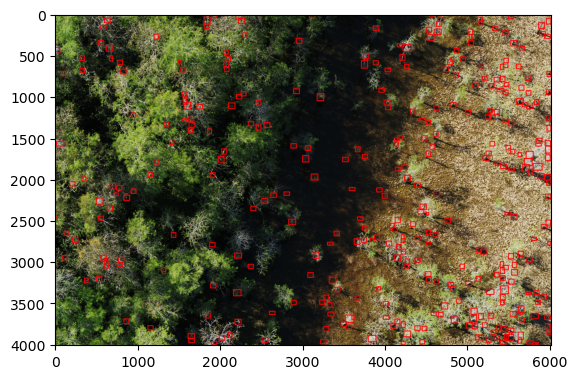

In [18]:
## with default score threshold of
print(f"score threshold: {model.model.score_thresh}")

# Add a path to an image to test the model on
raster_path = "./deep_forest_root/JetportNew_C/JetPortNew_03_029_2022_DJI_0020.JPG"
predicted_raster = model.predict_tile(
    raster_path, return_plot=True, patch_size=400, patch_overlap=0.25, thickness=10, color=(255, 0, 0)
)
plt.imshow(predicted_raster)
plt.show()

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

680 predictions in overlapping windows, applying non-max supression
438 predictions kept after non-max suppression


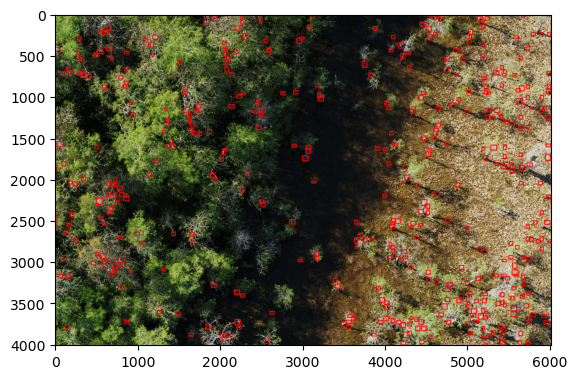

In [24]:

# predict with a model threshold of 0.8  
model.model.score_thresh = 0.8
# Add a path to an image to test the model on
# raster_path = "./deep_forest_root/JetportNew_C/JetPortNew_03_029_2022_DJI_0020.JPG"
predicted_raster = model.predict_tile(
    raster_path, return_plot=True, patch_size=300, patch_overlap=0.25, thickness=10, color=(255, 0, 0)
)
plt.imshow(predicted_raster)
plt.show()

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

554 predictions in overlapping windows, applying non-max supression
367 predictions kept after non-max suppression


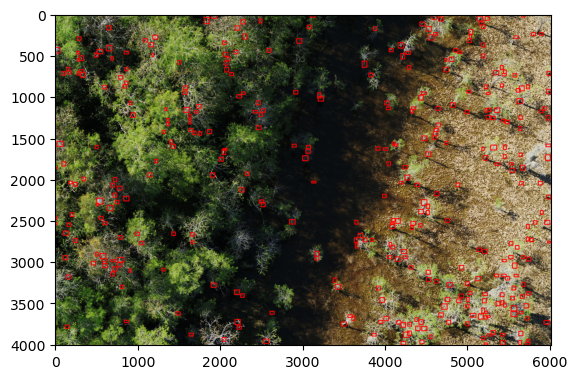

In [25]:
# predict with a model threshold of 0.9
model.model.score_thresh = 0.9
# Add a path to an image to test the model on
# raster_path = "./deep_forest_root/JetportNew_C/JetPortNew_03_029_2022_DJI_0020.JPG"
predicted_raster = model.predict_tile(
    raster_path, return_plot=True, patch_size=300, patch_overlap=0.25, thickness=10, color=(255, 0, 0)
)
plt.imshow(predicted_raster)
plt.show()

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

440 predictions in overlapping windows, applying non-max supression
289 predictions kept after non-max suppression


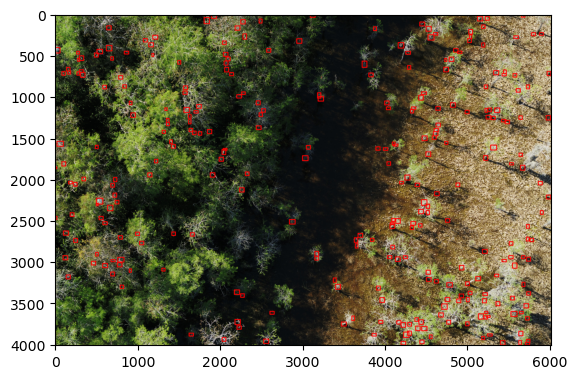

In [26]:
# predict with a model threshold of 0.95 
model.model.score_thresh = 0.95
# Add a path to an image to test the model on
# raster_path = "./deep_forest_root/JetportNew_C/JetPortNew_03_029_2022_DJI_0020.JPG"
predicted_raster = model.predict_tile(
    raster_path, return_plot=True, patch_size=300, patch_overlap=0.25, thickness=10, color=(255, 0, 0)
)
plt.imshow(predicted_raster)
plt.show()

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

267 predictions in overlapping windows, applying non-max supression
182 predictions kept after non-max suppression


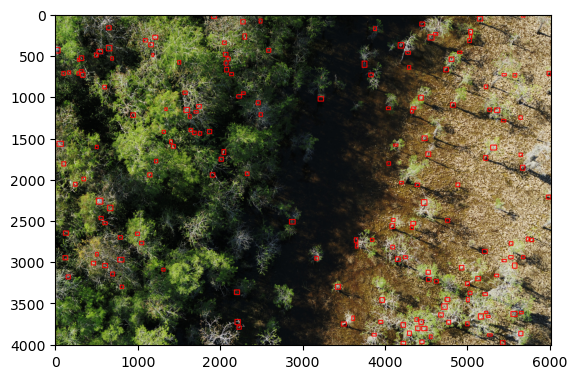

In [27]:
# predict with a model threshold of 0.99
model.model.score_thresh = 0.99
# Add a path to an image to test the model on
# raster_path = "./deep_forest_root/JetportNew_C/JetPortNew_03_029_2022_DJI_0020.JPG"
predicted_raster = model.predict_tile(
    raster_path, return_plot=True, patch_size=300, patch_overlap=0.25, thickness=10, color=(255, 0, 0)
)
plt.imshow(predicted_raster)
plt.show()

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

115 predictions in overlapping windows, applying non-max supression
84 predictions kept after non-max suppression


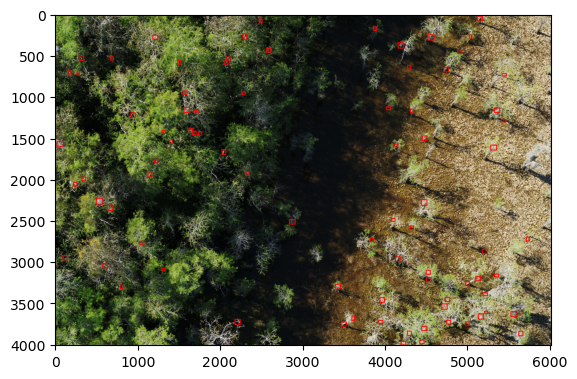

In [29]:
# predict with a model threshold of 0.999
model.model.score_thresh = 0.999
# Add a path to an image to test the model on
# raster_path = "./deep_forest_root/JetportNew_C/JetPortNew_03_029_2022_DJI_0020.JPG"
predicted_raster = model.predict_tile(
    raster_path, return_plot=True, patch_size=300, patch_overlap=0.25, thickness=10, color=(255, 0, 0)
)
plt.imshow(predicted_raster)
plt.show()

In [28]:
# reduce the patch size
predicted_detections = model.predict_tile(
    raster_path, return_plot=False, patch_size=300, patch_overlap=0.25
)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

267 predictions in overlapping windows, applying non-max supression
182 predictions kept after non-max suppression


In [22]:
predicted_detections

xmin    ymin    xmax    ymax label     score  \
0     327.0  1975.0   371.0  2020.0  Nest  1.000000   
1     675.0   518.0   708.0   558.0  Nest  1.000000   
2    2263.0   943.0  2307.0   974.0  Nest  0.999999   
3    2843.0  2488.0  2912.0  2543.0  Nest  0.999998   
4    5625.0  3841.0  5675.0  3896.0  Nest  0.999998   
..      ...     ...     ...     ...   ...       ...   
284  5717.0  2549.0  5751.0  2594.0  Nest  0.952995   
285  5886.0  2380.0  5922.0  2425.0  Nest  0.952891   
286  5184.0  3447.0  5232.0  3497.0  Nest  0.952108   
287  3899.0  3294.0  3946.0  3342.0  Nest  0.951670   
288  4410.0  2366.0  4469.0  2418.0  Nest  0.951484   

                              image_path  
0    JetPortNew_03_029_2022_DJI_0020.JPG  
1    JetPortNew_03_029_2022_DJI_0020.JPG  
2    JetPortNew_03_029_2022_DJI_0020.JPG  
3    JetPortNew_03_029_2022_DJI_0020.JPG  
4    JetPortNew_03_029_2022_DJI_0020.JPG  
..                                   ...  
284  JetPortNew_03_029_2022_DJI_0020.JPG  
285  JetPortNew_03_029_2022_DJI_0020.JPG  
286  JetPortNew_03_029_2022_DJI_0020.JPG  
287  JetPortNew_03_029_2022_DJI_0020.JPG  
288  JetPortNew_03_029_2022_DJI_0020.JPG  

[289 rows x 7 columns]

In [53]:
predicted_detections[predicted_detections.score > 0.8]

xmin    ymin    xmax    ymax label     score  \
0     328.0  1976.0   371.0  2020.0  Nest  0.999614   
1    1126.0  1921.0  1173.0  1975.0  Nest  0.998694   
2    2184.0  3698.0  2246.0  3763.0  Nest  0.997963   
3     500.0  2230.0   580.0  2303.0  Nest  0.997544   
4    4105.0  1575.0  4158.0  1599.0  Nest  0.996505   
..      ...     ...     ...     ...   ...       ...   
190  2206.0  3775.0  2258.0  3815.0  Nest  0.804337   
191  5404.0  3957.0  5455.0  4005.0  Nest  0.803326   
192  4050.0  1932.0  4081.0  1982.0  Nest  0.802801   
193  4141.0  2488.0  4194.0  2537.0  Nest  0.801438   
194  5323.0  1171.0  5385.0  1222.0  Nest  0.800566   

                              image_path  
0    JetPortNew_03_029_2022_DJI_0020.JPG  
1    JetPortNew_03_029_2022_DJI_0020.JPG  
2    JetPortNew_03_029_2022_DJI_0020.JPG  
3    JetPortNew_03_029_2022_DJI_0020.JPG  
4    JetPortNew_03_029_2022_DJI_0020.JPG  
..                                   ...  
190  JetPortNew_03_029_2022_DJI_0020.JPG  
191  JetPortNew_03_029_2022_DJI_0020.JPG  
192  JetPortNew_03_029_2022_DJI_0020.JPG  
193  JetPortNew_03_029_2022_DJI_0020.JPG  
194  JetPortNew_03_029_2022_DJI_0020.JPG  

[195 rows x 7 columns]

In [57]:
import pandas as pd
df_nest_data = pd.read_csv("deep_forest_root/dataset/nest_data.csv")
df_nest_data[df_nest_data.image_path == "Horus_04_27_2022_DJI_0245.JPG"]

image_path         xmin         ymin         xmax  \
1669  Horus_04_27_2022_DJI_0245.JPG  3971.672299  1791.920159  4087.458483   
1670  Horus_04_27_2022_DJI_0245.JPG  3757.512185  2696.331273  3850.634358   
1671  Horus_04_27_2022_DJI_0245.JPG  1224.322310   231.934880  1281.052360   
1672  Horus_04_27_2022_DJI_0245.JPG   983.611382   273.921770  1076.385386   
1673  Horus_04_27_2022_DJI_0245.JPG   103.913153  3869.615597   193.794237   

             ymax label  annotator  
1669  1886.179614  Nest        NaN  
1670  2760.748891  Nest        NaN  
1671   286.455170  Nest        NaN  
1672   358.522220  Nest        NaN  
1673  3950.750562  Nest        NaN

### predict on an orthomosaic
this makes no sense because of the quality of orthomosaic and the general prediction quality

In [58]:



raster_path = "datasets/JetportNew_C.tif"
predicted_detections = model.predict_tile(
    raster_path, return_plot=True, patch_size=300, patch_overlap=0.25
)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

167 predictions in overlapping windows, applying non-max supression
112 predictions kept after non-max suppression


## Have a look at the predictions on an orthomosaic

TODO: because the orthomosaic is that bad there is no point in inferencing on it

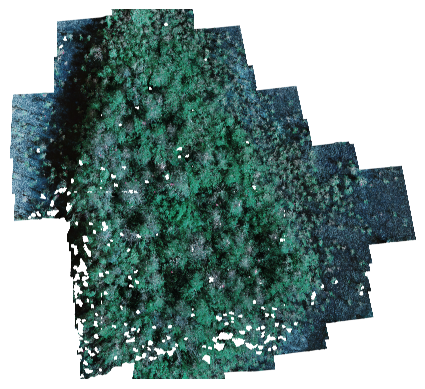

In [63]:
from deepforest import visualize
import supervision as sv
import cv2
import matplotlib.pyplot as plt

# Convert the tree detections to Supervision format for visualization
sv_detections = visualize.convert_to_sv_format(predicted_detections)

# Create a bounding box annotator
bounding_box_annotator = sv.BoxAnnotator()

image_path = "datasets/JetportNew_C.tif"
image = cv2.imread(image_path)

# Annotate the image with bounding boxes
annotated_frame = bounding_box_annotator.annotate(
    scene=image,
    detections=sv_detections
)

from PIL import Image
im = Image.fromarray(annotated_frame)
im.save("datasets/JetportNew_C_predicted.jpeg")

# Display the annotated image using Matplotlib
plt.imshow(annotated_frame)
plt.axis('off')  # Hide axes for a cleaner look
plt.show()

## Evaluate manually

In [69]:
# !unzip "/home/jovyan/deep_forest_root/JetportNew A.zip"
# !mv "/home/jovyan/datasets/JetportNew A" "/home/jovyan/datasets/JetportNew_A"

In [67]:
!pwd

/home/jovyan


In [76]:

# load the modules
import os

from deepforest import main
from pathlib import Path

extract_folder = Path("/home/jovyan/deep_forest_root/JetportNew_C")

model.model.score_thresh = 0.8
predictions = []

for image_name in extract_folder.glob("*.JPG"):

    df_pred = model.predict_tile(
        extract_folder / image_name, return_plot=False, patch_size=400, patch_overlap=0.25
    )
    print(df_pred.sort_values(by="score", ascending=True))
    predictions.append(df_pred)




Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


411 predictions in overlapping windows, applying non-max supression
246 predictions kept after non-max suppression
       xmin    ymin    xmax    ymax label     score  \
245  5058.0  2301.0  5123.0  2358.0  Nest  0.807125   
244  2751.0  1805.0  2814.0  1858.0  Nest  0.813278   
243  1759.0  1559.0  1830.0  1597.0  Nest  0.814476   
242  3901.0  2572.0  3930.0  2622.0  Nest  0.823897   
241  5402.0  3380.0  5463.0  3451.0  Nest  0.824579   
..      ...     ...     ...     ...   ...       ...   
4    4801.0  3901.0  4862.0  3954.0  Nest  0.999996   
3    5105.0  2921.0  5193.0  2996.0  Nest  0.999996   
2    5591.0  2400.0  5655.0  2437.0  Nest  0.999997   
1    2954.0  2128.0  3033.0  2208.0  Nest  0.999998   
0    5751.0  3695.0  5799.0  3743.0  Nest  0.999999   

                              image_path  
245  JetPortNew_03_029_2022_DJI_0239.JPG  
244  JetPortNew_03_029_2022_DJI_0239.JPG  
243  JetPortNew_03_029_2022_DJI_0239.JPG  
242  JetPortNew_03_029_2022_DJI_0239.JPG  
241  JetP

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


336 predictions in overlapping windows, applying non-max supression
215 predictions kept after non-max suppression
       xmin    ymin    xmax    ymax label     score  \
214   900.0   645.0   964.0   698.0  Nest  0.804747   
213  1241.0   886.0  1318.0   956.0  Nest  0.809044   
212  2829.0   856.0  2878.0   905.0  Nest  0.809128   
211   269.0  3406.0   331.0  3452.0  Nest  0.809511   
210   102.0   651.0   165.0   699.0  Nest  0.812748   
..      ...     ...     ...     ...   ...       ...   
4    5366.0  1200.0  5427.0  1237.0  Nest  0.999999   
3    4995.0  3123.0  5053.0  3182.0  Nest  0.999999   
2    5400.0  2790.0  5462.0  2853.0  Nest  0.999999   
1    5435.0  1500.0  5498.0  1544.0  Nest  0.999999   
0    4091.0   747.0  4143.0   804.0  Nest  1.000000   

                              image_path  
214  JetPortNew_03_029_2022_DJI_0179.JPG  
213  JetPortNew_03_029_2022_DJI_0179.JPG  
212  JetPortNew_03_029_2022_DJI_0179.JPG  
211  JetPortNew_03_029_2022_DJI_0179.JPG  
210  JetP

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


199 predictions in overlapping windows, applying non-max supression
122 predictions kept after non-max suppression
       xmin    ymin    xmax    ymax label     score  \
121  2014.0  2466.0  2073.0  2522.0  Nest  0.806836   
120  1202.0  1849.0  1249.0  1919.0  Nest  0.830426   
119  3473.0  1267.0  3527.0  1299.0  Nest  0.837354   
118  2101.0   115.0  2148.0   174.0  Nest  0.843600   
117  2929.0   579.0  2982.0   637.0  Nest  0.861931   
..      ...     ...     ...     ...   ...       ...   
4    1724.0  2991.0  1799.0  3068.0  Nest  0.999999   
3    3982.0   988.0  4077.0  1086.0  Nest  1.000000   
2    2263.0   221.0  2324.0   284.0  Nest  1.000000   
1    4201.0  1100.0  4257.0  1156.0  Nest  1.000000   
0     871.0  1456.0   939.0  1519.0  Nest  1.000000   

                              image_path  
121  JetPortNew_03_029_2022_DJI_0091.JPG  
120  JetPortNew_03_029_2022_DJI_0091.JPG  
119  JetPortNew_03_029_2022_DJI_0091.JPG  
118  JetPortNew_03_029_2022_DJI_0091.JPG  
117  JetP

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


242 predictions in overlapping windows, applying non-max supression
158 predictions kept after non-max suppression
       xmin    ymin    xmax    ymax label     score  \
157  2235.0  3146.0  2304.0  3205.0  Nest  0.813552   
156   196.0  1207.0   262.0  1257.0  Nest  0.816954   
155  2006.0  3123.0  2079.0  3205.0  Nest  0.829820   
154  4327.0  1282.0  4395.0  1350.0  Nest  0.833924   
153   541.0  2086.0   597.0  2150.0  Nest  0.833966   
..      ...     ...     ...     ...   ...       ...   
4    5616.0  3868.0  5668.0  3927.0  Nest  0.999996   
3    5101.0  3452.0  5150.0  3510.0  Nest  0.999998   
2    4953.0  2202.0  5026.0  2276.0  Nest  0.999998   
1    2459.0  1700.0  2516.0  1754.0  Nest  0.999998   
0    1597.0  2580.0  1676.0  2663.0  Nest  1.000000   

                              image_path  
157  JetPortNew_03_029_2022_DJI_0107.JPG  
156  JetPortNew_03_029_2022_DJI_0107.JPG  
155  JetPortNew_03_029_2022_DJI_0107.JPG  
154  JetPortNew_03_029_2022_DJI_0107.JPG  
153  JetP

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


331 predictions in overlapping windows, applying non-max supression
192 predictions kept after non-max suppression
       xmin    ymin    xmax    ymax label     score  \
191  4583.0    79.0  4660.0   147.0  Nest  0.811445   
190   401.0  2189.0   462.0  2249.0  Nest  0.817764   
189   941.0   248.0   997.0   309.0  Nest  0.818807   
188   782.0  3578.0   848.0  3626.0  Nest  0.820474   
187  4549.0   389.0  4595.0   465.0  Nest  0.821496   
..      ...     ...     ...     ...   ...       ...   
4    3260.0  2155.0  3332.0  2198.0  Nest  1.000000   
3    2876.0   461.0  2944.0   517.0  Nest  1.000000   
2    3952.0  3682.0  4036.0  3767.0  Nest  1.000000   
1    3188.0  1831.0  3258.0  1899.0  Nest  1.000000   
0    2385.0  1063.0  2436.0  1115.0  Nest  1.000000   

                              image_path  
191  JetPortNew_03_029_2022_DJI_0165.JPG  
190  JetPortNew_03_029_2022_DJI_0165.JPG  
189  JetPortNew_03_029_2022_DJI_0165.JPG  
188  JetPortNew_03_029_2022_DJI_0165.JPG  
187  JetP

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


204 predictions in overlapping windows, applying non-max supression
125 predictions kept after non-max suppression
       xmin    ymin    xmax    ymax label     score  \
124  2721.0  2611.0  2777.0  2667.0  Nest  0.804216   
123   747.0  3760.0   805.0  3815.0  Nest  0.808400   
122  5339.0   564.0  5411.0   631.0  Nest  0.815179   
121  2970.0  2108.0  3026.0  2154.0  Nest  0.821275   
120  5913.0   513.0  5980.0   564.0  Nest  0.845068   
..      ...     ...     ...     ...   ...       ...   
4    3922.0  2626.0  3977.0  2679.0  Nest  0.999996   
3    1692.0  3107.0  1760.0  3167.0  Nest  0.999996   
2    2055.0   574.0  2129.0   629.0  Nest  0.999999   
1    1630.0   552.0  1715.0   642.0  Nest  1.000000   
0    2772.0   893.0  2869.0   975.0  Nest  1.000000   

                              image_path  
124  JetPortNew_03_029_2022_DJI_0093.JPG  
123  JetPortNew_03_029_2022_DJI_0093.JPG  
122  JetPortNew_03_029_2022_DJI_0093.JPG  
121  JetPortNew_03_029_2022_DJI_0093.JPG  
120  JetP

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


337 predictions in overlapping windows, applying non-max supression
214 predictions kept after non-max suppression
       xmin    ymin    xmax    ymax label     score  \
213  2812.0   513.0  2872.0   567.0  Nest  0.802741   
212  2348.0  1373.0  2410.0  1430.0  Nest  0.812180   
211  3859.0  3155.0  3927.0  3219.0  Nest  0.819461   
210  5890.0  3648.0  5963.0  3691.0  Nest  0.833046   
209   530.0     2.0   593.0    51.0  Nest  0.836718   
..      ...     ...     ...     ...   ...       ...   
4     693.0  1800.0   755.0  1846.0  Nest  0.999995   
3    2719.0   789.0  2797.0   877.0  Nest  0.999998   
2    2824.0   639.0  2905.0   718.0  Nest  0.999999   
1    1501.0  2180.0  1563.0  2247.0  Nest  0.999999   
0    1264.0  2081.0  1358.0  2168.0  Nest  1.000000   

                              image_path  
213  JetPortNew_03_029_2022_DJI_0022.JPG  
212  JetPortNew_03_029_2022_DJI_0022.JPG  
211  JetPortNew_03_029_2022_DJI_0022.JPG  
210  JetPortNew_03_029_2022_DJI_0022.JPG  
209  JetP

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


273 predictions in overlapping windows, applying non-max supression
167 predictions kept after non-max suppression
       xmin    ymin    xmax    ymax label     score  \
166  1683.0  1001.0  1741.0  1054.0  Nest  0.802030   
165  3224.0  2429.0  3282.0  2484.0  Nest  0.803456   
164  1846.0  1102.0  1919.0  1153.0  Nest  0.808884   
163  4223.0  3617.0  4297.0  3694.0  Nest  0.810802   
162   887.0  1511.0   947.0  1559.0  Nest  0.811823   
..      ...     ...     ...     ...   ...       ...   
4     202.0  1902.0   309.0  2002.0  Nest  1.000000   
3     534.0  1466.0   612.0  1541.0  Nest  1.000000   
2    1975.0  3271.0  2028.0  3318.0  Nest  1.000000   
1    1591.0   615.0  1671.0   693.0  Nest  1.000000   
0     891.0    27.0   973.0   102.0  Nest  1.000000   

                              image_path  
166  JetPortNew_03_029_2022_DJI_0103.JPG  
165  JetPortNew_03_029_2022_DJI_0103.JPG  
164  JetPortNew_03_029_2022_DJI_0103.JPG  
163  JetPortNew_03_029_2022_DJI_0103.JPG  
162  JetP

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


156 predictions in overlapping windows, applying non-max supression
95 predictions kept after non-max suppression
      xmin    ymin    xmax    ymax label     score  \
94  5624.0   940.0  5689.0   992.0  Nest  0.819652   
93   452.0  1663.0   526.0  1726.0  Nest  0.836424   
92  5840.0  3650.0  5912.0  3721.0  Nest  0.848636   
91  5853.0  1301.0  5911.0  1355.0  Nest  0.867027   
90  4077.0  1401.0  4134.0  1461.0  Nest  0.867847   
..     ...     ...     ...     ...   ...       ...   
4   4754.0  3608.0  4823.0  3668.0  Nest  0.999990   
3   5134.0   145.0  5217.0   217.0  Nest  0.999997   
2    439.0  2855.0   495.0  2903.0  Nest  1.000000   
1   5751.0  3234.0  5799.0  3290.0  Nest  1.000000   
0   3474.0  3151.0  3526.0  3203.0  Nest  1.000000   

                             image_path  
94  JetPortNew_03_029_2022_DJI_0108.JPG  
93  JetPortNew_03_029_2022_DJI_0108.JPG  
92  JetPortNew_03_029_2022_DJI_0108.JPG  
91  JetPortNew_03_029_2022_DJI_0108.JPG  
90  JetPortNew_03_029_2022_

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


290 predictions in overlapping windows, applying non-max supression
169 predictions kept after non-max suppression
       xmin    ymin    xmax    ymax label     score  \
168  5270.0  3928.0  5347.0  3997.0  Nest  0.801000   
167   106.0  3669.0   166.0  3698.0  Nest  0.802143   
166  4658.0  2170.0  4728.0  2245.0  Nest  0.805067   
165  4681.0  3957.0  4734.0  4006.0  Nest  0.815716   
164  4856.0  3977.0  4895.0  4006.0  Nest  0.825950   
..      ...     ...     ...     ...   ...       ...   
4    3675.0  3042.0  3749.0  3110.0  Nest  1.000000   
3    2245.0  3302.0  2308.0  3362.0  Nest  1.000000   
2    3951.0  1543.0  4000.0  1597.0  Nest  1.000000   
1    2410.0  2702.0  2493.0  2781.0  Nest  1.000000   
0    1729.0  3765.0  1790.0  3834.0  Nest  1.000000   

                              image_path  
168  JetPortNew_03_029_2022_DJI_0163.JPG  
167  JetPortNew_03_029_2022_DJI_0163.JPG  
166  JetPortNew_03_029_2022_DJI_0163.JPG  
165  JetPortNew_03_029_2022_DJI_0163.JPG  
164  JetP

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


335 predictions in overlapping windows, applying non-max supression
205 predictions kept after non-max suppression
       xmin    ymin    xmax    ymax label     score  \
204  4592.0   853.0  4651.0   906.0  Nest  0.806117   
203  2913.0  2051.0  2964.0  2103.0  Nest  0.813178   
202  2338.0  2742.0  2390.0  2789.0  Nest  0.820823   
201  2359.0  3916.0  2418.0  3969.0  Nest  0.822005   
200   458.0  3387.0   506.0  3439.0  Nest  0.826277   
..      ...     ...     ...     ...   ...       ...   
4    5409.0   723.0  5478.0   797.0  Nest  0.999997   
3    5647.0   307.0  5729.0   387.0  Nest  0.999999   
2    3401.0  3713.0  3479.0  3781.0  Nest  1.000000   
1    4993.0   854.0  5052.0   909.0  Nest  1.000000   
0    4075.0  1865.0  4135.0  1928.0  Nest  1.000000   

                              image_path  
204  JetPortNew_03_029_2022_DJI_0180.JPG  
203  JetPortNew_03_029_2022_DJI_0180.JPG  
202  JetPortNew_03_029_2022_DJI_0180.JPG  
201  JetPortNew_03_029_2022_DJI_0180.JPG  
200  JetP

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


194 predictions in overlapping windows, applying non-max supression
112 predictions kept after non-max suppression
       xmin    ymin    xmax    ymax label     score  \
111   984.0  1990.0  1048.0  2047.0  Nest  0.801539   
110  4863.0  2508.0  4925.0  2567.0  Nest  0.806334   
109  4800.0  3931.0  4853.0  3984.0  Nest  0.806446   
108  1500.0   269.0  1519.0   308.0  Nest  0.807841   
107   756.0  2165.0   825.0  2225.0  Nest  0.822602   
..      ...     ...     ...     ...   ...       ...   
4    3788.0  3030.0  3852.0  3089.0  Nest  0.999994   
3    2401.0  3036.0  2443.0  3096.0  Nest  0.999997   
2    4281.0  3392.0  4361.0  3491.0  Nest  0.999998   
1    2400.0  3946.0  2451.0  3998.0  Nest  1.000000   
0    5403.0  3662.0  5458.0  3711.0  Nest  1.000000   

                              image_path  
111  JetPortNew_03_029_2022_DJI_0162.JPG  
110  JetPortNew_03_029_2022_DJI_0162.JPG  
109  JetPortNew_03_029_2022_DJI_0162.JPG  
108  JetPortNew_03_029_2022_DJI_0162.JPG  
107  JetP

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


291 predictions in overlapping windows, applying non-max supression
183 predictions kept after non-max suppression
       xmin    ymin    xmax    ymax label     score  \
182  1609.0  3367.0  1673.0  3423.0  Nest  0.800519   
181  2087.0   487.0  2175.0   560.0  Nest  0.807458   
180   656.0  2541.0   698.0  2613.0  Nest  0.810514   
179  5778.0  2060.0  5843.0  2115.0  Nest  0.822161   
178  3791.0  1444.0  3848.0  1496.0  Nest  0.823245   
..      ...     ...     ...     ...   ...       ...   
4      50.0  1459.0   115.0  1517.0  Nest  0.999999   
3    3720.0  1517.0  3766.0  1577.0  Nest  0.999999   
2    1758.0   178.0  1835.0   264.0  Nest  0.999999   
1    5448.0  1199.0  5497.0  1246.0  Nest  1.000000   
0    2510.0  2035.0  2598.0  2112.0  Nest  1.000000   

                              image_path  
182  JetPortNew_03_029_2022_DJI_0105.JPG  
181  JetPortNew_03_029_2022_DJI_0105.JPG  
180  JetPortNew_03_029_2022_DJI_0105.JPG  
179  JetPortNew_03_029_2022_DJI_0105.JPG  
178  JetP

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


320 predictions in overlapping windows, applying non-max supression
185 predictions kept after non-max suppression
       xmin    ymin    xmax    ymax label     score  \
184  4574.0  3367.0  4641.0  3398.0  Nest  0.814079   
183   905.0   313.0   969.0   380.0  Nest  0.833530   
182   744.0  1305.0   804.0  1358.0  Nest  0.839477   
181  1352.0  1099.0  1430.0  1170.0  Nest  0.840410   
180   992.0   860.0  1054.0   916.0  Nest  0.841522   
..      ...     ...     ...     ...   ...       ...   
4    3655.0  1802.0  3707.0  1855.0  Nest  0.999999   
3    4214.0  3551.0  4288.0  3612.0  Nest  1.000000   
2    3001.0  1431.0  3058.0  1483.0  Nest  1.000000   
1    3005.0  1200.0  3082.0  1271.0  Nest  1.000000   
0    2763.0  3149.0  2823.0  3198.0  Nest  1.000000   

                              image_path  
184  JetPortNew_03_029_2022_DJI_0167.JPG  
183  JetPortNew_03_029_2022_DJI_0167.JPG  
182  JetPortNew_03_029_2022_DJI_0167.JPG  
181  JetPortNew_03_029_2022_DJI_0167.JPG  
180  JetP

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


317 predictions in overlapping windows, applying non-max supression
183 predictions kept after non-max suppression
       xmin    ymin    xmax    ymax label     score  \
182  1507.0   384.0  1566.0   438.0  Nest  0.810801   
181  2539.0  1992.0  2592.0  2043.0  Nest  0.815108   
180  4027.0   184.0  4083.0   231.0  Nest  0.818649   
179   746.0  2211.0   808.0  2268.0  Nest  0.828707   
178  1836.0  2712.0  1894.0  2771.0  Nest  0.830656   
..      ...     ...     ...     ...   ...       ...   
4    3674.0   754.0  3723.0   802.0  Nest  0.999997   
3    2741.0   320.0  2843.0   400.0  Nest  0.999998   
2    5440.0  3254.0  5497.0  3306.0  Nest  1.000000   
1    5641.0  1561.0  5692.0  1617.0  Nest  1.000000   
0    3043.0    84.0  3124.0   155.0  Nest  1.000000   

                              image_path  
182  JetPortNew_03_029_2022_DJI_0168.JPG  
181  JetPortNew_03_029_2022_DJI_0168.JPG  
180  JetPortNew_03_029_2022_DJI_0168.JPG  
179  JetPortNew_03_029_2022_DJI_0168.JPG  
178  JetP

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


229 predictions in overlapping windows, applying non-max supression
157 predictions kept after non-max suppression
       xmin    ymin    xmax    ymax label     score  \
156  5702.0   449.0  5756.0   503.0  Nest  0.803332   
155  3670.0  3354.0  3699.0  3404.0  Nest  0.809651   
154  2300.0  2832.0  2357.0  2902.0  Nest  0.810121   
153   657.0  2666.0   727.0  2721.0  Nest  0.813494   
152  1274.0   740.0  1352.0   816.0  Nest  0.819489   
..      ...     ...     ...     ...   ...       ...   
4    5100.0  2720.0  5164.0  2792.0  Nest  0.999993   
3    1437.0  1487.0  1511.0  1555.0  Nest  0.999995   
2    4057.0  3198.0  4109.0  3248.0  Nest  0.999995   
1    4304.0  2883.0  4359.0  2934.0  Nest  0.999996   
0    5139.0   143.0  5207.0   207.0  Nest  1.000000   

                              image_path  
156  JetPortNew_03_029_2022_DJI_0169.JPG  
155  JetPortNew_03_029_2022_DJI_0169.JPG  
154  JetPortNew_03_029_2022_DJI_0169.JPG  
153  JetPortNew_03_029_2022_DJI_0169.JPG  
152  JetP

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


324 predictions in overlapping windows, applying non-max supression
193 predictions kept after non-max suppression
       xmin    ymin    xmax    ymax label     score  \
192  1138.0  3342.0  1213.0  3411.0  Nest  0.816824   
191   812.0  3966.0   863.0  3999.0  Nest  0.817391   
190  2774.0  3040.0  2828.0  3097.0  Nest  0.829527   
189   889.0    65.0   949.0   119.0  Nest  0.833208   
188  3268.0  1959.0  3327.0  2013.0  Nest  0.845296   
..      ...     ...     ...     ...   ...       ...   
4    5450.0   923.0  5497.0   976.0  Nest  0.999999   
3    4046.0  2748.0  4128.0  2831.0  Nest  1.000000   
2    4053.0  2602.0  4122.0  2667.0  Nest  1.000000   
1    3865.0  2640.0  3942.0  2738.0  Nest  1.000000   
0    2467.0  3356.0  2549.0  3440.0  Nest  1.000000   

                              image_path  
192  JetPortNew_03_029_2022_DJI_0106.JPG  
191  JetPortNew_03_029_2022_DJI_0106.JPG  
190  JetPortNew_03_029_2022_DJI_0106.JPG  
189  JetPortNew_03_029_2022_DJI_0106.JPG  
188  JetP

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


188 predictions in overlapping windows, applying non-max supression
130 predictions kept after non-max suppression
       xmin    ymin    xmax    ymax label     score  \
129  2781.0  2282.0  2834.0  2339.0  Nest  0.811021   
128  1770.0  1003.0  1833.0  1059.0  Nest  0.811288   
127  2400.0  3975.0  2449.0  4006.0  Nest  0.815505   
126  2824.0   225.0  2876.0   285.0  Nest  0.820229   
125   826.0  3791.0   904.0  3859.0  Nest  0.830210   
..      ...     ...     ...     ...   ...       ...   
4    2102.0   654.0  2152.0   699.0  Nest  0.999984   
3    3889.0  2060.0  3956.0  2115.0  Nest  0.999992   
2    5056.0  1537.0  5130.0  1616.0  Nest  0.999996   
1      40.0    50.0   119.0   132.0  Nest  0.999998   
0    3606.0  1400.0  3688.0  1471.0  Nest  1.000000   

                              image_path  
129  JetPortNew_03_029_2022_DJI_0170.JPG  
128  JetPortNew_03_029_2022_DJI_0170.JPG  
127  JetPortNew_03_029_2022_DJI_0170.JPG  
126  JetPortNew_03_029_2022_DJI_0170.JPG  
125  JetP

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


199 predictions in overlapping windows, applying non-max supression
126 predictions kept after non-max suppression
       xmin    ymin    xmax    ymax label     score  \
125  2310.0  3142.0  2363.0  3189.0  Nest  0.805041   
124   811.0   742.0   872.0   803.0  Nest  0.809109   
123  5897.0   791.0  5967.0   848.0  Nest  0.814228   
122  4275.0  2064.0  4347.0  2121.0  Nest  0.819691   
121  5762.0  1098.0  5828.0  1156.0  Nest  0.820491   
..      ...     ...     ...     ...   ...       ...   
4    2005.0  3750.0  2062.0  3803.0  Nest  0.999999   
3    5036.0  3852.0  5090.0  3902.0  Nest  1.000000   
2     903.0   210.0   970.0   275.0  Nest  1.000000   
1     666.0   229.0   761.0   308.0  Nest  1.000000   
0     351.0   668.0   461.0   764.0  Nest  1.000000   

                              image_path  
125  JetPortNew_03_029_2022_DJI_0102.JPG  
124  JetPortNew_03_029_2022_DJI_0102.JPG  
123  JetPortNew_03_029_2022_DJI_0102.JPG  
122  JetPortNew_03_029_2022_DJI_0102.JPG  
121  JetP

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


254 predictions in overlapping windows, applying non-max supression
156 predictions kept after non-max suppression
       xmin    ymin    xmax    ymax label     score  \
155  4975.0  3495.0  5034.0  3549.0  Nest  0.805439   
154  1801.0  2742.0  1829.0  2785.0  Nest  0.821979   
153  2402.0  3616.0  2459.0  3677.0  Nest  0.824666   
152  3775.0  1440.0  3840.0  1503.0  Nest  0.843454   
151  3397.0   652.0  3450.0   694.0  Nest  0.851307   
..      ...     ...     ...     ...   ...       ...   
4    2292.0  1202.0  2359.0  1270.0  Nest  0.999998   
3    2467.0  3609.0  2544.0  3686.0  Nest  0.999998   
2    4663.0  1019.0  4713.0  1069.0  Nest  1.000000   
1    4210.0  2388.0  4282.0  2453.0  Nest  1.000000   
0    2141.0   920.0  2200.0   975.0  Nest  1.000000   

                              image_path  
155  JetPortNew_03_029_2022_DJI_0090.JPG  
154  JetPortNew_03_029_2022_DJI_0090.JPG  
153  JetPortNew_03_029_2022_DJI_0090.JPG  
152  JetPortNew_03_029_2022_DJI_0090.JPG  
151  JetP

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


371 predictions in overlapping windows, applying non-max supression
232 predictions kept after non-max suppression
       xmin    ymin    xmax    ymax label     score  \
231  2652.0  2566.0  2726.0  2626.0  Nest  0.800179   
230  1206.0   684.0  1257.0   738.0  Nest  0.805341   
229  2889.0   565.0  2943.0   626.0  Nest  0.807995   
228  2676.0  1502.0  2734.0  1562.0  Nest  0.820887   
227  4133.0  3968.0  4191.0  3999.0  Nest  0.820895   
..      ...     ...     ...     ...   ...       ...   
4    3901.0  3658.0  3959.0  3699.0  Nest  0.999999   
3    5288.0  1647.0  5345.0  1699.0  Nest  1.000000   
2    5460.0  3073.0  5514.0  3121.0  Nest  1.000000   
1    5150.0  3529.0  5199.0  3582.0  Nest  1.000000   
0    5027.0  1886.0  5117.0  1967.0  Nest  1.000000   

                              image_path  
231  JetPortNew_03_029_2022_DJI_0178.JPG  
230  JetPortNew_03_029_2022_DJI_0178.JPG  
229  JetPortNew_03_029_2022_DJI_0178.JPG  
228  JetPortNew_03_029_2022_DJI_0178.JPG  
227  JetP

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


370 predictions in overlapping windows, applying non-max supression
225 predictions kept after non-max suppression
       xmin    ymin    xmax    ymax label     score  \
224  5102.0  2284.0  5141.0  2332.0  Nest  0.808338   
223  5057.0  3753.0  5128.0  3805.0  Nest  0.818815   
222   521.0  3857.0   586.0  3910.0  Nest  0.826369   
221  4501.0   601.0  4554.0   650.0  Nest  0.833518   
220  4257.0   788.0  4322.0   852.0  Nest  0.835271   
..      ...     ...     ...     ...   ...       ...   
4    3301.0  3356.0  3361.0  3413.0  Nest  0.999996   
3    4802.0  2701.0  4870.0  2775.0  Nest  0.999997   
2    5960.0  3627.0  6014.0  3681.0  Nest  0.999999   
1     799.0   348.0   856.0   399.0  Nest  0.999999   
0    2441.0  2073.0  2512.0  2139.0  Nest  0.999999   

                              image_path  
224  JetPortNew_03_029_2022_DJI_0238.JPG  
223  JetPortNew_03_029_2022_DJI_0238.JPG  
222  JetPortNew_03_029_2022_DJI_0238.JPG  
221  JetPortNew_03_029_2022_DJI_0238.JPG  
220  JetP

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


269 predictions in overlapping windows, applying non-max supression
164 predictions kept after non-max suppression
       xmin    ymin    xmax    ymax label     score  \
163  3228.0   965.0  3304.0  1000.0  Nest  0.800010   
162  5273.0  3814.0  5342.0  3876.0  Nest  0.801544   
161  5007.0   498.0  5066.0   559.0  Nest  0.809434   
160  5423.0   306.0  5491.0   359.0  Nest  0.841699   
159  2975.0   120.0  3029.0   175.0  Nest  0.846141   
..      ...     ...     ...     ...   ...       ...   
4    4632.0   600.0  4696.0   646.0  Nest  0.999996   
3    1292.0  2879.0  1376.0  2966.0  Nest  0.999996   
2    2859.0  2555.0  2938.0  2620.0  Nest  0.999997   
1    5360.0  3301.0  5421.0  3363.0  Nest  1.000000   
0     719.0  1618.0   772.0  1666.0  Nest  1.000000   

                              image_path  
163  JetPortNew_03_029_2022_DJI_0085.JPG  
162  JetPortNew_03_029_2022_DJI_0085.JPG  
161  JetPortNew_03_029_2022_DJI_0085.JPG  
160  JetPortNew_03_029_2022_DJI_0085.JPG  
159  JetP

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


312 predictions in overlapping windows, applying non-max supression
180 predictions kept after non-max suppression
       xmin    ymin    xmax    ymax label     score  \
179  5008.0  2284.0  5068.0  2335.0  Nest  0.800768   
178   517.0   195.0   587.0   255.0  Nest  0.805085   
177  2533.0  1571.0  2585.0  1623.0  Nest  0.805522   
176  3666.0   799.0  3735.0   843.0  Nest  0.810802   
175  5316.0  3740.0  5395.0  3813.0  Nest  0.814117   
..      ...     ...     ...     ...   ...       ...   
4    4138.0   825.0  4192.0   873.0  Nest  0.999999   
3    5490.0  3649.0  5563.0  3725.0  Nest  1.000000   
2    2115.0  3734.0  2165.0  3783.0  Nest  1.000000   
1    5021.0  3868.0  5077.0  3917.0  Nest  1.000000   
0    2040.0  3126.0  2110.0  3197.0  Nest  1.000000   

                              image_path  
179  JetPortNew_03_029_2022_DJI_0088.JPG  
178  JetPortNew_03_029_2022_DJI_0088.JPG  
177  JetPortNew_03_029_2022_DJI_0088.JPG  
176  JetPortNew_03_029_2022_DJI_0088.JPG  
175  JetP

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


217 predictions in overlapping windows, applying non-max supression
133 predictions kept after non-max suppression
       xmin    ymin    xmax    ymax label     score  \
132  5686.0   439.0  5758.0   507.0  Nest  0.810617   
131  3842.0  1501.0  3897.0  1546.0  Nest  0.826111   
130  4310.0   914.0  4386.0   980.0  Nest  0.835299   
129   697.0  3310.0   762.0  3363.0  Nest  0.836080   
128  2726.0  2102.0  2762.0  2132.0  Nest  0.837207   
..      ...     ...     ...     ...   ...       ...   
4    4039.0  3705.0  4098.0  3766.0  Nest  0.999997   
3    2562.0  3237.0  2623.0  3292.0  Nest  1.000000   
2    5160.0  3166.0  5242.0  3245.0  Nest  1.000000   
1    5150.0   236.0  5199.0   294.0  Nest  1.000000   
0    5752.0   654.0  5800.0   700.0  Nest  1.000000   

                              image_path  
132  JetPortNew_03_029_2022_DJI_0101.JPG  
131  JetPortNew_03_029_2022_DJI_0101.JPG  
130  JetPortNew_03_029_2022_DJI_0101.JPG  
129  JetPortNew_03_029_2022_DJI_0101.JPG  
128  JetP

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


449 predictions in overlapping windows, applying non-max supression
285 predictions kept after non-max suppression
       xmin    ymin    xmax    ymax label     score  \
284  5400.0   444.0  5451.0   507.0  Nest  0.801631   
283  5790.0  2614.0  5864.0  2668.0  Nest  0.806730   
282  4876.0   638.0  4941.0   693.0  Nest  0.809661   
281  4583.0  3392.0  4659.0  3451.0  Nest  0.820091   
280  4954.0  2481.0  5009.0  2540.0  Nest  0.820928   
..      ...     ...     ...     ...   ...       ...   
4    2368.0   714.0  2449.0   788.0  Nest  0.999993   
3    2511.0   991.0  2588.0  1065.0  Nest  0.999995   
2    4957.0   600.0  5028.0   633.0  Nest  0.999999   
1    2452.0  1854.0  2497.0  1899.0  Nest  0.999999   
0    4800.0  2401.0  4855.0  2453.0  Nest  0.999999   

                              image_path  
284  JetPortNew_03_029_2022_DJI_0027.JPG  
283  JetPortNew_03_029_2022_DJI_0027.JPG  
282  JetPortNew_03_029_2022_DJI_0027.JPG  
281  JetPortNew_03_029_2022_DJI_0027.JPG  
280  JetP

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


325 predictions in overlapping windows, applying non-max supression
201 predictions kept after non-max suppression
       xmin    ymin    xmax    ymax label     score  \
200   575.0  3302.0   631.0  3358.0  Nest  0.803371   
199  5657.0  3122.0  5712.0  3181.0  Nest  0.804068   
198   533.0   201.0   597.0   260.0  Nest  0.808715   
197   314.0  1370.0   395.0  1434.0  Nest  0.808957   
196  5087.0   412.0  5140.0   472.0  Nest  0.810722   
..      ...     ...     ...     ...   ...       ...   
4    2622.0  2637.0  2724.0  2732.0  Nest  1.000000   
3    3076.0   808.0  3135.0   873.0  Nest  1.000000   
2    2440.0    83.0  2495.0   134.0  Nest  1.000000   
1    3641.0  2909.0  3693.0  2964.0  Nest  1.000000   
0    3000.0  2400.0  3046.0  2453.0  Nest  1.000000   

                              image_path  
200  JetPortNew_03_029_2022_DJI_0166.JPG  
199  JetPortNew_03_029_2022_DJI_0166.JPG  
198  JetPortNew_03_029_2022_DJI_0166.JPG  
197  JetPortNew_03_029_2022_DJI_0166.JPG  
196  JetP

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


341 predictions in overlapping windows, applying non-max supression
194 predictions kept after non-max suppression
       xmin    ymin    xmax    ymax label     score  \
193  2731.0   116.0  2789.0   173.0  Nest  0.806039   
192  2039.0  1986.0  2112.0  2053.0  Nest  0.809283   
191   113.0  2375.0   172.0  2427.0  Nest  0.820939   
190  5854.0   828.0  5917.0   879.0  Nest  0.823026   
189  4373.0  3694.0  4438.0  3754.0  Nest  0.824623   
..      ...     ...     ...     ...   ...       ...   
4    2478.0  2644.0  2541.0  2706.0  Nest  0.999999   
3    1656.0  1379.0  1738.0  1454.0  Nest  0.999999   
2    3340.0  3608.0  3397.0  3656.0  Nest  0.999999   
1    1816.0   900.0  1881.0   937.0  Nest  1.000000   
0    2400.0  2677.0  2452.0  2730.0  Nest  1.000000   

                              image_path  
193  JetPortNew_03_029_2022_DJI_0095.JPG  
192  JetPortNew_03_029_2022_DJI_0095.JPG  
191  JetPortNew_03_029_2022_DJI_0095.JPG  
190  JetPortNew_03_029_2022_DJI_0095.JPG  
189  JetP

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


203 predictions in overlapping windows, applying non-max supression
133 predictions kept after non-max suppression
       xmin    ymin    xmax    ymax label     score  \
132  1360.0  2136.0  1433.0  2189.0  Nest  0.802503   
131  3217.0  1869.0  3270.0  1899.0  Nest  0.807334   
130  5759.0  1248.0  5800.0  1296.0  Nest  0.816847   
129  3948.0  1800.0  4003.0  1832.0  Nest  0.828236   
128    44.0  3710.0   105.0  3767.0  Nest  0.828241   
..      ...     ...     ...     ...   ...       ...   
4    4940.0  2416.0  5023.0  2487.0  Nest  0.999998   
3    5262.0   678.0  5345.0   749.0  Nest  0.999998   
2    3954.0  2888.0  4027.0  2950.0  Nest  0.999999   
1    4490.0  2734.0  4537.0  2791.0  Nest  0.999999   
0    3677.0  1248.0  3737.0  1298.0  Nest  1.000000   

                              image_path  
132  JetPortNew_03_029_2022_DJI_0098.JPG  
131  JetPortNew_03_029_2022_DJI_0098.JPG  
130  JetPortNew_03_029_2022_DJI_0098.JPG  
129  JetPortNew_03_029_2022_DJI_0098.JPG  
128  JetP

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


194 predictions in overlapping windows, applying non-max supression
119 predictions kept after non-max suppression
       xmin    ymin    xmax    ymax label     score  \
118  3184.0   300.0  3242.0   364.0  Nest  0.800312   
117  5820.0  2530.0  5881.0  2586.0  Nest  0.808178   
116  5833.0  1565.0  5907.0  1626.0  Nest  0.821469   
115  5136.0  1735.0  5195.0  1789.0  Nest  0.821886   
114  4505.0   210.0  4565.0   274.0  Nest  0.824276   
..      ...     ...     ...     ...   ...       ...   
4    2741.0  3964.0  2798.0  4007.0  Nest  0.999993   
3     636.0  1424.0   689.0  1479.0  Nest  0.999995   
2     698.0   765.0   750.0   823.0  Nest  0.999997   
1    2384.0  3330.0  2442.0  3383.0  Nest  0.999998   
0    4881.0  2125.0  4936.0  2175.0  Nest  0.999999   

                              image_path  
118  JetPortNew_03_029_2022_DJI_0084.JPG  
117  JetPortNew_03_029_2022_DJI_0084.JPG  
116  JetPortNew_03_029_2022_DJI_0084.JPG  
115  JetPortNew_03_029_2022_DJI_0084.JPG  
114  JetP

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


308 predictions in overlapping windows, applying non-max supression
196 predictions kept after non-max suppression
       xmin    ymin    xmax    ymax label     score  \
195  3320.0   601.0  3378.0   644.0  Nest  0.801650   
194  3962.0  1907.0  3998.0  1950.0  Nest  0.802661   
193  4526.0  1245.0  4585.0  1293.0  Nest  0.818724   
192  4141.0  3308.0  4197.0  3360.0  Nest  0.829158   
191  3132.0  1835.0  3201.0  1894.0  Nest  0.831650   
..      ...     ...     ...     ...   ...       ...   
4    5616.0   243.0  5682.0   317.0  Nest  0.999998   
3    5005.0   680.0  5092.0   752.0  Nest  0.999999   
2    4257.0  1226.0  4298.0  1294.0  Nest  0.999999   
1    5742.0  3867.0  5798.0  3923.0  Nest  1.000000   
0    5026.0  1509.0  5072.0  1560.0  Nest  1.000000   

                              image_path  
195  JetPortNew_03_029_2022_DJI_0177.JPG  
194  JetPortNew_03_029_2022_DJI_0177.JPG  
193  JetPortNew_03_029_2022_DJI_0177.JPG  
192  JetPortNew_03_029_2022_DJI_0177.JPG  
191  JetP

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


350 predictions in overlapping windows, applying non-max supression
210 predictions kept after non-max suppression
       xmin    ymin    xmax    ymax label     score  \
209  2794.0  3715.0  2858.0  3765.0  Nest  0.800092   
208  2102.0  2647.0  2145.0  2697.0  Nest  0.800786   
207  4750.0  3930.0  4822.0  3984.0  Nest  0.802786   
206  5567.0  3157.0  5630.0  3208.0  Nest  0.809537   
205  2838.0  3257.0  2896.0  3313.0  Nest  0.813219   
..      ...     ...     ...     ...   ...       ...   
4    1223.0  3444.0  1297.0  3531.0  Nest  0.999992   
3      63.0  1375.0   132.0  1453.0  Nest  0.999997   
2     802.0  1811.0   882.0  1894.0  Nest  0.999998   
1    4800.0   600.0  4849.0   650.0  Nest  1.000000   
0    1467.0  3533.0  1538.0  3602.0  Nest  1.000000   

                              image_path  
209  JetPortNew_03_029_2022_DJI_0023.JPG  
208  JetPortNew_03_029_2022_DJI_0023.JPG  
207  JetPortNew_03_029_2022_DJI_0023.JPG  
206  JetPortNew_03_029_2022_DJI_0023.JPG  
205  JetP

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


297 predictions in overlapping windows, applying non-max supression
170 predictions kept after non-max suppression
       xmin    ymin    xmax    ymax label     score  \
169  4108.0  3402.0  4152.0  3451.0  Nest  0.801018   
168  5443.0  3536.0  5499.0  3591.0  Nest  0.809588   
167  4553.0  3303.0  4597.0  3342.0  Nest  0.822328   
166  5876.0  3300.0  5932.0  3327.0  Nest  0.830004   
165  4200.0   317.0  4233.0   367.0  Nest  0.838621   
..      ...     ...     ...     ...   ...       ...   
4    1988.0  2432.0  2065.0  2506.0  Nest  1.000000   
3    2244.0  2337.0  2334.0  2422.0  Nest  1.000000   
2    2100.0  1987.0  2161.0  2051.0  Nest  1.000000   
1    1065.0  3010.0  1151.0  3092.0  Nest  1.000000   
0    3465.0  3292.0  3573.0  3389.0  Nest  1.000000   

                              image_path  
169  JetPortNew_03_029_2022_DJI_0089.JPG  
168  JetPortNew_03_029_2022_DJI_0089.JPG  
167  JetPortNew_03_029_2022_DJI_0089.JPG  
166  JetPortNew_03_029_2022_DJI_0089.JPG  
165  JetP

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


241 predictions in overlapping windows, applying non-max supression
164 predictions kept after non-max suppression
       xmin    ymin    xmax    ymax label     score  \
163   684.0  2083.0   745.0  2138.0  Nest  0.800682   
162  3853.0   751.0  3923.0   806.0  Nest  0.801531   
161   857.0  2678.0   919.0  2733.0  Nest  0.810422   
160  3720.0   491.0  3779.0   561.0  Nest  0.813504   
159  2177.0  1818.0  2237.0  1877.0  Nest  0.818192   
..      ...     ...     ...     ...   ...       ...   
4    5416.0  3130.0  5503.0  3219.0  Nest  0.999996   
3    1817.0   923.0  1898.0   998.0  Nest  0.999999   
2    1309.0   747.0  1398.0   837.0  Nest  0.999999   
1    1850.0  3613.0  1899.0  3669.0  Nest  1.000000   
0    2912.0   516.0  2986.0   591.0  Nest  1.000000   

                              image_path  
163  JetPortNew_03_029_2022_DJI_0021.JPG  
162  JetPortNew_03_029_2022_DJI_0021.JPG  
161  JetPortNew_03_029_2022_DJI_0021.JPG  
160  JetPortNew_03_029_2022_DJI_0021.JPG  
159  JetP

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


164 predictions in overlapping windows, applying non-max supression
104 predictions kept after non-max suppression
       xmin    ymin    xmax    ymax label     score  \
103  1545.0  1901.0  1600.0  1966.0  Nest  0.810742   
102  4201.0  1501.0  4244.0  1545.0  Nest  0.811111   
101  1547.0  1967.0  1611.0  2021.0  Nest  0.811595   
100    35.0  3180.0   111.0  3245.0  Nest  0.823287   
99   3419.0  1939.0  3493.0  2005.0  Nest  0.838803   
..      ...     ...     ...     ...   ...       ...   
4    4931.0  3382.0  5021.0  3472.0  Nest  0.999996   
3    4426.0   301.0  4514.0   371.0  Nest  0.999999   
2    4917.0  3300.0  4980.0  3346.0  Nest  0.999999   
1    3455.0  2450.0  3516.0  2498.0  Nest  0.999999   
0    3300.0  3004.0  3353.0  3059.0  Nest  1.000000   

                              image_path  
103  JetPortNew_03_029_2022_DJI_0097.JPG  
102  JetPortNew_03_029_2022_DJI_0097.JPG  
101  JetPortNew_03_029_2022_DJI_0097.JPG  
100  JetPortNew_03_029_2022_DJI_0097.JPG  
99   JetP

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


280 predictions in overlapping windows, applying non-max supression
168 predictions kept after non-max suppression
       xmin    ymin    xmax    ymax label     score  \
167  5403.0  3460.0  5448.0  3520.0  Nest  0.806381   
166  4314.0  2515.0  4373.0  2573.0  Nest  0.812247   
165  2599.0  3600.0  2668.0  3638.0  Nest  0.818834   
164  5634.0  3675.0  5693.0  3729.0  Nest  0.821667   
163  3568.0  2100.0  3638.0  2138.0  Nest  0.826606   
..      ...     ...     ...     ...   ...       ...   
4    5456.0  2400.0  5519.0  2434.0  Nest  0.999993   
3    4515.0   248.0  4596.0   320.0  Nest  0.999995   
2      18.0  1540.0   106.0  1597.0  Nest  0.999996   
1     500.0  2227.0   583.0  2302.0  Nest  1.000000   
0     326.0  1973.0   376.0  2023.0  Nest  1.000000   

                              image_path  
167  JetPortNew_03_029_2022_DJI_0020.JPG  
166  JetPortNew_03_029_2022_DJI_0020.JPG  
165  JetPortNew_03_029_2022_DJI_0020.JPG  
164  JetPortNew_03_029_2022_DJI_0020.JPG  
163  JetP

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


302 predictions in overlapping windows, applying non-max supression
178 predictions kept after non-max suppression
       xmin    ymin    xmax    ymax label     score  \
177  3055.0  3517.0  3097.0  3580.0  Nest  0.803401   
176  1005.0  3959.0  1078.0  4006.0  Nest  0.803767   
175  3086.0  3492.0  3146.0  3552.0  Nest  0.821441   
174  5022.0  3050.0  5106.0  3096.0  Nest  0.830969   
173  2540.0  3276.0  2609.0  3337.0  Nest  0.832560   
..      ...     ...     ...     ...   ...       ...   
4    5625.0  3571.0  5698.0  3640.0  Nest  0.999998   
3    3260.0  2214.0  3316.0  2264.0  Nest  0.999999   
2    3662.0  1459.0  3711.0  1520.0  Nest  1.000000   
1    4683.0  1516.0  4767.0  1596.0  Nest  1.000000   
0    4057.0  3005.0  4125.0  3073.0  Nest  1.000000   

                              image_path  
177  JetPortNew_03_029_2022_DJI_0181.JPG  
176  JetPortNew_03_029_2022_DJI_0181.JPG  
175  JetPortNew_03_029_2022_DJI_0181.JPG  
174  JetPortNew_03_029_2022_DJI_0181.JPG  
173  JetP

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


193 predictions in overlapping windows, applying non-max supression
120 predictions kept after non-max suppression
       xmin    ymin    xmax    ymax label     score  \
119  3168.0  3661.0  3235.0  3699.0  Nest  0.807771   
118  4930.0   448.0  4987.0   504.0  Nest  0.811184   
117  4981.0  1805.0  5039.0  1855.0  Nest  0.816237   
116  4044.0  3508.0  4111.0  3572.0  Nest  0.828696   
115  4740.0     1.0  4804.0    46.0  Nest  0.831875   
..      ...     ...     ...     ...   ...       ...   
4    1996.0  1847.0  2072.0  1896.0  Nest  0.999999   
3    1309.0  3361.0  1379.0  3400.0  Nest  0.999999   
2    2744.0  2158.0  2837.0  2233.0  Nest  1.000000   
1    1554.0  1922.0  1599.0  1971.0  Nest  1.000000   
0    1548.0  1795.0  1642.0  1886.0  Nest  1.000000   

                              image_path  
119  JetPortNew_03_029_2022_DJI_0092.JPG  
118  JetPortNew_03_029_2022_DJI_0092.JPG  
117  JetPortNew_03_029_2022_DJI_0092.JPG  
116  JetPortNew_03_029_2022_DJI_0092.JPG  
115  JetP

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


175 predictions in overlapping windows, applying non-max supression
102 predictions kept after non-max suppression
       xmin    ymin    xmax    ymax label     score  \
101  5972.0   998.0  6014.0  1052.0  Nest  0.842069   
100  1581.0  3608.0  1637.0  3646.0  Nest  0.842839   
99   4940.0   708.0  5016.0   780.0  Nest  0.874999   
98    311.0  3659.0   380.0  3697.0  Nest  0.884715   
97   1264.0  3472.0  1337.0  3522.0  Nest  0.885641   
..      ...     ...     ...     ...   ...       ...   
4    4500.0  1324.0  4565.0  1401.0  Nest  0.999998   
3    4981.0   790.0  5068.0   861.0  Nest  0.999999   
2    4975.0   940.0  5031.0   991.0  Nest  0.999999   
1    4015.0  3098.0  4072.0  3143.0  Nest  1.000000   
0    3681.0  2348.0  3749.0  2409.0  Nest  1.000000   

                              image_path  
101  JetPortNew_03_029_2022_DJI_0099.JPG  
100  JetPortNew_03_029_2022_DJI_0099.JPG  
99   JetPortNew_03_029_2022_DJI_0099.JPG  
98   JetPortNew_03_029_2022_DJI_0099.JPG  
97   JetP

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


249 predictions in overlapping windows, applying non-max supression
150 predictions kept after non-max suppression
       xmin    ymin    xmax    ymax label     score  \
149  2934.0  3950.0  2995.0  3998.0  Nest  0.800321   
148  3035.0  3684.0  3091.0  3735.0  Nest  0.818318   
147  3440.0  1826.0  3506.0  1884.0  Nest  0.828060   
146  3609.0  1935.0  3686.0  1995.0  Nest  0.839420   
145  4802.0  3371.0  4844.0  3399.0  Nest  0.842566   
..      ...     ...     ...     ...   ...       ...   
4    5146.0   493.0  5239.0   579.0  Nest  0.999998   
3     563.0   702.0   650.0   772.0  Nest  0.999998   
2    1573.0   328.0  1648.0   384.0  Nest  0.999999   
1    1284.0   524.0  1329.0   571.0  Nest  0.999999   
0    3345.0  2123.0  3399.0  2175.0  Nest  1.000000   

                              image_path  
149  JetPortNew_03_029_2022_DJI_0087.JPG  
148  JetPortNew_03_029_2022_DJI_0087.JPG  
147  JetPortNew_03_029_2022_DJI_0087.JPG  
146  JetPortNew_03_029_2022_DJI_0087.JPG  
145  JetP

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


338 predictions in overlapping windows, applying non-max supression
204 predictions kept after non-max suppression
       xmin    ymin    xmax    ymax label     score  \
203  4410.0  1356.0  4472.0  1415.0  Nest  0.811640   
202  1487.0  1200.0  1547.0  1229.0  Nest  0.817306   
201   261.0  3629.0   322.0  3687.0  Nest  0.841338   
200  4688.0  1369.0  4761.0  1420.0  Nest  0.841858   
199  4050.0  1387.0  4103.0  1454.0  Nest  0.845587   
..      ...     ...     ...     ...   ...       ...   
4    3144.0  3108.0  3211.0  3170.0  Nest  1.000000   
3    1809.0  2591.0  1861.0  2646.0  Nest  1.000000   
2    4032.0   339.0  4086.0   391.0  Nest  1.000000   
1    4286.0   910.0  4367.0   994.0  Nest  1.000000   
0    2312.0  2170.0  2366.0  2225.0  Nest  1.000000   

                              image_path  
203  JetPortNew_03_029_2022_DJI_0164.JPG  
202  JetPortNew_03_029_2022_DJI_0164.JPG  
201  JetPortNew_03_029_2022_DJI_0164.JPG  
200  JetPortNew_03_029_2022_DJI_0164.JPG  
199  JetP

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


267 predictions in overlapping windows, applying non-max supression
162 predictions kept after non-max suppression
       xmin    ymin    xmax    ymax label     score  \
161  2257.0  1667.0  2313.0  1722.0  Nest  0.801908   
160  3659.0  1327.0  3728.0  1386.0  Nest  0.809017   
159  4693.0   622.0  4748.0   677.0  Nest  0.810985   
158  2526.0   847.0  2583.0   904.0  Nest  0.815576   
157  2073.0  3807.0  2136.0  3863.0  Nest  0.820331   
..      ...     ...     ...     ...   ...       ...   
4    5963.0  3000.0  6016.0  3051.0  Nest  0.999997   
3    5797.0  1618.0  5853.0  1670.0  Nest  0.999997   
2    5942.0  3453.0  6016.0  3524.0  Nest  0.999998   
1    4529.0  3718.0  4596.0  3783.0  Nest  0.999999   
0    5145.0  3730.0  5198.0  3788.0  Nest  0.999999   

                              image_path  
161  JetPortNew_03_029_2022_DJI_0182.JPG  
160  JetPortNew_03_029_2022_DJI_0182.JPG  
159  JetPortNew_03_029_2022_DJI_0182.JPG  
158  JetPortNew_03_029_2022_DJI_0182.JPG  
157  JetP

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


241 predictions in overlapping windows, applying non-max supression
159 predictions kept after non-max suppression
       xmin    ymin    xmax    ymax label     score  \
158     0.0  2172.0    40.0  2198.0  Nest  0.804906   
157  4442.0  1679.0  4504.0  1731.0  Nest  0.806695   
156  3273.0  3302.0  3333.0  3359.0  Nest  0.807770   
155  3650.0  3642.0  3699.0  3696.0  Nest  0.809303   
154   138.0  2843.0   207.0  2903.0  Nest  0.811648   
..      ...     ...     ...     ...   ...       ...   
4    3055.0   153.0  3132.0   227.0  Nest  0.999992   
3    3995.0  3797.0  4080.0  3873.0  Nest  0.999992   
2     152.0  2240.0   214.0  2296.0  Nest  0.999994   
1    1961.0   830.0  2061.0   901.0  Nest  0.999995   
0    5839.0  2400.0  5913.0  2436.0  Nest  0.999997   

                              image_path  
158  JetPortNew_03_029_2022_DJI_0094.JPG  
157  JetPortNew_03_029_2022_DJI_0094.JPG  
156  JetPortNew_03_029_2022_DJI_0094.JPG  
155  JetPortNew_03_029_2022_DJI_0094.JPG  
154  JetP

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


205 predictions in overlapping windows, applying non-max supression
121 predictions kept after non-max suppression
       xmin    ymin    xmax    ymax label     score  \
120  5875.0  2850.0  5958.0  2928.0  Nest  0.806192   
119  5365.0  1831.0  5410.0  1872.0  Nest  0.818189   
118   772.0  3608.0   825.0  3637.0  Nest  0.819173   
117  5433.0  3745.0  5495.0  3807.0  Nest  0.842779   
116  4451.0  2703.0  4520.0  2761.0  Nest  0.857285   
..      ...     ...     ...     ...   ...       ...   
4    4091.0   601.0  4156.0   652.0  Nest  0.999999   
3    4020.0  2452.0  4069.0  2502.0  Nest  0.999999   
2    5398.0  1742.0  5459.0  1793.0  Nest  0.999999   
1    5448.0  3296.0  5553.0  3378.0  Nest  1.000000   
0    3605.0  2747.0  3652.0  2798.0  Nest  1.000000   

                              image_path  
120  JetPortNew_03_029_2022_DJI_0100.JPG  
119  JetPortNew_03_029_2022_DJI_0100.JPG  
118  JetPortNew_03_029_2022_DJI_0100.JPG  
117  JetPortNew_03_029_2022_DJI_0100.JPG  
116  JetP

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


239 predictions in overlapping windows, applying non-max supression
143 predictions kept after non-max suppression
       xmin    ymin    xmax    ymax label     score  \
142  2594.0   607.0  2654.0   659.0  Nest  0.806927   
141  4721.0   620.0  4786.0   677.0  Nest  0.806980   
140  3936.0  2343.0  3992.0  2400.0  Nest  0.809692   
139  3621.0  3196.0  3689.0  3259.0  Nest  0.825727   
138  2497.0  1987.0  2571.0  2056.0  Nest  0.830118   
..      ...     ...     ...     ...   ...       ...   
4     755.0  3049.0   814.0  3098.0  Nest  0.999999   
3    1467.0  3429.0  1526.0  3471.0  Nest  0.999999   
2    1520.0  1522.0  1591.0  1580.0  Nest  1.000000   
1    1553.0  3383.0  1599.0  3441.0  Nest  1.000000   
0    1214.0  1733.0  1260.0  1783.0  Nest  1.000000   

                              image_path  
142  JetPortNew_03_029_2022_DJI_0086.JPG  
141  JetPortNew_03_029_2022_DJI_0086.JPG  
140  JetPortNew_03_029_2022_DJI_0086.JPG  
139  JetPortNew_03_029_2022_DJI_0086.JPG  
138  JetP

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


187 predictions in overlapping windows, applying non-max supression
121 predictions kept after non-max suppression
       xmin    ymin    xmax    ymax label     score  \
120  2023.0   296.0  2082.0   347.0  Nest  0.803567   
119  4147.0  3886.0  4207.0  3939.0  Nest  0.812569   
118   903.0  1871.0   942.0  1898.0  Nest  0.817640   
117  1438.0   275.0  1501.0   341.0  Nest  0.819895   
116  4176.0   693.0  4231.0   746.0  Nest  0.821552   
..      ...     ...     ...     ...   ...       ...   
4    5864.0  2996.0  5939.0  3053.0  Nest  0.999988   
3    2672.0  2092.0  2746.0  2136.0  Nest  0.999994   
2    2936.0   349.0  3031.0   416.0  Nest  0.999995   
1    2644.0  1435.0  2728.0  1502.0  Nest  0.999999   
0     538.0  2587.0   589.0  2643.0  Nest  1.000000   

                              image_path  
120  JetPortNew_03_029_2022_DJI_0083.JPG  
119  JetPortNew_03_029_2022_DJI_0083.JPG  
118  JetPortNew_03_029_2022_DJI_0083.JPG  
117  JetPortNew_03_029_2022_DJI_0083.JPG  
116  JetP

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

252 predictions in overlapping windows, applying non-max supression
154 predictions kept after non-max suppression
       xmin    ymin    xmax    ymax label     score  \
153  4874.0   521.0  4898.0   563.0  Nest  0.800239   
152  4934.0   167.0  4996.0   224.0  Nest  0.826871   
151  5035.0  2400.0  5093.0  2431.0  Nest  0.838135   
150  5903.0  1726.0  6001.0  1807.0  Nest  0.859175   
149   672.0  1442.0   731.0  1501.0  Nest  0.859239   
..      ...     ...     ...     ...   ...       ...   
4     370.0  2807.0   453.0  2872.0  Nest  0.999999   
3     657.0  2574.0   729.0  2653.0  Nest  1.000000   
2    1019.0  1438.0  1093.0  1514.0  Nest  1.000000   
1      56.0  2879.0   127.0  2938.0  Nest  1.000000   
0    3726.0   292.0  3777.0   349.0  Nest  1.000000   

                              image_path  
153  JetPortNew_03_029_2022_DJI_0104.JPG  
152  JetPortNew_03_029_2022_DJI_0104.JPG  
151  JetPortNew_03_029_2022_DJI_0104.JPG  
150  JetPortNew_03_029_2022_DJI_0104.JPG  
149  JetP

In [77]:
df_prediction_short = pd.concat(predictions, axis=0)[["image_path", "xmin", "ymin", "xmax", "ymax", "label", "score"]]
df_prediction_short.to_csv("/home/jovyan/deep_forest_root/JetportNew_C/predictions.csv", index=True)

df_prediction_short



image_path    xmin    ymin    xmax    ymax  \
0    JetPortNew_03_029_2022_DJI_0239.JPG  5751.0  3695.0  5799.0  3743.0   
1    JetPortNew_03_029_2022_DJI_0239.JPG  2954.0  2128.0  3033.0  2208.0   
2    JetPortNew_03_029_2022_DJI_0239.JPG  5591.0  2400.0  5655.0  2437.0   
3    JetPortNew_03_029_2022_DJI_0239.JPG  5105.0  2921.0  5193.0  2996.0   
4    JetPortNew_03_029_2022_DJI_0239.JPG  4801.0  3901.0  4862.0  3954.0   
..                                   ...     ...     ...     ...     ...   
149  JetPortNew_03_029_2022_DJI_0104.JPG   672.0  1442.0   731.0  1501.0   
150  JetPortNew_03_029_2022_DJI_0104.JPG  5903.0  1726.0  6001.0  1807.0   
151  JetPortNew_03_029_2022_DJI_0104.JPG  5035.0  2400.0  5093.0  2431.0   
152  JetPortNew_03_029_2022_DJI_0104.JPG  4934.0   167.0  4996.0   224.0   
153  JetPortNew_03_029_2022_DJI_0104.JPG  4874.0   521.0  4898.0   563.0   

    label     score  
0    Nest  0.999999  
1    Nest  0.999998  
2    Nest  0.999997  
3    Nest  0.999996  
4    Nest  0.999996  
..    ...       ...  
149  Nest  0.859239  
150  Nest  0.859175  
151  Nest  0.838135  
152  Nest  0.826871  
153  Nest  0.800239  

[7825 rows x 7 columns]

In [78]:

df_gt = pd.read_csv("/home/jovyan/deep_forest_root/JetportNew_C/ground_truth.csv")
df_gt
# df_filtered = df_gt[df_gt.image_path.isin( [x.name for x in list(extract_folder.glob("*.JPG"))] )]

# df_filtered.to_csv("ground_truth.csv")

image_path         xmin         ymin  \
0    JetPortNew_03_029_2022_DJI_0022.JPG   720.032190  1748.198043   
1    JetPortNew_03_029_2022_DJI_0022.JPG  1279.044813  2096.472843   
2    JetPortNew_03_029_2022_DJI_0180.JPG  4672.351438   428.569600   
3    JetPortNew_03_029_2022_DJI_0180.JPG  4817.776073   775.677091   
4    JetPortNew_03_029_2022_DJI_0180.JPG  4899.553988   679.108621   
..                                   ...          ...          ...   
263  JetPortNew_03_029_2022_DJI_0238.JPG  5916.824900  1152.118477   
264  JetPortNew_03_029_2022_DJI_0239.JPG  5808.104301    91.701278   
265  JetPortNew_03_029_2022_DJI_0021.JPG  1326.364542   749.722960   
266  JetPortNew_03_029_2022_DJI_0021.JPG   771.928648   427.733860   
267  JetPortNew_03_029_2022_DJI_0170.JPG  5036.883886  1543.162068   

            xmax         ymax label  annotator  
0     816.722630  1851.885523  Nest        NaN  
1    1362.150645  2163.574141  Nest        NaN  
2    4730.999625   481.091364  Nest        NaN  
3    4906.709556   848.742124  Nest        NaN  
4    4969.576328   739.144574  Nest        NaN  
..           ...          ...   ...        ...  
263  6010.128834  1264.903057  Nest        NaN  
264  5903.654128   180.728210  Nest        NaN  
265  1399.609872   830.945834  Nest        NaN  
266   879.753139   536.693585  Nest        NaN  
267  5120.718929  1615.939646  Nest        NaN  

[268 rows x 7 columns]

In [79]:
def calculate_iou(box1, box2):
    """
    Calculate Intersection over Union (IoU) between two bounding boxes.
    Each box is represented as [xmin, ymin, xmax, ymax]
    """
    x1_max = max(box1[0], box2[0])
    y1_max = max(box1[1], box2[1])
    x2_min = min(box1[2], box2[2])
    y2_min = min(box1[3], box2[3])

    # Calculate intersection area
    inter_width = max(0, x2_min - x1_max)
    inter_height = max(0, y2_min - y1_max)
    inter_area = inter_width * inter_height

    # Calculate areas of both bounding boxes
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Calculate union area
    union_area = box1_area + box2_area - inter_area

    # Return IoU
    if union_area == 0:
        return 0
    return inter_area / union_area

In [80]:
def calculate_precision_recall(ground_truth_file, predictions_file, iou_threshold=0.5, score_thresh=0.95):
    """
    Calculate precision and recall given ground truth and predictions CSV files.
    """
    # Read both CSV files
    ground_truth_df = pd.read_csv(ground_truth_file)
    predictions_df = pd.read_csv(predictions_file)

    predictions_df = predictions_df[predictions_df.score > score_thresh]
    predictions_df = predictions_df[["image_path", "xmin", "ymin", "xmax", "ymax", "label"]]
    print(f"length of predictions: {len(predictions_df)}")
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    # Loop over ground truth data by image
    for image_path in ground_truth_df['image_path'].unique():
        # Get ground truth and predictions for the current image
        ground_truth_boxes = ground_truth_df[ground_truth_df['image_path'] == image_path]
        predicted_boxes = predictions_df[predictions_df['image_path'] == image_path]

        # Track matches to avoid duplicates
        matched_ground_truth = set()
        matched_predictions = set()

        # Compare each prediction to ground truth boxes
        for idx_pred, pred_row in predicted_boxes.iterrows():
            pred_box = [pred_row['xmin'], pred_row['ymin'], pred_row['xmax'], pred_row['ymax']]
            matched = False
            for idx_gt, gt_row in ground_truth_boxes.iterrows():
                if idx_gt in matched_ground_truth:
                    continue

                gt_box = [gt_row['xmin'], gt_row['ymin'], gt_row['xmax'], gt_row['ymax']]
                iou = calculate_iou(pred_box, gt_box)

                if iou >= iou_threshold:
                    true_positives += 1
                    matched_ground_truth.add(idx_gt)
                    matched_predictions.add(idx_pred)
                    matched = True
                    break

            if not matched:
                false_positives += 1

        # Any ground truth boxes not matched are false negatives
        false_negatives += len(ground_truth_boxes) - len(matched_ground_truth)

    # Calculate precision and recall
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    return precision, recall

In [81]:
pd.read_csv("/home/jovyan/deep_forest_root/JetportNew_C/predictions.csv")

Unnamed: 0                           image_path    xmin    ymin    xmax  \
0              0  JetPortNew_03_029_2022_DJI_0239.JPG  5751.0  3695.0  5799.0   
1              1  JetPortNew_03_029_2022_DJI_0239.JPG  2954.0  2128.0  3033.0   
2              2  JetPortNew_03_029_2022_DJI_0239.JPG  5591.0  2400.0  5655.0   
3              3  JetPortNew_03_029_2022_DJI_0239.JPG  5105.0  2921.0  5193.0   
4              4  JetPortNew_03_029_2022_DJI_0239.JPG  4801.0  3901.0  4862.0   
...          ...                                  ...     ...     ...     ...   
7820         149  JetPortNew_03_029_2022_DJI_0104.JPG   672.0  1442.0   731.0   
7821         150  JetPortNew_03_029_2022_DJI_0104.JPG  5903.0  1726.0  6001.0   
7822         151  JetPortNew_03_029_2022_DJI_0104.JPG  5035.0  2400.0  5093.0   
7823         152  JetPortNew_03_029_2022_DJI_0104.JPG  4934.0   167.0  4996.0   
7824         153  JetPortNew_03_029_2022_DJI_0104.JPG  4874.0   521.0  4898.0   

        ymax label     score  
0     3743.0  Nest  0.999999  
1     2208.0  Nest  0.999998  
2     2437.0  Nest  0.999997  
3     2996.0  Nest  0.999996  
4     3954.0  Nest  0.999996  
...      ...   ...       ...  
7820  1501.0  Nest  0.859239  
7821  1807.0  Nest  0.859175  
7822  2431.0  Nest  0.838135  
7823   224.0  Nest  0.826871  
7824   563.0  Nest  0.800239  

[7825 rows x 8 columns]

In [82]:
precision, recall = calculate_precision_recall(
    ground_truth_file="/home/jovyan/deep_forest_root/JetportNew_C/ground_truth.csv", 
                           predictions_file="/home/jovyan/deep_forest_root/JetportNew_C/predictions.csv", 
                           iou_threshold=0.2, score_thresh=0.9)

print(f"precision: {precision}, recall: {recall}")
print(f"With a dataset which was trained on perfectly split data the precision is horrible now.")

lenght of predictions: 6892
precision: 0.034822983168891465, recall: 0.8955223880597015
With a dataset which was trained on perfectly split data the precision is horrible now.


In [91]:
score_threshs = [0.8, 0.9, 0.95, 0.99, 0.995, 0.999, 0.9995, 0.9999, 0.99995, 
                 0.99999, 
                 0.999999,
                 0.9999999, 
                 0.99999999, 1]

for score_thresh in score_threshs:

    precision, recall = calculate_precision_recall(
        ground_truth_file="/home/jovyan/deep_forest_root/JetportNew_C/ground_truth.csv", 
                               predictions_file="/home/jovyan/deep_forest_root/JetportNew_C/predictions.csv", 
                               iou_threshold=0.2, score_thresh=score_thresh)
    
    if precision + recall == 0:
        f1_score = 0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)
        
    print(f"score thresh: {score_thresh}, precision: {precision:.2f}, recall: {recall:.2f}, f1 score: {f1_score:.2f}")


lenght of predictions: 7825
score thresh: 0.8, precision: 0.03, recall: 0.90, f1 score: 0.06
lenght of predictions: 6892
score thresh: 0.9, precision: 0.03, recall: 0.90, f1 score: 0.07
lenght of predictions: 6012
score thresh: 0.95, precision: 0.04, recall: 0.88, f1 score: 0.08
lenght of predictions: 4304
score thresh: 0.99, precision: 0.05, recall: 0.83, f1 score: 0.10
lenght of predictions: 3653
score thresh: 0.995, precision: 0.06, recall: 0.82, f1 score: 0.11
lenght of predictions: 2467
score thresh: 0.999, precision: 0.08, recall: 0.75, f1 score: 0.15
lenght of predictions: 1998
score thresh: 0.9995, precision: 0.10, recall: 0.71, f1 score: 0.17
lenght of predictions: 1186
score thresh: 0.9999, precision: 0.14, recall: 0.62, f1 score: 0.23
lenght of predictions: 919
score thresh: 0.99995, precision: 0.16, recall: 0.55, f1 score: 0.25
lenght of predictions: 497
score thresh: 0.99999, precision: 0.22, recall: 0.40, f1 score: 0.28
lenght of predictions: 170
score thresh: 0.999999, p

### Evaluate on crops to see if some was wrong

In [98]:
extract_folder = Path("/home/jovyan/deep_forest_root/JetportNew_C_crops")

model.model.score_thresh = 0.8
crops_predictions = []

for image_name in extract_folder.glob("*.png"):

    df_pred = model.predict_tile(
        extract_folder / image_name, return_plot=False, patch_size=400, patch_overlap=0.25
    )
    print(df_pred.sort_values(by="score", ascending=True))
    crops_predictions.append(df_pred)

df_prediction_short = pd.concat(crops_predictions, axis=0)[["image_path", "xmin", "ymin", "xmax", "ymax", "label", "score"]]
df_prediction_short

df_prediction_short.to_csv("/home/jovyan/deep_forest_root/JetportNew_C_crops/predictions.csv")

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


3 predictions in overlapping windows, applying non-max supression
3 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
2  360.0   92.0  397.0  161.0  Nest  0.934938   
1  283.0   62.0  337.0  103.0  Nest  0.983384   
0  277.0  127.0  345.0  187.0  Nest  0.999671   

                               image_path  
2  JetPortNew_03_029_2022_DJI_0091_77.png  
1  JetPortNew_03_029_2022_DJI_0091_77.png  
0  JetPortNew_03_029_2022_DJI_0091_77.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


4 predictions in overlapping windows, applying non-max supression
4 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
3  306.0  285.0  357.0  320.0  Nest  0.938952   
2  187.0   54.0  244.0  115.0  Nest  0.998089   
1  238.0    1.0  293.0   48.0  Nest  0.999840   
0  283.0  319.0  367.0  397.0  Nest  0.999999   

                                image_path  
3  JetPortNew_03_029_2022_DJI_0181_124.png  
2  JetPortNew_03_029_2022_DJI_0181_124.png  
1  JetPortNew_03_029_2022_DJI_0181_124.png  
0  JetPortNew_03_029_2022_DJI_0181_124.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label    score  \
0  133.0  252.0  202.0  323.0  Nest  0.99999   

                                image_path  
0  JetPortNew_03_029_2022_DJI_0086_105.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
1   37.0   67.0  130.0  167.0  Nest  0.996117   
0  249.0  172.0  331.0  245.0  Nest  1.000000   

                                image_path  
1  JetPortNew_03_029_2022_DJI_0089_119.png  
0  JetPortNew_03_029_2022_DJI_0089_119.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


3 predictions in overlapping windows, applying non-max supression
3 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
2  187.0  295.0  261.0  360.0  Nest  0.971875   
1  270.0   11.0  340.0   69.0  Nest  0.993428   
0   41.0  340.0  102.0  399.0  Nest  0.999972   

                               image_path  
2  JetPortNew_03_029_2022_DJI_0089_50.png  
1  JetPortNew_03_029_2022_DJI_0089_50.png  
0  JetPortNew_03_029_2022_DJI_0089_50.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
1  248.0  334.0  330.0  397.0  Nest  0.999881   
0   93.0    0.0  163.0   47.0  Nest  1.000000   

                               image_path  
1  JetPortNew_03_029_2022_DJI_0089_60.png  
0  JetPortNew_03_029_2022_DJI_0089_60.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin  ymin   xmax  ymax label     score  \
0  170.0   2.0  252.0  63.0  Nest  0.999827   

                                image_path  
0  JetPortNew_03_029_2022_DJI_0099_149.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


4 predictions in overlapping windows, applying non-max supression
4 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
3  231.0  306.0  313.0  366.0  Nest  0.993209   
2  311.0  280.0  394.0  364.0  Nest  0.999651   
1  243.0   81.0  301.0  141.0  Nest  0.999853   
0  117.0  362.0  184.0  399.0  Nest  0.999984   

                                image_path  
3  JetPortNew_03_029_2022_DJI_0182_127.png  
2  JetPortNew_03_029_2022_DJI_0182_127.png  
1  JetPortNew_03_029_2022_DJI_0182_127.png  
0  JetPortNew_03_029_2022_DJI_0182_127.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


3 predictions in overlapping windows, applying non-max supression
3 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
2   81.0   28.0  138.0   82.0  Nest  0.924176   
1  123.0    0.0  181.0   31.0  Nest  0.974502   
0    1.0  278.0   74.0  363.0  Nest  0.998265   

                               image_path  
2  JetPortNew_03_029_2022_DJI_0108_53.png  
1  JetPortNew_03_029_2022_DJI_0108_53.png  
0  JetPortNew_03_029_2022_DJI_0108_53.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
   xmin   ymin  xmax   ymax label     score  \
0   1.0  252.0  44.0  323.0  Nest  0.999858   

                                image_path  
0  JetPortNew_03_029_2022_DJI_0167_113.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
1  275.0  161.0  331.0  213.0  Nest  0.973082   
0  323.0    1.0  396.0   53.0  Nest  0.984967   

                                image_path  
1  JetPortNew_03_029_2022_DJI_0238_157.png  
0  JetPortNew_03_029_2022_DJI_0238_157.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
1  127.0  173.0  203.0  237.0  Nest  0.999396   
0    0.0  316.0   67.0  392.0  Nest  0.999981   

                               image_path  
1  JetPortNew_03_029_2022_DJI_0105_51.png  
0  JetPortNew_03_029_2022_DJI_0105_51.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


4 predictions in overlapping windows, applying non-max supression
4 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
3  326.0   75.0  400.0  146.0  Nest  0.999577   
2  193.0    0.0  268.0   41.0  Nest  0.999772   
1  183.0  158.0  251.0  238.0  Nest  0.999831   
0   13.0  132.0   62.0  183.0  Nest  1.000000   

                               image_path  
3  JetPortNew_03_029_2022_DJI_0086_37.png  
2  JetPortNew_03_029_2022_DJI_0086_37.png  
1  JetPortNew_03_029_2022_DJI_0086_37.png  
0  JetPortNew_03_029_2022_DJI_0086_37.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


8 predictions in overlapping windows, applying non-max supression
8 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
7  229.0  106.0  295.0  170.0  Nest  0.802200   
6  131.0  237.0  195.0  301.0  Nest  0.857940   
5  331.0  156.0  398.0  232.0  Nest  0.931839   
4    4.0  361.0   70.0  399.0  Nest  0.954306   
3    5.0  282.0   80.0  363.0  Nest  0.981246   
2  129.0  142.0  212.0  216.0  Nest  0.988169   
1  249.0  205.0  333.0  270.0  Nest  0.997849   
0  363.0    0.0  399.0   45.0  Nest  0.999590   

                                image_path  
7  JetPortNew_03_029_2022_DJI_0101_140.png  
6  JetPortNew_03_029_2022_DJI_0101_140.png  
5  JetPortNew_03_029_2022_DJI_0101_140.png  
4  JetPortNew_03_029_2022_DJI_0101_140.png  
3  JetPortNew_03_029_2022_DJI_0101_140.png  
2  JetPortNew_03_029_2022_DJI_0101_140.png  
1  JetPortNew_03_029_2022_DJI_0101_140.png  
0  JetPortNew_03_029_2022_DJI_0101_140.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
   xmin   ymin   xmax   ymax label     score  \
0   2.0  242.0  100.0  318.0  Nest  0.999885   

                                image_path  
0  JetPortNew_03_029_2022_DJI_0098_125.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


5 predictions in overlapping windows, applying non-max supression
5 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
4  124.0  365.0  186.0  399.0  Nest  0.921170   
3  255.0   69.0  313.0  133.0  Nest  0.959530   
2   77.0  211.0  156.0  281.0  Nest  0.983962   
1  170.0  144.0  233.0  231.0  Nest  0.991095   
0  230.0  293.0  308.0  382.0  Nest  0.999996   

                                image_path  
4  JetPortNew_03_029_2022_DJI_0166_114.png  
3  JetPortNew_03_029_2022_DJI_0166_114.png  
2  JetPortNew_03_029_2022_DJI_0166_114.png  
1  JetPortNew_03_029_2022_DJI_0166_114.png  
0  JetPortNew_03_029_2022_DJI_0166_114.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label    score  \
0  227.0  251.0  298.0  320.0  Nest  0.99999   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0088_85.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
   xmin   ymin   xmax   ymax label  score  \
0  56.0  206.0  124.0  273.0  Nest    1.0   

                                image_path  
0  JetPortNew_03_029_2022_DJI_0181_117.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
0  347.0  230.0  397.0  319.0  Nest  0.945725   

                                image_path  
0  JetPortNew_03_029_2022_DJI_0179_156.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


8 predictions in overlapping windows, applying non-max supression
8 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
7  142.0  340.0  201.0  394.0  Nest  0.828951   
6  290.0  158.0  353.0  223.0  Nest  0.882106   
5  146.0  232.0  215.0  284.0  Nest  0.946901   
4  371.0  196.0  399.0  245.0  Nest  0.991770   
3  315.0  277.0  370.0  335.0  Nest  0.997799   
2  216.0  158.0  291.0  228.0  Nest  0.998943   
1  228.0  285.0  291.0  337.0  Nest  0.999766   
0  102.0    1.0  195.0   61.0  Nest  0.999975   

                              image_path  
7  JetPortNew_03_029_2022_DJI_0027_6.png  
6  JetPortNew_03_029_2022_DJI_0027_6.png  
5  JetPortNew_03_029_2022_DJI_0027_6.png  
4  JetPortNew_03_029_2022_DJI_0027_6.png  
3  JetPortNew_03_029_2022_DJI_0027_6.png  
2  JetPortNew_03_029_2022_DJI_0027_6.png  
1  JetPortNew_03_029_2022_DJI_0027_6.png  
0  JetPortNew_03_029_2022_DJI_0027_6.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
   xmin   ymin  xmax   ymax label     score  \
0   0.0  162.0  59.0  241.0  Nest  0.999931   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0166_77.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
   xmin   ymin   xmax   ymax label     score  \
1  36.0  260.0   86.0  321.0  Nest  0.953398   
0  76.0  198.0  150.0  271.0  Nest  0.999999   

                               image_path  
1  JetPortNew_03_029_2022_DJI_0167_90.png  
0  JetPortNew_03_029_2022_DJI_0167_90.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
   xmin   ymin  xmax   ymax label     score  \
0   1.0  143.0  46.0  224.0  Nest  0.998371   

                                image_path  
0  JetPortNew_03_029_2022_DJI_0166_116.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin  ymin   xmax   ymax label     score  \
1  158.0  38.0  228.0  101.0  Nest  0.999951   
0   91.0  49.0  143.0   95.0  Nest  0.999999   

                                image_path  
1  JetPortNew_03_029_2022_DJI_0178_147.png  
0  JetPortNew_03_029_2022_DJI_0178_147.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
1  136.0  151.0  201.0  237.0  Nest  0.987817   
0    0.0  331.0   31.0  386.0  Nest  0.992602   

                               image_path  
1  JetPortNew_03_029_2022_DJI_0090_64.png  
0  JetPortNew_03_029_2022_DJI_0090_64.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


3 predictions in overlapping windows, applying non-max supression
3 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
2   93.0  295.0  153.0  350.0  Nest  0.940957   
1  192.0  214.0  284.0  292.0  Nest  0.998725   
0  301.0  154.0  387.0  242.0  Nest  0.999996   

                               image_path  
2  JetPortNew_03_029_2022_DJI_0101_99.png  
1  JetPortNew_03_029_2022_DJI_0101_99.png  
0  JetPortNew_03_029_2022_DJI_0101_99.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


3 predictions in overlapping windows, applying non-max supression
3 predictions kept after non-max suppression
   xmin   ymin   xmax   ymax label     score  \
2   3.0   41.0   50.0  115.0  Nest  0.999877   
1  54.0  351.0  125.0  399.0  Nest  0.999957   
0  51.0  204.0  117.0  269.0  Nest  1.000000   

                                image_path  
2  JetPortNew_03_029_2022_DJI_0106_116.png  
1  JetPortNew_03_029_2022_DJI_0106_116.png  
0  JetPortNew_03_029_2022_DJI_0106_116.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
   xmin   ymin  xmax   ymax label     score  \
1   1.0  136.0  49.0  186.0  Nest  0.999458   
0   0.0   25.0  41.0   89.0  Nest  0.999999   

                                image_path  
1  JetPortNew_03_029_2022_DJI_0168_111.png  
0  JetPortNew_03_029_2022_DJI_0168_111.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
1  266.0   25.0  344.0   92.0  Nest  0.999807   
0  123.0  321.0  182.0  382.0  Nest  0.999965   

                                image_path  
1  JetPortNew_03_029_2022_DJI_0178_165.png  
0  JetPortNew_03_029_2022_DJI_0178_165.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
0  357.0  127.0  397.0  198.0  Nest  0.926256   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0089_39.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
1  194.0    5.0  271.0   78.0  Nest  0.999923   
0   65.0  160.0  149.0  247.0  Nest  0.999998   

                               image_path  
1  JetPortNew_03_029_2022_DJI_0106_74.png  
0  JetPortNew_03_029_2022_DJI_0106_74.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


5 predictions in overlapping windows, applying non-max supression
5 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
4  201.0   36.0  283.0   87.0  Nest  0.978832   
3  211.0  108.0  264.0  160.0  Nest  0.996408   
2  296.0   23.0  388.0   72.0  Nest  0.998927   
1    4.0  332.0   56.0  395.0  Nest  0.999582   
0  325.0  254.0  400.0  323.0  Nest  0.999998   

                                image_path  
4  JetPortNew_03_029_2022_DJI_0182_173.png  
3  JetPortNew_03_029_2022_DJI_0182_173.png  
2  JetPortNew_03_029_2022_DJI_0182_173.png  
1  JetPortNew_03_029_2022_DJI_0182_173.png  
0  JetPortNew_03_029_2022_DJI_0182_173.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


0 predictions in overlapping windows, applying non-max supression
0 predictions kept after non-max suppression
Empty DataFrame
Columns: [xmin, ymin, xmax, ymax, label, score, image_path]
Index: []


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


4 predictions in overlapping windows, applying non-max supression
4 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
3  156.0   52.0  213.0  106.0  Nest  0.970690   
2  305.0  356.0  376.0  398.0  Nest  0.987447   
1  184.0  194.0  267.0  272.0  Nest  0.999703   
0  268.0   98.0  367.0  188.0  Nest  1.000000   

                               image_path  
3  JetPortNew_03_029_2022_DJI_0089_96.png  
2  JetPortNew_03_029_2022_DJI_0089_96.png  
1  JetPortNew_03_029_2022_DJI_0089_96.png  
0  JetPortNew_03_029_2022_DJI_0089_96.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


4 predictions in overlapping windows, applying non-max supression
4 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
3   75.0  220.0  138.0  284.0  Nest  0.969339   
2  130.0  123.0  187.0  201.0  Nest  0.985444   
1   13.0  289.0   79.0  351.0  Nest  0.996778   
0  275.0   13.0  352.0   94.0  Nest  0.999673   

                                image_path  
3  JetPortNew_03_029_2022_DJI_0180_122.png  
2  JetPortNew_03_029_2022_DJI_0180_122.png  
1  JetPortNew_03_029_2022_DJI_0180_122.png  
0  JetPortNew_03_029_2022_DJI_0180_122.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
0  111.0  267.0  175.0  328.0  Nest  0.999697   

                                image_path  
0  JetPortNew_03_029_2022_DJI_0180_124.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
1  195.0    0.0  275.0   57.0  Nest  0.999983   
0  115.0  119.0  162.0  174.0  Nest  1.000000   

                               image_path  
1  JetPortNew_03_029_2022_DJI_0088_65.png  
0  JetPortNew_03_029_2022_DJI_0088_65.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


3 predictions in overlapping windows, applying non-max supression
3 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
2  128.0   67.0  198.0  146.0  Nest  0.997522   
1   25.0  229.0  121.0  322.0  Nest  0.999998   
0  264.0  331.0  338.0  398.0  Nest  1.000000   

                               image_path  
2  JetPortNew_03_029_2022_DJI_0023_41.png  
1  JetPortNew_03_029_2022_DJI_0023_41.png  
0  JetPortNew_03_029_2022_DJI_0023_41.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


5 predictions in overlapping windows, applying non-max supression
5 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
4  263.0    0.0  330.0   35.0  Nest  0.984640   
3   48.0   25.0  108.0   66.0  Nest  0.999023   
2  323.0   87.0  397.0  164.0  Nest  0.999929   
1  200.0    0.0  266.0   39.0  Nest  0.999931   
0  222.0  307.0  291.0  359.0  Nest  0.999984   

                              image_path  
4  JetPortNew_03_029_2022_DJI_0104_1.png  
3  JetPortNew_03_029_2022_DJI_0104_1.png  
2  JetPortNew_03_029_2022_DJI_0104_1.png  
1  JetPortNew_03_029_2022_DJI_0104_1.png  
0  JetPortNew_03_029_2022_DJI_0104_1.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
   xmin   ymin   xmax   ymax label     score  \
0  43.0  182.0  121.0  253.0  Nest  0.999336   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0166_93.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


4 predictions in overlapping windows, applying non-max supression
4 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
3  279.0   37.0  328.0   94.0  Nest  0.940100   
2  134.0  367.0  182.0  399.0  Nest  0.998362   
1  197.0    7.0  280.0   72.0  Nest  0.999863   
0  193.0  232.0  256.0  285.0  Nest  0.999997   

                               image_path  
3  JetPortNew_03_029_2022_DJI_0167_80.png  
2  JetPortNew_03_029_2022_DJI_0167_80.png  
1  JetPortNew_03_029_2022_DJI_0167_80.png  
0  JetPortNew_03_029_2022_DJI_0167_80.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
1  338.0  266.0  392.0  329.0  Nest  0.807239   
0  219.0  172.0  296.0  245.0  Nest  0.999912   

                                image_path  
1  JetPortNew_03_029_2022_DJI_0178_125.png  
0  JetPortNew_03_029_2022_DJI_0178_125.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
1  371.0   37.0  400.0   83.0  Nest  0.990795   
0   94.0  347.0  144.0  397.0  Nest  1.000000   

                                image_path  
1  JetPortNew_03_029_2022_DJI_0179_111.png  
0  JetPortNew_03_029_2022_DJI_0179_111.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
   xmin  ymin   xmax  ymax label     score  \
0  92.0   0.0  158.0  33.0  Nest  0.998686   

                                image_path  
0  JetPortNew_03_029_2022_DJI_0098_146.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin  ymin   xmax  ymax label  score  \
0  330.0   0.0  396.0  56.0  Nest    1.0   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0085_12.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin  ymin   xmax  ymax label     score  \
1  271.0   0.0  333.0  28.0  Nest  0.998525   
0    7.0   0.0   89.0  38.0  Nest  0.999858   

                                image_path  
1  JetPortNew_03_029_2022_DJI_0181_174.png  
0  JetPortNew_03_029_2022_DJI_0181_174.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


5 predictions in overlapping windows, applying non-max supression
5 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
4   28.0  323.0   79.0  379.0  Nest  0.842873   
3  217.0   36.0  299.0   87.0  Nest  0.978717   
2  227.0  108.0  280.0  160.0  Nest  0.996409   
1  311.0   25.0  391.0   72.0  Nest  0.996721   
0  341.0  252.0  400.0  321.0  Nest  0.999998   

                                image_path  
4  JetPortNew_03_029_2022_DJI_0182_162.png  
3  JetPortNew_03_029_2022_DJI_0182_162.png  
2  JetPortNew_03_029_2022_DJI_0182_162.png  
1  JetPortNew_03_029_2022_DJI_0182_162.png  
0  JetPortNew_03_029_2022_DJI_0182_162.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin  ymin   xmax   ymax label     score  \
1  268.0  94.0  336.0  151.0  Nest  0.994556   
0  325.0   1.0  396.0   50.0  Nest  0.998576   

                               image_path  
1  JetPortNew_03_029_2022_DJI_0089_98.png  
0  JetPortNew_03_029_2022_DJI_0089_98.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


6 predictions in overlapping windows, applying non-max supression
6 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
5  167.0  356.0  246.0  399.0  Nest  0.897814   
4  246.0    0.0  308.0   37.0  Nest  0.901582   
3   15.0   42.0   89.0  103.0  Nest  0.995294   
2  350.0  201.0  399.0  256.0  Nest  0.997020   
1  221.0  263.0  323.0  345.0  Nest  0.999819   
0  113.0  169.0  201.0  244.0  Nest  0.999982   

                                image_path  
5  JetPortNew_03_029_2022_DJI_0163_127.png  
4  JetPortNew_03_029_2022_DJI_0163_127.png  
3  JetPortNew_03_029_2022_DJI_0163_127.png  
2  JetPortNew_03_029_2022_DJI_0163_127.png  
1  JetPortNew_03_029_2022_DJI_0163_127.png  
0  JetPortNew_03_029_2022_DJI_0163_127.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


3 predictions in overlapping windows, applying non-max supression
3 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
2  143.0  292.0  199.0  344.0  Nest  0.999924   
1  329.0   33.0  391.0   97.0  Nest  0.999959   
0  353.0  348.0  400.0  400.0  Nest  1.000000   

                                image_path  
2  JetPortNew_03_029_2022_DJI_0177_167.png  
1  JetPortNew_03_029_2022_DJI_0177_167.png  
0  JetPortNew_03_029_2022_DJI_0177_167.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
1   99.0   61.0  150.0  120.0  Nest  0.999779   
0  279.0  246.0  379.0  326.0  Nest  0.999999   

                               image_path  
1  JetPortNew_03_029_2022_DJI_0167_69.png  
0  JetPortNew_03_029_2022_DJI_0167_69.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
1  319.0  248.0  397.0  342.0  Nest  0.946450   
0  285.0   46.0  349.0  113.0  Nest  0.988644   

                               image_path  
1  JetPortNew_03_029_2022_DJI_0088_43.png  
0  JetPortNew_03_029_2022_DJI_0088_43.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


3 predictions in overlapping windows, applying non-max supression
3 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
2  371.0  365.0  400.0  398.0  Nest  0.963024   
1  357.0   53.0  399.0  109.0  Nest  1.000000   
0   44.0   85.0   95.0  135.0  Nest  1.000000   

                               image_path  
2  JetPortNew_03_029_2022_DJI_0166_66.png  
1  JetPortNew_03_029_2022_DJI_0166_66.png  
0  JetPortNew_03_029_2022_DJI_0166_66.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


3 predictions in overlapping windows, applying non-max supression
3 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
2    0.0  254.0   48.0  319.0  Nest  0.933778   
1  133.0   29.0  197.0   88.0  Nest  0.992040   
0  287.0  286.0  389.0  388.0  Nest  0.999580   

                                image_path  
2  JetPortNew_03_029_2022_DJI_0103_120.png  
1  JetPortNew_03_029_2022_DJI_0103_120.png  
0  JetPortNew_03_029_2022_DJI_0103_120.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


3 predictions in overlapping windows, applying non-max supression
3 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
2   27.0  218.0   87.0  278.0  Nest  0.959904   
1    1.0  319.0   48.0  381.0  Nest  0.996261   
0  337.0  241.0  400.0  321.0  Nest  0.999834   

                               image_path  
2  JetPortNew_03_029_2022_DJI_0166_34.png  
1  JetPortNew_03_029_2022_DJI_0166_34.png  
0  JetPortNew_03_029_2022_DJI_0166_34.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


5 predictions in overlapping windows, applying non-max supression
5 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
4  318.0  310.0  382.0  372.0  Nest  0.923596   
3  161.0  309.0  228.0  374.0  Nest  0.948170   
2   32.0   99.0   92.0  156.0  Nest  0.971765   
1  312.0  113.0  393.0  182.0  Nest  0.985705   
0  234.0   67.0  310.0  126.0  Nest  0.999356   

                                image_path  
4  JetPortNew_03_029_2022_DJI_0166_133.png  
3  JetPortNew_03_029_2022_DJI_0166_133.png  
2  JetPortNew_03_029_2022_DJI_0166_133.png  
1  JetPortNew_03_029_2022_DJI_0166_133.png  
0  JetPortNew_03_029_2022_DJI_0166_133.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
0  300.0  124.0  388.0  212.0  Nest  0.999989   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0104_37.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


7 predictions in overlapping windows, applying non-max supression
7 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
6  154.0   97.0  244.0  169.0  Nest  0.804316   
5  231.0  183.0  300.0  260.0  Nest  0.867327   
4   57.0  280.0  144.0  359.0  Nest  0.932445   
3   21.0   81.0  106.0  149.0  Nest  0.986392   
2  191.0    9.0  278.0   83.0  Nest  0.995441   
1    4.0  334.0   70.0  395.0  Nest  0.997737   
0  325.0  125.0  392.0  182.0  Nest  0.999927   

                               image_path  
6  JetPortNew_03_029_2022_DJI_0088_54.png  
5  JetPortNew_03_029_2022_DJI_0088_54.png  
4  JetPortNew_03_029_2022_DJI_0088_54.png  
3  JetPortNew_03_029_2022_DJI_0088_54.png  
2  JetPortNew_03_029_2022_DJI_0088_54.png  
1  JetPortNew_03_029_2022_DJI_0088_54.png  
0  JetPortNew_03_029_2022_DJI_0088_54.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin  ymin   xmax   ymax label     score  \
0  314.0  89.0  393.0  165.0  Nest  0.999966   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0091_90.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
   xmin  ymin  xmax  ymax label     score  \
0   0.0  23.0  65.0  98.0  Nest  0.999998   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0094_57.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


5 predictions in overlapping windows, applying non-max supression
5 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
4  229.0  346.0  289.0  397.0  Nest  0.934703   
3   55.0  294.0  136.0  368.0  Nest  0.999509   
2  165.0    0.0  234.0   46.0  Nest  0.999940   
1  157.0  193.0  231.0  266.0  Nest  0.999954   
0   39.0  102.0  127.0  176.0  Nest  0.999992   

                               image_path  
4  JetPortNew_03_029_2022_DJI_0092_68.png  
3  JetPortNew_03_029_2022_DJI_0092_68.png  
2  JetPortNew_03_029_2022_DJI_0092_68.png  
1  JetPortNew_03_029_2022_DJI_0092_68.png  
0  JetPortNew_03_029_2022_DJI_0092_68.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


0 predictions in overlapping windows, applying non-max supression
0 predictions kept after non-max suppression
Empty DataFrame
Columns: [xmin, ymin, xmax, ymax, label, score, image_path]
Index: []


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label  score  \
0  311.0  170.0  365.0  225.0  Nest    1.0   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0164_60.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin  ymin   xmax  ymax label     score  \
0  319.0   3.0  390.0  67.0  Nest  0.862618   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0166_54.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


4 predictions in overlapping windows, applying non-max supression
4 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
3  186.0  233.0  258.0  283.0  Nest  0.981977   
2  264.0  301.0  308.0  353.0  Nest  0.999177   
1  202.0   42.0  289.0   98.0  Nest  0.999736   
0  135.0  266.0  210.0  340.0  Nest  1.000000   

                               image_path  
3  JetPortNew_03_029_2022_DJI_0103_14.png  
2  JetPortNew_03_029_2022_DJI_0103_14.png  
1  JetPortNew_03_029_2022_DJI_0103_14.png  
0  JetPortNew_03_029_2022_DJI_0103_14.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
1  230.0  295.0  323.0  388.0  Nest  0.806958   
0  323.0  345.0  389.0  397.0  Nest  0.934209   

                               image_path  
1  JetPortNew_03_029_2022_DJI_0023_18.png  
0  JetPortNew_03_029_2022_DJI_0023_18.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


7 predictions in overlapping windows, applying non-max supression
7 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
6  145.0  237.0  214.0  312.0  Nest  0.920911   
5  291.0   11.0  357.0   65.0  Nest  0.996105   
4  324.0  312.0  392.0  366.0  Nest  0.996902   
3  276.0  354.0  347.0  399.0  Nest  0.999463   
2  170.0   96.0  254.0  185.0  Nest  0.999768   
1   98.0  342.0  189.0  398.0  Nest  0.999795   
0   81.0  124.0  161.0  216.0  Nest  0.999988   

                               image_path  
6  JetPortNew_03_029_2022_DJI_0106_47.png  
5  JetPortNew_03_029_2022_DJI_0106_47.png  
4  JetPortNew_03_029_2022_DJI_0106_47.png  
3  JetPortNew_03_029_2022_DJI_0106_47.png  
2  JetPortNew_03_029_2022_DJI_0106_47.png  
1  JetPortNew_03_029_2022_DJI_0106_47.png  
0  JetPortNew_03_029_2022_DJI_0106_47.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


3 predictions in overlapping windows, applying non-max supression
3 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
2  204.0  283.0  275.0  344.0  Nest  0.839833   
1  149.0  168.0  226.0  236.0  Nest  0.961172   
0  208.0   89.0  302.0  176.0  Nest  0.997280   

                                image_path  
2  JetPortNew_03_029_2022_DJI_0239_154.png  
1  JetPortNew_03_029_2022_DJI_0239_154.png  
0  JetPortNew_03_029_2022_DJI_0239_154.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


4 predictions in overlapping windows, applying non-max supression
4 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
3  316.0  299.0  385.0  365.0  Nest  0.989497   
2   52.0  144.0  117.0  206.0  Nest  0.998229   
1  132.0  319.0  209.0  390.0  Nest  0.999620   
0  285.0  182.0  379.0  266.0  Nest  0.999839   

                                image_path  
3  JetPortNew_03_029_2022_DJI_0179_149.png  
2  JetPortNew_03_029_2022_DJI_0179_149.png  
1  JetPortNew_03_029_2022_DJI_0179_149.png  
0  JetPortNew_03_029_2022_DJI_0179_149.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
0  145.0  330.0  243.0  397.0  Nest  0.999999   

                                image_path  
0  JetPortNew_03_029_2022_DJI_0099_147.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


3 predictions in overlapping windows, applying non-max supression
3 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
2  143.0  335.0  226.0  398.0  Nest  0.854407   
1   59.0  358.0  135.0  399.0  Nest  0.999523   
0  162.0  232.0  246.0  316.0  Nest  0.999971   

                                image_path  
2  JetPortNew_03_029_2022_DJI_0181_107.png  
1  JetPortNew_03_029_2022_DJI_0181_107.png  
0  JetPortNew_03_029_2022_DJI_0181_107.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


3 predictions in overlapping windows, applying non-max supression
3 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
2  336.0  106.0  394.0  165.0  Nest  0.972496   
1   57.0  157.0  138.0  239.0  Nest  0.999978   
0  237.0  201.0  310.0  276.0  Nest  0.999997   

                                image_path  
2  JetPortNew_03_029_2022_DJI_0166_113.png  
1  JetPortNew_03_029_2022_DJI_0166_113.png  
0  JetPortNew_03_029_2022_DJI_0166_113.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
1  198.0    0.0  276.0   61.0  Nest  0.999959   
0  116.0  130.0  165.0  184.0  Nest  1.000000   

                               image_path  
1  JetPortNew_03_029_2022_DJI_0088_64.png  
0  JetPortNew_03_029_2022_DJI_0088_64.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
   xmin  ymin   xmax  ymax label     score  \
0  24.0   0.0  101.0  35.0  Nest  0.999963   

                                image_path  
0  JetPortNew_03_029_2022_DJI_0181_164.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


6 predictions in overlapping windows, applying non-max supression
6 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
5  118.0  169.0  193.0  237.0  Nest  0.970709   
4    7.0  191.0   67.0  249.0  Nest  0.994530   
3   35.0  104.0   93.0  162.0  Nest  0.999562   
2  282.0   66.0  351.0  123.0  Nest  0.999801   
1  204.0    0.0  286.0   63.0  Nest  0.999852   
0  267.0  215.0  342.0  285.0  Nest  0.999991   

                                image_path  
5  JetPortNew_03_029_2022_DJI_0180_149.png  
4  JetPortNew_03_029_2022_DJI_0180_149.png  
3  JetPortNew_03_029_2022_DJI_0180_149.png  
2  JetPortNew_03_029_2022_DJI_0180_149.png  
1  JetPortNew_03_029_2022_DJI_0180_149.png  
0  JetPortNew_03_029_2022_DJI_0180_149.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
   xmin  ymin   xmax   ymax label  score  \
0  77.0  47.0  138.0  101.0  Nest    1.0   

                                image_path  
0  JetPortNew_03_029_2022_DJI_0098_102.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
   xmin   ymin  xmax   ymax label     score  \
0   1.0  255.0  43.0  314.0  Nest  0.999522   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0107_18.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
   xmin   ymin   xmax   ymax label    score  \
0  29.0  337.0  109.0  395.0  Nest  0.95031   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0167_60.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
   xmin   ymin  xmax   ymax label  score  \
0   2.0  241.0  91.0  327.0  Nest    1.0   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0165_96.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


4 predictions in overlapping windows, applying non-max supression
4 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
3  340.0  258.0  396.0  316.0  Nest  0.977153   
2   97.0   53.0  153.0  101.0  Nest  0.995876   
1  267.0    5.0  359.0   78.0  Nest  0.999490   
0  191.0  298.0  256.0  363.0  Nest  0.999983   

                                image_path  
3  JetPortNew_03_029_2022_DJI_0165_136.png  
2  JetPortNew_03_029_2022_DJI_0165_136.png  
1  JetPortNew_03_029_2022_DJI_0165_136.png  
0  JetPortNew_03_029_2022_DJI_0165_136.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


5 predictions in overlapping windows, applying non-max supression
5 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
4  205.0  370.0  270.0  399.0  Nest  0.911257   
3  157.0  149.0  241.0  237.0  Nest  0.997630   
2  168.0  289.0  229.0  351.0  Nest  0.998832   
1  286.0  114.0  364.0  198.0  Nest  0.999994   
0   61.0  348.0  120.0  398.0  Nest  0.999999   

                                image_path  
4  JetPortNew_03_029_2022_DJI_0164_112.png  
3  JetPortNew_03_029_2022_DJI_0164_112.png  
2  JetPortNew_03_029_2022_DJI_0164_112.png  
1  JetPortNew_03_029_2022_DJI_0164_112.png  
0  JetPortNew_03_029_2022_DJI_0164_112.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


3 predictions in overlapping windows, applying non-max supression
3 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
2    7.0  267.0   75.0  328.0  Nest  0.990082   
1  321.0  108.0  400.0  200.0  Nest  0.999848   
0  212.0  135.0  301.0  217.0  Nest  0.999960   

                                image_path  
2  JetPortNew_03_029_2022_DJI_0102_102.png  
1  JetPortNew_03_029_2022_DJI_0102_102.png  
0  JetPortNew_03_029_2022_DJI_0102_102.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
   xmin  ymin   xmax  ymax label     score  \
0  68.0   5.0  144.0  81.0  Nest  0.999995   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0090_76.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
0  106.0  170.0  173.0  228.0  Nest  0.999856   

                                image_path  
0  JetPortNew_03_029_2022_DJI_0181_127.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


3 predictions in overlapping windows, applying non-max supression
3 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
2   29.0  155.0   93.0  218.0  Nest  0.997964   
1  179.0  367.0  232.0  398.0  Nest  0.999763   
0  225.0  287.0  317.0  369.0  Nest  1.000000   

                                image_path  
2  JetPortNew_03_029_2022_DJI_0178_136.png  
1  JetPortNew_03_029_2022_DJI_0178_136.png  
0  JetPortNew_03_029_2022_DJI_0178_136.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label  score  \
0  128.0  165.0  191.0  235.0  Nest    1.0   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0163_53.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin  ymin   xmax   ymax label     score  \
0  212.0  81.0  282.0  137.0  Nest  0.999945   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0095_46.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
0  332.0  220.0  398.0  320.0  Nest  0.997468   

                                image_path  
0  JetPortNew_03_029_2022_DJI_0179_167.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


3 predictions in overlapping windows, applying non-max supression
3 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
2  306.0  337.0  374.0  395.0  Nest  0.998121   
1  350.0  260.0  398.0  329.0  Nest  0.998351   
0  182.0  271.0  276.0  363.0  Nest  0.999778   

                               image_path  
2  JetPortNew_03_029_2022_DJI_0165_85.png  
1  JetPortNew_03_029_2022_DJI_0165_85.png  
0  JetPortNew_03_029_2022_DJI_0165_85.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
1   35.0  198.0  123.0  275.0  Nest  0.979254   
0  109.0  287.0  203.0  373.0  Nest  0.999790   

                                image_path  
1  JetPortNew_03_029_2022_DJI_0164_106.png  
0  JetPortNew_03_029_2022_DJI_0164_106.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


3 predictions in overlapping windows, applying non-max supression
3 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
2  173.0  116.0  234.0  173.0  Nest  0.978142   
1  296.0  184.0  367.0  250.0  Nest  0.999997   
0   62.0   83.0  157.0  171.0  Nest  1.000000   

                               image_path  
2  JetPortNew_03_029_2022_DJI_0022_38.png  
1  JetPortNew_03_029_2022_DJI_0022_38.png  
0  JetPortNew_03_029_2022_DJI_0022_38.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


5 predictions in overlapping windows, applying non-max supression
5 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
4  339.0  304.0  397.0  377.0  Nest  0.929842   
3  144.0  237.0  208.0  294.0  Nest  0.963735   
2  220.0  356.0  291.0  400.0  Nest  0.999933   
1  292.0   86.0  393.0  173.0  Nest  0.999982   
0  126.0   56.0  180.0  106.0  Nest  0.999998   

                                image_path  
4  JetPortNew_03_029_2022_DJI_0164_139.png  
3  JetPortNew_03_029_2022_DJI_0164_139.png  
2  JetPortNew_03_029_2022_DJI_0164_139.png  
1  JetPortNew_03_029_2022_DJI_0164_139.png  
0  JetPortNew_03_029_2022_DJI_0164_139.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


3 predictions in overlapping windows, applying non-max supression
3 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
2  149.0  257.0  240.0  342.0  Nest  0.953796   
1    1.0  137.0   41.0  210.0  Nest  0.980536   
0    7.0   85.0   58.0  144.0  Nest  0.998691   

                                image_path  
2  JetPortNew_03_029_2022_DJI_0101_112.png  
1  JetPortNew_03_029_2022_DJI_0101_112.png  
0  JetPortNew_03_029_2022_DJI_0101_112.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


3 predictions in overlapping windows, applying non-max supression
3 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
2  201.0   22.0  269.0   86.0  Nest  0.990823   
1   34.0  190.0  113.0  260.0  Nest  0.997716   
0  219.0  238.0  292.0  313.0  Nest  1.000000   

                               image_path  
2  JetPortNew_03_029_2022_DJI_0104_25.png  
1  JetPortNew_03_029_2022_DJI_0104_25.png  
0  JetPortNew_03_029_2022_DJI_0104_25.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


3 predictions in overlapping windows, applying non-max supression
3 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
2  202.0  172.0  260.0  235.0  Nest  0.992337   
1  291.0  197.0  354.0  256.0  Nest  0.998763   
0    0.0  253.0   59.0  312.0  Nest  0.999987   

                                image_path  
2  JetPortNew_03_029_2022_DJI_0097_113.png  
1  JetPortNew_03_029_2022_DJI_0097_113.png  
0  JetPortNew_03_029_2022_DJI_0097_113.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
1    1.0  329.0   49.0  395.0  Nest  0.999817   
0  244.0   83.0  324.0  156.0  Nest  1.000000   

                               image_path  
1  JetPortNew_03_029_2022_DJI_0168_77.png  
0  JetPortNew_03_029_2022_DJI_0168_77.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


7 predictions in overlapping windows, applying non-max supression
7 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
6  338.0  236.0  397.0  306.0  Nest  0.865265   
5  128.0  351.0  195.0  398.0  Nest  0.976066   
4   63.0  279.0  136.0  360.0  Nest  0.998297   
3  318.0  303.0  397.0  379.0  Nest  0.999743   
2    3.0  179.0   75.0  259.0  Nest  0.999983   
1   89.0  141.0  174.0  236.0  Nest  0.999984   
0    1.0  354.0   62.0  399.0  Nest  0.999995   

                               image_path  
6  JetPortNew_03_029_2022_DJI_0107_50.png  
5  JetPortNew_03_029_2022_DJI_0107_50.png  
4  JetPortNew_03_029_2022_DJI_0107_50.png  
3  JetPortNew_03_029_2022_DJI_0107_50.png  
2  JetPortNew_03_029_2022_DJI_0107_50.png  
1  JetPortNew_03_029_2022_DJI_0107_50.png  
0  JetPortNew_03_029_2022_DJI_0107_50.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


3 predictions in overlapping windows, applying non-max supression
3 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
2  262.0  353.0  343.0  398.0  Nest  0.974825   
1  320.0  269.0  396.0  371.0  Nest  0.976184   
0  282.0   53.0  349.0  118.0  Nest  0.993710   

                               image_path  
2  JetPortNew_03_029_2022_DJI_0088_42.png  
1  JetPortNew_03_029_2022_DJI_0088_42.png  
0  JetPortNew_03_029_2022_DJI_0088_42.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


3 predictions in overlapping windows, applying non-max supression
3 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
2   13.0  164.0   78.0  230.0  Nest  0.986526   
1  189.0  223.0  251.0  285.0  Nest  0.999773   
0  206.0  305.0  309.0  396.0  Nest  0.999998   

                              image_path  
2  JetPortNew_03_029_2022_DJI_0103_4.png  
1  JetPortNew_03_029_2022_DJI_0103_4.png  
0  JetPortNew_03_029_2022_DJI_0103_4.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
1   51.0  326.0  125.0  398.0  Nest  0.942301   
0  259.0  212.0  306.0  266.0  Nest  0.999720   

                                image_path  
1  JetPortNew_03_029_2022_DJI_0182_139.png  
0  JetPortNew_03_029_2022_DJI_0182_139.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
   xmin  ymin   xmax  ymax label     score  \
1   2.0  16.0   59.0  77.0  Nest  0.824666   
0  67.0   9.0  144.0  86.0  Nest  0.999998   

                               image_path  
1  JetPortNew_03_029_2022_DJI_0090_75.png  
0  JetPortNew_03_029_2022_DJI_0090_75.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
0  115.0  342.0  200.0  398.0  Nest  0.999987   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0021_34.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
1   32.0  107.0   90.0  162.0  Nest  0.996752   
0  222.0  237.0  324.0  332.0  Nest  1.000000   

                               image_path  
1  JetPortNew_03_029_2022_DJI_0166_72.png  
0  JetPortNew_03_029_2022_DJI_0166_72.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
0  278.0  277.0  341.0  348.0  Nest  0.999967   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0089_20.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
0  305.0  183.0  386.0  270.0  Nest  0.999999   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0104_40.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


3 predictions in overlapping windows, applying non-max supression
3 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
2  260.0  367.0  322.0  399.0  Nest  0.952100   
1    0.0  349.0   68.0  397.0  Nest  0.999311   
0  139.0  191.0  225.0  269.0  Nest  0.999995   

                               image_path  
2  JetPortNew_03_029_2022_DJI_0164_40.png  
1  JetPortNew_03_029_2022_DJI_0164_40.png  
0  JetPortNew_03_029_2022_DJI_0164_40.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
1  127.0  269.0  205.0  326.0  Nest  0.961135   
0  252.0  141.0  340.0  213.0  Nest  0.999977   

                               image_path  
1  JetPortNew_03_029_2022_DJI_0165_37.png  
0  JetPortNew_03_029_2022_DJI_0165_37.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


4 predictions in overlapping windows, applying non-max supression
4 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
3    3.0  197.0   69.0  283.0  Nest  0.995976   
2   60.0  338.0  123.0  396.0  Nest  0.999898   
1  214.0  191.0  303.0  282.0  Nest  0.999999   
0  153.0  344.0  209.0  398.0  Nest  1.000000   

                                image_path  
3  JetPortNew_03_029_2022_DJI_0103_129.png  
2  JetPortNew_03_029_2022_DJI_0103_129.png  
1  JetPortNew_03_029_2022_DJI_0103_129.png  
0  JetPortNew_03_029_2022_DJI_0103_129.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
0  237.0  224.0  290.0  281.0  Nest  0.999999   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0084_14.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


3 predictions in overlapping windows, applying non-max supression
3 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
2  234.0  182.0  313.0  273.0  Nest  0.997770   
1  159.0  322.0  235.0  389.0  Nest  0.998926   
0    1.0  124.0   54.0  202.0  Nest  0.999589   

                               image_path  
2  JetPortNew_03_029_2022_DJI_0105_56.png  
1  JetPortNew_03_029_2022_DJI_0105_56.png  
0  JetPortNew_03_029_2022_DJI_0105_56.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


4 predictions in overlapping windows, applying non-max supression
4 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
3  330.0   20.0  387.0   75.0  Nest  0.859735   
2   15.0  364.0   63.0  399.0  Nest  0.999490   
1    0.0   30.0   44.0   81.0  Nest  0.999859   
0    1.0  207.0   51.0  270.0  Nest  0.999949   

                               image_path  
3  JetPortNew_03_029_2022_DJI_0106_31.png  
2  JetPortNew_03_029_2022_DJI_0106_31.png  
1  JetPortNew_03_029_2022_DJI_0106_31.png  
0  JetPortNew_03_029_2022_DJI_0106_31.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


3 predictions in overlapping windows, applying non-max supression
3 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
2  349.0  289.0  398.0  339.0  Nest  0.950222   
1  215.0  236.0  296.0  309.0  Nest  0.987510   
0  302.0  340.0  365.0  396.0  Nest  0.999834   

                                image_path  
2  JetPortNew_03_029_2022_DJI_0177_143.png  
1  JetPortNew_03_029_2022_DJI_0177_143.png  
0  JetPortNew_03_029_2022_DJI_0177_143.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin  ymin   xmax   ymax label     score  \
0  199.0  80.0  286.0  140.0  Nest  0.999969   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0169_55.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


4 predictions in overlapping windows, applying non-max supression
4 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
3    4.0   50.0   86.0  125.0  Nest  0.908639   
2   18.0  264.0  103.0  341.0  Nest  0.988155   
1    8.0    5.0   88.0   56.0  Nest  0.996447   
0  187.0  358.0  241.0  399.0  Nest  0.998561   

                               image_path  
3  JetPortNew_03_029_2022_DJI_0021_23.png  
2  JetPortNew_03_029_2022_DJI_0021_23.png  
1  JetPortNew_03_029_2022_DJI_0021_23.png  
0  JetPortNew_03_029_2022_DJI_0021_23.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


5 predictions in overlapping windows, applying non-max supression
5 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
4   44.0    3.0  117.0   58.0  Nest  0.991405   
3    4.0  153.0   59.0  212.0  Nest  0.997441   
2  288.0  369.0  353.0  399.0  Nest  0.998264   
1  118.0    0.0  209.0   54.0  Nest  0.999710   
0    1.0   77.0   57.0  132.0  Nest  0.999978   

                               image_path  
4  JetPortNew_03_029_2022_DJI_0089_37.png  
3  JetPortNew_03_029_2022_DJI_0089_37.png  
2  JetPortNew_03_029_2022_DJI_0089_37.png  
1  JetPortNew_03_029_2022_DJI_0089_37.png  
0  JetPortNew_03_029_2022_DJI_0089_37.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
1   82.0    9.0  161.0   83.0  Nest  0.997368   
0  270.0  160.0  346.0  236.0  Nest  0.999952   

                                image_path  
1  JetPortNew_03_029_2022_DJI_0100_152.png  
0  JetPortNew_03_029_2022_DJI_0100_152.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label    score  \
0  280.0  319.0  360.0  393.0  Nest  0.99999   

                                image_path  
0  JetPortNew_03_029_2022_DJI_0169_138.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
   xmin   ymin  xmax   ymax label  score  \
0   4.0  245.0  84.0  317.0  Nest    1.0   

                                image_path  
0  JetPortNew_03_029_2022_DJI_0177_154.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
0  256.0  335.0  347.0  397.0  Nest  0.999785   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0090_92.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label  score  \
0  128.0  158.0  189.0  226.0  Nest    1.0   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0163_54.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
0  139.0  187.0  191.0  241.0  Nest  0.999999   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0083_17.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
1  231.0  316.0  302.0  382.0  Nest  0.972473   
0   97.0  222.0  185.0  303.0  Nest  1.000000   

                               image_path  
1  JetPortNew_03_029_2022_DJI_0020_16.png  
0  JetPortNew_03_029_2022_DJI_0020_16.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin  ymin   xmax  ymax label     score  \
0  265.0   0.0  352.0  60.0  Nest  0.999997   

                                image_path  
0  JetPortNew_03_029_2022_DJI_0100_137.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label    score  \
0  103.0  271.0  175.0  367.0  Nest  0.99928   

                                image_path  
0  JetPortNew_03_029_2022_DJI_0180_133.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


3 predictions in overlapping windows, applying non-max supression
3 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
2  188.0  283.0  259.0  344.0  Nest  0.839837   
1  133.0  168.0  210.0  236.0  Nest  0.961173   
0  192.0   89.0  286.0  176.0  Nest  0.997282   

                                image_path  
2  JetPortNew_03_029_2022_DJI_0239_165.png  
1  JetPortNew_03_029_2022_DJI_0239_165.png  
0  JetPortNew_03_029_2022_DJI_0239_165.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


3 predictions in overlapping windows, applying non-max supression
3 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
2  312.0   68.0  395.0  135.0  Nest  0.948386   
1  309.0    3.0  387.0   55.0  Nest  0.965367   
0  259.0  161.0  315.0  213.0  Nest  0.972840   

                                image_path  
2  JetPortNew_03_029_2022_DJI_0238_168.png  
1  JetPortNew_03_029_2022_DJI_0238_168.png  
0  JetPortNew_03_029_2022_DJI_0238_168.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
1  344.0   77.0  398.0  152.0  Nest  0.999359   
0  227.0  171.0  290.0  241.0  Nest  0.999988   

                                image_path  
1  JetPortNew_03_029_2022_DJI_0165_108.png  
0  JetPortNew_03_029_2022_DJI_0165_108.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


5 predictions in overlapping windows, applying non-max supression
5 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
4  318.0  326.0  381.0  388.0  Nest  0.963353   
3   58.0  283.0  132.0  347.0  Nest  0.994842   
2    1.0  329.0   53.0  388.0  Nest  0.999397   
1  170.0  115.0  258.0  204.0  Nest  0.999951   
0  301.0   78.0  375.0  161.0  Nest  0.999996   

                                image_path  
4  JetPortNew_03_029_2022_DJI_0163_115.png  
3  JetPortNew_03_029_2022_DJI_0163_115.png  
2  JetPortNew_03_029_2022_DJI_0163_115.png  
1  JetPortNew_03_029_2022_DJI_0163_115.png  
0  JetPortNew_03_029_2022_DJI_0163_115.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


5 predictions in overlapping windows, applying non-max supression
5 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
4  323.0  301.0  385.0  363.0  Nest  0.886792   
3   57.0  129.0  116.0  195.0  Nest  0.900725   
2  346.0  175.0  397.0  244.0  Nest  0.957182   
1   50.0   54.0  113.0  136.0  Nest  0.972923   
0  228.0  266.0  314.0  348.0  Nest  0.999848   

                               image_path  
4  JetPortNew_03_029_2022_DJI_0107_51.png  
3  JetPortNew_03_029_2022_DJI_0107_51.png  
2  JetPortNew_03_029_2022_DJI_0107_51.png  
1  JetPortNew_03_029_2022_DJI_0107_51.png  
0  JetPortNew_03_029_2022_DJI_0107_51.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
1  140.0  146.0  199.0  229.0  Nest  0.993938   
0    0.0  319.0   33.0  379.0  Nest  0.997232   

                               image_path  
1  JetPortNew_03_029_2022_DJI_0090_65.png  
0  JetPortNew_03_029_2022_DJI_0090_65.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


4 predictions in overlapping windows, applying non-max supression
4 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
3  131.0  139.0  191.0  199.0  Nest  0.928455   
2   72.0    0.0  129.0   45.0  Nest  0.998744   
1  120.0   36.0  197.0  120.0  Nest  0.999131   
0  310.0  121.0  394.0  203.0  Nest  0.999832   

                               image_path  
3  JetPortNew_03_029_2022_DJI_0106_48.png  
2  JetPortNew_03_029_2022_DJI_0106_48.png  
1  JetPortNew_03_029_2022_DJI_0106_48.png  
0  JetPortNew_03_029_2022_DJI_0106_48.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
0  191.0  172.0  265.0  231.0  Nest  0.997974   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0092_39.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


3 predictions in overlapping windows, applying non-max supression
3 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
2    0.0  262.0   50.0  327.0  Nest  0.970023   
1  133.0   37.0  198.0   99.0  Nest  0.991858   
0  285.0  294.0  390.0  395.0  Nest  0.998398   

                                image_path  
2  JetPortNew_03_029_2022_DJI_0103_119.png  
1  JetPortNew_03_029_2022_DJI_0103_119.png  
0  JetPortNew_03_029_2022_DJI_0103_119.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
1  241.0  225.0  307.0  290.0  Nest  0.958415   
0  354.0  131.0  399.0  205.0  Nest  0.999970   

                                image_path  
1  JetPortNew_03_029_2022_DJI_0166_105.png  
0  JetPortNew_03_029_2022_DJI_0166_105.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin  ymin   xmax   ymax label     score  \
1  258.0  45.0  329.0  114.0  Nest  0.854270   
0  316.0   3.0  395.0   80.0  Nest  0.997808   

                               image_path  
1  JetPortNew_03_029_2022_DJI_0166_53.png  
0  JetPortNew_03_029_2022_DJI_0166_53.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
1  183.0  201.0  263.0  269.0  Nest  0.949846   
0  117.0  327.0  192.0  382.0  Nest  0.988202   

                                image_path  
1  JetPortNew_03_029_2022_DJI_0180_104.png  
0  JetPortNew_03_029_2022_DJI_0180_104.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


4 predictions in overlapping windows, applying non-max supression
4 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
3    0.0  282.0   47.0  340.0  Nest  0.938898   
2  158.0  222.0  242.0  320.0  Nest  0.994762   
1   41.0   25.0  107.0   72.0  Nest  0.999700   
0  282.0  192.0  356.0  286.0  Nest  0.999994   

                                image_path  
3  JetPortNew_03_029_2022_DJI_0162_118.png  
2  JetPortNew_03_029_2022_DJI_0162_118.png  
1  JetPortNew_03_029_2022_DJI_0162_118.png  
0  JetPortNew_03_029_2022_DJI_0162_118.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
   xmin   ymin  xmax   ymax label     score  \
0   3.0  335.0  66.0  393.0  Nest  0.974237   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0090_74.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


3 predictions in overlapping windows, applying non-max supression
3 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
2   41.0   44.0  114.0  104.0  Nest  0.998686   
1  211.0  114.0  264.0  178.0  Nest  0.999925   
0  290.0    1.0  366.0   64.0  Nest  0.999963   

                               image_path  
2  JetPortNew_03_029_2022_DJI_0090_58.png  
1  JetPortNew_03_029_2022_DJI_0090_58.png  
0  JetPortNew_03_029_2022_DJI_0090_58.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
0  276.0  265.0  342.0  335.0  Nest  0.999994   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0089_21.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
   xmin   ymin   xmax   ymax label     score  \
0  56.0  160.0  132.0  234.0  Nest  0.999975   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0165_93.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
0  276.0  262.0  365.0  348.0  Nest  0.997231   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0091_89.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin  ymin   xmax   ymax label     score  \
1   25.0   0.0  123.0   61.0  Nest  0.999817   
0  192.0  57.0  251.0  112.0  Nest  1.000000   

                                image_path  
1  JetPortNew_03_029_2022_DJI_0180_134.png  
0  JetPortNew_03_029_2022_DJI_0180_134.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
1    0.0  261.0   38.0  311.0  Nest  0.999948   
0  302.0  360.0  369.0  399.0  Nest  0.999992   

                               image_path  
1  JetPortNew_03_029_2022_DJI_0165_68.png  
0  JetPortNew_03_029_2022_DJI_0165_68.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
1    0.0  275.0   61.0  357.0  Nest  0.999993   
0  248.0   28.0  323.0   99.0  Nest  0.999999   

                               image_path  
1  JetPortNew_03_029_2022_DJI_0102_12.png  
0  JetPortNew_03_029_2022_DJI_0102_12.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
1  204.0   52.0  271.0  112.0  Nest  0.999547   
0   40.0  327.0  108.0  394.0  Nest  0.999997   

                               image_path  
1  JetPortNew_03_029_2022_DJI_0088_62.png  
0  JetPortNew_03_029_2022_DJI_0088_62.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


3 predictions in overlapping windows, applying non-max supression
3 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
2   31.0  323.0  123.0  396.0  Nest  0.979271   
1  114.0  220.0  202.0  303.0  Nest  0.982849   
0  207.0  301.0  259.0  361.0  Nest  0.999994   

                                image_path  
2  JetPortNew_03_029_2022_DJI_0181_136.png  
1  JetPortNew_03_029_2022_DJI_0181_136.png  
0  JetPortNew_03_029_2022_DJI_0181_136.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


3 predictions in overlapping windows, applying non-max supression
3 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
2    2.0  263.0   45.0  320.0  Nest  0.933838   
1    5.0  337.0   74.0  394.0  Nest  0.969480   
0  209.0  160.0  265.0  213.0  Nest  0.995365   

                               image_path  
2  JetPortNew_03_029_2022_DJI_0164_68.png  
1  JetPortNew_03_029_2022_DJI_0164_68.png  
0  JetPortNew_03_029_2022_DJI_0164_68.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
0  246.0  101.0  307.0  163.0  Nest  0.999999   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0163_63.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
   xmin   ymin   xmax   ymax label     score  \
0  52.0  176.0  124.0  248.0  Nest  0.999983   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0093_80.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


4 predictions in overlapping windows, applying non-max supression
4 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
3  264.0  369.0  325.0  399.0  Nest  0.859616   
2  162.0  324.0  233.0  384.0  Nest  0.985799   
1  285.0  195.0  364.0  268.0  Nest  0.999979   
0    0.0   27.0   46.0   80.0  Nest  0.999985   

                                image_path  
3  JetPortNew_03_029_2022_DJI_0100_136.png  
2  JetPortNew_03_029_2022_DJI_0100_136.png  
1  JetPortNew_03_029_2022_DJI_0100_136.png  
0  JetPortNew_03_029_2022_DJI_0100_136.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin  ymin   xmax  ymax label     score  \
1  287.0   0.0  349.0  28.0  Nest  0.998583   
0   24.0   1.0  105.0  38.0  Nest  0.999003   

                                image_path  
1  JetPortNew_03_029_2022_DJI_0181_163.png  
0  JetPortNew_03_029_2022_DJI_0181_163.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


4 predictions in overlapping windows, applying non-max supression
4 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
3   23.0   47.0   87.0  113.0  Nest  0.851440   
2   13.0  139.0   76.0  205.0  Nest  0.920955   
1    0.0    4.0   49.0   60.0  Nest  0.985756   
0  108.0  265.0  183.0  348.0  Nest  0.999972   

                               image_path  
3  JetPortNew_03_029_2022_DJI_0104_49.png  
2  JetPortNew_03_029_2022_DJI_0104_49.png  
1  JetPortNew_03_029_2022_DJI_0104_49.png  
0  JetPortNew_03_029_2022_DJI_0104_49.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
   xmin   ymin   xmax   ymax label     score  \
1  12.0  119.0   89.0  193.0  Nest  0.999843   
0  40.0  255.0  111.0  331.0  Nest  0.999919   

                                image_path  
1  JetPortNew_03_029_2022_DJI_0105_113.png  
0  JetPortNew_03_029_2022_DJI_0105_113.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


3 predictions in overlapping windows, applying non-max supression
3 predictions kept after non-max suppression
   xmin   ymin   xmax   ymax label     score  \
2  66.0  185.0  145.0  237.0  Nest  0.975436   
1  46.0  121.0  105.0  187.0  Nest  0.999700   
0  29.0  287.0  131.0  373.0  Nest  0.999973   

                               image_path  
2  JetPortNew_03_029_2022_DJI_0163_72.png  
1  JetPortNew_03_029_2022_DJI_0163_72.png  
0  JetPortNew_03_029_2022_DJI_0163_72.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin  ymin   xmax   ymax label     score  \
0  356.0  88.0  400.0  147.0  Nest  0.999998   

                                image_path  
0  JetPortNew_03_029_2022_DJI_0098_106.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


3 predictions in overlapping windows, applying non-max supression
3 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
2  121.0  204.0  184.0  275.0  Nest  0.993582   
1   58.0  325.0  136.0  394.0  Nest  0.999578   
0   10.0  139.0   99.0  215.0  Nest  0.999867   

                               image_path  
2  JetPortNew_03_029_2022_DJI_0091_71.png  
1  JetPortNew_03_029_2022_DJI_0091_71.png  
0  JetPortNew_03_029_2022_DJI_0091_71.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin  ymin   xmax  ymax label     score  \
1  254.0   8.0  300.0  49.0  Nest  0.858878   
0   41.0   0.0  114.0  46.0  Nest  0.999971   

                                image_path  
1  JetPortNew_03_029_2022_DJI_0099_129.png  
0  JetPortNew_03_029_2022_DJI_0099_129.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
1  169.0   77.0  228.0  142.0  Nest  0.822096   
0  121.0  120.0  185.0  178.0  Nest  0.998541   

                               image_path  
1  JetPortNew_03_029_2022_DJI_0084_25.png  
0  JetPortNew_03_029_2022_DJI_0084_25.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin  ymin   xmax  ymax label     score  \
0  181.0   0.0  269.0  48.0  Nest  0.999935   

                                image_path  
0  JetPortNew_03_029_2022_DJI_0179_150.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


3 predictions in overlapping windows, applying non-max supression
3 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
2  283.0  354.0  349.0  397.0  Nest  0.853756   
1   80.0   18.0  140.0   72.0  Nest  0.952449   
0    2.0  271.0   70.0  349.0  Nest  0.991092   

                               image_path  
2  JetPortNew_03_029_2022_DJI_0108_54.png  
1  JetPortNew_03_029_2022_DJI_0108_54.png  
0  JetPortNew_03_029_2022_DJI_0108_54.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
   xmin   ymin   xmax   ymax label     score  \
1   4.0   81.0   56.0  138.0  Nest  0.972030   
0  93.0  219.0  163.0  291.0  Nest  0.998105   

                               image_path  
1  JetPortNew_03_029_2022_DJI_0105_28.png  
0  JetPortNew_03_029_2022_DJI_0105_28.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


4 predictions in overlapping windows, applying non-max supression
4 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
3   58.0  102.0  126.0  158.0  Nest  0.998790   
2    1.0  144.0   57.0  203.0  Nest  0.999214   
1  272.0  223.0  359.0  315.0  Nest  0.999996   
0  196.0  327.0  249.0  383.0  Nest  0.999999   

                                image_path  
3  JetPortNew_03_029_2022_DJI_0179_139.png  
2  JetPortNew_03_029_2022_DJI_0179_139.png  
1  JetPortNew_03_029_2022_DJI_0179_139.png  
0  JetPortNew_03_029_2022_DJI_0179_139.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin  ymin   xmax   ymax label     score  \
0  294.0  76.0  387.0  152.0  Nest  0.999911   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0093_49.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


5 predictions in overlapping windows, applying non-max supression
5 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
4   66.0   91.0  129.0  153.0  Nest  0.931172   
3   48.0  158.0  115.0  223.0  Nest  0.946883   
2  276.0  186.0  359.0  262.0  Nest  0.961295   
1  154.0  155.0  237.0  214.0  Nest  0.987595   
0  254.0   65.0  329.0  136.0  Nest  0.998428   

                                image_path  
4  JetPortNew_03_029_2022_DJI_0181_152.png  
3  JetPortNew_03_029_2022_DJI_0181_152.png  
2  JetPortNew_03_029_2022_DJI_0181_152.png  
1  JetPortNew_03_029_2022_DJI_0181_152.png  
0  JetPortNew_03_029_2022_DJI_0181_152.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
   xmin   ymin   xmax   ymax label     score  \
1  86.0  307.0  157.0  381.0  Nest  0.999963   
0  60.0  180.0  111.0  227.0  Nest  0.999988   

                               image_path  
1  JetPortNew_03_029_2022_DJI_0166_90.png  
0  JetPortNew_03_029_2022_DJI_0166_90.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
0  189.0  275.0  279.0  368.0  Nest  0.999999   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0105_40.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
1    0.0  203.0   37.0  261.0  Nest  0.944377   
0  149.0  230.0  224.0  299.0  Nest  0.999977   

                                image_path  
1  JetPortNew_03_029_2022_DJI_0101_123.png  
0  JetPortNew_03_029_2022_DJI_0101_123.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
   xmin   ymin  xmax   ymax label     score  \
0   4.0  216.0  55.0  274.0  Nest  0.978448   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0163_83.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
1   47.0   54.0  145.0  147.0  Nest  0.996535   
0  246.0  165.0  329.0  238.0  Nest  1.000000   

                                image_path  
1  JetPortNew_03_029_2022_DJI_0089_120.png  
0  JetPortNew_03_029_2022_DJI_0089_120.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


5 predictions in overlapping windows, applying non-max supression
5 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
4  207.0  102.0  264.0  156.0  Nest  0.811105   
3  303.0  227.0  373.0  281.0  Nest  0.841938   
2  336.0  280.0  398.0  342.0  Nest  0.964611   
1  199.0   21.0  260.0   78.0  Nest  0.992827   
0  176.0  365.0  251.0  399.0  Nest  0.998330   

                               image_path  
4  JetPortNew_03_029_2022_DJI_0104_67.png  
3  JetPortNew_03_029_2022_DJI_0104_67.png  
2  JetPortNew_03_029_2022_DJI_0104_67.png  
1  JetPortNew_03_029_2022_DJI_0104_67.png  
0  JetPortNew_03_029_2022_DJI_0104_67.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


4 predictions in overlapping windows, applying non-max supression
4 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
3  270.0  354.0  321.0  398.0  Nest  0.944960   
2    9.0   95.0   95.0  190.0  Nest  0.993583   
1  190.0  113.0  256.0  171.0  Nest  0.995946   
0  241.0  252.0  300.0  302.0  Nest  0.998846   

                               image_path  
3  JetPortNew_03_029_2022_DJI_0088_40.png  
2  JetPortNew_03_029_2022_DJI_0088_40.png  
1  JetPortNew_03_029_2022_DJI_0088_40.png  
0  JetPortNew_03_029_2022_DJI_0088_40.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


5 predictions in overlapping windows, applying non-max supression
5 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
4  288.0    2.0  376.0   54.0  Nest  0.998200   
3  287.0  329.0  338.0  383.0  Nest  0.998381   
2  100.0   35.0  200.0  126.0  Nest  0.998581   
1  257.0  170.0  311.0  225.0  Nest  0.999131   
0  194.0  234.0  258.0  299.0  Nest  0.999859   

                               image_path  
4  JetPortNew_03_029_2022_DJI_0091_44.png  
3  JetPortNew_03_029_2022_DJI_0091_44.png  
2  JetPortNew_03_029_2022_DJI_0091_44.png  
1  JetPortNew_03_029_2022_DJI_0091_44.png  
0  JetPortNew_03_029_2022_DJI_0091_44.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


4 predictions in overlapping windows, applying non-max supression
4 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
3  300.0  210.0  359.0  276.0  Nest  0.961231   
2   86.0  312.0  147.0  385.0  Nest  0.998787   
1  224.0  270.0  298.0  362.0  Nest  0.999834   
0   52.0  216.0  125.0  290.0  Nest  0.999984   

                                image_path  
3  JetPortNew_03_029_2022_DJI_0167_110.png  
2  JetPortNew_03_029_2022_DJI_0167_110.png  
1  JetPortNew_03_029_2022_DJI_0167_110.png  
0  JetPortNew_03_029_2022_DJI_0167_110.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
0  228.0  206.0  311.0  291.0  Nest  0.999996   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0092_52.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
   xmin   ymin   xmax   ymax label  score  \
0  43.0  106.0  120.0  181.0  Nest    1.0   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0104_51.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


4 predictions in overlapping windows, applying non-max supression
4 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
3   74.0  241.0  135.0  297.0  Nest  0.892300   
2  245.0  173.0  299.0  225.0  Nest  0.999891   
1    2.0  190.0   78.0  287.0  Nest  0.999955   
0  188.0  300.0  255.0  359.0  Nest  0.999999   

                                image_path  
3  JetPortNew_03_029_2022_DJI_0091_112.png  
2  JetPortNew_03_029_2022_DJI_0091_112.png  
1  JetPortNew_03_029_2022_DJI_0091_112.png  
0  JetPortNew_03_029_2022_DJI_0091_112.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label    score  \
0  172.0  310.0  270.0  394.0  Nest  0.99996   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0165_76.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
0  302.0  162.0  365.0  215.0  Nest  0.999998   

                                image_path  
0  JetPortNew_03_029_2022_DJI_0102_114.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


5 predictions in overlapping windows, applying non-max supression
5 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
4  117.0  141.0  180.0  203.0  Nest  0.963712   
3   17.0   50.0  110.0  142.0  Nest  0.997898   
2  229.0    2.0  312.0   61.0  Nest  0.998231   
1  175.0  187.0  232.0  253.0  Nest  0.999567   
0   95.0  237.0  167.0  297.0  Nest  0.999997   

                               image_path  
4  JetPortNew_03_029_2022_DJI_0090_47.png  
3  JetPortNew_03_029_2022_DJI_0090_47.png  
2  JetPortNew_03_029_2022_DJI_0090_47.png  
1  JetPortNew_03_029_2022_DJI_0090_47.png  
0  JetPortNew_03_029_2022_DJI_0090_47.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
   xmin   ymin   xmax   ymax label     score  \
0  34.0  320.0  104.0  383.0  Nest  0.999982   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0164_80.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
0  193.0  329.0  282.0  400.0  Nest  0.999694   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0162_63.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
   xmin   ymin   xmax   ymax label     score  \
0  26.0  300.0  114.0  373.0  Nest  0.999996   

                                image_path  
0  JetPortNew_03_029_2022_DJI_0097_121.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


3 predictions in overlapping windows, applying non-max supression
3 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
2   89.0   62.0  145.0  122.0  Nest  0.998037   
1   56.0  124.0  121.0  185.0  Nest  0.998446   
0  205.0  280.0  292.0  352.0  Nest  0.999998   

                                image_path  
2  JetPortNew_03_029_2022_DJI_0177_133.png  
1  JetPortNew_03_029_2022_DJI_0177_133.png  
0  JetPortNew_03_029_2022_DJI_0177_133.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
1   78.0  295.0  180.0  381.0  Nest  0.999876   
0  116.0  184.0  202.0  263.0  Nest  0.999976   

                               image_path  
1  JetPortNew_03_029_2022_DJI_0164_69.png  
0  JetPortNew_03_029_2022_DJI_0164_69.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


5 predictions in overlapping windows, applying non-max supression
5 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
4  191.0  244.0  248.0  296.0  Nest  0.823245   
3  373.0  104.0  400.0  151.0  Nest  0.968232   
2  299.0  355.0  360.0  398.0  Nest  0.999922   
1  258.0  162.0  330.0  246.0  Nest  0.999989   
0  120.0  319.0  167.0  375.0  Nest  0.999994   

                                image_path  
4  JetPortNew_03_029_2022_DJI_0105_102.png  
3  JetPortNew_03_029_2022_DJI_0105_102.png  
2  JetPortNew_03_029_2022_DJI_0105_102.png  
1  JetPortNew_03_029_2022_DJI_0105_102.png  
0  JetPortNew_03_029_2022_DJI_0105_102.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
   xmin   ymin   xmax   ymax label     score  \
1  60.0  131.0  131.0  194.0  Nest  0.999657   
0   2.0  283.0   96.0  386.0  Nest  1.000000   

                                image_path  
1  JetPortNew_03_029_2022_DJI_0090_115.png  
0  JetPortNew_03_029_2022_DJI_0090_115.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
1  148.0  224.0  225.0  293.0  Nest  0.999860   
0   54.0  151.0  137.0  233.0  Nest  0.999996   

                                image_path  
1  JetPortNew_03_029_2022_DJI_0165_103.png  
0  JetPortNew_03_029_2022_DJI_0165_103.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
0  343.0  327.0  399.0  395.0  Nest  0.999767   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0168_66.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


7 predictions in overlapping windows, applying non-max supression
7 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
6  338.0  177.0  397.0  242.0  Nest  0.893980   
5  277.0  220.0  356.0  289.0  Nest  0.911545   
4  153.0  327.0  231.0  395.0  Nest  0.973079   
3  184.0   79.0  264.0  150.0  Nest  0.979509   
2   48.0   75.0  102.0  131.0  Nest  0.985164   
1   63.0  151.0  154.0  233.0  Nest  0.990997   
0    2.0  297.0   62.0  365.0  Nest  0.998567   

                                image_path  
6  JetPortNew_03_029_2022_DJI_0165_121.png  
5  JetPortNew_03_029_2022_DJI_0165_121.png  
4  JetPortNew_03_029_2022_DJI_0165_121.png  
3  JetPortNew_03_029_2022_DJI_0165_121.png  
2  JetPortNew_03_029_2022_DJI_0165_121.png  
1  JetPortNew_03_029_2022_DJI_0165_121.png  
0  JetPortNew_03_029_2022_DJI_0165_121.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
1  337.0    8.0  400.0   62.0  Nest  0.995557   
0  266.0  229.0  363.0  308.0  Nest  0.999999   

                               image_path  
1  JetPortNew_03_029_2022_DJI_0102_11.png  
0  JetPortNew_03_029_2022_DJI_0102_11.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label  score  \
0  265.0  240.0  342.0  338.0  Nest    1.0   

                                image_path  
0  JetPortNew_03_029_2022_DJI_0106_105.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


5 predictions in overlapping windows, applying non-max supression
5 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
4  103.0  337.0  159.0  394.0  Nest  0.929280   
3  156.0  242.0  229.0  301.0  Nest  0.981528   
2  331.0  304.0  398.0  385.0  Nest  0.990904   
1  370.0  262.0  398.0  305.0  Nest  0.991606   
0  217.0  305.0  306.0  386.0  Nest  0.998450   

                                image_path  
4  JetPortNew_03_029_2022_DJI_0103_105.png  
3  JetPortNew_03_029_2022_DJI_0103_105.png  
2  JetPortNew_03_029_2022_DJI_0103_105.png  
1  JetPortNew_03_029_2022_DJI_0103_105.png  
0  JetPortNew_03_029_2022_DJI_0103_105.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
0  167.0  317.0  256.0  398.0  Nest  0.999988   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0165_75.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
   xmin   ymin   xmax   ymax label     score  \
1   0.0  200.0   43.0  253.0  Nest  0.872138   
0  61.0  281.0  143.0  352.0  Nest  0.999543   

                                image_path  
1  JetPortNew_03_029_2022_DJI_0098_144.png  
0  JetPortNew_03_029_2022_DJI_0098_144.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
   xmin   ymin   xmax   ymax label     score  \
0  67.0  245.0  132.0  310.0  Nest  0.987869   

                                image_path  
0  JetPortNew_03_029_2022_DJI_0168_136.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
1  128.0  357.0  203.0  398.0  Nest  0.955298   
0   68.0   51.0  124.0  113.0  Nest  0.958332   

                               image_path  
1  JetPortNew_03_029_2022_DJI_0168_57.png  
0  JetPortNew_03_029_2022_DJI_0168_57.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
0  295.0  294.0  382.0  380.0  Nest  0.999869   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0108_42.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


3 predictions in overlapping windows, applying non-max supression
3 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
2   25.0   10.0   90.0   68.0  Nest  0.996761   
1  341.0  116.0  398.0  180.0  Nest  0.999997   
0  265.0  223.0  324.0  283.0  Nest  0.999999   

                               image_path  
2  JetPortNew_03_029_2022_DJI_0091_55.png  
1  JetPortNew_03_029_2022_DJI_0091_55.png  
0  JetPortNew_03_029_2022_DJI_0091_55.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
1  321.0    0.0  399.0   52.0  Nest  0.997477   
0  272.0  102.0  341.0  160.0  Nest  0.998287   

                               image_path  
1  JetPortNew_03_029_2022_DJI_0089_97.png  
0  JetPortNew_03_029_2022_DJI_0089_97.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


4 predictions in overlapping windows, applying non-max supression
4 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
3  212.0  137.0  288.0  204.0  Nest  0.891649   
2  142.0   94.0  223.0  166.0  Nest  0.999226   
1   85.0    3.0  170.0   59.0  Nest  0.999806   
0   58.0  366.0  124.0  400.0  Nest  0.999989   

                              image_path  
3  JetPortNew_03_029_2022_DJI_0105_4.png  
2  JetPortNew_03_029_2022_DJI_0105_4.png  
1  JetPortNew_03_029_2022_DJI_0105_4.png  
0  JetPortNew_03_029_2022_DJI_0105_4.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


6 predictions in overlapping windows, applying non-max supression
6 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
5  125.0  240.0  179.0  302.0  Nest  0.970463   
4   69.0    3.0  158.0   53.0  Nest  0.999804   
3  357.0  262.0  397.0  309.0  Nest  0.999904   
2  230.0  275.0  282.0  324.0  Nest  0.999986   
1    1.0  237.0   79.0  320.0  Nest  0.999996   
0  258.0  175.0  328.0  252.0  Nest  0.999998   

                               image_path  
5  JetPortNew_03_029_2022_DJI_0104_17.png  
4  JetPortNew_03_029_2022_DJI_0104_17.png  
3  JetPortNew_03_029_2022_DJI_0104_17.png  
2  JetPortNew_03_029_2022_DJI_0104_17.png  
1  JetPortNew_03_029_2022_DJI_0104_17.png  
0  JetPortNew_03_029_2022_DJI_0104_17.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
1  349.0  277.0  400.0  330.0  Nest  0.998519   
0  257.0  338.0  326.0  400.0  Nest  0.999933   

                                image_path  
1  JetPortNew_03_029_2022_DJI_0170_135.png  
0  JetPortNew_03_029_2022_DJI_0170_135.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
   xmin   ymin   xmax   ymax label  score  \
0  85.0  352.0  147.0  399.0  Nest    1.0   

                                image_path  
0  JetPortNew_03_029_2022_DJI_0099_104.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin  ymin   xmax   ymax label     score  \
1  292.0  67.0  372.0  131.0  Nest  0.990656   
0    1.0  71.0   51.0  134.0  Nest  0.999824   

                                image_path  
1  JetPortNew_03_029_2022_DJI_0102_115.png  
0  JetPortNew_03_029_2022_DJI_0102_115.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


3 predictions in overlapping windows, applying non-max supression
3 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
2  321.0  252.0  393.0  306.0  Nest  0.908950   
1  295.0  301.0  354.0  360.0  Nest  0.988409   
0  117.0   54.0  195.0  121.0  Nest  0.999985   

                               image_path  
2  JetPortNew_03_029_2022_DJI_0103_15.png  
1  JetPortNew_03_029_2022_DJI_0103_15.png  
0  JetPortNew_03_029_2022_DJI_0103_15.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label  score  \
0  205.0  193.0  261.0  247.0  Nest    1.0   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0164_50.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


4 predictions in overlapping windows, applying non-max supression
4 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
3  359.0  150.0  397.0  214.0  Nest  0.816033   
2   74.0  172.0  141.0  237.0  Nest  0.998350   
1  251.0  125.0  323.0  207.0  Nest  0.999830   
0  158.0  178.0  233.0  265.0  Nest  1.000000   

                               image_path  
3  JetPortNew_03_029_2022_DJI_0105_44.png  
2  JetPortNew_03_029_2022_DJI_0105_44.png  
1  JetPortNew_03_029_2022_DJI_0105_44.png  
0  JetPortNew_03_029_2022_DJI_0105_44.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
   xmin   ymin   xmax   ymax label  score  \
0  79.0  264.0  134.0  329.0  Nest    1.0   

                                image_path  
0  JetPortNew_03_029_2022_DJI_0180_114.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


4 predictions in overlapping windows, applying non-max supression
4 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
3    4.0    4.0   69.0   65.0  Nest  0.971695   
2   55.0  369.0  108.0  399.0  Nest  0.997522   
1  100.0  116.0  173.0  189.0  Nest  0.999539   
0  188.0  294.0  255.0  367.0  Nest  0.999962   

                               image_path  
3  JetPortNew_03_029_2022_DJI_0167_88.png  
2  JetPortNew_03_029_2022_DJI_0167_88.png  
1  JetPortNew_03_029_2022_DJI_0167_88.png  
0  JetPortNew_03_029_2022_DJI_0167_88.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


4 predictions in overlapping windows, applying non-max supression
4 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
3  261.0  304.0  325.0  359.0  Nest  0.953184   
2  238.0  176.0  293.0  226.0  Nest  0.978093   
1  199.0  345.0  277.0  398.0  Nest  0.999560   
0   33.0  150.0  116.0  223.0  Nest  0.999991   

                                image_path  
3  JetPortNew_03_029_2022_DJI_0098_121.png  
2  JetPortNew_03_029_2022_DJI_0098_121.png  
1  JetPortNew_03_029_2022_DJI_0098_121.png  
0  JetPortNew_03_029_2022_DJI_0098_121.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
   xmin   ymin  xmax   ymax label     score  \
0   0.0  230.0  59.0  297.0  Nest  0.999997   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0165_92.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
1   65.0  321.0  132.0  374.0  Nest  0.848284   
0  204.0  185.0  279.0  252.0  Nest  0.999866   

                                image_path  
1  JetPortNew_03_029_2022_DJI_0099_133.png  
0  JetPortNew_03_029_2022_DJI_0099_133.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
0  342.0  312.0  396.0  387.0  Nest  0.984787   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0090_63.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
   xmin   ymin   xmax   ymax label     score  \
1  10.0    2.0   79.0   53.0  Nest  0.995286   
0  88.0  336.0  153.0  393.0  Nest  0.999982   

                                image_path  
1  JetPortNew_03_029_2022_DJI_0164_103.png  
0  JetPortNew_03_029_2022_DJI_0164_103.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


5 predictions in overlapping windows, applying non-max supression
5 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
4    0.0  197.0   34.0  248.0  Nest  0.987793   
3   71.0  341.0  156.0  395.0  Nest  0.999008   
2    0.0  317.0   44.0  381.0  Nest  0.999602   
1  220.0  335.0  293.0  398.0  Nest  0.999837   
0  163.0  182.0  240.0  256.0  Nest  0.999996   

                                image_path  
4  JetPortNew_03_029_2022_DJI_0167_111.png  
3  JetPortNew_03_029_2022_DJI_0167_111.png  
2  JetPortNew_03_029_2022_DJI_0167_111.png  
1  JetPortNew_03_029_2022_DJI_0167_111.png  
0  JetPortNew_03_029_2022_DJI_0167_111.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
0  339.0  162.0  400.0  235.0  Nest  0.999936   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0092_71.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


5 predictions in overlapping windows, applying non-max supression
5 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
4    1.0  242.0   54.0  306.0  Nest  0.876230   
3  331.0  110.0  397.0  157.0  Nest  0.908277   
2   41.0  338.0  116.0  393.0  Nest  0.977293   
1  152.0  363.0  225.0  399.0  Nest  0.988257   
0  104.0  151.0  187.0  232.0  Nest  0.998887   

                                image_path  
4  JetPortNew_03_029_2022_DJI_0167_140.png  
3  JetPortNew_03_029_2022_DJI_0167_140.png  
2  JetPortNew_03_029_2022_DJI_0167_140.png  
1  JetPortNew_03_029_2022_DJI_0167_140.png  
0  JetPortNew_03_029_2022_DJI_0167_140.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
   xmin   ymin  xmax   ymax label     score  \
0   0.0  243.0  66.0  317.0  Nest  0.999998   

                                image_path  
0  JetPortNew_03_029_2022_DJI_0177_165.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin  ymin   xmax  ymax label     score  \
0  123.0   1.0  168.0  42.0  Nest  0.999714   

                                image_path  
0  JetPortNew_03_029_2022_DJI_0179_122.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


4 predictions in overlapping windows, applying non-max supression
4 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
3  103.0  263.0  159.0  318.0  Nest  0.988007   
2   52.0  129.0  129.0  183.0  Nest  0.999508   
1  179.0    0.0  271.0   57.0  Nest  0.999995   
0  176.0  140.0  231.0  190.0  Nest  0.999999   

                                image_path  
3  JetPortNew_03_029_2022_DJI_0099_134.png  
2  JetPortNew_03_029_2022_DJI_0099_134.png  
1  JetPortNew_03_029_2022_DJI_0099_134.png  
0  JetPortNew_03_029_2022_DJI_0099_134.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
   xmin   ymin  xmax   ymax label    score  \
0   2.0  334.0  64.0  396.0  Nest  0.99995   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0103_48.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


4 predictions in overlapping windows, applying non-max supression
4 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
3   47.0  151.0  113.0  215.0  Nest  0.942661   
2   65.0   83.0  129.0  143.0  Nest  0.988344   
1  254.0   58.0  328.0  129.0  Nest  0.988942   
0  153.0  151.0  234.0  206.0  Nest  0.997330   

                                image_path  
3  JetPortNew_03_029_2022_DJI_0181_153.png  
2  JetPortNew_03_029_2022_DJI_0181_153.png  
1  JetPortNew_03_029_2022_DJI_0181_153.png  
0  JetPortNew_03_029_2022_DJI_0181_153.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


5 predictions in overlapping windows, applying non-max supression
5 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
4    0.0   18.0   31.0   72.0  Nest  0.993463   
3  110.0  226.0  169.0  280.0  Nest  0.997842   
2  172.0   94.0  262.0  173.0  Nest  0.999685   
1    1.0  189.0   63.0  269.0  Nest  0.999710   
0  279.0   49.0  337.0  106.0  Nest  0.999755   

                                image_path  
4  JetPortNew_03_029_2022_DJI_0102_126.png  
3  JetPortNew_03_029_2022_DJI_0102_126.png  
2  JetPortNew_03_029_2022_DJI_0102_126.png  
1  JetPortNew_03_029_2022_DJI_0102_126.png  
0  JetPortNew_03_029_2022_DJI_0102_126.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


4 predictions in overlapping windows, applying non-max supression
4 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
3  298.0  230.0  382.0  315.0  Nest  0.891225   
2  225.0  130.0  298.0  193.0  Nest  0.979907   
1   97.0  226.0  179.0  303.0  Nest  0.998120   
0    0.0    0.0   50.0   51.0  Nest  0.999565   

                              image_path  
3  JetPortNew_03_029_2022_DJI_0087_2.png  
2  JetPortNew_03_029_2022_DJI_0087_2.png  
1  JetPortNew_03_029_2022_DJI_0087_2.png  
0  JetPortNew_03_029_2022_DJI_0087_2.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
0  128.0  110.0  197.0  174.0  Nest  0.999999   

                                image_path  
0  JetPortNew_03_029_2022_DJI_0182_131.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
1  282.0   25.0  359.0   92.0  Nest  0.999711   
0  139.0  321.0  198.0  382.0  Nest  0.999965   

                                image_path  
1  JetPortNew_03_029_2022_DJI_0178_154.png  
0  JetPortNew_03_029_2022_DJI_0178_154.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


5 predictions in overlapping windows, applying non-max supression
5 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
4   20.0   75.0   97.0  147.0  Nest  0.818445   
3   34.0    6.0  120.0   79.0  Nest  0.993817   
2   83.0  336.0  168.0  397.0  Nest  0.998882   
1   74.0  226.0  154.0  306.0  Nest  0.999882   
0  353.0   11.0  400.0   73.0  Nest  0.999905   

                              image_path  
4  JetPortNew_03_029_2022_DJI_0105_1.png  
3  JetPortNew_03_029_2022_DJI_0105_1.png  
2  JetPortNew_03_029_2022_DJI_0105_1.png  
1  JetPortNew_03_029_2022_DJI_0105_1.png  
0  JetPortNew_03_029_2022_DJI_0105_1.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


7 predictions in overlapping windows, applying non-max supression
7 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
6  197.0   99.0  280.0  163.0  Nest  0.894371   
5    3.0  160.0   67.0  224.0  Nest  0.978519   
4   20.0   89.0  103.0  153.0  Nest  0.992711   
3   61.0  289.0  149.0  370.0  Nest  0.994395   
2    2.0  343.0   69.0  399.0  Nest  0.995838   
1  191.0   14.0  281.0   89.0  Nest  0.998473   
0  326.0  134.0  393.0  192.0  Nest  0.999785   

                               image_path  
6  JetPortNew_03_029_2022_DJI_0088_53.png  
5  JetPortNew_03_029_2022_DJI_0088_53.png  
4  JetPortNew_03_029_2022_DJI_0088_53.png  
3  JetPortNew_03_029_2022_DJI_0088_53.png  
2  JetPortNew_03_029_2022_DJI_0088_53.png  
1  JetPortNew_03_029_2022_DJI_0088_53.png  
0  JetPortNew_03_029_2022_DJI_0088_53.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin  ymin   xmax  ymax label  score  \
0  150.0   0.0  235.0  57.0  Nest    1.0   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0166_83.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
1   75.0    9.0  156.0   80.0  Nest  0.971537   
0  262.0  146.0  343.0  225.0  Nest  0.999822   

                                image_path  
1  JetPortNew_03_029_2022_DJI_0100_153.png  
0  JetPortNew_03_029_2022_DJI_0100_153.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


5 predictions in overlapping windows, applying non-max supression
5 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
4  341.0   93.0  398.0  164.0  Nest  0.991210   
3  111.0  339.0  165.0  394.0  Nest  0.995781   
2  208.0  336.0  262.0  393.0  Nest  0.999305   
1   56.0  169.0  135.0  250.0  Nest  0.999985   
0  239.0  211.0  310.0  278.0  Nest  0.999990   

                                image_path  
4  JetPortNew_03_029_2022_DJI_0165_116.png  
3  JetPortNew_03_029_2022_DJI_0165_116.png  
2  JetPortNew_03_029_2022_DJI_0165_116.png  
1  JetPortNew_03_029_2022_DJI_0165_116.png  
0  JetPortNew_03_029_2022_DJI_0165_116.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
   xmin   ymin   xmax   ymax label     score  \
0  50.0  259.0  115.0  317.0  Nest  0.999999   

                              image_path  
0  JetPortNew_03_029_2022_DJI_0105_3.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


3 predictions in overlapping windows, applying non-max supression
3 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
2  264.0    0.0  330.0   52.0  Nest  0.995749   
1   87.0  124.0  130.0  171.0  Nest  0.999985   
0  253.0  160.0  320.0  236.0  Nest  0.999986   

                               image_path  
2  JetPortNew_03_029_2022_DJI_0087_34.png  
1  JetPortNew_03_029_2022_DJI_0087_34.png  
0  JetPortNew_03_029_2022_DJI_0087_34.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


3 predictions in overlapping windows, applying non-max supression
3 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
2  298.0   59.0  357.0  115.0  Nest  0.832692   
1  285.0    0.0  355.0   39.0  Nest  0.999783   
0  311.0  189.0  391.0  261.0  Nest  0.999905   

                               image_path  
2  JetPortNew_03_029_2022_DJI_0090_93.png  
1  JetPortNew_03_029_2022_DJI_0090_93.png  
0  JetPortNew_03_029_2022_DJI_0090_93.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
0  103.0  295.0  169.0  353.0  Nest  0.999936   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0106_15.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
   xmin  ymin  xmax   ymax label     score  \
0   0.0  95.0  66.0  170.0  Nest  0.999989   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0093_79.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
   xmin   ymin   xmax   ymax label     score  \
1  55.0   80.0  129.0  137.0  Nest  0.999999   
0  52.0  271.0  160.0  374.0  Nest  0.999999   

                              image_path  
1  JetPortNew_03_029_2022_DJI_0104_7.png  
0  JetPortNew_03_029_2022_DJI_0104_7.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
0  297.0  288.0  384.0  377.0  Nest  0.999623   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0108_43.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


3 predictions in overlapping windows, applying non-max supression
3 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
2  363.0  355.0  400.0  396.0  Nest  0.982424   
1  159.0  292.0  215.0  344.0  Nest  0.999924   
0  346.0   30.0  398.0   95.0  Nest  0.999984   

                                image_path  
2  JetPortNew_03_029_2022_DJI_0177_156.png  
1  JetPortNew_03_029_2022_DJI_0177_156.png  
0  JetPortNew_03_029_2022_DJI_0177_156.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


3 predictions in overlapping windows, applying non-max supression
3 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
2  331.0   14.0  389.0   66.0  Nest  0.998619   
1    1.0   24.0   45.0   81.0  Nest  0.999619   
0    1.0  199.0   52.0  259.0  Nest  0.999954   

                               image_path  
2  JetPortNew_03_029_2022_DJI_0106_32.png  
1  JetPortNew_03_029_2022_DJI_0106_32.png  
0  JetPortNew_03_029_2022_DJI_0106_32.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
   xmin  ymin  xmax  ymax label     score  \
0  10.0   0.0  85.0  35.0  Nest  0.999996   

                                image_path  
0  JetPortNew_03_029_2022_DJI_0181_175.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
0  307.0  155.0  392.0  246.0  Nest  0.999992   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0022_15.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


3 predictions in overlapping windows, applying non-max supression
3 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
2  304.0   56.0  389.0  126.0  Nest  0.803919   
1  149.0  326.0  206.0  382.0  Nest  0.999869   
0  111.0   35.0  198.0  113.0  Nest  1.000000   

                               image_path  
2  JetPortNew_03_029_2022_DJI_0105_71.png  
1  JetPortNew_03_029_2022_DJI_0105_71.png  
0  JetPortNew_03_029_2022_DJI_0105_71.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label  score  \
0  141.0  119.0  201.0  174.0  Nest    1.0   

                               image_path  
0  JetPortNew_03_029_2022_DJI_0090_57.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin  ymin   xmax  ymax label     score  \
0  211.0   1.0  284.0  49.0  Nest  0.999996   

                                image_path  
0  JetPortNew_03_029_2022_DJI_0090_116.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
1  346.0   74.0  398.0  151.0  Nest  0.999341   
0  226.0  161.0  292.0  236.0  Nest  0.999977   

                                image_path  
1  JetPortNew_03_029_2022_DJI_0165_109.png  
0  JetPortNew_03_029_2022_DJI_0165_109.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
   xmin   ymin   xmax   ymax label     score  \
1   4.0  323.0   67.0  388.0  Nest  0.999697   
0  74.0  243.0  147.0  308.0  Nest  0.999999   

                                image_path  
1  JetPortNew_03_029_2022_DJI_0163_106.png  
0  JetPortNew_03_029_2022_DJI_0163_106.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


5 predictions in overlapping windows, applying non-max supression
5 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
4  218.0  295.0  272.0  361.0  Nest  0.858206   
3  166.0  352.0  248.0  399.0  Nest  0.976355   
2    2.0  133.0   54.0  189.0  Nest  0.994467   
1  189.0  219.0  268.0  291.0  Nest  0.999910   
0   54.0    7.0  137.0   88.0  Nest  0.999996   

                               image_path  
4  JetPortNew_03_029_2022_DJI_0165_66.png  
3  JetPortNew_03_029_2022_DJI_0165_66.png  
2  JetPortNew_03_029_2022_DJI_0165_66.png  
1  JetPortNew_03_029_2022_DJI_0165_66.png  
0  JetPortNew_03_029_2022_DJI_0165_66.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2 predictions in overlapping windows, applying non-max supression
2 predictions kept after non-max suppression
    xmin  ymin   xmax   ymax label     score  \
1    0.0  72.0   66.0  149.0  Nest  0.999960   
0  243.0  61.0  293.0  120.0  Nest  0.999984   

                               image_path  
1  JetPortNew_03_029_2022_DJI_0087_45.png  
0  JetPortNew_03_029_2022_DJI_0087_45.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


5 predictions in overlapping windows, applying non-max supression
5 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
4  345.0  266.0  396.0  321.0  Nest  0.991304   
3  211.0   47.0  290.0  111.0  Nest  0.999874   
2  232.0  200.0  309.0  263.0  Nest  0.999879   
1   80.0  274.0  152.0  366.0  Nest  0.999934   
0   90.0   80.0  174.0  166.0  Nest  0.999999   

                               image_path  
4  JetPortNew_03_029_2022_DJI_0085_40.png  
3  JetPortNew_03_029_2022_DJI_0085_40.png  
2  JetPortNew_03_029_2022_DJI_0085_40.png  
1  JetPortNew_03_029_2022_DJI_0085_40.png  
0  JetPortNew_03_029_2022_DJI_0085_40.png  


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


7 predictions in overlapping windows, applying non-max supression
7 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
6  129.0  329.0  195.0  383.0  Nest  0.884095   
5  344.0  268.0  400.0  326.0  Nest  0.949652   
4  126.0  234.0  190.0  285.0  Nest  0.966219   
3   79.0  195.0  143.0  252.0  Nest  0.968330   
2  199.0  337.0  283.0  397.0  Nest  0.982058   
1   74.0    0.0  135.0   50.0  Nest  0.998047   
0  117.0   80.0  177.0  138.0  Nest  0.999553   

                               image_path  
6  JetPortNew_03_029_2022_DJI_0103_46.png  
5  JetPortNew_03_029_2022_DJI_0103_46.png  
4  JetPortNew_03_029_2022_DJI_0103_46.png  
3  JetPortNew_03_029_2022_DJI_0103_46.png  
2  JetPortNew_03_029_2022_DJI_0103_46.png  
1  JetPortNew_03_029_2022_DJI_0103_46.png  
0  JetPortNew_03_029_2022_DJI_0103_46.png  


Predicting: |                                                                                                 …

1 predictions in overlapping windows, applying non-max supression
1 predictions kept after non-max suppression
    xmin   ymin   xmax   ymax label     score  \
0  126.0  117.0  198.0  181.0  Nest  0.999996   

                                image_path  
0  JetPortNew_03_029_2022_DJI_0182_130.png  


In [99]:
precision, recall = calculate_precision_recall(
    ground_truth_file="/home/jovyan/deep_forest_root/JetportNew_C_crops/gt.csv", 
                           predictions_file="/home/jovyan/deep_forest_root/JetportNew_C_crops/predictions.csv", 
                           iou_threshold=0.2)

print(f"On crop - precision: {precision}, recall: {recall}")


lenght of predictions: 557
On crop - precision: 0.47217235188509876, recall: 0.8737541528239202


In [100]:
score_threshs = [0.8, 0.9, 0.95, 0.99, 0.995, 0.999, 0.9995, 0.9999, 0.99995, 
                 0.99999, 
                 0.999999,
                 0.9999999, 
                 0.99999999, 1]

for score_thresh in score_threshs:

    precision, recall = calculate_precision_recall(
        ground_truth_file="/home/jovyan/deep_forest_root/JetportNew_C_crops/gt.csv", 
                               predictions_file="/home/jovyan/deep_forest_root/JetportNew_C_crops/predictions.csv", 
                               iou_threshold=0.2, score_thresh=score_thresh)
    
    if precision + recall == 0:
        f1_score = 0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)
        
    print(f"score thresh: {score_thresh}, precision: {precision:.2f}, recall: {recall:.2f}, f1 score: {f1_score:.2f}")

lenght of predictions: 638
score thresh: 0.8, precision: 0.43, recall: 0.91, f1 score: 0.58
lenght of predictions: 597
score thresh: 0.9, precision: 0.45, recall: 0.89, f1 score: 0.60
lenght of predictions: 557
score thresh: 0.95, precision: 0.47, recall: 0.87, f1 score: 0.61
lenght of predictions: 458
score thresh: 0.99, precision: 0.53, recall: 0.80, f1 score: 0.64
lenght of predictions: 425
score thresh: 0.995, precision: 0.55, recall: 0.78, f1 score: 0.64
lenght of predictions: 331
score thresh: 0.999, precision: 0.63, recall: 0.69, f1 score: 0.66
lenght of predictions: 310
score thresh: 0.9995, precision: 0.64, recall: 0.66, f1 score: 0.65
lenght of predictions: 212
score thresh: 0.9999, precision: 0.72, recall: 0.50, f1 score: 0.59
lenght of predictions: 186
score thresh: 0.99995, precision: 0.74, recall: 0.46, f1 score: 0.57
lenght of predictions: 116
score thresh: 0.99999, precision: 0.75, recall: 0.29, f1 score: 0.42
lenght of predictions: 55
score thresh: 0.999999, precision:

### TODO Evaluate on training crops